In [1]:
!ls

__notebook_source__.ipynb


In [2]:
!pip show accelerate

Name: accelerate
Version: 0.12.0
Summary: Accelerate
Home-page: https://github.com/huggingface/accelerate
Author: The HuggingFace team
Author-email: sylvain@huggingface.co
License: Apache
Location: /opt/conda/lib/python3.7/site-packages
Requires: numpy, packaging, psutil, pyyaml, torch
Required-by: catalyst


In [3]:
# importing some necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms

In [4]:
# Load the training and test datasets

# https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST

# from torchvision import datasets, transforms
train_dataset = datasets.MNIST(root='data', 
                               train=True, # If True, creates dataset from train-images-idx3-ubyte,
                               download=True, 
                               transform=transforms.ToTensor(),
                              #  target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
                               )

test_dataset = datasets.MNIST(root='data', 
                              train=False, # If False, creates dataset from t10k-images-idx3-ubyte.
                              download=True, 
                              transform=transforms.ToTensor(),
                              # target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
                              )

# Dataset Web Page link:
# http://yann.lecun.com/exdb/mnist/

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
print(f"Shape of one paricular Input data-point  is: {train_dataset[1][0].shape}")
print(f"label for this datapoint is: {train_dataset[1][1]}")

Shape of one paricular Input data-point  is: torch.Size([1, 28, 28])
label for this datapoint is: 0


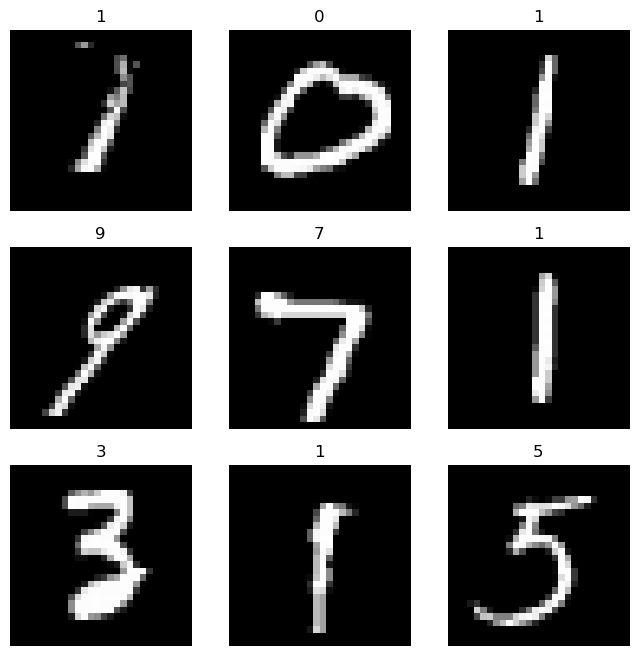

In [6]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray") # squeezing remove all 1-D unless any specified "dim=i" is mentioned.
plt.show()

In [7]:
# Create data loaders to batch and shuffle the data

# from torch.utils.data import DataLoader

batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Feature batch shape: torch.Size([32, 1, 28, 28])
Labels batch shape: torch.Size([32])


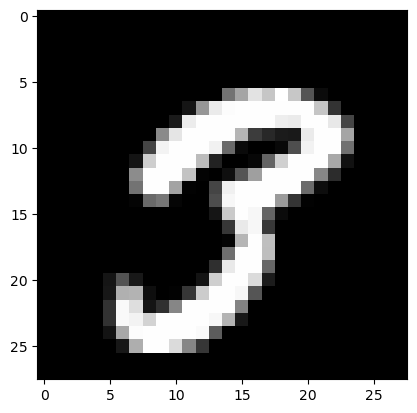

Label: 3


In [8]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [10]:
!nvidia-smi

Mon Mar 27 10:37:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Check the performance for Different Parameter Values¶

In [11]:
#-----------------------------------------------------------------------------------------------------------------------------------
# Create an empty DataFrame
results_df = pd.DataFrame(columns=['train_loss', 'test_loss', 'accuracy', 'optimizer', 'no_of_epochs', 'batch_size'])

#-----------------------------------------------------------------------------------------------------------------------------------
batch_sizes=[16, 32, 64, 128, 256, 512]
#-----------------------------------------------------------------------------------------------------------------------------------
# Define the Neural Network Architecture
class Net_MNIST(nn.Module):
    def __init__(self):
        super(Net_MNIST,self).__init__()
        self.dropout_1 = nn.Dropout(0.1)
        self.dropout_2 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(in_features=784, out_features=256, bias=True)   # 1st Hidden layer
        self.fc2 = nn.Linear(256, 64)    # 4th Hidden layer
        self.fc3 = nn.Linear(64, 10)  #output layer

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten input image
        x = torch.relu(self.fc1(x))  # add hidden layer, with relu activation function
        x = self.dropout_2(x)  # add dropout layer
        x = torch.relu(self.fc2(x))  # add hidden layer, with relu activation function
        x = self.dropout_1(x)
        x = self.fc3(x) # add output layer
        return x


#---------------------------------------------------------------------------------------------------------------------------------
# Instantiate the neural network model
model = Net_MNIST().to(device)
print(model)
#---------------------------------------------------------------------------------------------------------------------------------
from tqdm import tqdm

def train(model, device, train_loader, optimizer, loss_fn):
    model.train()
    epoch_loss = 0.0
    with tqdm(total=len(train_loader)) as progress_bar:
        for i, (inputs, labels) in enumerate(train_loader, 0):
            inputs, labels = inputs.to(device), labels.to(device)

            # Compute prediction and loss
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

            progress_bar.update(1)

    avg_epoch_loss = epoch_loss / len(train_loader)
    return avg_epoch_loss
#---------------------------------------------------------------------------------------------------------------------------------
def test(model, device, test_loader, loss_fn):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad(), tqdm(total=len(test_loader)) as progress_bar:
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            test_loss += loss_fn(outputs, labels).item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            progress_bar.update(1)

    avg_test_loss = test_loss / len(test_loader.dataset)
    accuracy = 100 * correct / total
    return avg_test_loss, accuracy
#----------------------------------------------------------------------------------------------------------------------------------
# learning_rates = 5e-3
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
# optimizer
optimizers = [torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9),torch.optim.Adam(model.parameters(), lr=0.001),
              torch.optim.Adagrad(model.parameters(), lr=0.01),optim.RMSprop(model.parameters(), lr=0.001)]
epochs_list = [20, 30, 40, 60]
#---------------------------------------------------------------------------------------------------------------------------------
# Train the model
# Loop over optimizers
for i_optimizer in range(len(optimizers)):

    # iterate over different batch sizes
    for batch_size in batch_sizes:
        batch_size = batch_size

        # Loop over epochs
        for epochs in epochs_list:
            train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
            test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

            # Reset the weights and optimizer for each run
            model = Net_MNIST().to(device)
            for module in model.modules():
                """Reset the weights of a linear layer"""
                if isinstance(module, nn.Linear):
                    module.reset_parameters()

            # make optimizer instances
            optimizer_instance = [torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9),
                                  torch.optim.Adam(model.parameters(), lr=0.001),
                                  torch.optim.Adagrad(model.parameters(), lr=0.01),
                                  optim.RMSprop(model.parameters(), lr=0.001)][i_optimizer]
            optimizer_name = optimizer_instance.__class__.__name__

            # Loop over each epoch and train the model
            for epoch in range(epochs):

                # train the model
                train_loss = train(model, device, train_dataloader, optimizer_instance, loss_fn)
                # Evaluate the model
                test_loss, accuracy = test(model, device, test_dataloader, loss_fn)
                print(f"Epoch [{epoch+1}/{epochs}], train_loss: {train_loss:.4f}, test_loss: {test_loss:.4f}, accuracy: {accuracy:.2f}%")
            
            # Evaluate the model after training and append results to the DataFrame
            test_loss, accuracy = test(model, device, test_dataloader, loss_fn)

            # Append results to dataframe
            new_df = pd.DataFrame({'train_loss': [train_loss],
                                    'test_loss': [test_loss], 
                                    'accuracy': [accuracy], 
                                    'optimizer': [optimizer_name],
                                    'no_of_epochs': [epochs], 
                                    'batch_size': [batch_size]})
            results_df = pd.concat([results_df, new_df], ignore_index=True)
            

            print(f"------- this was for epochs = {epochs}------now for next epoch------")
            print()
        print(f"-------This was for Batch Size: {batch_size}------- Now for next Batch Size-------")
        print()
    print(f"_____This was for optimizer: {optimizer_instance} _______ now for next optimizer_____")
    print()


Net_MNIST(
  (dropout_1): Dropout(p=0.1, inplace=False)
  (dropout_2): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)


100%|██████████| 625/625 [00:01<00:00, 500.28it/s]


Epoch [1/20], train_loss: 0.8344, test_loss: 0.3200, accuracy: 90.63%


100%|██████████| 625/625 [00:01<00:00, 495.40it/s]


Epoch [2/20], train_loss: 0.3280, test_loss: 0.2289, accuracy: 93.40%


100%|██████████| 625/625 [00:01<00:00, 470.83it/s]


Epoch [3/20], train_loss: 0.2466, test_loss: 0.1752, accuracy: 94.98%


100%|██████████| 625/625 [00:01<00:00, 496.55it/s]


Epoch [4/20], train_loss: 0.1967, test_loss: 0.1433, accuracy: 95.75%


100%|██████████| 625/625 [00:01<00:00, 429.37it/s]


Epoch [5/20], train_loss: 0.1664, test_loss: 0.1263, accuracy: 96.11%


100%|██████████| 625/625 [00:01<00:00, 501.51it/s]


Epoch [6/20], train_loss: 0.1455, test_loss: 0.1125, accuracy: 96.57%


100%|██████████| 625/625 [00:01<00:00, 499.60it/s]


Epoch [7/20], train_loss: 0.1264, test_loss: 0.1011, accuracy: 96.90%


100%|██████████| 625/625 [00:01<00:00, 469.43it/s]


Epoch [8/20], train_loss: 0.1153, test_loss: 0.0908, accuracy: 97.14%


100%|██████████| 625/625 [00:01<00:00, 496.98it/s]


Epoch [9/20], train_loss: 0.1031, test_loss: 0.0861, accuracy: 97.28%


100%|██████████| 625/625 [00:01<00:00, 501.80it/s]


Epoch [10/20], train_loss: 0.0950, test_loss: 0.0813, accuracy: 97.43%


100%|██████████| 625/625 [00:01<00:00, 500.91it/s]


Epoch [11/20], train_loss: 0.0868, test_loss: 0.0777, accuracy: 97.48%


100%|██████████| 625/625 [00:01<00:00, 499.57it/s]


Epoch [12/20], train_loss: 0.0819, test_loss: 0.0753, accuracy: 97.60%


100%|██████████| 625/625 [00:01<00:00, 438.46it/s]


Epoch [13/20], train_loss: 0.0751, test_loss: 0.0715, accuracy: 97.76%


100%|██████████| 625/625 [00:01<00:00, 467.39it/s]


Epoch [14/20], train_loss: 0.0708, test_loss: 0.0695, accuracy: 97.83%


100%|██████████| 625/625 [00:01<00:00, 498.35it/s]


Epoch [15/20], train_loss: 0.0674, test_loss: 0.0665, accuracy: 97.92%


100%|██████████| 625/625 [00:01<00:00, 497.47it/s]


Epoch [16/20], train_loss: 0.0622, test_loss: 0.0664, accuracy: 97.91%


100%|██████████| 625/625 [00:01<00:00, 438.46it/s]


Epoch [17/20], train_loss: 0.0599, test_loss: 0.0625, accuracy: 97.97%


100%|██████████| 625/625 [00:01<00:00, 499.29it/s]


Epoch [18/20], train_loss: 0.0570, test_loss: 0.0622, accuracy: 98.02%


100%|██████████| 625/625 [00:01<00:00, 503.02it/s]


Epoch [19/20], train_loss: 0.0529, test_loss: 0.0615, accuracy: 97.94%


100%|██████████| 625/625 [00:01<00:00, 503.48it/s]


Epoch [20/20], train_loss: 0.0504, test_loss: 0.0602, accuracy: 98.13%


100%|██████████| 625/625 [00:01<00:00, 416.51it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 625/625 [00:01<00:00, 496.91it/s]


Epoch [1/30], train_loss: 0.8733, test_loss: 0.3234, accuracy: 90.96%


100%|██████████| 625/625 [00:01<00:00, 504.89it/s]


Epoch [2/30], train_loss: 0.3287, test_loss: 0.2302, accuracy: 93.17%


100%|██████████| 625/625 [00:01<00:00, 501.11it/s]


Epoch [3/30], train_loss: 0.2490, test_loss: 0.1764, accuracy: 94.73%


100%|██████████| 625/625 [00:01<00:00, 501.20it/s]


Epoch [4/30], train_loss: 0.2027, test_loss: 0.1508, accuracy: 95.32%


100%|██████████| 625/625 [00:01<00:00, 502.88it/s]


Epoch [5/30], train_loss: 0.1705, test_loss: 0.1322, accuracy: 95.92%


100%|██████████| 625/625 [00:01<00:00, 502.43it/s]


Epoch [6/30], train_loss: 0.1501, test_loss: 0.1150, accuracy: 96.47%


100%|██████████| 625/625 [00:01<00:00, 498.29it/s]


Epoch [7/30], train_loss: 0.1328, test_loss: 0.1026, accuracy: 96.79%


100%|██████████| 625/625 [00:01<00:00, 443.04it/s]


Epoch [8/30], train_loss: 0.1192, test_loss: 0.0966, accuracy: 97.04%


100%|██████████| 625/625 [00:01<00:00, 490.30it/s]


Epoch [9/30], train_loss: 0.1061, test_loss: 0.0932, accuracy: 97.04%


100%|██████████| 625/625 [00:01<00:00, 502.21it/s]


Epoch [10/30], train_loss: 0.0989, test_loss: 0.0826, accuracy: 97.53%


100%|██████████| 625/625 [00:01<00:00, 383.93it/s]


Epoch [11/30], train_loss: 0.0897, test_loss: 0.0797, accuracy: 97.38%


100%|██████████| 625/625 [00:01<00:00, 501.36it/s]


Epoch [12/30], train_loss: 0.0849, test_loss: 0.0779, accuracy: 97.62%


100%|██████████| 625/625 [00:01<00:00, 487.17it/s]


Epoch [13/30], train_loss: 0.0790, test_loss: 0.0741, accuracy: 97.70%


100%|██████████| 625/625 [00:01<00:00, 500.57it/s]


Epoch [14/30], train_loss: 0.0732, test_loss: 0.0692, accuracy: 97.82%


100%|██████████| 625/625 [00:01<00:00, 505.95it/s]


Epoch [15/30], train_loss: 0.0696, test_loss: 0.0685, accuracy: 97.85%


100%|██████████| 625/625 [00:01<00:00, 497.74it/s]


Epoch [16/30], train_loss: 0.0658, test_loss: 0.0664, accuracy: 97.93%


100%|██████████| 625/625 [00:01<00:00, 433.60it/s]


Epoch [17/30], train_loss: 0.0617, test_loss: 0.0635, accuracy: 98.01%


100%|██████████| 625/625 [00:01<00:00, 495.81it/s]


Epoch [18/30], train_loss: 0.0590, test_loss: 0.0636, accuracy: 98.00%


100%|██████████| 625/625 [00:01<00:00, 495.80it/s]


Epoch [19/30], train_loss: 0.0558, test_loss: 0.0619, accuracy: 98.15%


100%|██████████| 625/625 [00:01<00:00, 502.12it/s]


Epoch [20/30], train_loss: 0.0515, test_loss: 0.0608, accuracy: 98.04%


100%|██████████| 625/625 [00:01<00:00, 495.32it/s]


Epoch [21/30], train_loss: 0.0490, test_loss: 0.0610, accuracy: 98.14%


100%|██████████| 625/625 [00:01<00:00, 474.38it/s]


Epoch [22/30], train_loss: 0.0482, test_loss: 0.0599, accuracy: 98.21%


100%|██████████| 625/625 [00:01<00:00, 499.05it/s]


Epoch [23/30], train_loss: 0.0459, test_loss: 0.0603, accuracy: 98.18%


100%|██████████| 625/625 [00:01<00:00, 494.02it/s]


Epoch [24/30], train_loss: 0.0432, test_loss: 0.0590, accuracy: 98.21%


100%|██████████| 625/625 [00:01<00:00, 429.43it/s]


Epoch [25/30], train_loss: 0.0412, test_loss: 0.0569, accuracy: 98.22%


100%|██████████| 625/625 [00:01<00:00, 458.34it/s]


Epoch [26/30], train_loss: 0.0398, test_loss: 0.0581, accuracy: 98.23%


100%|██████████| 625/625 [00:01<00:00, 505.70it/s]


Epoch [27/30], train_loss: 0.0376, test_loss: 0.0567, accuracy: 98.29%


100%|██████████| 625/625 [00:01<00:00, 495.71it/s]


Epoch [28/30], train_loss: 0.0356, test_loss: 0.0592, accuracy: 98.18%


100%|██████████| 625/625 [00:01<00:00, 417.64it/s]


Epoch [29/30], train_loss: 0.0361, test_loss: 0.0572, accuracy: 98.15%


100%|██████████| 625/625 [00:01<00:00, 501.64it/s]


Epoch [30/30], train_loss: 0.0330, test_loss: 0.0574, accuracy: 98.32%


100%|██████████| 625/625 [00:01<00:00, 503.74it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 625/625 [00:01<00:00, 506.33it/s]


Epoch [1/40], train_loss: 0.8329, test_loss: 0.3285, accuracy: 90.57%


100%|██████████| 625/625 [00:01<00:00, 505.69it/s]


Epoch [2/40], train_loss: 0.3293, test_loss: 0.2320, accuracy: 93.01%


100%|██████████| 625/625 [00:01<00:00, 506.97it/s]


Epoch [3/40], train_loss: 0.2490, test_loss: 0.1830, accuracy: 94.55%


100%|██████████| 625/625 [00:01<00:00, 426.18it/s]


Epoch [4/40], train_loss: 0.2019, test_loss: 0.1503, accuracy: 95.33%


100%|██████████| 625/625 [00:01<00:00, 488.98it/s]


Epoch [5/40], train_loss: 0.1711, test_loss: 0.1295, accuracy: 96.08%


100%|██████████| 625/625 [00:01<00:00, 505.62it/s]


Epoch [6/40], train_loss: 0.1491, test_loss: 0.1140, accuracy: 96.53%


100%|██████████| 625/625 [00:01<00:00, 463.54it/s]


Epoch [7/40], train_loss: 0.1320, test_loss: 0.1027, accuracy: 96.76%


100%|██████████| 625/625 [00:01<00:00, 506.86it/s]


Epoch [8/40], train_loss: 0.1205, test_loss: 0.0977, accuracy: 96.99%


100%|██████████| 625/625 [00:01<00:00, 477.47it/s]


Epoch [9/40], train_loss: 0.1076, test_loss: 0.0878, accuracy: 97.31%


100%|██████████| 625/625 [00:01<00:00, 504.26it/s]


Epoch [10/40], train_loss: 0.0994, test_loss: 0.0837, accuracy: 97.38%


100%|██████████| 625/625 [00:01<00:00, 497.16it/s]


Epoch [11/40], train_loss: 0.0915, test_loss: 0.0793, accuracy: 97.57%


100%|██████████| 625/625 [00:01<00:00, 423.85it/s]


Epoch [12/40], train_loss: 0.0847, test_loss: 0.0748, accuracy: 97.64%


100%|██████████| 625/625 [00:01<00:00, 434.84it/s]


Epoch [13/40], train_loss: 0.0782, test_loss: 0.0758, accuracy: 97.66%


100%|██████████| 625/625 [00:01<00:00, 503.84it/s]


Epoch [14/40], train_loss: 0.0732, test_loss: 0.0729, accuracy: 97.65%


100%|██████████| 625/625 [00:01<00:00, 507.48it/s]


Epoch [15/40], train_loss: 0.0700, test_loss: 0.0691, accuracy: 97.75%


100%|██████████| 625/625 [00:01<00:00, 498.65it/s]


Epoch [16/40], train_loss: 0.0663, test_loss: 0.0674, accuracy: 97.94%


100%|██████████| 625/625 [00:01<00:00, 512.07it/s]


Epoch [17/40], train_loss: 0.0626, test_loss: 0.0693, accuracy: 97.83%


100%|██████████| 625/625 [00:01<00:00, 510.39it/s]


Epoch [18/40], train_loss: 0.0589, test_loss: 0.0673, accuracy: 97.82%


100%|██████████| 625/625 [00:01<00:00, 508.22it/s]


Epoch [19/40], train_loss: 0.0546, test_loss: 0.0656, accuracy: 97.87%


100%|██████████| 625/625 [00:01<00:00, 504.98it/s]


Epoch [20/40], train_loss: 0.0540, test_loss: 0.0661, accuracy: 97.90%


100%|██████████| 625/625 [00:01<00:00, 507.77it/s]


Epoch [21/40], train_loss: 0.0513, test_loss: 0.0638, accuracy: 97.87%


100%|██████████| 625/625 [00:01<00:00, 504.11it/s]


Epoch [22/40], train_loss: 0.0482, test_loss: 0.0628, accuracy: 97.95%


100%|██████████| 625/625 [00:01<00:00, 497.61it/s]


Epoch [23/40], train_loss: 0.0467, test_loss: 0.0624, accuracy: 97.99%


100%|██████████| 625/625 [00:01<00:00, 501.37it/s]


Epoch [24/40], train_loss: 0.0433, test_loss: 0.0601, accuracy: 98.11%


100%|██████████| 625/625 [00:01<00:00, 510.51it/s]


Epoch [25/40], train_loss: 0.0417, test_loss: 0.0594, accuracy: 98.21%


100%|██████████| 625/625 [00:01<00:00, 510.81it/s]


Epoch [26/40], train_loss: 0.0390, test_loss: 0.0606, accuracy: 98.14%


100%|██████████| 625/625 [00:01<00:00, 510.53it/s]


Epoch [27/40], train_loss: 0.0391, test_loss: 0.0594, accuracy: 98.16%


100%|██████████| 625/625 [00:01<00:00, 493.90it/s]


Epoch [28/40], train_loss: 0.0371, test_loss: 0.0594, accuracy: 98.12%


100%|██████████| 625/625 [00:01<00:00, 507.59it/s]


Epoch [29/40], train_loss: 0.0356, test_loss: 0.0600, accuracy: 98.12%


100%|██████████| 625/625 [00:01<00:00, 508.39it/s]


Epoch [30/40], train_loss: 0.0339, test_loss: 0.0601, accuracy: 98.13%


100%|██████████| 625/625 [00:01<00:00, 461.69it/s]


Epoch [31/40], train_loss: 0.0315, test_loss: 0.0583, accuracy: 98.22%


100%|██████████| 625/625 [00:01<00:00, 437.26it/s]


Epoch [32/40], train_loss: 0.0315, test_loss: 0.0590, accuracy: 98.20%


100%|██████████| 625/625 [00:01<00:00, 511.66it/s]


Epoch [33/40], train_loss: 0.0298, test_loss: 0.0577, accuracy: 98.23%


100%|██████████| 625/625 [00:01<00:00, 506.34it/s]


Epoch [34/40], train_loss: 0.0292, test_loss: 0.0607, accuracy: 98.18%


100%|██████████| 625/625 [00:01<00:00, 503.90it/s]


Epoch [35/40], train_loss: 0.0289, test_loss: 0.0588, accuracy: 98.15%


100%|██████████| 625/625 [00:01<00:00, 503.40it/s]


Epoch [36/40], train_loss: 0.0278, test_loss: 0.0586, accuracy: 98.19%


100%|██████████| 625/625 [00:01<00:00, 502.16it/s]


Epoch [37/40], train_loss: 0.0260, test_loss: 0.0569, accuracy: 98.16%


100%|██████████| 625/625 [00:01<00:00, 453.51it/s]


Epoch [38/40], train_loss: 0.0255, test_loss: 0.0578, accuracy: 98.19%


100%|██████████| 625/625 [00:01<00:00, 506.20it/s]


Epoch [39/40], train_loss: 0.0243, test_loss: 0.0564, accuracy: 98.29%


100%|██████████| 625/625 [00:01<00:00, 502.50it/s]


Epoch [40/40], train_loss: 0.0247, test_loss: 0.0593, accuracy: 98.26%


100%|██████████| 625/625 [00:01<00:00, 462.75it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 625/625 [00:01<00:00, 482.24it/s]


Epoch [1/60], train_loss: 0.8340, test_loss: 0.3238, accuracy: 90.90%


100%|██████████| 625/625 [00:01<00:00, 498.96it/s]


Epoch [2/60], train_loss: 0.3283, test_loss: 0.2317, accuracy: 93.31%


100%|██████████| 625/625 [00:01<00:00, 427.72it/s]


Epoch [3/60], train_loss: 0.2491, test_loss: 0.1807, accuracy: 94.62%


100%|██████████| 625/625 [00:01<00:00, 497.49it/s]


Epoch [4/60], train_loss: 0.2011, test_loss: 0.1489, accuracy: 95.61%


100%|██████████| 625/625 [00:01<00:00, 501.49it/s]


Epoch [5/60], train_loss: 0.1690, test_loss: 0.1272, accuracy: 96.19%


100%|██████████| 625/625 [00:01<00:00, 508.71it/s]


Epoch [6/60], train_loss: 0.1479, test_loss: 0.1137, accuracy: 96.55%


100%|██████████| 625/625 [00:01<00:00, 511.58it/s]


Epoch [7/60], train_loss: 0.1324, test_loss: 0.1040, accuracy: 96.82%


100%|██████████| 625/625 [00:01<00:00, 509.83it/s]


Epoch [8/60], train_loss: 0.1170, test_loss: 0.0951, accuracy: 97.07%


100%|██████████| 625/625 [00:01<00:00, 498.81it/s]


Epoch [9/60], train_loss: 0.1052, test_loss: 0.0900, accuracy: 97.34%


100%|██████████| 625/625 [00:01<00:00, 444.21it/s]


Epoch [10/60], train_loss: 0.0987, test_loss: 0.0801, accuracy: 97.45%


100%|██████████| 625/625 [00:01<00:00, 483.13it/s]


Epoch [11/60], train_loss: 0.0912, test_loss: 0.0773, accuracy: 97.54%


100%|██████████| 625/625 [00:01<00:00, 511.41it/s]


Epoch [12/60], train_loss: 0.0839, test_loss: 0.0765, accuracy: 97.58%


100%|██████████| 625/625 [00:01<00:00, 506.35it/s]


Epoch [13/60], train_loss: 0.0786, test_loss: 0.0748, accuracy: 97.71%


100%|██████████| 625/625 [00:01<00:00, 504.75it/s]


Epoch [14/60], train_loss: 0.0733, test_loss: 0.0695, accuracy: 97.81%


100%|██████████| 625/625 [00:01<00:00, 508.92it/s]


Epoch [15/60], train_loss: 0.0688, test_loss: 0.0679, accuracy: 97.92%


100%|██████████| 625/625 [00:01<00:00, 505.49it/s]


Epoch [16/60], train_loss: 0.0643, test_loss: 0.0649, accuracy: 98.04%


100%|██████████| 625/625 [00:01<00:00, 502.73it/s]


Epoch [17/60], train_loss: 0.0613, test_loss: 0.0661, accuracy: 98.01%


100%|██████████| 625/625 [00:01<00:00, 507.35it/s]


Epoch [18/60], train_loss: 0.0569, test_loss: 0.0651, accuracy: 98.01%


100%|██████████| 625/625 [00:01<00:00, 488.84it/s]


Epoch [19/60], train_loss: 0.0541, test_loss: 0.0640, accuracy: 98.08%


100%|██████████| 625/625 [00:01<00:00, 452.52it/s]


Epoch [20/60], train_loss: 0.0515, test_loss: 0.0659, accuracy: 97.96%


100%|██████████| 625/625 [00:01<00:00, 437.62it/s]


Epoch [21/60], train_loss: 0.0501, test_loss: 0.0616, accuracy: 98.04%


100%|██████████| 625/625 [00:01<00:00, 466.49it/s]


Epoch [22/60], train_loss: 0.0468, test_loss: 0.0617, accuracy: 98.07%


100%|██████████| 625/625 [00:01<00:00, 507.11it/s]


Epoch [23/60], train_loss: 0.0445, test_loss: 0.0591, accuracy: 98.16%


100%|██████████| 625/625 [00:01<00:00, 419.47it/s]


Epoch [24/60], train_loss: 0.0423, test_loss: 0.0581, accuracy: 98.10%


100%|██████████| 625/625 [00:01<00:00, 499.65it/s]


Epoch [25/60], train_loss: 0.0404, test_loss: 0.0590, accuracy: 98.20%


100%|██████████| 625/625 [00:01<00:00, 507.80it/s]


Epoch [26/60], train_loss: 0.0395, test_loss: 0.0585, accuracy: 98.20%


100%|██████████| 625/625 [00:01<00:00, 477.58it/s]


Epoch [27/60], train_loss: 0.0380, test_loss: 0.0592, accuracy: 98.17%


100%|██████████| 625/625 [00:01<00:00, 506.23it/s]


Epoch [28/60], train_loss: 0.0362, test_loss: 0.0587, accuracy: 98.24%


100%|██████████| 625/625 [00:01<00:00, 498.88it/s]


Epoch [29/60], train_loss: 0.0350, test_loss: 0.0601, accuracy: 98.12%


100%|██████████| 625/625 [00:01<00:00, 429.12it/s]


Epoch [30/60], train_loss: 0.0330, test_loss: 0.0598, accuracy: 98.20%


100%|██████████| 625/625 [00:01<00:00, 491.46it/s]


Epoch [31/60], train_loss: 0.0318, test_loss: 0.0620, accuracy: 98.09%


100%|██████████| 625/625 [00:01<00:00, 481.13it/s]


Epoch [32/60], train_loss: 0.0311, test_loss: 0.0568, accuracy: 98.25%


100%|██████████| 625/625 [00:01<00:00, 507.71it/s]


Epoch [33/60], train_loss: 0.0288, test_loss: 0.0585, accuracy: 98.26%


100%|██████████| 625/625 [00:01<00:00, 503.95it/s]


Epoch [34/60], train_loss: 0.0275, test_loss: 0.0553, accuracy: 98.25%


100%|██████████| 625/625 [00:01<00:00, 509.78it/s]


Epoch [35/60], train_loss: 0.0268, test_loss: 0.0584, accuracy: 98.23%


100%|██████████| 625/625 [00:01<00:00, 505.92it/s]


Epoch [36/60], train_loss: 0.0259, test_loss: 0.0579, accuracy: 98.25%


100%|██████████| 625/625 [00:01<00:00, 377.30it/s]


Epoch [37/60], train_loss: 0.0257, test_loss: 0.0579, accuracy: 98.21%


100%|██████████| 625/625 [00:01<00:00, 510.36it/s]


Epoch [38/60], train_loss: 0.0238, test_loss: 0.0554, accuracy: 98.34%


100%|██████████| 625/625 [00:01<00:00, 500.12it/s]


Epoch [39/60], train_loss: 0.0223, test_loss: 0.0588, accuracy: 98.33%


100%|██████████| 625/625 [00:01<00:00, 442.39it/s]


Epoch [40/60], train_loss: 0.0226, test_loss: 0.0575, accuracy: 98.26%


100%|██████████| 625/625 [00:01<00:00, 504.19it/s]


Epoch [41/60], train_loss: 0.0217, test_loss: 0.0567, accuracy: 98.30%


100%|██████████| 625/625 [00:01<00:00, 511.54it/s]


Epoch [42/60], train_loss: 0.0215, test_loss: 0.0608, accuracy: 98.26%


100%|██████████| 625/625 [00:01<00:00, 509.58it/s]


Epoch [43/60], train_loss: 0.0202, test_loss: 0.0572, accuracy: 98.26%


100%|██████████| 625/625 [00:01<00:00, 505.14it/s]


Epoch [44/60], train_loss: 0.0204, test_loss: 0.0574, accuracy: 98.17%


100%|██████████| 625/625 [00:01<00:00, 507.39it/s]


Epoch [45/60], train_loss: 0.0196, test_loss: 0.0575, accuracy: 98.26%


100%|██████████| 625/625 [00:01<00:00, 510.36it/s]


Epoch [46/60], train_loss: 0.0182, test_loss: 0.0601, accuracy: 98.27%


100%|██████████| 625/625 [00:01<00:00, 493.03it/s]


Epoch [47/60], train_loss: 0.0192, test_loss: 0.0591, accuracy: 98.21%


100%|██████████| 625/625 [00:01<00:00, 507.68it/s]


Epoch [48/60], train_loss: 0.0171, test_loss: 0.0561, accuracy: 98.27%


100%|██████████| 625/625 [00:01<00:00, 390.90it/s]


Epoch [49/60], train_loss: 0.0178, test_loss: 0.0557, accuracy: 98.27%


100%|██████████| 625/625 [00:01<00:00, 453.26it/s]


Epoch [50/60], train_loss: 0.0166, test_loss: 0.0567, accuracy: 98.31%


100%|██████████| 625/625 [00:01<00:00, 496.27it/s]


Epoch [51/60], train_loss: 0.0171, test_loss: 0.0588, accuracy: 98.42%


100%|██████████| 625/625 [00:01<00:00, 498.36it/s]


Epoch [52/60], train_loss: 0.0164, test_loss: 0.0611, accuracy: 98.23%


100%|██████████| 625/625 [00:01<00:00, 489.18it/s]


Epoch [53/60], train_loss: 0.0157, test_loss: 0.0573, accuracy: 98.23%


100%|██████████| 625/625 [00:01<00:00, 506.05it/s]


Epoch [54/60], train_loss: 0.0159, test_loss: 0.0570, accuracy: 98.37%


100%|██████████| 625/625 [00:01<00:00, 379.27it/s]


Epoch [55/60], train_loss: 0.0150, test_loss: 0.0564, accuracy: 98.31%


100%|██████████| 625/625 [00:01<00:00, 416.35it/s]


Epoch [56/60], train_loss: 0.0152, test_loss: 0.0580, accuracy: 98.33%


100%|██████████| 625/625 [00:01<00:00, 484.51it/s]


Epoch [57/60], train_loss: 0.0136, test_loss: 0.0585, accuracy: 98.37%


100%|██████████| 625/625 [00:01<00:00, 499.04it/s]


Epoch [58/60], train_loss: 0.0141, test_loss: 0.0589, accuracy: 98.30%


100%|██████████| 625/625 [00:01<00:00, 501.87it/s]


Epoch [59/60], train_loss: 0.0143, test_loss: 0.0603, accuracy: 98.27%


100%|██████████| 625/625 [00:01<00:00, 501.45it/s]


Epoch [60/60], train_loss: 0.0126, test_loss: 0.0589, accuracy: 98.34%


100%|██████████| 625/625 [00:01<00:00, 380.26it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 16------- Now for next Batch Size-------



100%|██████████| 313/313 [00:01<00:00, 295.89it/s]


Epoch [1/20], train_loss: 1.2400, test_loss: 0.4518, accuracy: 87.41%


100%|██████████| 313/313 [00:01<00:00, 284.65it/s]


Epoch [2/20], train_loss: 0.4442, test_loss: 0.3177, accuracy: 91.06%


100%|██████████| 313/313 [00:01<00:00, 294.35it/s]


Epoch [3/20], train_loss: 0.3484, test_loss: 0.2654, accuracy: 92.40%


100%|██████████| 313/313 [00:01<00:00, 241.66it/s]


Epoch [4/20], train_loss: 0.2949, test_loss: 0.2246, accuracy: 93.55%


100%|██████████| 313/313 [00:01<00:00, 289.45it/s]


Epoch [5/20], train_loss: 0.2570, test_loss: 0.1960, accuracy: 94.37%


100%|██████████| 313/313 [00:01<00:00, 295.26it/s]


Epoch [6/20], train_loss: 0.2270, test_loss: 0.1746, accuracy: 94.76%


100%|██████████| 313/313 [00:01<00:00, 296.55it/s]


Epoch [7/20], train_loss: 0.2041, test_loss: 0.1556, accuracy: 95.21%


100%|██████████| 313/313 [00:01<00:00, 298.55it/s]


Epoch [8/20], train_loss: 0.1850, test_loss: 0.1453, accuracy: 95.67%


100%|██████████| 313/313 [00:01<00:00, 291.05it/s]


Epoch [9/20], train_loss: 0.1718, test_loss: 0.1326, accuracy: 95.92%


100%|██████████| 313/313 [00:01<00:00, 248.53it/s]


Epoch [10/20], train_loss: 0.1583, test_loss: 0.1247, accuracy: 96.06%


100%|██████████| 313/313 [00:01<00:00, 296.01it/s]


Epoch [11/20], train_loss: 0.1471, test_loss: 0.1172, accuracy: 96.33%


100%|██████████| 313/313 [00:01<00:00, 293.07it/s]


Epoch [12/20], train_loss: 0.1370, test_loss: 0.1106, accuracy: 96.52%


100%|██████████| 313/313 [00:01<00:00, 291.13it/s]


Epoch [13/20], train_loss: 0.1288, test_loss: 0.1050, accuracy: 96.76%


100%|██████████| 313/313 [00:01<00:00, 292.46it/s]


Epoch [14/20], train_loss: 0.1235, test_loss: 0.1009, accuracy: 96.76%


100%|██████████| 313/313 [00:01<00:00, 286.64it/s]


Epoch [15/20], train_loss: 0.1159, test_loss: 0.0965, accuracy: 97.01%


100%|██████████| 313/313 [00:01<00:00, 293.64it/s]


Epoch [16/20], train_loss: 0.1084, test_loss: 0.0923, accuracy: 97.08%


100%|██████████| 313/313 [00:01<00:00, 211.92it/s]


Epoch [17/20], train_loss: 0.1043, test_loss: 0.0884, accuracy: 97.21%


100%|██████████| 313/313 [00:01<00:00, 297.13it/s]


Epoch [18/20], train_loss: 0.0993, test_loss: 0.0852, accuracy: 97.32%


100%|██████████| 313/313 [00:01<00:00, 293.91it/s]


Epoch [19/20], train_loss: 0.0945, test_loss: 0.0835, accuracy: 97.34%


100%|██████████| 313/313 [00:01<00:00, 295.79it/s]


Epoch [20/20], train_loss: 0.0905, test_loss: 0.0804, accuracy: 97.47%


100%|██████████| 313/313 [00:01<00:00, 294.68it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 313/313 [00:01<00:00, 294.51it/s]


Epoch [1/30], train_loss: 1.1945, test_loss: 0.4474, accuracy: 87.53%


100%|██████████| 313/313 [00:01<00:00, 288.64it/s]


Epoch [2/30], train_loss: 0.4451, test_loss: 0.3202, accuracy: 90.84%


100%|██████████| 313/313 [00:01<00:00, 292.81it/s]


Epoch [3/30], train_loss: 0.3541, test_loss: 0.2694, accuracy: 92.10%


100%|██████████| 313/313 [00:01<00:00, 285.69it/s]


Epoch [4/30], train_loss: 0.3027, test_loss: 0.2322, accuracy: 93.38%


100%|██████████| 313/313 [00:01<00:00, 291.68it/s]


Epoch [5/30], train_loss: 0.2616, test_loss: 0.2038, accuracy: 94.00%


100%|██████████| 313/313 [00:01<00:00, 294.62it/s]


Epoch [6/30], train_loss: 0.2312, test_loss: 0.1806, accuracy: 94.79%


100%|██████████| 313/313 [00:01<00:00, 235.96it/s]


Epoch [7/30], train_loss: 0.2057, test_loss: 0.1633, accuracy: 95.25%


100%|██████████| 313/313 [00:01<00:00, 295.52it/s]


Epoch [8/30], train_loss: 0.1849, test_loss: 0.1458, accuracy: 95.58%


100%|██████████| 313/313 [00:01<00:00, 296.85it/s]


Epoch [9/30], train_loss: 0.1707, test_loss: 0.1336, accuracy: 95.92%


100%|██████████| 313/313 [00:01<00:00, 289.70it/s]


Epoch [10/30], train_loss: 0.1573, test_loss: 0.1246, accuracy: 96.24%


100%|██████████| 313/313 [00:01<00:00, 238.16it/s]


Epoch [11/30], train_loss: 0.1456, test_loss: 0.1173, accuracy: 96.39%


100%|██████████| 313/313 [00:01<00:00, 293.10it/s]


Epoch [12/30], train_loss: 0.1346, test_loss: 0.1113, accuracy: 96.61%


100%|██████████| 313/313 [00:01<00:00, 297.48it/s]


Epoch [13/30], train_loss: 0.1279, test_loss: 0.1052, accuracy: 96.77%


100%|██████████| 313/313 [00:01<00:00, 292.52it/s]


Epoch [14/30], train_loss: 0.1198, test_loss: 0.0989, accuracy: 96.98%


100%|██████████| 313/313 [00:01<00:00, 291.49it/s]


Epoch [15/30], train_loss: 0.1126, test_loss: 0.0946, accuracy: 97.07%


100%|██████████| 313/313 [00:01<00:00, 293.72it/s]


Epoch [16/30], train_loss: 0.1066, test_loss: 0.0919, accuracy: 97.10%


100%|██████████| 313/313 [00:01<00:00, 282.29it/s]


Epoch [17/30], train_loss: 0.1016, test_loss: 0.0875, accuracy: 97.23%


100%|██████████| 313/313 [00:01<00:00, 260.20it/s]


Epoch [18/30], train_loss: 0.0962, test_loss: 0.0851, accuracy: 97.34%


100%|██████████| 313/313 [00:01<00:00, 290.00it/s]


Epoch [19/30], train_loss: 0.0948, test_loss: 0.0837, accuracy: 97.39%


100%|██████████| 313/313 [00:01<00:00, 290.77it/s]


Epoch [20/30], train_loss: 0.0882, test_loss: 0.0817, accuracy: 97.51%


100%|██████████| 313/313 [00:01<00:00, 296.91it/s]


Epoch [21/30], train_loss: 0.0850, test_loss: 0.0789, accuracy: 97.62%


100%|██████████| 313/313 [00:01<00:00, 290.50it/s]


Epoch [22/30], train_loss: 0.0819, test_loss: 0.0761, accuracy: 97.66%


100%|██████████| 313/313 [00:01<00:00, 297.82it/s]


Epoch [23/30], train_loss: 0.0785, test_loss: 0.0748, accuracy: 97.79%


100%|██████████| 313/313 [00:01<00:00, 291.91it/s]


Epoch [24/30], train_loss: 0.0769, test_loss: 0.0736, accuracy: 97.78%


100%|██████████| 313/313 [00:01<00:00, 290.90it/s]


Epoch [25/30], train_loss: 0.0735, test_loss: 0.0719, accuracy: 97.83%


100%|██████████| 313/313 [00:01<00:00, 291.84it/s]


Epoch [26/30], train_loss: 0.0713, test_loss: 0.0716, accuracy: 97.82%


100%|██████████| 313/313 [00:01<00:00, 289.35it/s]


Epoch [27/30], train_loss: 0.0690, test_loss: 0.0701, accuracy: 97.86%


100%|██████████| 313/313 [00:01<00:00, 290.61it/s]


Epoch [28/30], train_loss: 0.0653, test_loss: 0.0696, accuracy: 97.96%


100%|██████████| 313/313 [00:01<00:00, 291.31it/s]


Epoch [29/30], train_loss: 0.0655, test_loss: 0.0698, accuracy: 97.90%


100%|██████████| 313/313 [00:01<00:00, 296.88it/s]


Epoch [30/30], train_loss: 0.0617, test_loss: 0.0665, accuracy: 98.00%


100%|██████████| 313/313 [00:01<00:00, 290.12it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 313/313 [00:01<00:00, 281.74it/s]


Epoch [1/40], train_loss: 1.2410, test_loss: 0.4432, accuracy: 88.21%


100%|██████████| 313/313 [00:01<00:00, 263.97it/s]


Epoch [2/40], train_loss: 0.4415, test_loss: 0.3219, accuracy: 90.70%


100%|██████████| 313/313 [00:01<00:00, 293.14it/s]


Epoch [3/40], train_loss: 0.3536, test_loss: 0.2696, accuracy: 92.13%


100%|██████████| 313/313 [00:01<00:00, 276.35it/s]


Epoch [4/40], train_loss: 0.2988, test_loss: 0.2311, accuracy: 93.24%


100%|██████████| 313/313 [00:01<00:00, 296.87it/s]


Epoch [5/40], train_loss: 0.2606, test_loss: 0.2036, accuracy: 93.96%


100%|██████████| 313/313 [00:01<00:00, 291.29it/s]


Epoch [6/40], train_loss: 0.2321, test_loss: 0.1800, accuracy: 94.66%


100%|██████████| 313/313 [00:01<00:00, 288.32it/s]


Epoch [7/40], train_loss: 0.2076, test_loss: 0.1624, accuracy: 95.15%


100%|██████████| 313/313 [00:01<00:00, 291.21it/s]


Epoch [8/40], train_loss: 0.1908, test_loss: 0.1476, accuracy: 95.56%


100%|██████████| 313/313 [00:01<00:00, 292.05it/s]


Epoch [9/40], train_loss: 0.1730, test_loss: 0.1371, accuracy: 95.80%


100%|██████████| 313/313 [00:01<00:00, 294.61it/s]


Epoch [10/40], train_loss: 0.1601, test_loss: 0.1276, accuracy: 96.18%


100%|██████████| 313/313 [00:01<00:00, 283.44it/s]


Epoch [11/40], train_loss: 0.1492, test_loss: 0.1174, accuracy: 96.43%


100%|██████████| 313/313 [00:01<00:00, 293.59it/s]


Epoch [12/40], train_loss: 0.1375, test_loss: 0.1114, accuracy: 96.66%


100%|██████████| 313/313 [00:01<00:00, 291.90it/s]


Epoch [13/40], train_loss: 0.1307, test_loss: 0.1066, accuracy: 96.70%


100%|██████████| 313/313 [00:01<00:00, 227.06it/s]


Epoch [14/40], train_loss: 0.1238, test_loss: 0.1009, accuracy: 96.87%


100%|██████████| 313/313 [00:01<00:00, 239.07it/s]


Epoch [15/40], train_loss: 0.1178, test_loss: 0.0967, accuracy: 97.01%


100%|██████████| 313/313 [00:01<00:00, 291.99it/s]


Epoch [16/40], train_loss: 0.1100, test_loss: 0.0923, accuracy: 97.12%


100%|██████████| 313/313 [00:01<00:00, 293.87it/s]


Epoch [17/40], train_loss: 0.1049, test_loss: 0.0900, accuracy: 97.09%


100%|██████████| 313/313 [00:01<00:00, 290.96it/s]


Epoch [18/40], train_loss: 0.1002, test_loss: 0.0855, accuracy: 97.39%


100%|██████████| 313/313 [00:01<00:00, 294.01it/s]


Epoch [19/40], train_loss: 0.0953, test_loss: 0.0835, accuracy: 97.43%


100%|██████████| 313/313 [00:01<00:00, 294.56it/s]


Epoch [20/40], train_loss: 0.0913, test_loss: 0.0820, accuracy: 97.47%


100%|██████████| 313/313 [00:01<00:00, 294.00it/s]


Epoch [21/40], train_loss: 0.0881, test_loss: 0.0785, accuracy: 97.51%


100%|██████████| 313/313 [00:01<00:00, 261.27it/s]


Epoch [22/40], train_loss: 0.0841, test_loss: 0.0758, accuracy: 97.63%


100%|██████████| 313/313 [00:01<00:00, 297.48it/s]


Epoch [23/40], train_loss: 0.0822, test_loss: 0.0748, accuracy: 97.69%


100%|██████████| 313/313 [00:01<00:00, 287.23it/s]


Epoch [24/40], train_loss: 0.0791, test_loss: 0.0746, accuracy: 97.73%


100%|██████████| 313/313 [00:01<00:00, 291.71it/s]


Epoch [25/40], train_loss: 0.0747, test_loss: 0.0723, accuracy: 97.67%


100%|██████████| 313/313 [00:01<00:00, 295.51it/s]


Epoch [26/40], train_loss: 0.0731, test_loss: 0.0727, accuracy: 97.73%


100%|██████████| 313/313 [00:01<00:00, 296.51it/s]


Epoch [27/40], train_loss: 0.0696, test_loss: 0.0707, accuracy: 97.81%


100%|██████████| 313/313 [00:01<00:00, 264.63it/s]


Epoch [28/40], train_loss: 0.0666, test_loss: 0.0695, accuracy: 97.95%


100%|██████████| 313/313 [00:01<00:00, 288.90it/s]


Epoch [29/40], train_loss: 0.0651, test_loss: 0.0686, accuracy: 97.81%


100%|██████████| 313/313 [00:01<00:00, 294.98it/s]


Epoch [30/40], train_loss: 0.0627, test_loss: 0.0677, accuracy: 97.90%


100%|██████████| 313/313 [00:01<00:00, 213.56it/s]


Epoch [31/40], train_loss: 0.0612, test_loss: 0.0650, accuracy: 97.98%


100%|██████████| 313/313 [00:01<00:00, 290.79it/s]


Epoch [32/40], train_loss: 0.0591, test_loss: 0.0651, accuracy: 97.95%


100%|██████████| 313/313 [00:01<00:00, 295.46it/s]


Epoch [33/40], train_loss: 0.0578, test_loss: 0.0656, accuracy: 97.85%


100%|██████████| 313/313 [00:01<00:00, 295.33it/s]


Epoch [34/40], train_loss: 0.0559, test_loss: 0.0641, accuracy: 97.92%


100%|██████████| 313/313 [00:01<00:00, 240.57it/s]


Epoch [35/40], train_loss: 0.0537, test_loss: 0.0631, accuracy: 97.97%


100%|██████████| 313/313 [00:01<00:00, 296.88it/s]


Epoch [36/40], train_loss: 0.0529, test_loss: 0.0634, accuracy: 98.01%


100%|██████████| 313/313 [00:01<00:00, 295.46it/s]


Epoch [37/40], train_loss: 0.0513, test_loss: 0.0636, accuracy: 97.99%


100%|██████████| 313/313 [00:01<00:00, 293.08it/s]


Epoch [38/40], train_loss: 0.0511, test_loss: 0.0620, accuracy: 98.01%


100%|██████████| 313/313 [00:01<00:00, 289.05it/s]


Epoch [39/40], train_loss: 0.0485, test_loss: 0.0612, accuracy: 98.05%


100%|██████████| 313/313 [00:01<00:00, 290.22it/s]


Epoch [40/40], train_loss: 0.0468, test_loss: 0.0605, accuracy: 98.02%


100%|██████████| 313/313 [00:01<00:00, 289.52it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 313/313 [00:01<00:00, 203.06it/s]


Epoch [1/60], train_loss: 1.2516, test_loss: 0.4605, accuracy: 87.60%


100%|██████████| 313/313 [00:01<00:00, 283.85it/s]


Epoch [2/60], train_loss: 0.4471, test_loss: 0.3233, accuracy: 90.74%


100%|██████████| 313/313 [00:01<00:00, 297.26it/s]


Epoch [3/60], train_loss: 0.3525, test_loss: 0.2694, accuracy: 92.10%


100%|██████████| 313/313 [00:01<00:00, 295.15it/s]


Epoch [4/60], train_loss: 0.2983, test_loss: 0.2310, accuracy: 93.20%


100%|██████████| 313/313 [00:01<00:00, 296.56it/s]


Epoch [5/60], train_loss: 0.2594, test_loss: 0.2021, accuracy: 94.06%


100%|██████████| 313/313 [00:01<00:00, 289.89it/s]


Epoch [6/60], train_loss: 0.2293, test_loss: 0.1793, accuracy: 94.48%


100%|██████████| 313/313 [00:01<00:00, 292.64it/s]


Epoch [7/60], train_loss: 0.2043, test_loss: 0.1602, accuracy: 95.10%


100%|██████████| 313/313 [00:01<00:00, 293.22it/s]


Epoch [8/60], train_loss: 0.1862, test_loss: 0.1464, accuracy: 95.55%


100%|██████████| 313/313 [00:01<00:00, 242.88it/s]


Epoch [9/60], train_loss: 0.1694, test_loss: 0.1348, accuracy: 95.87%


100%|██████████| 313/313 [00:01<00:00, 279.85it/s]


Epoch [10/60], train_loss: 0.1592, test_loss: 0.1269, accuracy: 96.09%


100%|██████████| 313/313 [00:01<00:00, 294.53it/s]


Epoch [11/60], train_loss: 0.1469, test_loss: 0.1190, accuracy: 96.30%


100%|██████████| 313/313 [00:01<00:00, 293.55it/s]


Epoch [12/60], train_loss: 0.1368, test_loss: 0.1104, accuracy: 96.66%


100%|██████████| 313/313 [00:01<00:00, 297.39it/s]


Epoch [13/60], train_loss: 0.1292, test_loss: 0.1043, accuracy: 96.85%


100%|██████████| 313/313 [00:01<00:00, 292.19it/s]


Epoch [14/60], train_loss: 0.1216, test_loss: 0.0992, accuracy: 97.01%


100%|██████████| 313/313 [00:01<00:00, 293.61it/s]


Epoch [15/60], train_loss: 0.1150, test_loss: 0.0964, accuracy: 97.00%


100%|██████████| 313/313 [00:01<00:00, 293.02it/s]


Epoch [16/60], train_loss: 0.1093, test_loss: 0.0914, accuracy: 97.15%


100%|██████████| 313/313 [00:01<00:00, 283.00it/s]


Epoch [17/60], train_loss: 0.1030, test_loss: 0.0877, accuracy: 97.27%


100%|██████████| 313/313 [00:01<00:00, 256.79it/s]


Epoch [18/60], train_loss: 0.0986, test_loss: 0.0858, accuracy: 97.37%


100%|██████████| 313/313 [00:01<00:00, 296.62it/s]


Epoch [19/60], train_loss: 0.0939, test_loss: 0.0833, accuracy: 97.36%


100%|██████████| 313/313 [00:01<00:00, 294.72it/s]


Epoch [20/60], train_loss: 0.0901, test_loss: 0.0796, accuracy: 97.57%


100%|██████████| 313/313 [00:01<00:00, 289.15it/s]


Epoch [21/60], train_loss: 0.0868, test_loss: 0.0777, accuracy: 97.61%


100%|██████████| 313/313 [00:01<00:00, 243.87it/s]


Epoch [22/60], train_loss: 0.0826, test_loss: 0.0759, accuracy: 97.71%


100%|██████████| 313/313 [00:01<00:00, 287.44it/s]


Epoch [23/60], train_loss: 0.0804, test_loss: 0.0750, accuracy: 97.64%


100%|██████████| 313/313 [00:01<00:00, 294.74it/s]


Epoch [24/60], train_loss: 0.0769, test_loss: 0.0747, accuracy: 97.81%


100%|██████████| 313/313 [00:01<00:00, 297.99it/s]


Epoch [25/60], train_loss: 0.0748, test_loss: 0.0716, accuracy: 97.74%


100%|██████████| 313/313 [00:01<00:00, 296.95it/s]


Epoch [26/60], train_loss: 0.0707, test_loss: 0.0706, accuracy: 97.83%


100%|██████████| 313/313 [00:01<00:00, 288.46it/s]


Epoch [27/60], train_loss: 0.0692, test_loss: 0.0699, accuracy: 97.88%


100%|██████████| 313/313 [00:01<00:00, 290.29it/s]


Epoch [28/60], train_loss: 0.0667, test_loss: 0.0674, accuracy: 97.92%


100%|██████████| 313/313 [00:01<00:00, 291.29it/s]


Epoch [29/60], train_loss: 0.0638, test_loss: 0.0666, accuracy: 97.89%


100%|██████████| 313/313 [00:01<00:00, 292.13it/s]


Epoch [30/60], train_loss: 0.0637, test_loss: 0.0657, accuracy: 97.97%


100%|██████████| 313/313 [00:01<00:00, 292.79it/s]


Epoch [31/60], train_loss: 0.0608, test_loss: 0.0660, accuracy: 97.96%


100%|██████████| 313/313 [00:01<00:00, 295.38it/s]


Epoch [32/60], train_loss: 0.0582, test_loss: 0.0647, accuracy: 97.92%


100%|██████████| 313/313 [00:01<00:00, 295.75it/s]


Epoch [33/60], train_loss: 0.0555, test_loss: 0.0634, accuracy: 98.03%


100%|██████████| 313/313 [00:01<00:00, 295.79it/s]


Epoch [34/60], train_loss: 0.0558, test_loss: 0.0629, accuracy: 98.07%


100%|██████████| 313/313 [00:01<00:00, 262.10it/s]


Epoch [35/60], train_loss: 0.0538, test_loss: 0.0625, accuracy: 98.06%


100%|██████████| 313/313 [00:01<00:00, 283.89it/s]


Epoch [36/60], train_loss: 0.0523, test_loss: 0.0608, accuracy: 98.05%


100%|██████████| 313/313 [00:01<00:00, 298.67it/s]


Epoch [37/60], train_loss: 0.0518, test_loss: 0.0615, accuracy: 98.05%


100%|██████████| 313/313 [00:01<00:00, 296.24it/s]


Epoch [38/60], train_loss: 0.0494, test_loss: 0.0608, accuracy: 98.12%


100%|██████████| 313/313 [00:01<00:00, 295.33it/s]


Epoch [39/60], train_loss: 0.0478, test_loss: 0.0588, accuracy: 98.12%


100%|██████████| 313/313 [00:01<00:00, 292.13it/s]


Epoch [40/60], train_loss: 0.0471, test_loss: 0.0604, accuracy: 98.16%


100%|██████████| 313/313 [00:01<00:00, 293.38it/s]


Epoch [41/60], train_loss: 0.0450, test_loss: 0.0597, accuracy: 98.12%


100%|██████████| 313/313 [00:01<00:00, 241.23it/s]


Epoch [42/60], train_loss: 0.0438, test_loss: 0.0587, accuracy: 98.18%


100%|██████████| 313/313 [00:01<00:00, 292.53it/s]


Epoch [43/60], train_loss: 0.0431, test_loss: 0.0572, accuracy: 98.25%


100%|██████████| 313/313 [00:01<00:00, 288.68it/s]


Epoch [44/60], train_loss: 0.0410, test_loss: 0.0588, accuracy: 98.19%


100%|██████████| 313/313 [00:01<00:00, 225.73it/s]


Epoch [45/60], train_loss: 0.0399, test_loss: 0.0579, accuracy: 98.25%


100%|██████████| 313/313 [00:01<00:00, 291.51it/s]


Epoch [46/60], train_loss: 0.0396, test_loss: 0.0574, accuracy: 98.19%


100%|██████████| 313/313 [00:01<00:00, 296.16it/s]


Epoch [47/60], train_loss: 0.0395, test_loss: 0.0571, accuracy: 98.30%


100%|██████████| 313/313 [00:01<00:00, 265.77it/s]


Epoch [48/60], train_loss: 0.0379, test_loss: 0.0576, accuracy: 98.24%


100%|██████████| 313/313 [00:01<00:00, 293.14it/s]


Epoch [49/60], train_loss: 0.0378, test_loss: 0.0570, accuracy: 98.24%


100%|██████████| 313/313 [00:01<00:00, 294.38it/s]


Epoch [50/60], train_loss: 0.0372, test_loss: 0.0564, accuracy: 98.23%


100%|██████████| 313/313 [00:01<00:00, 291.17it/s]


Epoch [51/60], train_loss: 0.0358, test_loss: 0.0561, accuracy: 98.34%


100%|██████████| 313/313 [00:01<00:00, 294.42it/s]


Epoch [52/60], train_loss: 0.0339, test_loss: 0.0561, accuracy: 98.26%


100%|██████████| 313/313 [00:01<00:00, 293.39it/s]


Epoch [53/60], train_loss: 0.0346, test_loss: 0.0564, accuracy: 98.30%


100%|██████████| 313/313 [00:01<00:00, 295.44it/s]


Epoch [54/60], train_loss: 0.0328, test_loss: 0.0574, accuracy: 98.27%


100%|██████████| 313/313 [00:01<00:00, 244.68it/s]


Epoch [55/60], train_loss: 0.0329, test_loss: 0.0548, accuracy: 98.32%


100%|██████████| 313/313 [00:01<00:00, 291.83it/s]


Epoch [56/60], train_loss: 0.0319, test_loss: 0.0559, accuracy: 98.24%


100%|██████████| 313/313 [00:01<00:00, 296.25it/s]


Epoch [57/60], train_loss: 0.0306, test_loss: 0.0549, accuracy: 98.32%


100%|██████████| 313/313 [00:01<00:00, 296.83it/s]


Epoch [58/60], train_loss: 0.0300, test_loss: 0.0549, accuracy: 98.32%


100%|██████████| 313/313 [00:01<00:00, 283.81it/s]


Epoch [59/60], train_loss: 0.0297, test_loss: 0.0543, accuracy: 98.36%


100%|██████████| 313/313 [00:01<00:00, 294.29it/s]


Epoch [60/60], train_loss: 0.0301, test_loss: 0.0563, accuracy: 98.28%


100%|██████████| 313/313 [00:01<00:00, 293.64it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 32------- Now for next Batch Size-------



100%|██████████| 157/157 [00:01<00:00, 138.71it/s]


Epoch [1/20], train_loss: 1.7838, test_loss: 0.8605, accuracy: 80.30%


100%|██████████| 157/157 [00:00<00:00, 159.72it/s]


Epoch [2/20], train_loss: 0.6739, test_loss: 0.4502, accuracy: 87.72%


100%|██████████| 157/157 [00:00<00:00, 161.64it/s]


Epoch [3/20], train_loss: 0.4830, test_loss: 0.3667, accuracy: 89.70%


100%|██████████| 157/157 [00:00<00:00, 162.59it/s]


Epoch [4/20], train_loss: 0.4146, test_loss: 0.3243, accuracy: 90.79%


100%|██████████| 157/157 [00:00<00:00, 160.44it/s]


Epoch [5/20], train_loss: 0.3725, test_loss: 0.2945, accuracy: 91.54%


100%|██████████| 157/157 [00:00<00:00, 161.05it/s]


Epoch [6/20], train_loss: 0.3398, test_loss: 0.2722, accuracy: 92.15%


100%|██████████| 157/157 [00:01<00:00, 156.74it/s]


Epoch [7/20], train_loss: 0.3149, test_loss: 0.2503, accuracy: 92.70%


100%|██████████| 157/157 [00:00<00:00, 159.27it/s]


Epoch [8/20], train_loss: 0.2904, test_loss: 0.2308, accuracy: 93.44%


100%|██████████| 157/157 [00:00<00:00, 158.24it/s]


Epoch [9/20], train_loss: 0.2688, test_loss: 0.2159, accuracy: 93.77%


100%|██████████| 157/157 [00:00<00:00, 161.91it/s]


Epoch [10/20], train_loss: 0.2514, test_loss: 0.2015, accuracy: 94.12%


100%|██████████| 157/157 [00:00<00:00, 162.71it/s]


Epoch [11/20], train_loss: 0.2348, test_loss: 0.1873, accuracy: 94.43%


100%|██████████| 157/157 [00:01<00:00, 130.03it/s]


Epoch [12/20], train_loss: 0.2213, test_loss: 0.1754, accuracy: 94.73%


100%|██████████| 157/157 [00:00<00:00, 161.38it/s]


Epoch [13/20], train_loss: 0.2081, test_loss: 0.1686, accuracy: 94.95%


100%|██████████| 157/157 [00:00<00:00, 161.34it/s]


Epoch [14/20], train_loss: 0.1974, test_loss: 0.1589, accuracy: 95.26%


100%|██████████| 157/157 [00:00<00:00, 161.44it/s]


Epoch [15/20], train_loss: 0.1902, test_loss: 0.1514, accuracy: 95.34%


100%|██████████| 157/157 [00:00<00:00, 161.97it/s]


Epoch [16/20], train_loss: 0.1781, test_loss: 0.1436, accuracy: 95.57%


100%|██████████| 157/157 [00:00<00:00, 159.35it/s]


Epoch [17/20], train_loss: 0.1702, test_loss: 0.1385, accuracy: 95.70%


100%|██████████| 157/157 [00:00<00:00, 161.80it/s]


Epoch [18/20], train_loss: 0.1638, test_loss: 0.1334, accuracy: 95.98%


100%|██████████| 157/157 [00:01<00:00, 131.09it/s]


Epoch [19/20], train_loss: 0.1576, test_loss: 0.1276, accuracy: 96.19%


100%|██████████| 157/157 [00:00<00:00, 160.95it/s]


Epoch [20/20], train_loss: 0.1515, test_loss: 0.1241, accuracy: 96.14%


100%|██████████| 157/157 [00:00<00:00, 162.06it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 157/157 [00:00<00:00, 162.39it/s]


Epoch [1/30], train_loss: 1.7836, test_loss: 0.8429, accuracy: 80.38%


100%|██████████| 157/157 [00:01<00:00, 112.48it/s]


Epoch [2/30], train_loss: 0.6592, test_loss: 0.4422, accuracy: 87.90%


100%|██████████| 157/157 [00:01<00:00, 130.20it/s]


Epoch [3/30], train_loss: 0.4734, test_loss: 0.3581, accuracy: 90.01%


100%|██████████| 157/157 [00:00<00:00, 160.76it/s]


Epoch [4/30], train_loss: 0.4070, test_loss: 0.3190, accuracy: 90.75%


100%|██████████| 157/157 [00:01<00:00, 155.42it/s]


Epoch [5/30], train_loss: 0.3640, test_loss: 0.2862, accuracy: 91.78%


100%|██████████| 157/157 [00:01<00:00, 113.03it/s]


Epoch [6/30], train_loss: 0.3292, test_loss: 0.2636, accuracy: 92.37%


100%|██████████| 157/157 [00:00<00:00, 160.58it/s]


Epoch [7/30], train_loss: 0.3038, test_loss: 0.2413, accuracy: 92.94%


100%|██████████| 157/157 [00:00<00:00, 163.57it/s]


Epoch [8/30], train_loss: 0.2794, test_loss: 0.2214, accuracy: 93.56%


100%|██████████| 157/157 [00:00<00:00, 159.98it/s]


Epoch [9/30], train_loss: 0.2612, test_loss: 0.2048, accuracy: 93.90%


100%|██████████| 157/157 [00:01<00:00, 92.49it/s]


Epoch [10/30], train_loss: 0.2427, test_loss: 0.1937, accuracy: 94.25%


100%|██████████| 157/157 [00:00<00:00, 161.89it/s]


Epoch [11/30], train_loss: 0.2292, test_loss: 0.1811, accuracy: 94.66%


100%|██████████| 157/157 [00:00<00:00, 158.65it/s]


Epoch [12/30], train_loss: 0.2163, test_loss: 0.1724, accuracy: 94.81%


100%|██████████| 157/157 [00:00<00:00, 161.51it/s]


Epoch [13/30], train_loss: 0.2039, test_loss: 0.1622, accuracy: 95.20%


100%|██████████| 157/157 [00:01<00:00, 115.13it/s]


Epoch [14/30], train_loss: 0.1950, test_loss: 0.1541, accuracy: 95.43%


100%|██████████| 157/157 [00:00<00:00, 161.56it/s]


Epoch [15/30], train_loss: 0.1863, test_loss: 0.1476, accuracy: 95.57%


100%|██████████| 157/157 [00:00<00:00, 161.44it/s]


Epoch [16/30], train_loss: 0.1753, test_loss: 0.1408, accuracy: 95.63%


100%|██████████| 157/157 [00:01<00:00, 151.63it/s]


Epoch [17/30], train_loss: 0.1694, test_loss: 0.1345, accuracy: 95.88%


100%|██████████| 157/157 [00:01<00:00, 112.01it/s]


Epoch [18/30], train_loss: 0.1610, test_loss: 0.1291, accuracy: 96.13%


100%|██████████| 157/157 [00:00<00:00, 161.12it/s]


Epoch [19/30], train_loss: 0.1569, test_loss: 0.1253, accuracy: 96.07%


100%|██████████| 157/157 [00:00<00:00, 160.41it/s]


Epoch [20/30], train_loss: 0.1504, test_loss: 0.1218, accuracy: 96.32%


100%|██████████| 157/157 [00:00<00:00, 158.46it/s]


Epoch [21/30], train_loss: 0.1449, test_loss: 0.1166, accuracy: 96.45%


100%|██████████| 157/157 [00:01<00:00, 109.98it/s]


Epoch [22/30], train_loss: 0.1408, test_loss: 0.1129, accuracy: 96.55%


100%|██████████| 157/157 [00:00<00:00, 163.31it/s]


Epoch [23/30], train_loss: 0.1344, test_loss: 0.1098, accuracy: 96.56%


100%|██████████| 157/157 [00:00<00:00, 157.48it/s]


Epoch [24/30], train_loss: 0.1311, test_loss: 0.1058, accuracy: 96.72%


100%|██████████| 157/157 [00:00<00:00, 161.30it/s]


Epoch [25/30], train_loss: 0.1259, test_loss: 0.1037, accuracy: 96.83%


100%|██████████| 157/157 [00:01<00:00, 111.18it/s]


Epoch [26/30], train_loss: 0.1218, test_loss: 0.1010, accuracy: 96.95%


100%|██████████| 157/157 [00:00<00:00, 161.50it/s]


Epoch [27/30], train_loss: 0.1193, test_loss: 0.0981, accuracy: 96.99%


100%|██████████| 157/157 [00:01<00:00, 130.21it/s]


Epoch [28/30], train_loss: 0.1158, test_loss: 0.0956, accuracy: 97.10%


100%|██████████| 157/157 [00:00<00:00, 161.13it/s]


Epoch [29/30], train_loss: 0.1127, test_loss: 0.0945, accuracy: 97.12%


100%|██████████| 157/157 [00:01<00:00, 125.79it/s]


Epoch [30/30], train_loss: 0.1092, test_loss: 0.0918, accuracy: 97.25%


100%|██████████| 157/157 [00:00<00:00, 161.71it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 157/157 [00:00<00:00, 161.69it/s]


Epoch [1/40], train_loss: 1.7910, test_loss: 0.8567, accuracy: 80.07%


100%|██████████| 157/157 [00:01<00:00, 132.17it/s]


Epoch [2/40], train_loss: 0.6765, test_loss: 0.4515, accuracy: 87.95%


100%|██████████| 157/157 [00:00<00:00, 157.81it/s]


Epoch [3/40], train_loss: 0.4835, test_loss: 0.3635, accuracy: 89.86%


100%|██████████| 157/157 [00:00<00:00, 160.58it/s]


Epoch [4/40], train_loss: 0.4142, test_loss: 0.3216, accuracy: 91.07%


100%|██████████| 157/157 [00:01<00:00, 156.08it/s]


Epoch [5/40], train_loss: 0.3681, test_loss: 0.2925, accuracy: 91.75%


100%|██████████| 157/157 [00:00<00:00, 158.25it/s]


Epoch [6/40], train_loss: 0.3362, test_loss: 0.2673, accuracy: 92.42%


100%|██████████| 157/157 [00:00<00:00, 158.85it/s]


Epoch [7/40], train_loss: 0.3122, test_loss: 0.2479, accuracy: 92.89%


100%|██████████| 157/157 [00:00<00:00, 160.75it/s]


Epoch [8/40], train_loss: 0.2878, test_loss: 0.2317, accuracy: 93.19%


100%|██████████| 157/157 [00:01<00:00, 136.90it/s]


Epoch [9/40], train_loss: 0.2699, test_loss: 0.2145, accuracy: 93.83%


100%|██████████| 157/157 [00:00<00:00, 160.40it/s]


Epoch [10/40], train_loss: 0.2546, test_loss: 0.2016, accuracy: 94.17%


100%|██████████| 157/157 [00:00<00:00, 159.99it/s]


Epoch [11/40], train_loss: 0.2382, test_loss: 0.1898, accuracy: 94.43%


100%|██████████| 157/157 [00:00<00:00, 158.38it/s]


Epoch [12/40], train_loss: 0.2273, test_loss: 0.1778, accuracy: 94.74%


100%|██████████| 157/157 [00:00<00:00, 157.79it/s]


Epoch [13/40], train_loss: 0.2149, test_loss: 0.1696, accuracy: 94.88%


100%|██████████| 157/157 [00:00<00:00, 160.66it/s]


Epoch [14/40], train_loss: 0.2027, test_loss: 0.1602, accuracy: 95.17%


100%|██████████| 157/157 [00:00<00:00, 161.91it/s]


Epoch [15/40], train_loss: 0.1951, test_loss: 0.1520, accuracy: 95.48%


100%|██████████| 157/157 [00:00<00:00, 158.92it/s]


Epoch [16/40], train_loss: 0.1855, test_loss: 0.1463, accuracy: 95.58%


100%|██████████| 157/157 [00:00<00:00, 160.49it/s]


Epoch [17/40], train_loss: 0.1788, test_loss: 0.1403, accuracy: 95.81%


100%|██████████| 157/157 [00:01<00:00, 156.88it/s]


Epoch [18/40], train_loss: 0.1707, test_loss: 0.1344, accuracy: 95.96%


100%|██████████| 157/157 [00:00<00:00, 161.97it/s]


Epoch [19/40], train_loss: 0.1640, test_loss: 0.1299, accuracy: 96.11%


100%|██████████| 157/157 [00:01<00:00, 141.48it/s]


Epoch [20/40], train_loss: 0.1570, test_loss: 0.1255, accuracy: 96.13%


100%|██████████| 157/157 [00:00<00:00, 158.71it/s]


Epoch [21/40], train_loss: 0.1503, test_loss: 0.1223, accuracy: 96.20%


100%|██████████| 157/157 [00:00<00:00, 159.33it/s]


Epoch [22/40], train_loss: 0.1459, test_loss: 0.1167, accuracy: 96.41%


100%|██████████| 157/157 [00:00<00:00, 160.09it/s]


Epoch [23/40], train_loss: 0.1404, test_loss: 0.1148, accuracy: 96.45%


100%|██████████| 157/157 [00:00<00:00, 161.76it/s]


Epoch [24/40], train_loss: 0.1381, test_loss: 0.1114, accuracy: 96.54%


100%|██████████| 157/157 [00:00<00:00, 161.90it/s]


Epoch [25/40], train_loss: 0.1330, test_loss: 0.1090, accuracy: 96.67%


100%|██████████| 157/157 [00:00<00:00, 161.93it/s]


Epoch [26/40], train_loss: 0.1282, test_loss: 0.1068, accuracy: 96.72%


100%|██████████| 157/157 [00:01<00:00, 129.07it/s]


Epoch [27/40], train_loss: 0.1250, test_loss: 0.1044, accuracy: 96.79%


100%|██████████| 157/157 [00:00<00:00, 162.63it/s]


Epoch [28/40], train_loss: 0.1212, test_loss: 0.1013, accuracy: 96.89%


100%|██████████| 157/157 [00:00<00:00, 161.48it/s]


Epoch [29/40], train_loss: 0.1188, test_loss: 0.0987, accuracy: 96.90%


100%|██████████| 157/157 [00:00<00:00, 161.48it/s]


Epoch [30/40], train_loss: 0.1152, test_loss: 0.0971, accuracy: 96.90%


100%|██████████| 157/157 [00:00<00:00, 161.14it/s]


Epoch [31/40], train_loss: 0.1133, test_loss: 0.0957, accuracy: 96.95%


100%|██████████| 157/157 [00:00<00:00, 161.24it/s]


Epoch [32/40], train_loss: 0.1092, test_loss: 0.0940, accuracy: 97.02%


100%|██████████| 157/157 [00:00<00:00, 160.45it/s]


Epoch [33/40], train_loss: 0.1069, test_loss: 0.0923, accuracy: 97.04%


100%|██████████| 157/157 [00:01<00:00, 135.46it/s]


Epoch [34/40], train_loss: 0.1035, test_loss: 0.0903, accuracy: 97.17%


100%|██████████| 157/157 [00:00<00:00, 158.30it/s]


Epoch [35/40], train_loss: 0.1007, test_loss: 0.0885, accuracy: 97.21%


100%|██████████| 157/157 [00:00<00:00, 160.34it/s]


Epoch [36/40], train_loss: 0.0977, test_loss: 0.0868, accuracy: 97.19%


100%|██████████| 157/157 [00:00<00:00, 160.77it/s]


Epoch [37/40], train_loss: 0.0966, test_loss: 0.0856, accuracy: 97.28%


100%|██████████| 157/157 [00:01<00:00, 139.68it/s]


Epoch [38/40], train_loss: 0.0935, test_loss: 0.0841, accuracy: 97.32%


100%|██████████| 157/157 [00:00<00:00, 162.79it/s]


Epoch [39/40], train_loss: 0.0921, test_loss: 0.0830, accuracy: 97.36%


100%|██████████| 157/157 [00:00<00:00, 161.69it/s]


Epoch [40/40], train_loss: 0.0888, test_loss: 0.0822, accuracy: 97.37%


100%|██████████| 157/157 [00:00<00:00, 161.21it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 157/157 [00:00<00:00, 159.66it/s]


Epoch [1/60], train_loss: 1.8105, test_loss: 0.8932, accuracy: 77.50%


100%|██████████| 157/157 [00:00<00:00, 160.29it/s]


Epoch [2/60], train_loss: 0.7056, test_loss: 0.4615, accuracy: 87.94%


100%|██████████| 157/157 [00:00<00:00, 158.01it/s]


Epoch [3/60], train_loss: 0.4922, test_loss: 0.3658, accuracy: 89.89%


100%|██████████| 157/157 [00:00<00:00, 160.34it/s]


Epoch [4/60], train_loss: 0.4172, test_loss: 0.3221, accuracy: 90.90%


100%|██████████| 157/157 [00:00<00:00, 160.45it/s]


Epoch [5/60], train_loss: 0.3699, test_loss: 0.2908, accuracy: 91.79%


100%|██████████| 157/157 [00:01<00:00, 156.65it/s]


Epoch [6/60], train_loss: 0.3366, test_loss: 0.2675, accuracy: 92.27%


100%|██████████| 157/157 [00:00<00:00, 159.04it/s]


Epoch [7/60], train_loss: 0.3124, test_loss: 0.2485, accuracy: 92.78%


100%|██████████| 157/157 [00:00<00:00, 160.45it/s]


Epoch [8/60], train_loss: 0.2890, test_loss: 0.2287, accuracy: 93.39%


100%|██████████| 157/157 [00:01<00:00, 147.14it/s]


Epoch [9/60], train_loss: 0.2693, test_loss: 0.2142, accuracy: 93.88%


100%|██████████| 157/157 [00:00<00:00, 160.17it/s]


Epoch [10/60], train_loss: 0.2511, test_loss: 0.2004, accuracy: 94.27%


100%|██████████| 157/157 [00:00<00:00, 160.53it/s]


Epoch [11/60], train_loss: 0.2371, test_loss: 0.1877, accuracy: 94.50%


100%|██████████| 157/157 [00:00<00:00, 161.74it/s]


Epoch [12/60], train_loss: 0.2229, test_loss: 0.1773, accuracy: 94.78%


100%|██████████| 157/157 [00:01<00:00, 156.91it/s]


Epoch [13/60], train_loss: 0.2127, test_loss: 0.1691, accuracy: 95.04%


100%|██████████| 157/157 [00:00<00:00, 159.54it/s]


Epoch [14/60], train_loss: 0.1994, test_loss: 0.1590, accuracy: 95.30%


100%|██████████| 157/157 [00:00<00:00, 161.48it/s]


Epoch [15/60], train_loss: 0.1890, test_loss: 0.1520, accuracy: 95.61%


100%|██████████| 157/157 [00:00<00:00, 160.67it/s]


Epoch [16/60], train_loss: 0.1818, test_loss: 0.1456, accuracy: 95.66%


100%|██████████| 157/157 [00:00<00:00, 161.27it/s]


Epoch [17/60], train_loss: 0.1727, test_loss: 0.1385, accuracy: 95.92%


100%|██████████| 157/157 [00:00<00:00, 160.53it/s]


Epoch [18/60], train_loss: 0.1659, test_loss: 0.1327, accuracy: 96.09%


100%|██████████| 157/157 [00:00<00:00, 160.89it/s]


Epoch [19/60], train_loss: 0.1600, test_loss: 0.1284, accuracy: 96.13%


100%|██████████| 157/157 [00:01<00:00, 127.17it/s]


Epoch [20/60], train_loss: 0.1536, test_loss: 0.1230, accuracy: 96.49%


100%|██████████| 157/157 [00:00<00:00, 162.01it/s]


Epoch [21/60], train_loss: 0.1457, test_loss: 0.1200, accuracy: 96.45%


100%|██████████| 157/157 [00:00<00:00, 157.44it/s]


Epoch [22/60], train_loss: 0.1414, test_loss: 0.1162, accuracy: 96.62%


100%|██████████| 157/157 [00:00<00:00, 160.32it/s]


Epoch [23/60], train_loss: 0.1361, test_loss: 0.1131, accuracy: 96.72%


100%|██████████| 157/157 [00:00<00:00, 163.43it/s]


Epoch [24/60], train_loss: 0.1331, test_loss: 0.1093, accuracy: 96.85%


100%|██████████| 157/157 [00:00<00:00, 162.39it/s]


Epoch [25/60], train_loss: 0.1279, test_loss: 0.1071, accuracy: 96.95%


100%|██████████| 157/157 [00:00<00:00, 161.60it/s]


Epoch [26/60], train_loss: 0.1248, test_loss: 0.1040, accuracy: 96.96%


100%|██████████| 157/157 [00:01<00:00, 130.45it/s]


Epoch [27/60], train_loss: 0.1203, test_loss: 0.1023, accuracy: 97.00%


100%|██████████| 157/157 [00:00<00:00, 160.86it/s]


Epoch [28/60], train_loss: 0.1166, test_loss: 0.1005, accuracy: 96.98%


100%|██████████| 157/157 [00:00<00:00, 162.76it/s]


Epoch [29/60], train_loss: 0.1128, test_loss: 0.0976, accuracy: 97.15%


100%|██████████| 157/157 [00:00<00:00, 158.10it/s]


Epoch [30/60], train_loss: 0.1105, test_loss: 0.0948, accuracy: 97.22%


100%|██████████| 157/157 [00:00<00:00, 161.71it/s]


Epoch [31/60], train_loss: 0.1081, test_loss: 0.0934, accuracy: 97.26%


100%|██████████| 157/157 [00:01<00:00, 151.48it/s]


Epoch [32/60], train_loss: 0.1049, test_loss: 0.0916, accuracy: 97.25%


100%|██████████| 157/157 [00:00<00:00, 160.84it/s]


Epoch [33/60], train_loss: 0.1031, test_loss: 0.0912, accuracy: 97.39%


100%|██████████| 157/157 [00:01<00:00, 148.40it/s]


Epoch [34/60], train_loss: 0.1005, test_loss: 0.0882, accuracy: 97.38%


100%|██████████| 157/157 [00:00<00:00, 158.37it/s]


Epoch [35/60], train_loss: 0.0988, test_loss: 0.0867, accuracy: 97.43%


100%|██████████| 157/157 [00:00<00:00, 162.01it/s]


Epoch [36/60], train_loss: 0.0946, test_loss: 0.0852, accuracy: 97.44%


100%|██████████| 157/157 [00:01<00:00, 154.62it/s]


Epoch [37/60], train_loss: 0.0937, test_loss: 0.0841, accuracy: 97.48%


100%|██████████| 157/157 [00:01<00:00, 141.44it/s]


Epoch [38/60], train_loss: 0.0919, test_loss: 0.0833, accuracy: 97.51%


100%|██████████| 157/157 [00:00<00:00, 160.46it/s]


Epoch [39/60], train_loss: 0.0884, test_loss: 0.0824, accuracy: 97.56%


100%|██████████| 157/157 [00:00<00:00, 159.86it/s]


Epoch [40/60], train_loss: 0.0866, test_loss: 0.0811, accuracy: 97.46%


100%|██████████| 157/157 [00:00<00:00, 160.79it/s]


Epoch [41/60], train_loss: 0.0853, test_loss: 0.0798, accuracy: 97.59%


100%|██████████| 157/157 [00:00<00:00, 158.00it/s]


Epoch [42/60], train_loss: 0.0832, test_loss: 0.0785, accuracy: 97.63%


100%|██████████| 157/157 [00:00<00:00, 160.31it/s]


Epoch [43/60], train_loss: 0.0808, test_loss: 0.0783, accuracy: 97.63%


100%|██████████| 157/157 [00:00<00:00, 159.09it/s]


Epoch [44/60], train_loss: 0.0795, test_loss: 0.0773, accuracy: 97.62%


100%|██████████| 157/157 [00:01<00:00, 123.00it/s]


Epoch [45/60], train_loss: 0.0804, test_loss: 0.0762, accuracy: 97.69%


100%|██████████| 157/157 [00:00<00:00, 161.74it/s]


Epoch [46/60], train_loss: 0.0781, test_loss: 0.0756, accuracy: 97.69%


100%|██████████| 157/157 [00:00<00:00, 161.98it/s]


Epoch [47/60], train_loss: 0.0755, test_loss: 0.0750, accuracy: 97.76%


100%|██████████| 157/157 [00:00<00:00, 160.44it/s]


Epoch [48/60], train_loss: 0.0737, test_loss: 0.0739, accuracy: 97.78%


100%|██████████| 157/157 [00:00<00:00, 158.44it/s]


Epoch [49/60], train_loss: 0.0739, test_loss: 0.0735, accuracy: 97.71%


100%|██████████| 157/157 [00:00<00:00, 160.82it/s]


Epoch [50/60], train_loss: 0.0711, test_loss: 0.0727, accuracy: 97.70%


100%|██████████| 157/157 [00:00<00:00, 157.40it/s]


Epoch [51/60], train_loss: 0.0701, test_loss: 0.0720, accuracy: 97.83%


100%|██████████| 157/157 [00:00<00:00, 162.17it/s]


Epoch [52/60], train_loss: 0.0692, test_loss: 0.0705, accuracy: 97.93%


100%|██████████| 157/157 [00:00<00:00, 161.61it/s]


Epoch [53/60], train_loss: 0.0674, test_loss: 0.0707, accuracy: 97.83%


100%|██████████| 157/157 [00:00<00:00, 160.58it/s]


Epoch [54/60], train_loss: 0.0664, test_loss: 0.0706, accuracy: 97.80%


100%|██████████| 157/157 [00:00<00:00, 157.80it/s]


Epoch [55/60], train_loss: 0.0646, test_loss: 0.0689, accuracy: 97.95%


100%|██████████| 157/157 [00:01<00:00, 131.93it/s]


Epoch [56/60], train_loss: 0.0648, test_loss: 0.0695, accuracy: 97.88%


100%|██████████| 157/157 [00:00<00:00, 159.83it/s]


Epoch [57/60], train_loss: 0.0627, test_loss: 0.0677, accuracy: 97.97%


100%|██████████| 157/157 [00:00<00:00, 163.63it/s]


Epoch [58/60], train_loss: 0.0622, test_loss: 0.0677, accuracy: 97.97%


100%|██████████| 157/157 [00:00<00:00, 161.18it/s]


Epoch [59/60], train_loss: 0.0614, test_loss: 0.0671, accuracy: 97.93%


100%|██████████| 157/157 [00:00<00:00, 162.37it/s]


Epoch [60/60], train_loss: 0.0596, test_loss: 0.0665, accuracy: 97.94%


100%|██████████| 157/157 [00:00<00:00, 161.24it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 64------- Now for next Batch Size-------



100%|██████████| 79/79 [00:00<00:00, 84.46it/s]


Epoch [1/20], train_loss: 2.1887, test_loss: 1.9206, accuracy: 54.92%


100%|██████████| 79/79 [00:00<00:00, 85.92it/s]


Epoch [2/20], train_loss: 1.3652, test_loss: 0.8167, accuracy: 81.54%


100%|██████████| 79/79 [00:00<00:00, 84.08it/s]


Epoch [3/20], train_loss: 0.7402, test_loss: 0.5392, accuracy: 85.90%


100%|██████████| 79/79 [00:00<00:00, 85.01it/s]


Epoch [4/20], train_loss: 0.5797, test_loss: 0.4451, accuracy: 88.01%


100%|██████████| 79/79 [00:00<00:00, 84.17it/s]


Epoch [5/20], train_loss: 0.5004, test_loss: 0.3917, accuracy: 89.16%


100%|██████████| 79/79 [00:00<00:00, 85.27it/s]


Epoch [6/20], train_loss: 0.4533, test_loss: 0.3615, accuracy: 89.68%


100%|██████████| 79/79 [00:00<00:00, 80.07it/s]


Epoch [7/20], train_loss: 0.4205, test_loss: 0.3373, accuracy: 90.55%


100%|██████████| 79/79 [00:00<00:00, 85.89it/s]


Epoch [8/20], train_loss: 0.3959, test_loss: 0.3179, accuracy: 91.04%


100%|██████████| 79/79 [00:00<00:00, 86.31it/s]


Epoch [9/20], train_loss: 0.3749, test_loss: 0.3023, accuracy: 91.46%


100%|██████████| 79/79 [00:00<00:00, 85.42it/s]


Epoch [10/20], train_loss: 0.3571, test_loss: 0.2888, accuracy: 91.75%


100%|██████████| 79/79 [00:00<00:00, 84.49it/s]


Epoch [11/20], train_loss: 0.3419, test_loss: 0.2771, accuracy: 92.13%


100%|██████████| 79/79 [00:00<00:00, 86.07it/s]


Epoch [12/20], train_loss: 0.3244, test_loss: 0.2651, accuracy: 92.41%


100%|██████████| 79/79 [00:00<00:00, 85.26it/s]


Epoch [13/20], train_loss: 0.3134, test_loss: 0.2547, accuracy: 92.62%


100%|██████████| 79/79 [00:00<00:00, 83.81it/s]


Epoch [14/20], train_loss: 0.3014, test_loss: 0.2457, accuracy: 92.82%


100%|██████████| 79/79 [00:00<00:00, 84.19it/s]


Epoch [15/20], train_loss: 0.2896, test_loss: 0.2350, accuracy: 93.19%


100%|██████████| 79/79 [00:00<00:00, 81.79it/s]


Epoch [16/20], train_loss: 0.2805, test_loss: 0.2275, accuracy: 93.39%


100%|██████████| 79/79 [00:00<00:00, 83.88it/s]


Epoch [17/20], train_loss: 0.2696, test_loss: 0.2191, accuracy: 93.73%


100%|██████████| 79/79 [00:00<00:00, 85.55it/s]


Epoch [18/20], train_loss: 0.2615, test_loss: 0.2121, accuracy: 93.79%


100%|██████████| 79/79 [00:00<00:00, 85.03it/s]


Epoch [19/20], train_loss: 0.2520, test_loss: 0.2046, accuracy: 94.02%


100%|██████████| 79/79 [00:01<00:00, 69.08it/s]


Epoch [20/20], train_loss: 0.2446, test_loss: 0.1977, accuracy: 94.23%


100%|██████████| 79/79 [00:00<00:00, 85.10it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 79/79 [00:00<00:00, 85.37it/s]


Epoch [1/30], train_loss: 2.2165, test_loss: 2.0148, accuracy: 64.80%


100%|██████████| 79/79 [00:00<00:00, 86.46it/s]


Epoch [2/30], train_loss: 1.5053, test_loss: 0.8989, accuracy: 80.79%


100%|██████████| 79/79 [00:01<00:00, 69.26it/s]


Epoch [3/30], train_loss: 0.7661, test_loss: 0.5393, accuracy: 85.97%


100%|██████████| 79/79 [00:00<00:00, 83.94it/s]


Epoch [4/30], train_loss: 0.5717, test_loss: 0.4379, accuracy: 88.27%


100%|██████████| 79/79 [00:00<00:00, 82.36it/s]


Epoch [5/30], train_loss: 0.4963, test_loss: 0.3882, accuracy: 89.26%


100%|██████████| 79/79 [00:01<00:00, 68.50it/s]


Epoch [6/30], train_loss: 0.4500, test_loss: 0.3584, accuracy: 90.01%


100%|██████████| 79/79 [00:00<00:00, 85.28it/s]


Epoch [7/30], train_loss: 0.4186, test_loss: 0.3349, accuracy: 90.36%


100%|██████████| 79/79 [00:00<00:00, 81.68it/s]


Epoch [8/30], train_loss: 0.3931, test_loss: 0.3163, accuracy: 90.94%


100%|██████████| 79/79 [00:00<00:00, 85.77it/s]


Epoch [9/30], train_loss: 0.3721, test_loss: 0.3028, accuracy: 91.19%


100%|██████████| 79/79 [00:00<00:00, 85.77it/s]


Epoch [10/30], train_loss: 0.3535, test_loss: 0.2884, accuracy: 91.70%


100%|██████████| 79/79 [00:00<00:00, 85.41it/s]


Epoch [11/30], train_loss: 0.3386, test_loss: 0.2763, accuracy: 92.06%


100%|██████████| 79/79 [00:00<00:00, 84.25it/s]


Epoch [12/30], train_loss: 0.3244, test_loss: 0.2649, accuracy: 92.28%


100%|██████████| 79/79 [00:00<00:00, 85.10it/s]


Epoch [13/30], train_loss: 0.3109, test_loss: 0.2545, accuracy: 92.64%


100%|██████████| 79/79 [00:01<00:00, 59.73it/s]


Epoch [14/30], train_loss: 0.2997, test_loss: 0.2441, accuracy: 93.01%


100%|██████████| 79/79 [00:00<00:00, 85.12it/s]


Epoch [15/30], train_loss: 0.2881, test_loss: 0.2342, accuracy: 93.32%


100%|██████████| 79/79 [00:00<00:00, 85.25it/s]


Epoch [16/30], train_loss: 0.2769, test_loss: 0.2268, accuracy: 93.53%


100%|██████████| 79/79 [00:00<00:00, 85.32it/s]


Epoch [17/30], train_loss: 0.2690, test_loss: 0.2181, accuracy: 93.73%


100%|██████████| 79/79 [00:00<00:00, 83.91it/s]


Epoch [18/30], train_loss: 0.2577, test_loss: 0.2099, accuracy: 94.03%


100%|██████████| 79/79 [00:00<00:00, 85.48it/s]


Epoch [19/30], train_loss: 0.2477, test_loss: 0.2018, accuracy: 94.21%


100%|██████████| 79/79 [00:00<00:00, 85.42it/s]


Epoch [20/30], train_loss: 0.2415, test_loss: 0.1958, accuracy: 94.31%


100%|██████████| 79/79 [00:00<00:00, 86.78it/s]


Epoch [21/30], train_loss: 0.2345, test_loss: 0.1891, accuracy: 94.44%


100%|██████████| 79/79 [00:00<00:00, 85.83it/s]


Epoch [22/30], train_loss: 0.2261, test_loss: 0.1829, accuracy: 94.57%


100%|██████████| 79/79 [00:00<00:00, 86.49it/s]


Epoch [23/30], train_loss: 0.2174, test_loss: 0.1768, accuracy: 94.79%


100%|██████████| 79/79 [00:00<00:00, 85.25it/s]


Epoch [24/30], train_loss: 0.2130, test_loss: 0.1716, accuracy: 94.97%


100%|██████████| 79/79 [00:00<00:00, 85.57it/s]


Epoch [25/30], train_loss: 0.2064, test_loss: 0.1666, accuracy: 95.09%


100%|██████████| 79/79 [00:01<00:00, 70.54it/s]


Epoch [26/30], train_loss: 0.2008, test_loss: 0.1617, accuracy: 95.31%


100%|██████████| 79/79 [00:00<00:00, 84.98it/s]


Epoch [27/30], train_loss: 0.1968, test_loss: 0.1583, accuracy: 95.28%


100%|██████████| 79/79 [00:00<00:00, 85.62it/s]


Epoch [28/30], train_loss: 0.1903, test_loss: 0.1540, accuracy: 95.38%


100%|██████████| 79/79 [00:01<00:00, 67.01it/s]


Epoch [29/30], train_loss: 0.1860, test_loss: 0.1506, accuracy: 95.59%


100%|██████████| 79/79 [00:00<00:00, 84.99it/s]


Epoch [30/30], train_loss: 0.1817, test_loss: 0.1466, accuracy: 95.61%


100%|██████████| 79/79 [00:00<00:00, 81.86it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 79/79 [00:00<00:00, 85.91it/s]


Epoch [1/40], train_loss: 2.2127, test_loss: 1.9971, accuracy: 50.88%


100%|██████████| 79/79 [00:00<00:00, 85.91it/s]


Epoch [2/40], train_loss: 1.4726, test_loss: 0.9202, accuracy: 78.14%


100%|██████████| 79/79 [00:00<00:00, 85.55it/s]


Epoch [3/40], train_loss: 0.8031, test_loss: 0.5800, accuracy: 84.68%


100%|██████████| 79/79 [00:00<00:00, 85.83it/s]


Epoch [4/40], train_loss: 0.6033, test_loss: 0.4618, accuracy: 87.43%


100%|██████████| 79/79 [00:01<00:00, 68.13it/s]


Epoch [5/40], train_loss: 0.5117, test_loss: 0.4018, accuracy: 88.85%


100%|██████████| 79/79 [00:01<00:00, 74.86it/s]


Epoch [6/40], train_loss: 0.4579, test_loss: 0.3639, accuracy: 89.77%


100%|██████████| 79/79 [00:00<00:00, 85.93it/s]


Epoch [7/40], train_loss: 0.4213, test_loss: 0.3381, accuracy: 90.52%


100%|██████████| 79/79 [00:01<00:00, 69.46it/s]


Epoch [8/40], train_loss: 0.3966, test_loss: 0.3200, accuracy: 90.92%


100%|██████████| 79/79 [00:00<00:00, 79.63it/s]


Epoch [9/40], train_loss: 0.3750, test_loss: 0.3039, accuracy: 91.18%


100%|██████████| 79/79 [00:00<00:00, 84.58it/s]


Epoch [10/40], train_loss: 0.3550, test_loss: 0.2896, accuracy: 91.61%


100%|██████████| 79/79 [00:01<00:00, 72.00it/s]


Epoch [11/40], train_loss: 0.3370, test_loss: 0.2757, accuracy: 92.03%


100%|██████████| 79/79 [00:00<00:00, 81.31it/s]


Epoch [12/40], train_loss: 0.3254, test_loss: 0.2651, accuracy: 92.32%


100%|██████████| 79/79 [00:00<00:00, 85.34it/s]


Epoch [13/40], train_loss: 0.3119, test_loss: 0.2557, accuracy: 92.58%


100%|██████████| 79/79 [00:00<00:00, 84.93it/s]


Epoch [14/40], train_loss: 0.3000, test_loss: 0.2451, accuracy: 92.91%


100%|██████████| 79/79 [00:00<00:00, 86.34it/s]


Epoch [15/40], train_loss: 0.2880, test_loss: 0.2364, accuracy: 93.18%


100%|██████████| 79/79 [00:00<00:00, 85.43it/s]


Epoch [16/40], train_loss: 0.2790, test_loss: 0.2274, accuracy: 93.31%


100%|██████████| 79/79 [00:00<00:00, 85.46it/s]


Epoch [17/40], train_loss: 0.2686, test_loss: 0.2200, accuracy: 93.58%


100%|██████████| 79/79 [00:00<00:00, 83.81it/s]


Epoch [18/40], train_loss: 0.2592, test_loss: 0.2127, accuracy: 93.86%


100%|██████████| 79/79 [00:01<00:00, 68.74it/s]


Epoch [19/40], train_loss: 0.2519, test_loss: 0.2054, accuracy: 93.97%


100%|██████████| 79/79 [00:00<00:00, 83.93it/s]


Epoch [20/40], train_loss: 0.2427, test_loss: 0.1991, accuracy: 94.20%


100%|██████████| 79/79 [00:00<00:00, 84.06it/s]


Epoch [21/40], train_loss: 0.2347, test_loss: 0.1928, accuracy: 94.31%


100%|██████████| 79/79 [00:00<00:00, 84.47it/s]


Epoch [22/40], train_loss: 0.2279, test_loss: 0.1866, accuracy: 94.58%


100%|██████████| 79/79 [00:00<00:00, 85.68it/s]


Epoch [23/40], train_loss: 0.2211, test_loss: 0.1815, accuracy: 94.65%


100%|██████████| 79/79 [00:00<00:00, 85.13it/s]


Epoch [24/40], train_loss: 0.2126, test_loss: 0.1752, accuracy: 94.89%


100%|██████████| 79/79 [00:00<00:00, 85.51it/s]


Epoch [25/40], train_loss: 0.2097, test_loss: 0.1713, accuracy: 94.97%


100%|██████████| 79/79 [00:00<00:00, 85.74it/s]


Epoch [26/40], train_loss: 0.2043, test_loss: 0.1664, accuracy: 95.12%


100%|██████████| 79/79 [00:00<00:00, 85.29it/s]


Epoch [27/40], train_loss: 0.1983, test_loss: 0.1622, accuracy: 95.26%


100%|██████████| 79/79 [00:00<00:00, 85.42it/s]


Epoch [28/40], train_loss: 0.1927, test_loss: 0.1578, accuracy: 95.23%


100%|██████████| 79/79 [00:00<00:00, 81.33it/s]


Epoch [29/40], train_loss: 0.1879, test_loss: 0.1541, accuracy: 95.48%


100%|██████████| 79/79 [00:00<00:00, 84.98it/s]


Epoch [30/40], train_loss: 0.1840, test_loss: 0.1499, accuracy: 95.48%


100%|██████████| 79/79 [00:00<00:00, 85.60it/s]


Epoch [31/40], train_loss: 0.1786, test_loss: 0.1473, accuracy: 95.65%


100%|██████████| 79/79 [00:00<00:00, 84.89it/s]


Epoch [32/40], train_loss: 0.1739, test_loss: 0.1441, accuracy: 95.76%


100%|██████████| 79/79 [00:00<00:00, 85.20it/s]


Epoch [33/40], train_loss: 0.1705, test_loss: 0.1405, accuracy: 95.84%


100%|██████████| 79/79 [00:00<00:00, 82.12it/s]


Epoch [34/40], train_loss: 0.1678, test_loss: 0.1378, accuracy: 95.87%


100%|██████████| 79/79 [00:00<00:00, 85.70it/s]


Epoch [35/40], train_loss: 0.1650, test_loss: 0.1352, accuracy: 96.05%


100%|██████████| 79/79 [00:00<00:00, 84.63it/s]


Epoch [36/40], train_loss: 0.1607, test_loss: 0.1325, accuracy: 95.94%


100%|██████████| 79/79 [00:01<00:00, 68.21it/s]


Epoch [37/40], train_loss: 0.1566, test_loss: 0.1298, accuracy: 96.13%


100%|██████████| 79/79 [00:00<00:00, 86.38it/s]


Epoch [38/40], train_loss: 0.1538, test_loss: 0.1275, accuracy: 96.15%


100%|██████████| 79/79 [00:00<00:00, 86.11it/s]


Epoch [39/40], train_loss: 0.1501, test_loss: 0.1251, accuracy: 96.24%


100%|██████████| 79/79 [00:00<00:00, 85.17it/s]


Epoch [40/40], train_loss: 0.1488, test_loss: 0.1233, accuracy: 96.26%


100%|██████████| 79/79 [00:01<00:00, 66.96it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 79/79 [00:00<00:00, 85.25it/s]


Epoch [1/60], train_loss: 2.1982, test_loss: 1.9411, accuracy: 58.86%


100%|██████████| 79/79 [00:00<00:00, 86.16it/s]


Epoch [2/60], train_loss: 1.3962, test_loss: 0.8640, accuracy: 79.58%


100%|██████████| 79/79 [00:01<00:00, 67.01it/s]


Epoch [3/60], train_loss: 0.7672, test_loss: 0.5618, accuracy: 85.41%


100%|██████████| 79/79 [00:00<00:00, 84.38it/s]


Epoch [4/60], train_loss: 0.5865, test_loss: 0.4517, accuracy: 87.84%


100%|██████████| 79/79 [00:01<00:00, 72.07it/s]


Epoch [5/60], train_loss: 0.5053, test_loss: 0.3976, accuracy: 89.02%


100%|██████████| 79/79 [00:01<00:00, 68.68it/s]


Epoch [6/60], train_loss: 0.4583, test_loss: 0.3631, accuracy: 89.82%


100%|██████████| 79/79 [00:00<00:00, 84.14it/s]


Epoch [7/60], train_loss: 0.4246, test_loss: 0.3399, accuracy: 90.56%


100%|██████████| 79/79 [00:00<00:00, 86.39it/s]


Epoch [8/60], train_loss: 0.3978, test_loss: 0.3218, accuracy: 90.91%


100%|██████████| 79/79 [00:00<00:00, 84.77it/s]


Epoch [9/60], train_loss: 0.3764, test_loss: 0.3048, accuracy: 91.43%


100%|██████████| 79/79 [00:00<00:00, 85.15it/s]


Epoch [10/60], train_loss: 0.3605, test_loss: 0.2907, accuracy: 91.66%


100%|██████████| 79/79 [00:00<00:00, 86.36it/s]


Epoch [11/60], train_loss: 0.3415, test_loss: 0.2780, accuracy: 92.10%


100%|██████████| 79/79 [00:00<00:00, 82.14it/s]


Epoch [12/60], train_loss: 0.3282, test_loss: 0.2662, accuracy: 92.37%


100%|██████████| 79/79 [00:00<00:00, 85.49it/s]


Epoch [13/60], train_loss: 0.3149, test_loss: 0.2547, accuracy: 92.75%


100%|██████████| 79/79 [00:01<00:00, 59.41it/s]


Epoch [14/60], train_loss: 0.3028, test_loss: 0.2464, accuracy: 92.89%


100%|██████████| 79/79 [00:00<00:00, 84.37it/s]


Epoch [15/60], train_loss: 0.2901, test_loss: 0.2360, accuracy: 93.25%


100%|██████████| 79/79 [00:00<00:00, 85.63it/s]


Epoch [16/60], train_loss: 0.2797, test_loss: 0.2279, accuracy: 93.31%


100%|██████████| 79/79 [00:00<00:00, 85.90it/s]


Epoch [17/60], train_loss: 0.2700, test_loss: 0.2186, accuracy: 93.66%


100%|██████████| 79/79 [00:00<00:00, 85.07it/s]


Epoch [18/60], train_loss: 0.2599, test_loss: 0.2115, accuracy: 93.78%


100%|██████████| 79/79 [00:00<00:00, 86.04it/s]


Epoch [19/60], train_loss: 0.2531, test_loss: 0.2041, accuracy: 94.04%


100%|██████████| 79/79 [00:00<00:00, 85.41it/s]


Epoch [20/60], train_loss: 0.2414, test_loss: 0.1974, accuracy: 94.17%


100%|██████████| 79/79 [00:00<00:00, 86.15it/s]


Epoch [21/60], train_loss: 0.2377, test_loss: 0.1925, accuracy: 94.31%


100%|██████████| 79/79 [00:00<00:00, 85.42it/s]


Epoch [22/60], train_loss: 0.2299, test_loss: 0.1864, accuracy: 94.47%


100%|██████████| 79/79 [00:00<00:00, 84.68it/s]


Epoch [23/60], train_loss: 0.2240, test_loss: 0.1804, accuracy: 94.57%


100%|██████████| 79/79 [00:00<00:00, 85.62it/s]


Epoch [24/60], train_loss: 0.2173, test_loss: 0.1753, accuracy: 94.79%


100%|██████████| 79/79 [00:00<00:00, 86.01it/s]


Epoch [25/60], train_loss: 0.2102, test_loss: 0.1713, accuracy: 94.83%


100%|██████████| 79/79 [00:01<00:00, 67.22it/s]


Epoch [26/60], train_loss: 0.2050, test_loss: 0.1662, accuracy: 95.02%


100%|██████████| 79/79 [00:00<00:00, 85.71it/s]


Epoch [27/60], train_loss: 0.1995, test_loss: 0.1620, accuracy: 95.10%


100%|██████████| 79/79 [00:00<00:00, 85.43it/s]


Epoch [28/60], train_loss: 0.1956, test_loss: 0.1582, accuracy: 95.14%


100%|██████████| 79/79 [00:01<00:00, 68.96it/s]


Epoch [29/60], train_loss: 0.1905, test_loss: 0.1537, accuracy: 95.33%


100%|██████████| 79/79 [00:00<00:00, 86.01it/s]


Epoch [30/60], train_loss: 0.1858, test_loss: 0.1505, accuracy: 95.51%


100%|██████████| 79/79 [00:00<00:00, 85.89it/s]


Epoch [31/60], train_loss: 0.1815, test_loss: 0.1471, accuracy: 95.47%


100%|██████████| 79/79 [00:00<00:00, 81.10it/s]


Epoch [32/60], train_loss: 0.1777, test_loss: 0.1430, accuracy: 95.59%


100%|██████████| 79/79 [00:00<00:00, 85.82it/s]


Epoch [33/60], train_loss: 0.1729, test_loss: 0.1408, accuracy: 95.67%


100%|██████████| 79/79 [00:00<00:00, 85.76it/s]


Epoch [34/60], train_loss: 0.1699, test_loss: 0.1374, accuracy: 95.75%


100%|██████████| 79/79 [00:00<00:00, 84.89it/s]


Epoch [35/60], train_loss: 0.1649, test_loss: 0.1345, accuracy: 95.88%


100%|██████████| 79/79 [00:01<00:00, 68.96it/s]


Epoch [36/60], train_loss: 0.1646, test_loss: 0.1322, accuracy: 95.88%


100%|██████████| 79/79 [00:00<00:00, 84.82it/s]


Epoch [37/60], train_loss: 0.1605, test_loss: 0.1295, accuracy: 95.99%


100%|██████████| 79/79 [00:00<00:00, 84.17it/s]


Epoch [38/60], train_loss: 0.1558, test_loss: 0.1275, accuracy: 95.97%


100%|██████████| 79/79 [00:00<00:00, 84.33it/s]


Epoch [39/60], train_loss: 0.1539, test_loss: 0.1254, accuracy: 96.05%


100%|██████████| 79/79 [00:00<00:00, 81.31it/s]


Epoch [40/60], train_loss: 0.1504, test_loss: 0.1232, accuracy: 96.08%


100%|██████████| 79/79 [00:00<00:00, 86.65it/s]


Epoch [41/60], train_loss: 0.1470, test_loss: 0.1205, accuracy: 96.26%


100%|██████████| 79/79 [00:00<00:00, 85.83it/s]


Epoch [42/60], train_loss: 0.1455, test_loss: 0.1187, accuracy: 96.37%


100%|██████████| 79/79 [00:00<00:00, 85.48it/s]


Epoch [43/60], train_loss: 0.1437, test_loss: 0.1168, accuracy: 96.39%


100%|██████████| 79/79 [00:00<00:00, 86.35it/s]


Epoch [44/60], train_loss: 0.1405, test_loss: 0.1150, accuracy: 96.46%


100%|██████████| 79/79 [00:00<00:00, 85.43it/s]


Epoch [45/60], train_loss: 0.1383, test_loss: 0.1137, accuracy: 96.44%


100%|██████████| 79/79 [00:00<00:00, 83.68it/s]


Epoch [46/60], train_loss: 0.1361, test_loss: 0.1121, accuracy: 96.53%


100%|██████████| 79/79 [00:00<00:00, 84.78it/s]


Epoch [47/60], train_loss: 0.1331, test_loss: 0.1103, accuracy: 96.58%


100%|██████████| 79/79 [00:00<00:00, 85.17it/s]


Epoch [48/60], train_loss: 0.1313, test_loss: 0.1083, accuracy: 96.66%


100%|██████████| 79/79 [00:01<00:00, 67.26it/s]


Epoch [49/60], train_loss: 0.1291, test_loss: 0.1067, accuracy: 96.74%


100%|██████████| 79/79 [00:00<00:00, 85.32it/s]


Epoch [50/60], train_loss: 0.1280, test_loss: 0.1052, accuracy: 96.81%


100%|██████████| 79/79 [00:00<00:00, 85.60it/s]


Epoch [51/60], train_loss: 0.1246, test_loss: 0.1038, accuracy: 96.83%


100%|██████████| 79/79 [00:01<00:00, 72.20it/s]


Epoch [52/60], train_loss: 0.1227, test_loss: 0.1024, accuracy: 96.85%


100%|██████████| 79/79 [00:00<00:00, 85.29it/s]


Epoch [53/60], train_loss: 0.1213, test_loss: 0.1016, accuracy: 96.94%


100%|██████████| 79/79 [00:00<00:00, 85.25it/s]


Epoch [54/60], train_loss: 0.1184, test_loss: 0.1002, accuracy: 96.92%


100%|██████████| 79/79 [00:00<00:00, 85.62it/s]


Epoch [55/60], train_loss: 0.1172, test_loss: 0.0989, accuracy: 96.99%


100%|██████████| 79/79 [00:00<00:00, 85.13it/s]


Epoch [56/60], train_loss: 0.1147, test_loss: 0.0978, accuracy: 97.04%


100%|██████████| 79/79 [00:00<00:00, 82.82it/s]


Epoch [57/60], train_loss: 0.1132, test_loss: 0.0968, accuracy: 97.03%


100%|██████████| 79/79 [00:00<00:00, 85.09it/s]


Epoch [58/60], train_loss: 0.1123, test_loss: 0.0955, accuracy: 97.01%


100%|██████████| 79/79 [00:00<00:00, 85.17it/s]


Epoch [59/60], train_loss: 0.1101, test_loss: 0.0942, accuracy: 97.10%


100%|██████████| 79/79 [00:00<00:00, 82.50it/s]


Epoch [60/60], train_loss: 0.1085, test_loss: 0.0933, accuracy: 97.10%


100%|██████████| 79/79 [00:00<00:00, 84.97it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 128------- Now for next Batch Size-------



100%|██████████| 40/40 [00:00<00:00, 44.53it/s]


Epoch [1/20], train_loss: 2.2714, test_loss: 2.2147, accuracy: 41.89%


100%|██████████| 40/40 [00:00<00:00, 44.67it/s]


Epoch [2/20], train_loss: 2.1101, test_loss: 1.9233, accuracy: 61.54%


100%|██████████| 40/40 [00:00<00:00, 44.63it/s]


Epoch [3/20], train_loss: 1.6476, test_loss: 1.2611, accuracy: 73.65%


100%|██████████| 40/40 [00:00<00:00, 44.25it/s]


Epoch [4/20], train_loss: 1.0731, test_loss: 0.8014, accuracy: 81.51%


100%|██████████| 40/40 [00:00<00:00, 44.63it/s]


Epoch [5/20], train_loss: 0.7874, test_loss: 0.6160, accuracy: 84.22%


100%|██████████| 40/40 [00:01<00:00, 35.46it/s]


Epoch [6/20], train_loss: 0.6572, test_loss: 0.5243, accuracy: 86.08%


100%|██████████| 40/40 [00:00<00:00, 44.36it/s]


Epoch [7/20], train_loss: 0.5843, test_loss: 0.4693, accuracy: 87.39%


100%|██████████| 40/40 [00:00<00:00, 44.81it/s]


Epoch [8/20], train_loss: 0.5361, test_loss: 0.4325, accuracy: 88.08%


100%|██████████| 40/40 [00:00<00:00, 44.33it/s]


Epoch [9/20], train_loss: 0.5014, test_loss: 0.4058, accuracy: 88.69%


100%|██████████| 40/40 [00:00<00:00, 43.74it/s]


Epoch [10/20], train_loss: 0.4725, test_loss: 0.3848, accuracy: 89.23%


100%|██████████| 40/40 [00:00<00:00, 41.13it/s]


Epoch [11/20], train_loss: 0.4526, test_loss: 0.3691, accuracy: 89.56%


100%|██████████| 40/40 [00:00<00:00, 43.99it/s]


Epoch [12/20], train_loss: 0.4347, test_loss: 0.3547, accuracy: 89.84%


100%|██████████| 40/40 [00:00<00:00, 44.56it/s]


Epoch [13/20], train_loss: 0.4201, test_loss: 0.3426, accuracy: 90.23%


100%|██████████| 40/40 [00:00<00:00, 43.53it/s]


Epoch [14/20], train_loss: 0.4083, test_loss: 0.3322, accuracy: 90.50%


100%|██████████| 40/40 [00:00<00:00, 44.51it/s]


Epoch [15/20], train_loss: 0.3935, test_loss: 0.3236, accuracy: 90.73%


100%|██████████| 40/40 [00:00<00:00, 44.30it/s]


Epoch [16/20], train_loss: 0.3832, test_loss: 0.3152, accuracy: 90.97%


100%|██████████| 40/40 [00:00<00:00, 44.32it/s]


Epoch [17/20], train_loss: 0.3742, test_loss: 0.3074, accuracy: 91.16%


100%|██████████| 40/40 [00:00<00:00, 44.23it/s]


Epoch [18/20], train_loss: 0.3629, test_loss: 0.2992, accuracy: 91.39%


100%|██████████| 40/40 [00:01<00:00, 34.52it/s]


Epoch [19/20], train_loss: 0.3554, test_loss: 0.2935, accuracy: 91.51%


100%|██████████| 40/40 [00:00<00:00, 44.83it/s]


Epoch [20/20], train_loss: 0.3474, test_loss: 0.2867, accuracy: 91.78%


100%|██████████| 40/40 [00:00<00:00, 44.67it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 40/40 [00:01<00:00, 30.62it/s]


Epoch [1/30], train_loss: 2.2655, test_loss: 2.1985, accuracy: 57.75%


100%|██████████| 40/40 [00:00<00:00, 44.17it/s]


Epoch [2/30], train_loss: 2.0740, test_loss: 1.8612, accuracy: 67.35%


100%|██████████| 40/40 [00:00<00:00, 43.89it/s]


Epoch [3/30], train_loss: 1.5888, test_loss: 1.2239, accuracy: 74.73%


100%|██████████| 40/40 [00:00<00:00, 44.15it/s]


Epoch [4/30], train_loss: 1.0575, test_loss: 0.8051, accuracy: 80.54%


100%|██████████| 40/40 [00:00<00:00, 44.84it/s]


Epoch [5/30], train_loss: 0.7956, test_loss: 0.6294, accuracy: 83.44%


100%|██████████| 40/40 [00:00<00:00, 43.13it/s]


Epoch [6/30], train_loss: 0.6737, test_loss: 0.5405, accuracy: 85.08%


100%|██████████| 40/40 [00:01<00:00, 35.27it/s]


Epoch [7/30], train_loss: 0.6036, test_loss: 0.4868, accuracy: 86.36%


100%|██████████| 40/40 [00:00<00:00, 44.47it/s]


Epoch [8/30], train_loss: 0.5561, test_loss: 0.4484, accuracy: 87.39%


100%|██████████| 40/40 [00:00<00:00, 44.96it/s]


Epoch [9/30], train_loss: 0.5188, test_loss: 0.4190, accuracy: 88.14%


100%|██████████| 40/40 [00:00<00:00, 44.67it/s]


Epoch [10/30], train_loss: 0.4873, test_loss: 0.3963, accuracy: 88.80%


100%|██████████| 40/40 [00:00<00:00, 44.13it/s]


Epoch [11/30], train_loss: 0.4621, test_loss: 0.3765, accuracy: 89.36%


100%|██████████| 40/40 [00:00<00:00, 44.11it/s]


Epoch [12/30], train_loss: 0.4438, test_loss: 0.3607, accuracy: 89.78%


100%|██████████| 40/40 [00:00<00:00, 44.16it/s]


Epoch [13/30], train_loss: 0.4260, test_loss: 0.3475, accuracy: 90.10%


100%|██████████| 40/40 [00:00<00:00, 44.08it/s]


Epoch [14/30], train_loss: 0.4088, test_loss: 0.3347, accuracy: 90.49%


100%|██████████| 40/40 [00:01<00:00, 24.78it/s]


Epoch [15/30], train_loss: 0.3955, test_loss: 0.3251, accuracy: 90.66%


100%|██████████| 40/40 [00:00<00:00, 43.84it/s]


Epoch [16/30], train_loss: 0.3838, test_loss: 0.3156, accuracy: 90.98%


100%|██████████| 40/40 [00:00<00:00, 44.95it/s]


Epoch [17/30], train_loss: 0.3742, test_loss: 0.3067, accuracy: 91.28%


100%|██████████| 40/40 [00:00<00:00, 44.09it/s]


Epoch [18/30], train_loss: 0.3642, test_loss: 0.2984, accuracy: 91.42%


100%|██████████| 40/40 [00:00<00:00, 43.99it/s]


Epoch [19/30], train_loss: 0.3554, test_loss: 0.2919, accuracy: 91.66%


100%|██████████| 40/40 [00:00<00:00, 43.91it/s]


Epoch [20/30], train_loss: 0.3453, test_loss: 0.2850, accuracy: 91.82%


100%|██████████| 40/40 [00:00<00:00, 43.57it/s]


Epoch [21/30], train_loss: 0.3353, test_loss: 0.2789, accuracy: 92.01%


100%|██████████| 40/40 [00:00<00:00, 44.06it/s]


Epoch [22/30], train_loss: 0.3289, test_loss: 0.2722, accuracy: 92.16%


100%|██████████| 40/40 [00:00<00:00, 44.24it/s]


Epoch [23/30], train_loss: 0.3192, test_loss: 0.2660, accuracy: 92.25%


100%|██████████| 40/40 [00:00<00:00, 44.08it/s]


Epoch [24/30], train_loss: 0.3148, test_loss: 0.2603, accuracy: 92.47%


100%|██████████| 40/40 [00:00<00:00, 44.30it/s]


Epoch [25/30], train_loss: 0.3074, test_loss: 0.2545, accuracy: 92.60%


100%|██████████| 40/40 [00:00<00:00, 44.05it/s]


Epoch [26/30], train_loss: 0.3006, test_loss: 0.2502, accuracy: 92.76%


100%|██████████| 40/40 [00:00<00:00, 43.79it/s]


Epoch [27/30], train_loss: 0.2956, test_loss: 0.2453, accuracy: 92.84%


100%|██████████| 40/40 [00:01<00:00, 37.52it/s]


Epoch [28/30], train_loss: 0.2896, test_loss: 0.2398, accuracy: 93.00%


100%|██████████| 40/40 [00:00<00:00, 44.15it/s]


Epoch [29/30], train_loss: 0.2847, test_loss: 0.2353, accuracy: 93.13%


100%|██████████| 40/40 [00:00<00:00, 44.34it/s]


Epoch [30/30], train_loss: 0.2804, test_loss: 0.2315, accuracy: 93.28%


100%|██████████| 40/40 [00:00<00:00, 42.97it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 40/40 [00:01<00:00, 34.81it/s]


Epoch [1/40], train_loss: 2.2621, test_loss: 2.1959, accuracy: 37.86%


100%|██████████| 40/40 [00:00<00:00, 43.63it/s]


Epoch [2/40], train_loss: 2.0763, test_loss: 1.8807, accuracy: 53.16%


100%|██████████| 40/40 [00:00<00:00, 43.65it/s]


Epoch [3/40], train_loss: 1.6359, test_loss: 1.3052, accuracy: 69.94%


100%|██████████| 40/40 [00:00<00:00, 44.27it/s]


Epoch [4/40], train_loss: 1.1507, test_loss: 0.9037, accuracy: 78.48%


100%|██████████| 40/40 [00:00<00:00, 44.23it/s]


Epoch [5/40], train_loss: 0.8852, test_loss: 0.7055, accuracy: 82.00%


100%|██████████| 40/40 [00:00<00:00, 44.32it/s]


Epoch [6/40], train_loss: 0.7415, test_loss: 0.5922, accuracy: 84.53%


100%|██████████| 40/40 [00:00<00:00, 43.46it/s]


Epoch [7/40], train_loss: 0.6528, test_loss: 0.5215, accuracy: 86.35%


100%|██████████| 40/40 [00:01<00:00, 29.58it/s]


Epoch [8/40], train_loss: 0.5911, test_loss: 0.4738, accuracy: 87.41%


100%|██████████| 40/40 [00:00<00:00, 41.31it/s]


Epoch [9/40], train_loss: 0.5475, test_loss: 0.4387, accuracy: 88.16%


100%|██████████| 40/40 [00:00<00:00, 44.19it/s]


Epoch [10/40], train_loss: 0.5127, test_loss: 0.4127, accuracy: 88.89%


100%|██████████| 40/40 [00:00<00:00, 44.29it/s]


Epoch [11/40], train_loss: 0.4829, test_loss: 0.3897, accuracy: 89.37%


100%|██████████| 40/40 [00:00<00:00, 44.15it/s]


Epoch [12/40], train_loss: 0.4622, test_loss: 0.3734, accuracy: 89.71%


100%|██████████| 40/40 [00:00<00:00, 44.71it/s]


Epoch [13/40], train_loss: 0.4446, test_loss: 0.3585, accuracy: 90.10%


100%|██████████| 40/40 [00:01<00:00, 38.72it/s]


Epoch [14/40], train_loss: 0.4269, test_loss: 0.3454, accuracy: 90.43%


100%|██████████| 40/40 [00:00<00:00, 44.57it/s]


Epoch [15/40], train_loss: 0.4134, test_loss: 0.3337, accuracy: 90.69%


100%|██████████| 40/40 [00:00<00:00, 44.32it/s]


Epoch [16/40], train_loss: 0.4026, test_loss: 0.3251, accuracy: 90.72%


100%|██████████| 40/40 [00:00<00:00, 44.45it/s]


Epoch [17/40], train_loss: 0.3912, test_loss: 0.3159, accuracy: 91.07%


100%|██████████| 40/40 [00:00<00:00, 44.12it/s]


Epoch [18/40], train_loss: 0.3797, test_loss: 0.3069, accuracy: 91.28%


100%|██████████| 40/40 [00:00<00:00, 44.52it/s]


Epoch [19/40], train_loss: 0.3694, test_loss: 0.2999, accuracy: 91.50%


100%|██████████| 40/40 [00:00<00:00, 43.20it/s]


Epoch [20/40], train_loss: 0.3588, test_loss: 0.2936, accuracy: 91.57%


100%|██████████| 40/40 [00:00<00:00, 43.82it/s]


Epoch [21/40], train_loss: 0.3509, test_loss: 0.2864, accuracy: 91.81%


100%|██████████| 40/40 [00:01<00:00, 26.41it/s]


Epoch [22/40], train_loss: 0.3442, test_loss: 0.2803, accuracy: 92.04%


100%|██████████| 40/40 [00:00<00:00, 43.93it/s]


Epoch [23/40], train_loss: 0.3351, test_loss: 0.2742, accuracy: 92.24%


100%|██████████| 40/40 [00:00<00:00, 44.38it/s]


Epoch [24/40], train_loss: 0.3293, test_loss: 0.2688, accuracy: 92.30%


100%|██████████| 40/40 [00:00<00:00, 44.54it/s]


Epoch [25/40], train_loss: 0.3231, test_loss: 0.2629, accuracy: 92.46%


100%|██████████| 40/40 [00:00<00:00, 44.21it/s]


Epoch [26/40], train_loss: 0.3149, test_loss: 0.2573, accuracy: 92.65%


100%|██████████| 40/40 [00:00<00:00, 44.47it/s]


Epoch [27/40], train_loss: 0.3069, test_loss: 0.2525, accuracy: 92.70%


100%|██████████| 40/40 [00:00<00:00, 44.54it/s]


Epoch [28/40], train_loss: 0.3021, test_loss: 0.2473, accuracy: 92.89%


100%|██████████| 40/40 [00:00<00:00, 43.02it/s]


Epoch [29/40], train_loss: 0.2969, test_loss: 0.2428, accuracy: 93.06%


100%|██████████| 40/40 [00:00<00:00, 44.41it/s]


Epoch [30/40], train_loss: 0.2913, test_loss: 0.2386, accuracy: 93.21%


100%|██████████| 40/40 [00:00<00:00, 44.89it/s]


Epoch [31/40], train_loss: 0.2866, test_loss: 0.2334, accuracy: 93.22%


100%|██████████| 40/40 [00:00<00:00, 43.97it/s]


Epoch [32/40], train_loss: 0.2802, test_loss: 0.2296, accuracy: 93.38%


100%|██████████| 40/40 [00:00<00:00, 44.01it/s]


Epoch [33/40], train_loss: 0.2763, test_loss: 0.2258, accuracy: 93.44%


100%|██████████| 40/40 [00:00<00:00, 44.92it/s]


Epoch [34/40], train_loss: 0.2711, test_loss: 0.2219, accuracy: 93.59%


100%|██████████| 40/40 [00:01<00:00, 36.89it/s]


Epoch [35/40], train_loss: 0.2639, test_loss: 0.2179, accuracy: 93.71%


100%|██████████| 40/40 [00:01<00:00, 32.38it/s]


Epoch [36/40], train_loss: 0.2604, test_loss: 0.2137, accuracy: 93.88%


100%|██████████| 40/40 [00:00<00:00, 44.94it/s]


Epoch [37/40], train_loss: 0.2575, test_loss: 0.2111, accuracy: 93.98%


100%|██████████| 40/40 [00:00<00:00, 44.39it/s]


Epoch [38/40], train_loss: 0.2544, test_loss: 0.2069, accuracy: 94.00%


100%|██████████| 40/40 [00:00<00:00, 43.80it/s]


Epoch [39/40], train_loss: 0.2480, test_loss: 0.2039, accuracy: 94.13%


100%|██████████| 40/40 [00:00<00:00, 42.26it/s]


Epoch [40/40], train_loss: 0.2439, test_loss: 0.2003, accuracy: 94.23%


100%|██████████| 40/40 [00:00<00:00, 44.83it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 40/40 [00:00<00:00, 44.45it/s]


Epoch [1/60], train_loss: 2.2825, test_loss: 2.2371, accuracy: 23.76%


100%|██████████| 40/40 [00:00<00:00, 43.78it/s]


Epoch [2/60], train_loss: 2.1478, test_loss: 1.9918, accuracy: 57.45%


100%|██████████| 40/40 [00:01<00:00, 34.62it/s]


Epoch [3/60], train_loss: 1.7540, test_loss: 1.4089, accuracy: 68.94%


100%|██████████| 40/40 [00:00<00:00, 43.86it/s]


Epoch [4/60], train_loss: 1.2042, test_loss: 0.9305, accuracy: 77.83%


100%|██████████| 40/40 [00:01<00:00, 37.64it/s]


Epoch [5/60], train_loss: 0.8897, test_loss: 0.7063, accuracy: 82.03%


100%|██████████| 40/40 [00:00<00:00, 43.76it/s]


Epoch [6/60], train_loss: 0.7323, test_loss: 0.5860, accuracy: 84.79%


100%|██████████| 40/40 [00:00<00:00, 43.85it/s]


Epoch [7/60], train_loss: 0.6396, test_loss: 0.5112, accuracy: 86.35%


100%|██████████| 40/40 [00:00<00:00, 44.96it/s]


Epoch [8/60], train_loss: 0.5762, test_loss: 0.4619, accuracy: 87.63%


100%|██████████| 40/40 [00:00<00:00, 44.44it/s]


Epoch [9/60], train_loss: 0.5308, test_loss: 0.4278, accuracy: 88.33%


100%|██████████| 40/40 [00:00<00:00, 44.35it/s]


Epoch [10/60], train_loss: 0.4986, test_loss: 0.4023, accuracy: 88.86%


100%|██████████| 40/40 [00:01<00:00, 33.55it/s]


Epoch [11/60], train_loss: 0.4700, test_loss: 0.3827, accuracy: 89.32%


100%|██████████| 40/40 [00:00<00:00, 44.54it/s]


Epoch [12/60], train_loss: 0.4535, test_loss: 0.3674, accuracy: 89.75%


100%|██████████| 40/40 [00:00<00:00, 44.91it/s]


Epoch [13/60], train_loss: 0.4333, test_loss: 0.3531, accuracy: 90.05%


100%|██████████| 40/40 [00:00<00:00, 42.55it/s]


Epoch [14/60], train_loss: 0.4174, test_loss: 0.3414, accuracy: 90.28%


100%|██████████| 40/40 [00:00<00:00, 44.34it/s]


Epoch [15/60], train_loss: 0.4064, test_loss: 0.3320, accuracy: 90.68%


100%|██████████| 40/40 [00:00<00:00, 43.89it/s]


Epoch [16/60], train_loss: 0.3944, test_loss: 0.3227, accuracy: 90.91%


100%|██████████| 40/40 [00:00<00:00, 43.94it/s]


Epoch [17/60], train_loss: 0.3817, test_loss: 0.3145, accuracy: 91.13%


100%|██████████| 40/40 [00:00<00:00, 44.17it/s]


Epoch [18/60], train_loss: 0.3724, test_loss: 0.3066, accuracy: 91.43%


100%|██████████| 40/40 [00:01<00:00, 32.66it/s]


Epoch [19/60], train_loss: 0.3647, test_loss: 0.2999, accuracy: 91.60%


100%|██████████| 40/40 [00:00<00:00, 44.07it/s]


Epoch [20/60], train_loss: 0.3567, test_loss: 0.2932, accuracy: 91.62%


100%|██████████| 40/40 [00:00<00:00, 44.61it/s]


Epoch [21/60], train_loss: 0.3480, test_loss: 0.2864, accuracy: 91.83%


100%|██████████| 40/40 [00:00<00:00, 44.42it/s]


Epoch [22/60], train_loss: 0.3397, test_loss: 0.2805, accuracy: 91.97%


100%|██████████| 40/40 [00:00<00:00, 43.37it/s]


Epoch [23/60], train_loss: 0.3315, test_loss: 0.2744, accuracy: 92.14%


100%|██████████| 40/40 [00:01<00:00, 33.73it/s]


Epoch [24/60], train_loss: 0.3243, test_loss: 0.2686, accuracy: 92.27%


100%|██████████| 40/40 [00:00<00:00, 44.67it/s]


Epoch [25/60], train_loss: 0.3169, test_loss: 0.2630, accuracy: 92.34%


100%|██████████| 40/40 [00:00<00:00, 44.23it/s]


Epoch [26/60], train_loss: 0.3114, test_loss: 0.2575, accuracy: 92.45%


100%|██████████| 40/40 [00:00<00:00, 44.15it/s]


Epoch [27/60], train_loss: 0.3053, test_loss: 0.2527, accuracy: 92.55%


100%|██████████| 40/40 [00:00<00:00, 43.32it/s]


Epoch [28/60], train_loss: 0.2982, test_loss: 0.2475, accuracy: 92.70%


100%|██████████| 40/40 [00:00<00:00, 44.13it/s]


Epoch [29/60], train_loss: 0.2917, test_loss: 0.2427, accuracy: 92.90%


100%|██████████| 40/40 [00:00<00:00, 44.32it/s]


Epoch [30/60], train_loss: 0.2863, test_loss: 0.2375, accuracy: 93.08%


100%|██████████| 40/40 [00:00<00:00, 44.09it/s]


Epoch [31/60], train_loss: 0.2832, test_loss: 0.2333, accuracy: 93.10%


100%|██████████| 40/40 [00:00<00:00, 43.90it/s]


Epoch [32/60], train_loss: 0.2783, test_loss: 0.2293, accuracy: 93.19%


100%|██████████| 40/40 [00:01<00:00, 29.78it/s]


Epoch [33/60], train_loss: 0.2728, test_loss: 0.2248, accuracy: 93.38%


100%|██████████| 40/40 [00:00<00:00, 44.60it/s]


Epoch [34/60], train_loss: 0.2653, test_loss: 0.2207, accuracy: 93.43%


100%|██████████| 40/40 [00:00<00:00, 44.65it/s]


Epoch [35/60], train_loss: 0.2609, test_loss: 0.2169, accuracy: 93.50%


100%|██████████| 40/40 [00:00<00:00, 44.51it/s]


Epoch [36/60], train_loss: 0.2576, test_loss: 0.2128, accuracy: 93.56%


100%|██████████| 40/40 [00:01<00:00, 35.48it/s]


Epoch [37/60], train_loss: 0.2536, test_loss: 0.2097, accuracy: 93.70%


100%|██████████| 40/40 [00:00<00:00, 44.78it/s]


Epoch [38/60], train_loss: 0.2509, test_loss: 0.2061, accuracy: 93.84%


100%|██████████| 40/40 [00:00<00:00, 44.27it/s]


Epoch [39/60], train_loss: 0.2437, test_loss: 0.2023, accuracy: 93.88%


100%|██████████| 40/40 [00:00<00:00, 43.48it/s]


Epoch [40/60], train_loss: 0.2400, test_loss: 0.1989, accuracy: 93.88%


100%|██████████| 40/40 [00:00<00:00, 42.48it/s]


Epoch [41/60], train_loss: 0.2370, test_loss: 0.1956, accuracy: 94.05%


100%|██████████| 40/40 [00:00<00:00, 43.00it/s]


Epoch [42/60], train_loss: 0.2346, test_loss: 0.1931, accuracy: 94.20%


100%|██████████| 40/40 [00:00<00:00, 44.64it/s]


Epoch [43/60], train_loss: 0.2301, test_loss: 0.1899, accuracy: 94.24%


100%|██████████| 40/40 [00:00<00:00, 44.40it/s]


Epoch [44/60], train_loss: 0.2243, test_loss: 0.1869, accuracy: 94.34%


100%|██████████| 40/40 [00:01<00:00, 35.31it/s]


Epoch [45/60], train_loss: 0.2208, test_loss: 0.1840, accuracy: 94.47%


100%|██████████| 40/40 [00:00<00:00, 44.68it/s]


Epoch [46/60], train_loss: 0.2194, test_loss: 0.1816, accuracy: 94.53%


100%|██████████| 40/40 [00:01<00:00, 38.85it/s]


Epoch [47/60], train_loss: 0.2168, test_loss: 0.1787, accuracy: 94.63%


100%|██████████| 40/40 [00:00<00:00, 44.41it/s]


Epoch [48/60], train_loss: 0.2135, test_loss: 0.1759, accuracy: 94.71%


100%|██████████| 40/40 [00:00<00:00, 44.30it/s]


Epoch [49/60], train_loss: 0.2088, test_loss: 0.1736, accuracy: 94.80%


100%|██████████| 40/40 [00:00<00:00, 44.67it/s]


Epoch [50/60], train_loss: 0.2077, test_loss: 0.1713, accuracy: 94.86%


100%|██████████| 40/40 [00:00<00:00, 44.10it/s]


Epoch [51/60], train_loss: 0.2048, test_loss: 0.1688, accuracy: 94.83%


100%|██████████| 40/40 [00:00<00:00, 43.87it/s]


Epoch [52/60], train_loss: 0.2003, test_loss: 0.1663, accuracy: 94.93%


100%|██████████| 40/40 [00:01<00:00, 39.29it/s]


Epoch [53/60], train_loss: 0.1992, test_loss: 0.1644, accuracy: 95.03%


100%|██████████| 40/40 [00:00<00:00, 44.27it/s]


Epoch [54/60], train_loss: 0.1961, test_loss: 0.1623, accuracy: 95.06%


100%|██████████| 40/40 [00:00<00:00, 43.90it/s]


Epoch [55/60], train_loss: 0.1932, test_loss: 0.1601, accuracy: 95.16%


100%|██████████| 40/40 [00:00<00:00, 43.21it/s]


Epoch [56/60], train_loss: 0.1919, test_loss: 0.1581, accuracy: 95.22%


100%|██████████| 40/40 [00:00<00:00, 44.38it/s]


Epoch [57/60], train_loss: 0.1875, test_loss: 0.1561, accuracy: 95.23%


100%|██████████| 40/40 [00:01<00:00, 37.44it/s]


Epoch [58/60], train_loss: 0.1848, test_loss: 0.1542, accuracy: 95.24%


100%|██████████| 40/40 [00:00<00:00, 44.29it/s]


Epoch [59/60], train_loss: 0.1831, test_loss: 0.1521, accuracy: 95.38%


100%|██████████| 40/40 [00:00<00:00, 44.26it/s]


Epoch [60/60], train_loss: 0.1805, test_loss: 0.1501, accuracy: 95.39%


100%|██████████| 40/40 [00:00<00:00, 44.08it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 256------- Now for next Batch Size-------



100%|██████████| 20/20 [00:01<00:00, 17.69it/s]


Epoch [1/20], train_loss: 2.2919, test_loss: 2.2716, accuracy: 14.51%


100%|██████████| 20/20 [00:00<00:00, 22.44it/s]


Epoch [2/20], train_loss: 2.2527, test_loss: 2.2201, accuracy: 49.55%


100%|██████████| 20/20 [00:00<00:00, 22.71it/s]


Epoch [3/20], train_loss: 2.1888, test_loss: 2.1317, accuracy: 66.73%


100%|██████████| 20/20 [00:00<00:00, 22.35it/s]


Epoch [4/20], train_loss: 2.0747, test_loss: 1.9705, accuracy: 71.64%


100%|██████████| 20/20 [00:00<00:00, 22.38it/s]


Epoch [5/20], train_loss: 1.8705, test_loss: 1.6964, accuracy: 73.60%


100%|██████████| 20/20 [00:01<00:00, 17.46it/s]


Epoch [6/20], train_loss: 1.5668, test_loss: 1.3417, accuracy: 76.71%


100%|██████████| 20/20 [00:00<00:00, 22.79it/s]


Epoch [7/20], train_loss: 1.2505, test_loss: 1.0419, accuracy: 79.47%


100%|██████████| 20/20 [00:00<00:00, 22.55it/s]


Epoch [8/20], train_loss: 1.0195, test_loss: 0.8472, accuracy: 81.50%


100%|██████████| 20/20 [00:00<00:00, 22.69it/s]


Epoch [9/20], train_loss: 0.8726, test_loss: 0.7228, accuracy: 82.58%


100%|██████████| 20/20 [00:00<00:00, 22.60it/s]


Epoch [10/20], train_loss: 0.7752, test_loss: 0.6403, accuracy: 84.25%


100%|██████████| 20/20 [00:01<00:00, 17.89it/s]


Epoch [11/20], train_loss: 0.7086, test_loss: 0.5822, accuracy: 85.26%


100%|██████████| 20/20 [00:00<00:00, 22.70it/s]


Epoch [12/20], train_loss: 0.6586, test_loss: 0.5390, accuracy: 86.01%


100%|██████████| 20/20 [00:00<00:00, 22.74it/s]


Epoch [13/20], train_loss: 0.6163, test_loss: 0.5055, accuracy: 86.74%


100%|██████████| 20/20 [00:00<00:00, 22.57it/s]


Epoch [14/20], train_loss: 0.5871, test_loss: 0.4804, accuracy: 87.23%


100%|██████████| 20/20 [00:01<00:00, 15.34it/s]


Epoch [15/20], train_loss: 0.5615, test_loss: 0.4590, accuracy: 87.61%


100%|██████████| 20/20 [00:00<00:00, 21.47it/s]


Epoch [16/20], train_loss: 0.5422, test_loss: 0.4418, accuracy: 88.05%


100%|██████████| 20/20 [00:00<00:00, 22.01it/s]


Epoch [17/20], train_loss: 0.5210, test_loss: 0.4267, accuracy: 88.45%


100%|██████████| 20/20 [00:00<00:00, 22.82it/s]


Epoch [18/20], train_loss: 0.5052, test_loss: 0.4132, accuracy: 88.69%


100%|██████████| 20/20 [00:00<00:00, 22.43it/s]


Epoch [19/20], train_loss: 0.4916, test_loss: 0.4024, accuracy: 88.92%


100%|██████████| 20/20 [00:00<00:00, 22.38it/s]


Epoch [20/20], train_loss: 0.4795, test_loss: 0.3924, accuracy: 89.22%


100%|██████████| 20/20 [00:00<00:00, 22.45it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 20/20 [00:00<00:00, 22.58it/s]


Epoch [1/30], train_loss: 2.2977, test_loss: 2.2794, accuracy: 21.30%


100%|██████████| 20/20 [00:00<00:00, 22.55it/s]


Epoch [2/30], train_loss: 2.2617, test_loss: 2.2324, accuracy: 36.04%


100%|██████████| 20/20 [00:00<00:00, 22.61it/s]


Epoch [3/30], train_loss: 2.2017, test_loss: 2.1476, accuracy: 54.85%


100%|██████████| 20/20 [00:00<00:00, 22.55it/s]


Epoch [4/30], train_loss: 2.0895, test_loss: 1.9883, accuracy: 60.81%


100%|██████████| 20/20 [00:00<00:00, 22.40it/s]


Epoch [5/30], train_loss: 1.8847, test_loss: 1.7174, accuracy: 67.80%


100%|██████████| 20/20 [00:00<00:00, 22.54it/s]


Epoch [6/30], train_loss: 1.5910, test_loss: 1.3922, accuracy: 70.84%


100%|██████████| 20/20 [00:00<00:00, 22.29it/s]


Epoch [7/30], train_loss: 1.3091, test_loss: 1.1272, accuracy: 75.26%


100%|██████████| 20/20 [00:00<00:00, 21.87it/s]


Epoch [8/30], train_loss: 1.1000, test_loss: 0.9419, accuracy: 77.65%


100%|██████████| 20/20 [00:01<00:00, 13.43it/s]


Epoch [9/30], train_loss: 0.9535, test_loss: 0.8128, accuracy: 79.66%


100%|██████████| 20/20 [00:00<00:00, 22.69it/s]


Epoch [10/30], train_loss: 0.8512, test_loss: 0.7199, accuracy: 81.43%


100%|██████████| 20/20 [00:00<00:00, 22.32it/s]


Epoch [11/30], train_loss: 0.7769, test_loss: 0.6502, accuracy: 83.07%


100%|██████████| 20/20 [00:00<00:00, 22.69it/s]


Epoch [12/30], train_loss: 0.7175, test_loss: 0.5960, accuracy: 84.11%


100%|██████████| 20/20 [00:00<00:00, 22.44it/s]


Epoch [13/30], train_loss: 0.6684, test_loss: 0.5541, accuracy: 85.30%


100%|██████████| 20/20 [00:01<00:00, 16.69it/s]


Epoch [14/30], train_loss: 0.6298, test_loss: 0.5204, accuracy: 86.10%


100%|██████████| 20/20 [00:00<00:00, 22.82it/s]


Epoch [15/30], train_loss: 0.5958, test_loss: 0.4927, accuracy: 86.76%


100%|██████████| 20/20 [00:00<00:00, 22.86it/s]


Epoch [16/30], train_loss: 0.5704, test_loss: 0.4698, accuracy: 87.18%


100%|██████████| 20/20 [00:00<00:00, 22.77it/s]


Epoch [17/30], train_loss: 0.5478, test_loss: 0.4505, accuracy: 87.68%


100%|██████████| 20/20 [00:00<00:00, 22.71it/s]


Epoch [18/30], train_loss: 0.5272, test_loss: 0.4332, accuracy: 88.12%


100%|██████████| 20/20 [00:01<00:00, 18.01it/s]


Epoch [19/30], train_loss: 0.5102, test_loss: 0.4185, accuracy: 88.49%


100%|██████████| 20/20 [00:00<00:00, 22.05it/s]


Epoch [20/30], train_loss: 0.4962, test_loss: 0.4066, accuracy: 88.80%


100%|██████████| 20/20 [00:00<00:00, 22.51it/s]


Epoch [21/30], train_loss: 0.4827, test_loss: 0.3951, accuracy: 89.14%


100%|██████████| 20/20 [00:00<00:00, 22.81it/s]


Epoch [22/30], train_loss: 0.4693, test_loss: 0.3855, accuracy: 89.37%


100%|██████████| 20/20 [00:00<00:00, 22.79it/s]


Epoch [23/30], train_loss: 0.4589, test_loss: 0.3760, accuracy: 89.56%


100%|██████████| 20/20 [00:01<00:00, 17.92it/s]


Epoch [24/30], train_loss: 0.4487, test_loss: 0.3689, accuracy: 89.76%


100%|██████████| 20/20 [00:00<00:00, 22.72it/s]


Epoch [25/30], train_loss: 0.4405, test_loss: 0.3606, accuracy: 89.98%


100%|██████████| 20/20 [00:00<00:00, 22.81it/s]


Epoch [26/30], train_loss: 0.4317, test_loss: 0.3542, accuracy: 90.19%


100%|██████████| 20/20 [00:00<00:00, 22.72it/s]


Epoch [27/30], train_loss: 0.4245, test_loss: 0.3487, accuracy: 90.31%


100%|██████████| 20/20 [00:00<00:00, 22.64it/s]


Epoch [28/30], train_loss: 0.4173, test_loss: 0.3426, accuracy: 90.45%


100%|██████████| 20/20 [00:01<00:00, 16.43it/s]


Epoch [29/30], train_loss: 0.4093, test_loss: 0.3374, accuracy: 90.61%


100%|██████████| 20/20 [00:00<00:00, 22.59it/s]


Epoch [30/30], train_loss: 0.4042, test_loss: 0.3322, accuracy: 90.74%


100%|██████████| 20/20 [00:00<00:00, 22.81it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 20/20 [00:00<00:00, 22.52it/s]


Epoch [1/40], train_loss: 2.2885, test_loss: 2.2628, accuracy: 28.16%


100%|██████████| 20/20 [00:00<00:00, 22.23it/s]


Epoch [2/40], train_loss: 2.2352, test_loss: 2.1920, accuracy: 42.57%


100%|██████████| 20/20 [00:00<00:00, 22.10it/s]


Epoch [3/40], train_loss: 2.1430, test_loss: 2.0628, accuracy: 57.65%


100%|██████████| 20/20 [00:00<00:00, 22.40it/s]


Epoch [4/40], train_loss: 1.9737, test_loss: 1.8313, accuracy: 67.88%


100%|██████████| 20/20 [00:00<00:00, 22.43it/s]


Epoch [5/40], train_loss: 1.6993, test_loss: 1.4947, accuracy: 71.12%


100%|██████████| 20/20 [00:00<00:00, 22.77it/s]


Epoch [6/40], train_loss: 1.3726, test_loss: 1.1620, accuracy: 75.27%


100%|██████████| 20/20 [00:00<00:00, 22.55it/s]


Epoch [7/40], train_loss: 1.1084, test_loss: 0.9334, accuracy: 78.65%


100%|██████████| 20/20 [00:00<00:00, 22.50it/s]


Epoch [8/40], train_loss: 0.9370, test_loss: 0.7893, accuracy: 81.31%


100%|██████████| 20/20 [00:00<00:00, 22.41it/s]


Epoch [9/40], train_loss: 0.8253, test_loss: 0.6917, accuracy: 83.05%


100%|██████████| 20/20 [00:00<00:00, 22.38it/s]


Epoch [10/40], train_loss: 0.7465, test_loss: 0.6217, accuracy: 84.28%


100%|██████████| 20/20 [00:00<00:00, 22.52it/s]


Epoch [11/40], train_loss: 0.6885, test_loss: 0.5700, accuracy: 85.18%


100%|██████████| 20/20 [00:00<00:00, 22.31it/s]


Epoch [12/40], train_loss: 0.6441, test_loss: 0.5298, accuracy: 85.94%


100%|██████████| 20/20 [00:00<00:00, 22.57it/s]


Epoch [13/40], train_loss: 0.6044, test_loss: 0.4985, accuracy: 86.71%


100%|██████████| 20/20 [00:00<00:00, 22.29it/s]


Epoch [14/40], train_loss: 0.5775, test_loss: 0.4726, accuracy: 87.40%


100%|██████████| 20/20 [00:00<00:00, 22.08it/s]


Epoch [15/40], train_loss: 0.5536, test_loss: 0.4515, accuracy: 87.72%


100%|██████████| 20/20 [00:00<00:00, 22.67it/s]


Epoch [16/40], train_loss: 0.5298, test_loss: 0.4343, accuracy: 88.04%


100%|██████████| 20/20 [00:00<00:00, 22.58it/s]


Epoch [17/40], train_loss: 0.5122, test_loss: 0.4193, accuracy: 88.30%


100%|██████████| 20/20 [00:00<00:00, 22.37it/s]


Epoch [18/40], train_loss: 0.4947, test_loss: 0.4060, accuracy: 88.75%


100%|██████████| 20/20 [00:00<00:00, 22.57it/s]


Epoch [19/40], train_loss: 0.4852, test_loss: 0.3952, accuracy: 89.04%


100%|██████████| 20/20 [00:00<00:00, 22.75it/s]


Epoch [20/40], train_loss: 0.4726, test_loss: 0.3856, accuracy: 89.39%


100%|██████████| 20/20 [00:00<00:00, 22.61it/s]


Epoch [21/40], train_loss: 0.4610, test_loss: 0.3768, accuracy: 89.56%


100%|██████████| 20/20 [00:01<00:00, 13.80it/s]


Epoch [22/40], train_loss: 0.4498, test_loss: 0.3686, accuracy: 89.78%


100%|██████████| 20/20 [00:00<00:00, 22.45it/s]


Epoch [23/40], train_loss: 0.4444, test_loss: 0.3615, accuracy: 89.92%


100%|██████████| 20/20 [00:00<00:00, 21.73it/s]


Epoch [24/40], train_loss: 0.4344, test_loss: 0.3561, accuracy: 89.97%


100%|██████████| 20/20 [00:00<00:00, 21.60it/s]


Epoch [25/40], train_loss: 0.4269, test_loss: 0.3499, accuracy: 90.18%


100%|██████████| 20/20 [00:01<00:00, 19.86it/s]


Epoch [26/40], train_loss: 0.4195, test_loss: 0.3443, accuracy: 90.36%


100%|██████████| 20/20 [00:01<00:00, 17.72it/s]


Epoch [27/40], train_loss: 0.4121, test_loss: 0.3390, accuracy: 90.47%


100%|██████████| 20/20 [00:00<00:00, 22.81it/s]


Epoch [28/40], train_loss: 0.4059, test_loss: 0.3340, accuracy: 90.68%


100%|██████████| 20/20 [00:00<00:00, 22.77it/s]


Epoch [29/40], train_loss: 0.4017, test_loss: 0.3298, accuracy: 90.84%


100%|██████████| 20/20 [00:00<00:00, 22.53it/s]


Epoch [30/40], train_loss: 0.3941, test_loss: 0.3254, accuracy: 90.92%


100%|██████████| 20/20 [00:00<00:00, 22.77it/s]


Epoch [31/40], train_loss: 0.3863, test_loss: 0.3214, accuracy: 91.01%


100%|██████████| 20/20 [00:01<00:00, 19.59it/s]


Epoch [32/40], train_loss: 0.3853, test_loss: 0.3174, accuracy: 90.96%


100%|██████████| 20/20 [00:00<00:00, 22.44it/s]


Epoch [33/40], train_loss: 0.3806, test_loss: 0.3141, accuracy: 91.20%


100%|██████████| 20/20 [00:00<00:00, 22.68it/s]


Epoch [34/40], train_loss: 0.3741, test_loss: 0.3099, accuracy: 91.24%


100%|██████████| 20/20 [00:00<00:00, 22.28it/s]


Epoch [35/40], train_loss: 0.3694, test_loss: 0.3067, accuracy: 91.26%


100%|██████████| 20/20 [00:00<00:00, 21.68it/s]


Epoch [36/40], train_loss: 0.3652, test_loss: 0.3037, accuracy: 91.36%


100%|██████████| 20/20 [00:01<00:00, 17.78it/s]


Epoch [37/40], train_loss: 0.3614, test_loss: 0.3000, accuracy: 91.37%


100%|██████████| 20/20 [00:00<00:00, 22.52it/s]


Epoch [38/40], train_loss: 0.3587, test_loss: 0.2974, accuracy: 91.44%


100%|██████████| 20/20 [00:00<00:00, 22.11it/s]


Epoch [39/40], train_loss: 0.3525, test_loss: 0.2944, accuracy: 91.51%


100%|██████████| 20/20 [00:00<00:00, 22.63it/s]


Epoch [40/40], train_loss: 0.3492, test_loss: 0.2914, accuracy: 91.54%


100%|██████████| 20/20 [00:00<00:00, 22.67it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 20/20 [00:01<00:00, 19.98it/s]


Epoch [1/60], train_loss: 2.2944, test_loss: 2.2756, accuracy: 21.77%


100%|██████████| 20/20 [00:00<00:00, 22.46it/s]


Epoch [2/60], train_loss: 2.2552, test_loss: 2.2235, accuracy: 43.62%


100%|██████████| 20/20 [00:00<00:00, 22.57it/s]


Epoch [3/60], train_loss: 2.1890, test_loss: 2.1322, accuracy: 59.74%


100%|██████████| 20/20 [00:00<00:00, 22.74it/s]


Epoch [4/60], train_loss: 2.0666, test_loss: 1.9610, accuracy: 63.93%


100%|██████████| 20/20 [00:00<00:00, 22.18it/s]


Epoch [5/60], train_loss: 1.8499, test_loss: 1.6762, accuracy: 66.11%


100%|██████████| 20/20 [00:00<00:00, 22.46it/s]


Epoch [6/60], train_loss: 1.5411, test_loss: 1.3339, accuracy: 70.91%


100%|██████████| 20/20 [00:00<00:00, 22.73it/s]


Epoch [7/60], train_loss: 1.2433, test_loss: 1.0561, accuracy: 76.63%


100%|██████████| 20/20 [00:00<00:00, 22.94it/s]


Epoch [8/60], train_loss: 1.0277, test_loss: 0.8711, accuracy: 79.67%


100%|██████████| 20/20 [00:00<00:00, 22.64it/s]


Epoch [9/60], train_loss: 0.8875, test_loss: 0.7501, accuracy: 81.62%


100%|██████████| 20/20 [00:00<00:00, 20.58it/s]


Epoch [10/60], train_loss: 0.7898, test_loss: 0.6658, accuracy: 83.11%


100%|██████████| 20/20 [00:00<00:00, 22.26it/s]


Epoch [11/60], train_loss: 0.7209, test_loss: 0.6050, accuracy: 84.37%


100%|██████████| 20/20 [00:00<00:00, 21.83it/s]


Epoch [12/60], train_loss: 0.6703, test_loss: 0.5584, accuracy: 85.32%


100%|██████████| 20/20 [00:00<00:00, 22.77it/s]


Epoch [13/60], train_loss: 0.6303, test_loss: 0.5222, accuracy: 86.07%


100%|██████████| 20/20 [00:00<00:00, 22.42it/s]


Epoch [14/60], train_loss: 0.5939, test_loss: 0.4929, accuracy: 86.74%


100%|██████████| 20/20 [00:00<00:00, 22.51it/s]


Epoch [15/60], train_loss: 0.5664, test_loss: 0.4692, accuracy: 87.31%


100%|██████████| 20/20 [00:00<00:00, 22.78it/s]


Epoch [16/60], train_loss: 0.5442, test_loss: 0.4488, accuracy: 87.95%


100%|██████████| 20/20 [00:00<00:00, 22.60it/s]


Epoch [17/60], train_loss: 0.5222, test_loss: 0.4324, accuracy: 88.21%


100%|██████████| 20/20 [00:00<00:00, 22.78it/s]


Epoch [18/60], train_loss: 0.5086, test_loss: 0.4181, accuracy: 88.53%


100%|██████████| 20/20 [00:00<00:00, 22.56it/s]


Epoch [19/60], train_loss: 0.4955, test_loss: 0.4057, accuracy: 88.88%


100%|██████████| 20/20 [00:00<00:00, 20.17it/s]


Epoch [20/60], train_loss: 0.4785, test_loss: 0.3945, accuracy: 89.15%


100%|██████████| 20/20 [00:00<00:00, 22.82it/s]


Epoch [21/60], train_loss: 0.4671, test_loss: 0.3847, accuracy: 89.29%


100%|██████████| 20/20 [00:00<00:00, 22.38it/s]


Epoch [22/60], train_loss: 0.4546, test_loss: 0.3758, accuracy: 89.55%


100%|██████████| 20/20 [00:00<00:00, 22.31it/s]


Epoch [23/60], train_loss: 0.4449, test_loss: 0.3683, accuracy: 89.75%


100%|██████████| 20/20 [00:00<00:00, 22.59it/s]


Epoch [24/60], train_loss: 0.4372, test_loss: 0.3615, accuracy: 89.84%


100%|██████████| 20/20 [00:01<00:00, 19.75it/s]


Epoch [25/60], train_loss: 0.4287, test_loss: 0.3549, accuracy: 89.95%


100%|██████████| 20/20 [00:00<00:00, 22.87it/s]


Epoch [26/60], train_loss: 0.4235, test_loss: 0.3489, accuracy: 90.21%


100%|██████████| 20/20 [00:00<00:00, 21.96it/s]


Epoch [27/60], train_loss: 0.4176, test_loss: 0.3433, accuracy: 90.38%


100%|██████████| 20/20 [00:00<00:00, 22.66it/s]


Epoch [28/60], train_loss: 0.4116, test_loss: 0.3383, accuracy: 90.49%


100%|██████████| 20/20 [00:00<00:00, 22.64it/s]


Epoch [29/60], train_loss: 0.4017, test_loss: 0.3334, accuracy: 90.65%


100%|██████████| 20/20 [00:00<00:00, 22.02it/s]


Epoch [30/60], train_loss: 0.3977, test_loss: 0.3291, accuracy: 90.82%


100%|██████████| 20/20 [00:00<00:00, 22.54it/s]


Epoch [31/60], train_loss: 0.3895, test_loss: 0.3241, accuracy: 90.78%


100%|██████████| 20/20 [00:00<00:00, 21.20it/s]


Epoch [32/60], train_loss: 0.3865, test_loss: 0.3201, accuracy: 90.98%


100%|██████████| 20/20 [00:00<00:00, 21.97it/s]


Epoch [33/60], train_loss: 0.3811, test_loss: 0.3156, accuracy: 91.05%


100%|██████████| 20/20 [00:00<00:00, 22.68it/s]


Epoch [34/60], train_loss: 0.3764, test_loss: 0.3120, accuracy: 91.14%


100%|██████████| 20/20 [00:00<00:00, 22.08it/s]


Epoch [35/60], train_loss: 0.3727, test_loss: 0.3085, accuracy: 91.27%


100%|██████████| 20/20 [00:00<00:00, 22.27it/s]


Epoch [36/60], train_loss: 0.3674, test_loss: 0.3053, accuracy: 91.24%


100%|██████████| 20/20 [00:00<00:00, 22.29it/s]


Epoch [37/60], train_loss: 0.3616, test_loss: 0.3013, accuracy: 91.41%


100%|██████████| 20/20 [00:00<00:00, 22.51it/s]


Epoch [38/60], train_loss: 0.3589, test_loss: 0.2985, accuracy: 91.47%


100%|██████████| 20/20 [00:00<00:00, 22.87it/s]


Epoch [39/60], train_loss: 0.3540, test_loss: 0.2950, accuracy: 91.51%


100%|██████████| 20/20 [00:00<00:00, 21.65it/s]


Epoch [40/60], train_loss: 0.3495, test_loss: 0.2918, accuracy: 91.71%


100%|██████████| 20/20 [00:00<00:00, 22.56it/s]


Epoch [41/60], train_loss: 0.3458, test_loss: 0.2883, accuracy: 91.71%


100%|██████████| 20/20 [00:00<00:00, 22.59it/s]


Epoch [42/60], train_loss: 0.3400, test_loss: 0.2852, accuracy: 91.83%


100%|██████████| 20/20 [00:00<00:00, 22.79it/s]


Epoch [43/60], train_loss: 0.3384, test_loss: 0.2822, accuracy: 91.76%


100%|██████████| 20/20 [00:01<00:00, 15.22it/s]


Epoch [44/60], train_loss: 0.3364, test_loss: 0.2792, accuracy: 91.87%


100%|██████████| 20/20 [00:00<00:00, 21.70it/s]


Epoch [45/60], train_loss: 0.3313, test_loss: 0.2765, accuracy: 92.04%


100%|██████████| 20/20 [00:00<00:00, 22.46it/s]


Epoch [46/60], train_loss: 0.3272, test_loss: 0.2736, accuracy: 92.07%


100%|██████████| 20/20 [00:00<00:00, 22.60it/s]


Epoch [47/60], train_loss: 0.3228, test_loss: 0.2707, accuracy: 92.15%


100%|██████████| 20/20 [00:00<00:00, 22.48it/s]


Epoch [48/60], train_loss: 0.3208, test_loss: 0.2678, accuracy: 92.30%


100%|██████████| 20/20 [00:00<00:00, 22.67it/s]


Epoch [49/60], train_loss: 0.3183, test_loss: 0.2651, accuracy: 92.32%


100%|██████████| 20/20 [00:00<00:00, 22.49it/s]


Epoch [50/60], train_loss: 0.3129, test_loss: 0.2627, accuracy: 92.47%


100%|██████████| 20/20 [00:00<00:00, 22.82it/s]


Epoch [51/60], train_loss: 0.3120, test_loss: 0.2599, accuracy: 92.41%


100%|██████████| 20/20 [00:00<00:00, 22.78it/s]


Epoch [52/60], train_loss: 0.3071, test_loss: 0.2574, accuracy: 92.57%


100%|██████████| 20/20 [00:00<00:00, 22.62it/s]


Epoch [53/60], train_loss: 0.3049, test_loss: 0.2547, accuracy: 92.67%


100%|██████████| 20/20 [00:00<00:00, 22.33it/s]


Epoch [54/60], train_loss: 0.3011, test_loss: 0.2522, accuracy: 92.65%


100%|██████████| 20/20 [00:00<00:00, 22.43it/s]


Epoch [55/60], train_loss: 0.2988, test_loss: 0.2498, accuracy: 92.71%


100%|██████████| 20/20 [00:00<00:00, 20.91it/s]


Epoch [56/60], train_loss: 0.2977, test_loss: 0.2474, accuracy: 92.77%


100%|██████████| 20/20 [00:00<00:00, 22.66it/s]


Epoch [57/60], train_loss: 0.2935, test_loss: 0.2457, accuracy: 92.87%


100%|██████████| 20/20 [00:00<00:00, 22.64it/s]


Epoch [58/60], train_loss: 0.2886, test_loss: 0.2428, accuracy: 92.95%


100%|██████████| 20/20 [00:00<00:00, 22.32it/s]


Epoch [59/60], train_loss: 0.2882, test_loss: 0.2404, accuracy: 93.00%


100%|██████████| 20/20 [00:00<00:00, 22.11it/s]


Epoch [60/60], train_loss: 0.2831, test_loss: 0.2384, accuracy: 93.11%


100%|██████████| 20/20 [00:01<00:00, 17.57it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 512------- Now for next Batch Size-------

_____This was for optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
) _______ now for next optimizer_____



100%|██████████| 625/625 [00:01<00:00, 502.11it/s]


Epoch [1/20], train_loss: 0.2611, test_loss: 0.1175, accuracy: 96.52%


100%|██████████| 625/625 [00:01<00:00, 500.73it/s]


Epoch [2/20], train_loss: 0.1199, test_loss: 0.0995, accuracy: 97.00%


100%|██████████| 625/625 [00:01<00:00, 511.23it/s]


Epoch [3/20], train_loss: 0.0961, test_loss: 0.0811, accuracy: 97.62%


100%|██████████| 625/625 [00:01<00:00, 441.18it/s]


Epoch [4/20], train_loss: 0.0762, test_loss: 0.0710, accuracy: 97.98%


100%|██████████| 625/625 [00:01<00:00, 500.54it/s]


Epoch [5/20], train_loss: 0.0681, test_loss: 0.0805, accuracy: 97.74%


100%|██████████| 625/625 [00:01<00:00, 446.22it/s]


Epoch [6/20], train_loss: 0.0616, test_loss: 0.0810, accuracy: 97.79%


100%|██████████| 625/625 [00:01<00:00, 504.10it/s]


Epoch [7/20], train_loss: 0.0545, test_loss: 0.0817, accuracy: 97.85%


100%|██████████| 625/625 [00:01<00:00, 505.55it/s]


Epoch [8/20], train_loss: 0.0513, test_loss: 0.0759, accuracy: 98.04%


100%|██████████| 625/625 [00:01<00:00, 504.19it/s]


Epoch [9/20], train_loss: 0.0469, test_loss: 0.0858, accuracy: 98.06%


100%|██████████| 625/625 [00:01<00:00, 507.89it/s]


Epoch [10/20], train_loss: 0.0469, test_loss: 0.0850, accuracy: 97.96%


100%|██████████| 625/625 [00:01<00:00, 501.52it/s]


Epoch [11/20], train_loss: 0.0427, test_loss: 0.0707, accuracy: 98.23%


100%|██████████| 625/625 [00:01<00:00, 498.71it/s]


Epoch [12/20], train_loss: 0.0389, test_loss: 0.0741, accuracy: 98.21%


100%|██████████| 625/625 [00:01<00:00, 421.54it/s]


Epoch [13/20], train_loss: 0.0387, test_loss: 0.0916, accuracy: 97.87%


100%|██████████| 625/625 [00:01<00:00, 504.33it/s]


Epoch [14/20], train_loss: 0.0373, test_loss: 0.0867, accuracy: 98.07%


100%|██████████| 625/625 [00:01<00:00, 505.29it/s]


Epoch [15/20], train_loss: 0.0350, test_loss: 0.0850, accuracy: 98.26%


100%|██████████| 625/625 [00:01<00:00, 491.73it/s]


Epoch [16/20], train_loss: 0.0347, test_loss: 0.0900, accuracy: 98.16%


100%|██████████| 625/625 [00:01<00:00, 505.30it/s]


Epoch [17/20], train_loss: 0.0320, test_loss: 0.0960, accuracy: 98.00%


100%|██████████| 625/625 [00:01<00:00, 499.78it/s]


Epoch [18/20], train_loss: 0.0318, test_loss: 0.0942, accuracy: 98.05%


100%|██████████| 625/625 [00:01<00:00, 499.35it/s]


Epoch [19/20], train_loss: 0.0312, test_loss: 0.0875, accuracy: 98.04%


100%|██████████| 625/625 [00:01<00:00, 498.79it/s]


Epoch [20/20], train_loss: 0.0288, test_loss: 0.0936, accuracy: 98.13%


100%|██████████| 625/625 [00:01<00:00, 427.46it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 625/625 [00:01<00:00, 502.15it/s]


Epoch [1/30], train_loss: 0.2639, test_loss: 0.1137, accuracy: 96.43%


100%|██████████| 625/625 [00:01<00:00, 505.16it/s]


Epoch [2/30], train_loss: 0.1233, test_loss: 0.0809, accuracy: 97.49%


100%|██████████| 625/625 [00:01<00:00, 499.08it/s]


Epoch [3/30], train_loss: 0.0911, test_loss: 0.0907, accuracy: 97.40%


100%|██████████| 625/625 [00:01<00:00, 425.76it/s]


Epoch [4/30], train_loss: 0.0773, test_loss: 0.0753, accuracy: 97.88%


100%|██████████| 625/625 [00:01<00:00, 510.08it/s]


Epoch [5/30], train_loss: 0.0662, test_loss: 0.0826, accuracy: 97.64%


100%|██████████| 625/625 [00:01<00:00, 502.06it/s]


Epoch [6/30], train_loss: 0.0603, test_loss: 0.0704, accuracy: 98.19%


100%|██████████| 625/625 [00:01<00:00, 476.99it/s]


Epoch [7/30], train_loss: 0.0525, test_loss: 0.0718, accuracy: 97.97%


100%|██████████| 625/625 [00:01<00:00, 433.17it/s]


Epoch [8/30], train_loss: 0.0510, test_loss: 0.0741, accuracy: 98.11%


100%|██████████| 625/625 [00:01<00:00, 380.02it/s]


Epoch [9/30], train_loss: 0.0450, test_loss: 0.0721, accuracy: 98.13%


100%|██████████| 625/625 [00:01<00:00, 509.39it/s]


Epoch [10/30], train_loss: 0.0442, test_loss: 0.0827, accuracy: 98.04%


100%|██████████| 625/625 [00:01<00:00, 498.85it/s]


Epoch [11/30], train_loss: 0.0419, test_loss: 0.0781, accuracy: 98.09%


100%|██████████| 625/625 [00:01<00:00, 429.78it/s]


Epoch [12/30], train_loss: 0.0385, test_loss: 0.0829, accuracy: 98.11%


100%|██████████| 625/625 [00:01<00:00, 509.68it/s]


Epoch [13/30], train_loss: 0.0389, test_loss: 0.0973, accuracy: 97.86%


100%|██████████| 625/625 [00:01<00:00, 486.92it/s]


Epoch [14/30], train_loss: 0.0372, test_loss: 0.0835, accuracy: 98.16%


100%|██████████| 625/625 [00:01<00:00, 501.91it/s]


Epoch [15/30], train_loss: 0.0316, test_loss: 0.0857, accuracy: 98.08%


100%|██████████| 625/625 [00:01<00:00, 434.71it/s]


Epoch [16/30], train_loss: 0.0362, test_loss: 0.0789, accuracy: 98.29%


100%|██████████| 625/625 [00:01<00:00, 508.05it/s]


Epoch [17/30], train_loss: 0.0315, test_loss: 0.0850, accuracy: 98.22%


100%|██████████| 625/625 [00:01<00:00, 495.17it/s]


Epoch [18/30], train_loss: 0.0333, test_loss: 0.0828, accuracy: 98.11%


100%|██████████| 625/625 [00:01<00:00, 495.96it/s]


Epoch [19/30], train_loss: 0.0282, test_loss: 0.0890, accuracy: 98.13%


100%|██████████| 625/625 [00:01<00:00, 447.38it/s]


Epoch [20/30], train_loss: 0.0321, test_loss: 0.0881, accuracy: 98.22%


100%|██████████| 625/625 [00:01<00:00, 497.12it/s]


Epoch [21/30], train_loss: 0.0290, test_loss: 0.1027, accuracy: 98.09%


100%|██████████| 625/625 [00:01<00:00, 506.51it/s]


Epoch [22/30], train_loss: 0.0288, test_loss: 0.0957, accuracy: 98.26%


100%|██████████| 625/625 [00:01<00:00, 504.04it/s]


Epoch [23/30], train_loss: 0.0269, test_loss: 0.0978, accuracy: 98.12%


100%|██████████| 625/625 [00:01<00:00, 430.41it/s]


Epoch [24/30], train_loss: 0.0244, test_loss: 0.1065, accuracy: 98.18%


100%|██████████| 625/625 [00:01<00:00, 501.61it/s]


Epoch [25/30], train_loss: 0.0278, test_loss: 0.0968, accuracy: 98.27%


100%|██████████| 625/625 [00:01<00:00, 497.35it/s]


Epoch [26/30], train_loss: 0.0271, test_loss: 0.1078, accuracy: 98.06%


100%|██████████| 625/625 [00:01<00:00, 494.93it/s]


Epoch [27/30], train_loss: 0.0252, test_loss: 0.1028, accuracy: 98.24%


100%|██████████| 625/625 [00:01<00:00, 427.21it/s]


Epoch [28/30], train_loss: 0.0257, test_loss: 0.0958, accuracy: 98.24%


100%|██████████| 625/625 [00:01<00:00, 507.11it/s]


Epoch [29/30], train_loss: 0.0273, test_loss: 0.0974, accuracy: 98.27%


100%|██████████| 625/625 [00:01<00:00, 497.70it/s]


Epoch [30/30], train_loss: 0.0246, test_loss: 0.1073, accuracy: 98.12%


100%|██████████| 625/625 [00:01<00:00, 502.31it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 625/625 [00:01<00:00, 500.06it/s]


Epoch [1/40], train_loss: 0.2631, test_loss: 0.1198, accuracy: 96.14%


100%|██████████| 625/625 [00:01<00:00, 498.99it/s]


Epoch [2/40], train_loss: 0.1259, test_loss: 0.0897, accuracy: 97.32%


100%|██████████| 625/625 [00:01<00:00, 495.88it/s]


Epoch [3/40], train_loss: 0.0969, test_loss: 0.0727, accuracy: 97.73%


100%|██████████| 625/625 [00:01<00:00, 504.81it/s]


Epoch [4/40], train_loss: 0.0802, test_loss: 0.0737, accuracy: 97.83%


100%|██████████| 625/625 [00:01<00:00, 499.89it/s]


Epoch [5/40], train_loss: 0.0675, test_loss: 0.0827, accuracy: 97.54%


100%|██████████| 625/625 [00:01<00:00, 507.06it/s]


Epoch [6/40], train_loss: 0.0606, test_loss: 0.0721, accuracy: 98.00%


100%|██████████| 625/625 [00:01<00:00, 507.74it/s]


Epoch [7/40], train_loss: 0.0549, test_loss: 0.0732, accuracy: 98.15%


100%|██████████| 625/625 [00:01<00:00, 503.79it/s]


Epoch [8/40], train_loss: 0.0518, test_loss: 0.0740, accuracy: 97.98%


100%|██████████| 625/625 [00:01<00:00, 504.24it/s]


Epoch [9/40], train_loss: 0.0466, test_loss: 0.0871, accuracy: 97.94%


100%|██████████| 625/625 [00:01<00:00, 501.01it/s]


Epoch [10/40], train_loss: 0.0455, test_loss: 0.0769, accuracy: 98.18%


100%|██████████| 625/625 [00:01<00:00, 415.03it/s]


Epoch [11/40], train_loss: 0.0421, test_loss: 0.0762, accuracy: 98.21%


100%|██████████| 625/625 [00:01<00:00, 503.68it/s]


Epoch [12/40], train_loss: 0.0399, test_loss: 0.0785, accuracy: 98.03%


100%|██████████| 625/625 [00:01<00:00, 499.45it/s]


Epoch [13/40], train_loss: 0.0379, test_loss: 0.0748, accuracy: 98.29%


100%|██████████| 625/625 [00:01<00:00, 507.61it/s]


Epoch [14/40], train_loss: 0.0361, test_loss: 0.0804, accuracy: 98.18%


100%|██████████| 625/625 [00:01<00:00, 500.43it/s]


Epoch [15/40], train_loss: 0.0363, test_loss: 0.0873, accuracy: 97.76%


100%|██████████| 625/625 [00:01<00:00, 504.31it/s]


Epoch [16/40], train_loss: 0.0345, test_loss: 0.0698, accuracy: 98.28%


100%|██████████| 625/625 [00:01<00:00, 502.27it/s]


Epoch [17/40], train_loss: 0.0327, test_loss: 0.0860, accuracy: 98.33%


100%|██████████| 625/625 [00:01<00:00, 455.87it/s]


Epoch [18/40], train_loss: 0.0324, test_loss: 0.0855, accuracy: 98.40%


100%|██████████| 625/625 [00:01<00:00, 506.05it/s]


Epoch [19/40], train_loss: 0.0316, test_loss: 0.0977, accuracy: 98.20%


100%|██████████| 625/625 [00:01<00:00, 505.85it/s]


Epoch [20/40], train_loss: 0.0305, test_loss: 0.0928, accuracy: 98.16%


100%|██████████| 625/625 [00:01<00:00, 477.46it/s]


Epoch [21/40], train_loss: 0.0313, test_loss: 0.0874, accuracy: 98.32%


100%|██████████| 625/625 [00:01<00:00, 501.11it/s]


Epoch [22/40], train_loss: 0.0283, test_loss: 0.1026, accuracy: 98.22%


100%|██████████| 625/625 [00:01<00:00, 500.97it/s]


Epoch [23/40], train_loss: 0.0272, test_loss: 0.1070, accuracy: 98.37%


100%|██████████| 625/625 [00:01<00:00, 507.71it/s]


Epoch [24/40], train_loss: 0.0289, test_loss: 0.0995, accuracy: 98.22%


100%|██████████| 625/625 [00:01<00:00, 499.95it/s]


Epoch [25/40], train_loss: 0.0275, test_loss: 0.1032, accuracy: 98.22%


100%|██████████| 625/625 [00:01<00:00, 504.59it/s]


Epoch [26/40], train_loss: 0.0253, test_loss: 0.1008, accuracy: 98.34%


100%|██████████| 625/625 [00:01<00:00, 501.23it/s]


Epoch [27/40], train_loss: 0.0240, test_loss: 0.0999, accuracy: 98.32%


100%|██████████| 625/625 [00:01<00:00, 502.43it/s]


Epoch [28/40], train_loss: 0.0254, test_loss: 0.1118, accuracy: 98.13%


100%|██████████| 625/625 [00:01<00:00, 500.07it/s]


Epoch [29/40], train_loss: 0.0260, test_loss: 0.0973, accuracy: 98.27%


100%|██████████| 625/625 [00:01<00:00, 495.92it/s]


Epoch [30/40], train_loss: 0.0256, test_loss: 0.0933, accuracy: 98.45%


100%|██████████| 625/625 [00:01<00:00, 504.21it/s]


Epoch [31/40], train_loss: 0.0244, test_loss: 0.0965, accuracy: 98.37%


100%|██████████| 625/625 [00:01<00:00, 501.01it/s]


Epoch [32/40], train_loss: 0.0243, test_loss: 0.1050, accuracy: 98.08%


100%|██████████| 625/625 [00:01<00:00, 508.13it/s]


Epoch [33/40], train_loss: 0.0233, test_loss: 0.1072, accuracy: 98.40%


100%|██████████| 625/625 [00:01<00:00, 414.89it/s]


Epoch [34/40], train_loss: 0.0212, test_loss: 0.0962, accuracy: 98.54%


100%|██████████| 625/625 [00:01<00:00, 503.84it/s]


Epoch [35/40], train_loss: 0.0250, test_loss: 0.1140, accuracy: 98.35%


100%|██████████| 625/625 [00:01<00:00, 496.31it/s]


Epoch [36/40], train_loss: 0.0232, test_loss: 0.1038, accuracy: 98.57%


100%|██████████| 625/625 [00:01<00:00, 498.83it/s]


Epoch [37/40], train_loss: 0.0236, test_loss: 0.1102, accuracy: 98.30%


100%|██████████| 625/625 [00:01<00:00, 495.65it/s]


Epoch [38/40], train_loss: 0.0225, test_loss: 0.1033, accuracy: 98.34%


100%|██████████| 625/625 [00:01<00:00, 485.05it/s]


Epoch [39/40], train_loss: 0.0227, test_loss: 0.0966, accuracy: 98.52%


100%|██████████| 625/625 [00:01<00:00, 510.14it/s]


Epoch [40/40], train_loss: 0.0237, test_loss: 0.1106, accuracy: 98.46%


100%|██████████| 625/625 [00:01<00:00, 507.39it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 625/625 [00:01<00:00, 426.40it/s]


Epoch [1/60], train_loss: 0.2653, test_loss: 0.1086, accuracy: 96.75%


100%|██████████| 625/625 [00:01<00:00, 503.88it/s]


Epoch [2/60], train_loss: 0.1249, test_loss: 0.0860, accuracy: 97.26%


100%|██████████| 625/625 [00:01<00:00, 504.55it/s]


Epoch [3/60], train_loss: 0.0942, test_loss: 0.0778, accuracy: 97.67%


100%|██████████| 625/625 [00:01<00:00, 500.01it/s]


Epoch [4/60], train_loss: 0.0793, test_loss: 0.0744, accuracy: 97.83%


100%|██████████| 625/625 [00:01<00:00, 428.56it/s]


Epoch [5/60], train_loss: 0.0697, test_loss: 0.0730, accuracy: 97.89%


100%|██████████| 625/625 [00:01<00:00, 507.30it/s]


Epoch [6/60], train_loss: 0.0613, test_loss: 0.0787, accuracy: 97.79%


100%|██████████| 625/625 [00:01<00:00, 508.12it/s]


Epoch [7/60], train_loss: 0.0550, test_loss: 0.0759, accuracy: 98.04%


100%|██████████| 625/625 [00:01<00:00, 505.71it/s]


Epoch [8/60], train_loss: 0.0521, test_loss: 0.0771, accuracy: 97.94%


100%|██████████| 625/625 [00:01<00:00, 419.32it/s]


Epoch [9/60], train_loss: 0.0458, test_loss: 0.0813, accuracy: 98.06%


100%|██████████| 625/625 [00:01<00:00, 406.38it/s]


Epoch [10/60], train_loss: 0.0445, test_loss: 0.0837, accuracy: 97.99%


100%|██████████| 625/625 [00:01<00:00, 503.65it/s]


Epoch [11/60], train_loss: 0.0413, test_loss: 0.0836, accuracy: 98.11%


100%|██████████| 625/625 [00:01<00:00, 507.91it/s]


Epoch [12/60], train_loss: 0.0403, test_loss: 0.0954, accuracy: 98.01%


100%|██████████| 625/625 [00:01<00:00, 432.44it/s]


Epoch [13/60], train_loss: 0.0382, test_loss: 0.0936, accuracy: 97.96%


100%|██████████| 625/625 [00:01<00:00, 506.17it/s]


Epoch [14/60], train_loss: 0.0354, test_loss: 0.1065, accuracy: 97.83%


100%|██████████| 625/625 [00:01<00:00, 506.40it/s]


Epoch [15/60], train_loss: 0.0354, test_loss: 0.0903, accuracy: 97.98%


100%|██████████| 625/625 [00:01<00:00, 498.52it/s]


Epoch [16/60], train_loss: 0.0339, test_loss: 0.0924, accuracy: 98.11%


100%|██████████| 625/625 [00:01<00:00, 368.89it/s]


Epoch [17/60], train_loss: 0.0296, test_loss: 0.0870, accuracy: 98.34%


100%|██████████| 625/625 [00:01<00:00, 501.84it/s]


Epoch [18/60], train_loss: 0.0333, test_loss: 0.0901, accuracy: 98.31%


100%|██████████| 625/625 [00:01<00:00, 500.76it/s]


Epoch [19/60], train_loss: 0.0318, test_loss: 0.0936, accuracy: 98.13%


100%|██████████| 625/625 [00:01<00:00, 502.55it/s]


Epoch [20/60], train_loss: 0.0300, test_loss: 0.1006, accuracy: 98.33%


100%|██████████| 625/625 [00:01<00:00, 486.19it/s]


Epoch [21/60], train_loss: 0.0298, test_loss: 0.1032, accuracy: 98.10%


100%|██████████| 625/625 [00:01<00:00, 497.20it/s]


Epoch [22/60], train_loss: 0.0283, test_loss: 0.0910, accuracy: 98.39%


100%|██████████| 625/625 [00:01<00:00, 501.07it/s]


Epoch [23/60], train_loss: 0.0295, test_loss: 0.1004, accuracy: 98.23%


100%|██████████| 625/625 [00:01<00:00, 503.41it/s]


Epoch [24/60], train_loss: 0.0285, test_loss: 0.1072, accuracy: 98.09%


100%|██████████| 625/625 [00:01<00:00, 456.90it/s]


Epoch [25/60], train_loss: 0.0285, test_loss: 0.0995, accuracy: 98.33%


100%|██████████| 625/625 [00:01<00:00, 506.91it/s]


Epoch [26/60], train_loss: 0.0264, test_loss: 0.1132, accuracy: 98.22%


100%|██████████| 625/625 [00:01<00:00, 500.56it/s]


Epoch [27/60], train_loss: 0.0264, test_loss: 0.1020, accuracy: 98.40%


100%|██████████| 625/625 [00:01<00:00, 497.55it/s]


Epoch [28/60], train_loss: 0.0236, test_loss: 0.1198, accuracy: 98.22%


100%|██████████| 625/625 [00:01<00:00, 445.78it/s]


Epoch [29/60], train_loss: 0.0253, test_loss: 0.1270, accuracy: 98.00%


100%|██████████| 625/625 [00:01<00:00, 505.27it/s]


Epoch [30/60], train_loss: 0.0255, test_loss: 0.1121, accuracy: 98.27%


100%|██████████| 625/625 [00:02<00:00, 291.30it/s]


Epoch [31/60], train_loss: 0.0235, test_loss: 0.1149, accuracy: 98.16%


100%|██████████| 625/625 [00:01<00:00, 502.60it/s]


Epoch [32/60], train_loss: 0.0251, test_loss: 0.1191, accuracy: 98.31%


100%|██████████| 625/625 [00:01<00:00, 498.43it/s]


Epoch [33/60], train_loss: 0.0227, test_loss: 0.1010, accuracy: 98.39%


100%|██████████| 625/625 [00:01<00:00, 464.22it/s]


Epoch [34/60], train_loss: 0.0232, test_loss: 0.1165, accuracy: 98.18%


100%|██████████| 625/625 [00:01<00:00, 504.23it/s]


Epoch [35/60], train_loss: 0.0239, test_loss: 0.1248, accuracy: 98.26%


100%|██████████| 625/625 [00:01<00:00, 425.03it/s]


Epoch [36/60], train_loss: 0.0240, test_loss: 0.1121, accuracy: 98.16%


100%|██████████| 625/625 [00:01<00:00, 506.93it/s]


Epoch [37/60], train_loss: 0.0237, test_loss: 0.1079, accuracy: 98.31%


100%|██████████| 625/625 [00:01<00:00, 501.90it/s]


Epoch [38/60], train_loss: 0.0227, test_loss: 0.1120, accuracy: 98.30%


100%|██████████| 625/625 [00:01<00:00, 494.99it/s]


Epoch [39/60], train_loss: 0.0226, test_loss: 0.1155, accuracy: 98.41%


100%|██████████| 625/625 [00:01<00:00, 422.42it/s]


Epoch [40/60], train_loss: 0.0230, test_loss: 0.1017, accuracy: 98.30%


100%|██████████| 625/625 [00:01<00:00, 461.42it/s]


Epoch [41/60], train_loss: 0.0191, test_loss: 0.1262, accuracy: 98.25%


100%|██████████| 625/625 [00:01<00:00, 386.97it/s]


Epoch [42/60], train_loss: 0.0213, test_loss: 0.1357, accuracy: 98.21%


100%|██████████| 625/625 [00:01<00:00, 500.43it/s]


Epoch [43/60], train_loss: 0.0198, test_loss: 0.1222, accuracy: 98.30%


100%|██████████| 625/625 [00:01<00:00, 427.54it/s]


Epoch [44/60], train_loss: 0.0233, test_loss: 0.1238, accuracy: 98.31%


100%|██████████| 625/625 [00:01<00:00, 498.78it/s]


Epoch [45/60], train_loss: 0.0192, test_loss: 0.1360, accuracy: 98.21%


100%|██████████| 625/625 [00:01<00:00, 503.30it/s]


Epoch [46/60], train_loss: 0.0186, test_loss: 0.1212, accuracy: 98.40%


100%|██████████| 625/625 [00:01<00:00, 504.10it/s]


Epoch [47/60], train_loss: 0.0206, test_loss: 0.1395, accuracy: 98.33%


100%|██████████| 625/625 [00:01<00:00, 429.53it/s]


Epoch [48/60], train_loss: 0.0215, test_loss: 0.1289, accuracy: 98.24%


100%|██████████| 625/625 [00:01<00:00, 494.43it/s]


Epoch [49/60], train_loss: 0.0209, test_loss: 0.1280, accuracy: 98.30%


100%|██████████| 625/625 [00:01<00:00, 501.70it/s]


Epoch [50/60], train_loss: 0.0199, test_loss: 0.1269, accuracy: 98.34%


100%|██████████| 625/625 [00:01<00:00, 499.14it/s]


Epoch [51/60], train_loss: 0.0200, test_loss: 0.1326, accuracy: 98.36%


100%|██████████| 625/625 [00:01<00:00, 427.15it/s]


Epoch [52/60], train_loss: 0.0180, test_loss: 0.1282, accuracy: 98.39%


100%|██████████| 625/625 [00:01<00:00, 503.44it/s]


Epoch [53/60], train_loss: 0.0214, test_loss: 0.1309, accuracy: 98.42%


100%|██████████| 625/625 [00:01<00:00, 500.45it/s]


Epoch [54/60], train_loss: 0.0188, test_loss: 0.1353, accuracy: 98.19%


100%|██████████| 625/625 [00:01<00:00, 503.15it/s]


Epoch [55/60], train_loss: 0.0191, test_loss: 0.1294, accuracy: 98.33%


100%|██████████| 625/625 [00:01<00:00, 466.25it/s]


Epoch [56/60], train_loss: 0.0190, test_loss: 0.1339, accuracy: 98.30%


100%|██████████| 625/625 [00:01<00:00, 496.14it/s]


Epoch [57/60], train_loss: 0.0218, test_loss: 0.1471, accuracy: 98.10%


100%|██████████| 625/625 [00:01<00:00, 429.89it/s]


Epoch [58/60], train_loss: 0.0198, test_loss: 0.1255, accuracy: 98.17%


100%|██████████| 625/625 [00:01<00:00, 501.25it/s]


Epoch [59/60], train_loss: 0.0189, test_loss: 0.1432, accuracy: 98.25%


100%|██████████| 625/625 [00:01<00:00, 429.69it/s]


Epoch [60/60], train_loss: 0.0203, test_loss: 0.1247, accuracy: 98.35%


100%|██████████| 625/625 [00:01<00:00, 498.37it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 16------- Now for next Batch Size-------



100%|██████████| 313/313 [00:01<00:00, 295.64it/s]


Epoch [1/20], train_loss: 0.2943, test_loss: 0.1382, accuracy: 95.91%


100%|██████████| 313/313 [00:01<00:00, 239.08it/s]


Epoch [2/20], train_loss: 0.1300, test_loss: 0.0885, accuracy: 97.33%


100%|██████████| 313/313 [00:01<00:00, 282.75it/s]


Epoch [3/20], train_loss: 0.0966, test_loss: 0.0827, accuracy: 97.42%


100%|██████████| 313/313 [00:01<00:00, 289.57it/s]


Epoch [4/20], train_loss: 0.0777, test_loss: 0.0776, accuracy: 97.45%


100%|██████████| 313/313 [00:01<00:00, 293.38it/s]


Epoch [5/20], train_loss: 0.0667, test_loss: 0.0692, accuracy: 97.96%


100%|██████████| 313/313 [00:01<00:00, 292.27it/s]


Epoch [6/20], train_loss: 0.0570, test_loss: 0.0660, accuracy: 98.05%


100%|██████████| 313/313 [00:01<00:00, 294.29it/s]


Epoch [7/20], train_loss: 0.0506, test_loss: 0.0679, accuracy: 98.14%


100%|██████████| 313/313 [00:01<00:00, 285.25it/s]


Epoch [8/20], train_loss: 0.0444, test_loss: 0.0702, accuracy: 98.00%


100%|██████████| 313/313 [00:01<00:00, 292.48it/s]


Epoch [9/20], train_loss: 0.0438, test_loss: 0.0670, accuracy: 98.06%


100%|██████████| 313/313 [00:01<00:00, 293.57it/s]


Epoch [10/20], train_loss: 0.0388, test_loss: 0.0750, accuracy: 98.01%


100%|██████████| 313/313 [00:01<00:00, 289.20it/s]


Epoch [11/20], train_loss: 0.0386, test_loss: 0.0636, accuracy: 98.28%


100%|██████████| 313/313 [00:01<00:00, 293.15it/s]


Epoch [12/20], train_loss: 0.0331, test_loss: 0.0764, accuracy: 98.05%


100%|██████████| 313/313 [00:01<00:00, 290.08it/s]


Epoch [13/20], train_loss: 0.0327, test_loss: 0.0698, accuracy: 98.29%


100%|██████████| 313/313 [00:01<00:00, 295.82it/s]


Epoch [14/20], train_loss: 0.0299, test_loss: 0.0715, accuracy: 98.18%


100%|██████████| 313/313 [00:01<00:00, 243.34it/s]


Epoch [15/20], train_loss: 0.0272, test_loss: 0.0755, accuracy: 98.26%


100%|██████████| 313/313 [00:01<00:00, 254.98it/s]


Epoch [16/20], train_loss: 0.0285, test_loss: 0.0757, accuracy: 98.23%


100%|██████████| 313/313 [00:01<00:00, 294.19it/s]


Epoch [17/20], train_loss: 0.0278, test_loss: 0.0788, accuracy: 98.22%


100%|██████████| 313/313 [00:01<00:00, 297.11it/s]


Epoch [18/20], train_loss: 0.0270, test_loss: 0.0783, accuracy: 98.29%


100%|██████████| 313/313 [00:01<00:00, 219.68it/s]


Epoch [19/20], train_loss: 0.0237, test_loss: 0.0760, accuracy: 98.39%


100%|██████████| 313/313 [00:01<00:00, 286.56it/s]


Epoch [20/20], train_loss: 0.0255, test_loss: 0.0885, accuracy: 98.13%


100%|██████████| 313/313 [00:01<00:00, 294.38it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 313/313 [00:01<00:00, 297.43it/s]


Epoch [1/30], train_loss: 0.2915, test_loss: 0.1151, accuracy: 96.26%


100%|██████████| 313/313 [00:01<00:00, 210.44it/s]


Epoch [2/30], train_loss: 0.1267, test_loss: 0.0893, accuracy: 97.19%


100%|██████████| 313/313 [00:01<00:00, 297.42it/s]


Epoch [3/30], train_loss: 0.0948, test_loss: 0.0722, accuracy: 97.74%


100%|██████████| 313/313 [00:01<00:00, 292.18it/s]


Epoch [4/30], train_loss: 0.0768, test_loss: 0.0723, accuracy: 97.69%


100%|██████████| 313/313 [00:01<00:00, 290.79it/s]


Epoch [5/30], train_loss: 0.0672, test_loss: 0.0646, accuracy: 98.01%


100%|██████████| 313/313 [00:01<00:00, 294.80it/s]


Epoch [6/30], train_loss: 0.0575, test_loss: 0.0708, accuracy: 98.02%


100%|██████████| 313/313 [00:01<00:00, 292.19it/s]


Epoch [7/30], train_loss: 0.0521, test_loss: 0.0677, accuracy: 98.07%


100%|██████████| 313/313 [00:01<00:00, 293.69it/s]


Epoch [8/30], train_loss: 0.0471, test_loss: 0.0773, accuracy: 97.70%


100%|██████████| 313/313 [00:01<00:00, 241.28it/s]


Epoch [9/30], train_loss: 0.0419, test_loss: 0.0716, accuracy: 98.11%


100%|██████████| 313/313 [00:01<00:00, 296.96it/s]


Epoch [10/30], train_loss: 0.0385, test_loss: 0.0677, accuracy: 98.09%


100%|██████████| 313/313 [00:01<00:00, 292.11it/s]


Epoch [11/30], train_loss: 0.0389, test_loss: 0.0632, accuracy: 98.31%


100%|██████████| 313/313 [00:01<00:00, 295.35it/s]


Epoch [12/30], train_loss: 0.0332, test_loss: 0.0689, accuracy: 98.19%


100%|██████████| 313/313 [00:01<00:00, 297.30it/s]


Epoch [13/30], train_loss: 0.0335, test_loss: 0.0687, accuracy: 98.35%


100%|██████████| 313/313 [00:01<00:00, 297.24it/s]


Epoch [14/30], train_loss: 0.0317, test_loss: 0.0787, accuracy: 98.33%


100%|██████████| 313/313 [00:01<00:00, 290.27it/s]


Epoch [15/30], train_loss: 0.0294, test_loss: 0.0795, accuracy: 98.28%


100%|██████████| 313/313 [00:01<00:00, 294.72it/s]


Epoch [16/30], train_loss: 0.0279, test_loss: 0.0677, accuracy: 98.45%


100%|██████████| 313/313 [00:01<00:00, 294.04it/s]


Epoch [17/30], train_loss: 0.0298, test_loss: 0.0711, accuracy: 98.31%


100%|██████████| 313/313 [00:01<00:00, 296.27it/s]


Epoch [18/30], train_loss: 0.0266, test_loss: 0.0897, accuracy: 98.06%


100%|██████████| 313/313 [00:01<00:00, 292.77it/s]


Epoch [19/30], train_loss: 0.0253, test_loss: 0.0840, accuracy: 98.13%


100%|██████████| 313/313 [00:01<00:00, 293.99it/s]


Epoch [20/30], train_loss: 0.0251, test_loss: 0.0905, accuracy: 98.14%


100%|██████████| 313/313 [00:01<00:00, 270.04it/s]


Epoch [21/30], train_loss: 0.0265, test_loss: 0.0862, accuracy: 98.14%


100%|██████████| 313/313 [00:01<00:00, 272.02it/s]


Epoch [22/30], train_loss: 0.0223, test_loss: 0.0864, accuracy: 98.24%


100%|██████████| 313/313 [00:01<00:00, 292.53it/s]


Epoch [23/30], train_loss: 0.0217, test_loss: 0.0860, accuracy: 98.35%


100%|██████████| 313/313 [00:01<00:00, 276.99it/s]


Epoch [24/30], train_loss: 0.0228, test_loss: 0.0916, accuracy: 98.12%


100%|██████████| 313/313 [00:01<00:00, 294.46it/s]


Epoch [25/30], train_loss: 0.0210, test_loss: 0.0894, accuracy: 98.20%


100%|██████████| 313/313 [00:01<00:00, 265.46it/s]


Epoch [26/30], train_loss: 0.0205, test_loss: 0.0993, accuracy: 98.06%


100%|██████████| 313/313 [00:01<00:00, 218.17it/s]


Epoch [27/30], train_loss: 0.0220, test_loss: 0.0878, accuracy: 98.24%


100%|██████████| 313/313 [00:01<00:00, 291.25it/s]


Epoch [28/30], train_loss: 0.0189, test_loss: 0.0837, accuracy: 98.25%


100%|██████████| 313/313 [00:01<00:00, 289.17it/s]


Epoch [29/30], train_loss: 0.0221, test_loss: 0.0880, accuracy: 98.29%


100%|██████████| 313/313 [00:01<00:00, 284.95it/s]


Epoch [30/30], train_loss: 0.0193, test_loss: 0.0857, accuracy: 98.34%


100%|██████████| 313/313 [00:01<00:00, 232.08it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 313/313 [00:01<00:00, 289.08it/s]


Epoch [1/40], train_loss: 0.2889, test_loss: 0.1259, accuracy: 96.33%


100%|██████████| 313/313 [00:01<00:00, 283.90it/s]


Epoch [2/40], train_loss: 0.1268, test_loss: 0.0905, accuracy: 97.14%


100%|██████████| 313/313 [00:01<00:00, 297.80it/s]


Epoch [3/40], train_loss: 0.0941, test_loss: 0.0722, accuracy: 97.69%


100%|██████████| 313/313 [00:01<00:00, 292.42it/s]


Epoch [4/40], train_loss: 0.0791, test_loss: 0.0765, accuracy: 97.72%


100%|██████████| 313/313 [00:01<00:00, 283.56it/s]


Epoch [5/40], train_loss: 0.0629, test_loss: 0.0743, accuracy: 97.79%


100%|██████████| 313/313 [00:01<00:00, 249.67it/s]


Epoch [6/40], train_loss: 0.0567, test_loss: 0.0667, accuracy: 98.03%


100%|██████████| 313/313 [00:01<00:00, 295.31it/s]


Epoch [7/40], train_loss: 0.0501, test_loss: 0.0603, accuracy: 98.20%


100%|██████████| 313/313 [00:01<00:00, 295.24it/s]


Epoch [8/40], train_loss: 0.0443, test_loss: 0.0695, accuracy: 98.20%


100%|██████████| 313/313 [00:01<00:00, 292.01it/s]


Epoch [9/40], train_loss: 0.0424, test_loss: 0.0829, accuracy: 97.79%


100%|██████████| 313/313 [00:01<00:00, 297.10it/s]


Epoch [10/40], train_loss: 0.0377, test_loss: 0.0711, accuracy: 97.99%


100%|██████████| 313/313 [00:01<00:00, 298.05it/s]


Epoch [11/40], train_loss: 0.0357, test_loss: 0.0679, accuracy: 98.19%


100%|██████████| 313/313 [00:01<00:00, 296.34it/s]


Epoch [12/40], train_loss: 0.0354, test_loss: 0.0691, accuracy: 98.26%


100%|██████████| 313/313 [00:01<00:00, 293.29it/s]


Epoch [13/40], train_loss: 0.0310, test_loss: 0.0660, accuracy: 98.32%


100%|██████████| 313/313 [00:01<00:00, 295.44it/s]


Epoch [14/40], train_loss: 0.0299, test_loss: 0.0719, accuracy: 98.22%


100%|██████████| 313/313 [00:01<00:00, 295.03it/s]


Epoch [15/40], train_loss: 0.0292, test_loss: 0.0676, accuracy: 98.30%


100%|██████████| 313/313 [00:01<00:00, 295.44it/s]


Epoch [16/40], train_loss: 0.0284, test_loss: 0.0663, accuracy: 98.28%


100%|██████████| 313/313 [00:01<00:00, 290.16it/s]


Epoch [17/40], train_loss: 0.0256, test_loss: 0.0841, accuracy: 98.14%


100%|██████████| 313/313 [00:01<00:00, 241.53it/s]


Epoch [18/40], train_loss: 0.0270, test_loss: 0.0705, accuracy: 98.24%


100%|██████████| 313/313 [00:01<00:00, 262.38it/s]


Epoch [19/40], train_loss: 0.0245, test_loss: 0.0647, accuracy: 98.50%


100%|██████████| 313/313 [00:01<00:00, 294.57it/s]


Epoch [20/40], train_loss: 0.0248, test_loss: 0.0765, accuracy: 98.32%


100%|██████████| 313/313 [00:01<00:00, 295.36it/s]


Epoch [21/40], train_loss: 0.0230, test_loss: 0.0774, accuracy: 98.27%


100%|██████████| 313/313 [00:01<00:00, 281.07it/s]


Epoch [22/40], train_loss: 0.0236, test_loss: 0.0735, accuracy: 98.46%


100%|██████████| 313/313 [00:01<00:00, 297.07it/s]


Epoch [23/40], train_loss: 0.0223, test_loss: 0.0786, accuracy: 98.36%


100%|██████████| 313/313 [00:01<00:00, 298.26it/s]


Epoch [24/40], train_loss: 0.0207, test_loss: 0.0882, accuracy: 98.28%


100%|██████████| 313/313 [00:01<00:00, 208.82it/s]


Epoch [25/40], train_loss: 0.0211, test_loss: 0.0812, accuracy: 98.37%


100%|██████████| 313/313 [00:01<00:00, 292.28it/s]


Epoch [26/40], train_loss: 0.0226, test_loss: 0.0905, accuracy: 98.02%


100%|██████████| 313/313 [00:01<00:00, 296.64it/s]


Epoch [27/40], train_loss: 0.0199, test_loss: 0.0852, accuracy: 98.24%


100%|██████████| 313/313 [00:01<00:00, 295.41it/s]


Epoch [28/40], train_loss: 0.0182, test_loss: 0.0887, accuracy: 98.40%


100%|██████████| 313/313 [00:01<00:00, 297.21it/s]


Epoch [29/40], train_loss: 0.0195, test_loss: 0.1019, accuracy: 98.10%


100%|██████████| 313/313 [00:01<00:00, 259.73it/s]


Epoch [30/40], train_loss: 0.0214, test_loss: 0.0803, accuracy: 98.40%


100%|██████████| 313/313 [00:01<00:00, 267.38it/s]


Epoch [31/40], train_loss: 0.0197, test_loss: 0.0897, accuracy: 98.22%


100%|██████████| 313/313 [00:01<00:00, 294.48it/s]


Epoch [32/40], train_loss: 0.0187, test_loss: 0.1025, accuracy: 98.11%


100%|██████████| 313/313 [00:01<00:00, 292.29it/s]


Epoch [33/40], train_loss: 0.0195, test_loss: 0.0876, accuracy: 98.43%


100%|██████████| 313/313 [00:01<00:00, 293.44it/s]


Epoch [34/40], train_loss: 0.0182, test_loss: 0.0854, accuracy: 98.47%


100%|██████████| 313/313 [00:01<00:00, 293.27it/s]


Epoch [35/40], train_loss: 0.0158, test_loss: 0.0859, accuracy: 98.27%


100%|██████████| 313/313 [00:01<00:00, 293.26it/s]


Epoch [36/40], train_loss: 0.0179, test_loss: 0.0854, accuracy: 98.35%


100%|██████████| 313/313 [00:01<00:00, 291.50it/s]


Epoch [37/40], train_loss: 0.0164, test_loss: 0.0939, accuracy: 98.31%


100%|██████████| 313/313 [00:01<00:00, 296.96it/s]


Epoch [38/40], train_loss: 0.0184, test_loss: 0.1089, accuracy: 98.21%


100%|██████████| 313/313 [00:01<00:00, 286.40it/s]


Epoch [39/40], train_loss: 0.0216, test_loss: 0.0991, accuracy: 98.26%


100%|██████████| 313/313 [00:01<00:00, 296.97it/s]


Epoch [40/40], train_loss: 0.0146, test_loss: 0.1042, accuracy: 98.13%


100%|██████████| 313/313 [00:01<00:00, 291.87it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 313/313 [00:01<00:00, 280.01it/s]


Epoch [1/60], train_loss: 0.2895, test_loss: 0.1249, accuracy: 96.22%


100%|██████████| 313/313 [00:01<00:00, 296.03it/s]


Epoch [2/60], train_loss: 0.1260, test_loss: 0.0823, accuracy: 97.52%


100%|██████████| 313/313 [00:01<00:00, 294.60it/s]


Epoch [3/60], train_loss: 0.0920, test_loss: 0.0761, accuracy: 97.58%


100%|██████████| 313/313 [00:01<00:00, 285.74it/s]


Epoch [4/60], train_loss: 0.0763, test_loss: 0.0707, accuracy: 97.85%


100%|██████████| 313/313 [00:01<00:00, 244.12it/s]


Epoch [5/60], train_loss: 0.0645, test_loss: 0.0772, accuracy: 97.67%


100%|██████████| 313/313 [00:01<00:00, 292.07it/s]


Epoch [6/60], train_loss: 0.0576, test_loss: 0.0610, accuracy: 98.20%


100%|██████████| 313/313 [00:01<00:00, 293.08it/s]


Epoch [7/60], train_loss: 0.0510, test_loss: 0.0714, accuracy: 97.96%


100%|██████████| 313/313 [00:01<00:00, 297.60it/s]


Epoch [8/60], train_loss: 0.0448, test_loss: 0.0727, accuracy: 97.94%


100%|██████████| 313/313 [00:01<00:00, 291.36it/s]


Epoch [9/60], train_loss: 0.0405, test_loss: 0.0760, accuracy: 97.98%


100%|██████████| 313/313 [00:01<00:00, 293.21it/s]


Epoch [10/60], train_loss: 0.0396, test_loss: 0.0631, accuracy: 98.29%


100%|██████████| 313/313 [00:01<00:00, 295.54it/s]


Epoch [11/60], train_loss: 0.0361, test_loss: 0.0753, accuracy: 98.05%


100%|██████████| 313/313 [00:01<00:00, 295.40it/s]


Epoch [12/60], train_loss: 0.0333, test_loss: 0.0681, accuracy: 98.29%


100%|██████████| 313/313 [00:01<00:00, 275.54it/s]


Epoch [13/60], train_loss: 0.0347, test_loss: 0.0818, accuracy: 98.04%


100%|██████████| 313/313 [00:01<00:00, 294.64it/s]


Epoch [14/60], train_loss: 0.0297, test_loss: 0.0792, accuracy: 98.17%


100%|██████████| 313/313 [00:01<00:00, 293.40it/s]


Epoch [15/60], train_loss: 0.0291, test_loss: 0.0744, accuracy: 98.07%


100%|██████████| 313/313 [00:01<00:00, 224.84it/s]


Epoch [16/60], train_loss: 0.0280, test_loss: 0.0747, accuracy: 98.29%


100%|██████████| 313/313 [00:01<00:00, 259.26it/s]


Epoch [17/60], train_loss: 0.0270, test_loss: 0.0831, accuracy: 98.16%


100%|██████████| 313/313 [00:01<00:00, 257.61it/s]


Epoch [18/60], train_loss: 0.0256, test_loss: 0.0815, accuracy: 98.10%


100%|██████████| 313/313 [00:01<00:00, 287.93it/s]


Epoch [19/60], train_loss: 0.0250, test_loss: 0.0754, accuracy: 98.19%


100%|██████████| 313/313 [00:01<00:00, 291.87it/s]


Epoch [20/60], train_loss: 0.0214, test_loss: 0.0762, accuracy: 98.28%


100%|██████████| 313/313 [00:01<00:00, 285.70it/s]


Epoch [21/60], train_loss: 0.0255, test_loss: 0.0767, accuracy: 98.38%


100%|██████████| 313/313 [00:01<00:00, 291.77it/s]


Epoch [22/60], train_loss: 0.0214, test_loss: 0.0764, accuracy: 98.39%


100%|██████████| 313/313 [00:01<00:00, 297.74it/s]


Epoch [23/60], train_loss: 0.0232, test_loss: 0.0851, accuracy: 98.22%


100%|██████████| 313/313 [00:01<00:00, 296.77it/s]


Epoch [24/60], train_loss: 0.0216, test_loss: 0.0832, accuracy: 98.30%


100%|██████████| 313/313 [00:01<00:00, 291.65it/s]


Epoch [25/60], train_loss: 0.0215, test_loss: 0.0929, accuracy: 98.38%


100%|██████████| 313/313 [00:01<00:00, 296.03it/s]


Epoch [26/60], train_loss: 0.0216, test_loss: 0.0876, accuracy: 98.30%


100%|██████████| 313/313 [00:01<00:00, 296.14it/s]


Epoch [27/60], train_loss: 0.0222, test_loss: 0.0820, accuracy: 98.26%


100%|██████████| 313/313 [00:01<00:00, 295.82it/s]


Epoch [28/60], train_loss: 0.0195, test_loss: 0.0788, accuracy: 98.33%


100%|██████████| 313/313 [00:01<00:00, 297.40it/s]


Epoch [29/60], train_loss: 0.0203, test_loss: 0.0771, accuracy: 98.29%


100%|██████████| 313/313 [00:01<00:00, 242.55it/s]


Epoch [30/60], train_loss: 0.0192, test_loss: 0.0890, accuracy: 98.33%


100%|██████████| 313/313 [00:01<00:00, 295.25it/s]


Epoch [31/60], train_loss: 0.0187, test_loss: 0.0846, accuracy: 98.39%


100%|██████████| 313/313 [00:01<00:00, 295.39it/s]


Epoch [32/60], train_loss: 0.0180, test_loss: 0.0933, accuracy: 98.25%


100%|██████████| 313/313 [00:01<00:00, 294.41it/s]


Epoch [33/60], train_loss: 0.0189, test_loss: 0.0947, accuracy: 98.20%


100%|██████████| 313/313 [00:01<00:00, 294.75it/s]


Epoch [34/60], train_loss: 0.0171, test_loss: 0.0931, accuracy: 98.32%


100%|██████████| 313/313 [00:01<00:00, 296.04it/s]


Epoch [35/60], train_loss: 0.0185, test_loss: 0.0918, accuracy: 98.26%


100%|██████████| 313/313 [00:01<00:00, 298.04it/s]


Epoch [36/60], train_loss: 0.0173, test_loss: 0.1023, accuracy: 98.35%


100%|██████████| 313/313 [00:01<00:00, 298.01it/s]


Epoch [37/60], train_loss: 0.0178, test_loss: 0.0956, accuracy: 98.29%


100%|██████████| 313/313 [00:01<00:00, 293.64it/s]


Epoch [38/60], train_loss: 0.0162, test_loss: 0.0876, accuracy: 98.46%


100%|██████████| 313/313 [00:01<00:00, 297.77it/s]


Epoch [39/60], train_loss: 0.0190, test_loss: 0.0941, accuracy: 98.23%


100%|██████████| 313/313 [00:01<00:00, 297.36it/s]


Epoch [40/60], train_loss: 0.0159, test_loss: 0.0978, accuracy: 98.06%


100%|██████████| 313/313 [00:01<00:00, 214.17it/s]


Epoch [41/60], train_loss: 0.0161, test_loss: 0.1056, accuracy: 98.20%


100%|██████████| 313/313 [00:01<00:00, 267.21it/s]


Epoch [42/60], train_loss: 0.0177, test_loss: 0.1095, accuracy: 98.23%


100%|██████████| 313/313 [00:01<00:00, 264.32it/s]


Epoch [43/60], train_loss: 0.0152, test_loss: 0.0909, accuracy: 98.57%


100%|██████████| 313/313 [00:01<00:00, 295.99it/s]


Epoch [44/60], train_loss: 0.0160, test_loss: 0.0935, accuracy: 98.51%


100%|██████████| 313/313 [00:01<00:00, 293.78it/s]


Epoch [45/60], train_loss: 0.0169, test_loss: 0.0983, accuracy: 98.35%


100%|██████████| 313/313 [00:01<00:00, 294.52it/s]


Epoch [46/60], train_loss: 0.0147, test_loss: 0.1110, accuracy: 98.41%


100%|██████████| 313/313 [00:01<00:00, 296.08it/s]


Epoch [47/60], train_loss: 0.0160, test_loss: 0.0999, accuracy: 98.29%


100%|██████████| 313/313 [00:01<00:00, 292.20it/s]


Epoch [48/60], train_loss: 0.0169, test_loss: 0.1040, accuracy: 98.34%


100%|██████████| 313/313 [00:01<00:00, 292.68it/s]


Epoch [49/60], train_loss: 0.0159, test_loss: 0.1018, accuracy: 98.43%


100%|██████████| 313/313 [00:01<00:00, 297.89it/s]


Epoch [50/60], train_loss: 0.0160, test_loss: 0.1014, accuracy: 98.41%


100%|██████████| 313/313 [00:01<00:00, 296.88it/s]


Epoch [51/60], train_loss: 0.0153, test_loss: 0.0987, accuracy: 98.51%


100%|██████████| 313/313 [00:01<00:00, 295.81it/s]


Epoch [52/60], train_loss: 0.0148, test_loss: 0.1004, accuracy: 98.35%


100%|██████████| 313/313 [00:01<00:00, 296.77it/s]


Epoch [53/60], train_loss: 0.0145, test_loss: 0.0991, accuracy: 98.52%


100%|██████████| 313/313 [00:01<00:00, 293.43it/s]


Epoch [54/60], train_loss: 0.0148, test_loss: 0.1218, accuracy: 98.26%


100%|██████████| 313/313 [00:01<00:00, 247.44it/s]


Epoch [55/60], train_loss: 0.0145, test_loss: 0.1070, accuracy: 98.28%


100%|██████████| 313/313 [00:01<00:00, 297.27it/s]


Epoch [56/60], train_loss: 0.0126, test_loss: 0.1060, accuracy: 98.44%


100%|██████████| 313/313 [00:01<00:00, 290.48it/s]


Epoch [57/60], train_loss: 0.0144, test_loss: 0.1118, accuracy: 98.42%


100%|██████████| 313/313 [00:01<00:00, 294.53it/s]


Epoch [58/60], train_loss: 0.0147, test_loss: 0.1057, accuracy: 98.35%


100%|██████████| 313/313 [00:01<00:00, 292.82it/s]


Epoch [59/60], train_loss: 0.0137, test_loss: 0.1114, accuracy: 98.32%


100%|██████████| 313/313 [00:01<00:00, 294.42it/s]


Epoch [60/60], train_loss: 0.0147, test_loss: 0.1021, accuracy: 98.35%


100%|██████████| 313/313 [00:01<00:00, 294.83it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 32------- Now for next Batch Size-------



100%|██████████| 157/157 [00:00<00:00, 161.48it/s]


Epoch [1/20], train_loss: 0.3393, test_loss: 0.1441, accuracy: 95.54%


100%|██████████| 157/157 [00:00<00:00, 162.76it/s]


Epoch [2/20], train_loss: 0.1404, test_loss: 0.1053, accuracy: 96.76%


100%|██████████| 157/157 [00:01<00:00, 143.27it/s]


Epoch [3/20], train_loss: 0.1006, test_loss: 0.0818, accuracy: 97.40%


100%|██████████| 157/157 [00:00<00:00, 158.92it/s]


Epoch [4/20], train_loss: 0.0813, test_loss: 0.0826, accuracy: 97.50%


100%|██████████| 157/157 [00:00<00:00, 160.75it/s]


Epoch [5/20], train_loss: 0.0685, test_loss: 0.0706, accuracy: 97.67%


100%|██████████| 157/157 [00:00<00:00, 159.93it/s]


Epoch [6/20], train_loss: 0.0581, test_loss: 0.0692, accuracy: 97.84%


100%|██████████| 157/157 [00:01<00:00, 131.04it/s]


Epoch [7/20], train_loss: 0.0497, test_loss: 0.0706, accuracy: 97.79%


100%|██████████| 157/157 [00:00<00:00, 161.61it/s]


Epoch [8/20], train_loss: 0.0433, test_loss: 0.0675, accuracy: 98.09%


100%|██████████| 157/157 [00:00<00:00, 163.63it/s]


Epoch [9/20], train_loss: 0.0419, test_loss: 0.0625, accuracy: 98.22%


100%|██████████| 157/157 [00:00<00:00, 162.61it/s]


Epoch [10/20], train_loss: 0.0353, test_loss: 0.0711, accuracy: 98.11%


100%|██████████| 157/157 [00:01<00:00, 90.88it/s] 


Epoch [11/20], train_loss: 0.0347, test_loss: 0.0774, accuracy: 97.76%


100%|██████████| 157/157 [00:00<00:00, 158.95it/s]


Epoch [12/20], train_loss: 0.0315, test_loss: 0.0733, accuracy: 98.09%


100%|██████████| 157/157 [00:01<00:00, 155.44it/s]


Epoch [13/20], train_loss: 0.0299, test_loss: 0.0732, accuracy: 98.24%


100%|██████████| 157/157 [00:00<00:00, 160.94it/s]


Epoch [14/20], train_loss: 0.0273, test_loss: 0.0729, accuracy: 98.26%


100%|██████████| 157/157 [00:00<00:00, 160.15it/s]


Epoch [15/20], train_loss: 0.0251, test_loss: 0.0716, accuracy: 98.18%


100%|██████████| 157/157 [00:00<00:00, 158.69it/s]


Epoch [16/20], train_loss: 0.0265, test_loss: 0.0771, accuracy: 98.12%


100%|██████████| 157/157 [00:00<00:00, 161.71it/s]


Epoch [17/20], train_loss: 0.0240, test_loss: 0.0782, accuracy: 98.12%


100%|██████████| 157/157 [00:00<00:00, 160.86it/s]


Epoch [18/20], train_loss: 0.0232, test_loss: 0.0774, accuracy: 98.20%


100%|██████████| 157/157 [00:00<00:00, 163.30it/s]


Epoch [19/20], train_loss: 0.0215, test_loss: 0.0827, accuracy: 98.16%


100%|██████████| 157/157 [00:00<00:00, 158.79it/s]


Epoch [20/20], train_loss: 0.0227, test_loss: 0.0787, accuracy: 98.20%


100%|██████████| 157/157 [00:01<00:00, 148.76it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 157/157 [00:01<00:00, 155.97it/s]


Epoch [1/30], train_loss: 0.3374, test_loss: 0.1385, accuracy: 95.77%


100%|██████████| 157/157 [00:00<00:00, 158.95it/s]


Epoch [2/30], train_loss: 0.1405, test_loss: 0.1028, accuracy: 96.79%


100%|██████████| 157/157 [00:00<00:00, 160.93it/s]


Epoch [3/30], train_loss: 0.1007, test_loss: 0.0852, accuracy: 97.19%


100%|██████████| 157/157 [00:00<00:00, 159.56it/s]


Epoch [4/30], train_loss: 0.0807, test_loss: 0.0647, accuracy: 97.92%


100%|██████████| 157/157 [00:00<00:00, 160.70it/s]


Epoch [5/30], train_loss: 0.0667, test_loss: 0.0739, accuracy: 97.70%


100%|██████████| 157/157 [00:01<00:00, 133.82it/s]


Epoch [6/30], train_loss: 0.0575, test_loss: 0.0616, accuracy: 98.01%


100%|██████████| 157/157 [00:00<00:00, 162.99it/s]


Epoch [7/30], train_loss: 0.0529, test_loss: 0.0647, accuracy: 98.12%


100%|██████████| 157/157 [00:01<00:00, 153.42it/s]


Epoch [8/30], train_loss: 0.0444, test_loss: 0.0638, accuracy: 98.12%


100%|██████████| 157/157 [00:00<00:00, 159.88it/s]


Epoch [9/30], train_loss: 0.0410, test_loss: 0.0626, accuracy: 98.19%


100%|██████████| 157/157 [00:00<00:00, 161.43it/s]


Epoch [10/30], train_loss: 0.0364, test_loss: 0.0621, accuracy: 98.29%


100%|██████████| 157/157 [00:00<00:00, 161.03it/s]


Epoch [11/30], train_loss: 0.0332, test_loss: 0.0611, accuracy: 98.27%


100%|██████████| 157/157 [00:01<00:00, 144.34it/s]


Epoch [12/30], train_loss: 0.0322, test_loss: 0.0719, accuracy: 98.06%


100%|██████████| 157/157 [00:00<00:00, 161.59it/s]


Epoch [13/30], train_loss: 0.0285, test_loss: 0.0753, accuracy: 98.10%


100%|██████████| 157/157 [00:00<00:00, 161.45it/s]


Epoch [14/30], train_loss: 0.0282, test_loss: 0.0703, accuracy: 98.03%


100%|██████████| 157/157 [00:00<00:00, 159.36it/s]


Epoch [15/30], train_loss: 0.0271, test_loss: 0.0692, accuracy: 98.16%


100%|██████████| 157/157 [00:01<00:00, 140.50it/s]


Epoch [16/30], train_loss: 0.0257, test_loss: 0.0755, accuracy: 98.05%


100%|██████████| 157/157 [00:00<00:00, 162.31it/s]


Epoch [17/30], train_loss: 0.0241, test_loss: 0.0670, accuracy: 98.16%


100%|██████████| 157/157 [00:00<00:00, 160.76it/s]


Epoch [18/30], train_loss: 0.0226, test_loss: 0.0770, accuracy: 98.21%


100%|██████████| 157/157 [00:00<00:00, 160.43it/s]


Epoch [19/30], train_loss: 0.0208, test_loss: 0.0848, accuracy: 98.02%


100%|██████████| 157/157 [00:01<00:00, 130.75it/s]


Epoch [20/30], train_loss: 0.0222, test_loss: 0.0766, accuracy: 98.29%


100%|██████████| 157/157 [00:00<00:00, 161.24it/s]


Epoch [21/30], train_loss: 0.0187, test_loss: 0.0810, accuracy: 98.12%


100%|██████████| 157/157 [00:00<00:00, 161.71it/s]


Epoch [22/30], train_loss: 0.0206, test_loss: 0.0771, accuracy: 98.33%


100%|██████████| 157/157 [00:00<00:00, 163.86it/s]


Epoch [23/30], train_loss: 0.0212, test_loss: 0.0755, accuracy: 98.26%


100%|██████████| 157/157 [00:01<00:00, 130.81it/s]


Epoch [24/30], train_loss: 0.0169, test_loss: 0.0782, accuracy: 98.31%


100%|██████████| 157/157 [00:00<00:00, 158.52it/s]


Epoch [25/30], train_loss: 0.0188, test_loss: 0.0744, accuracy: 98.40%


100%|██████████| 157/157 [00:01<00:00, 148.14it/s]


Epoch [26/30], train_loss: 0.0195, test_loss: 0.0760, accuracy: 98.17%


100%|██████████| 157/157 [00:00<00:00, 163.27it/s]


Epoch [27/30], train_loss: 0.0163, test_loss: 0.0826, accuracy: 98.24%


100%|██████████| 157/157 [00:01<00:00, 132.05it/s]


Epoch [28/30], train_loss: 0.0157, test_loss: 0.0823, accuracy: 98.25%


100%|██████████| 157/157 [00:01<00:00, 113.88it/s]


Epoch [29/30], train_loss: 0.0169, test_loss: 0.0909, accuracy: 98.25%


100%|██████████| 157/157 [00:00<00:00, 162.01it/s]


Epoch [30/30], train_loss: 0.0142, test_loss: 0.0911, accuracy: 98.24%


100%|██████████| 157/157 [00:00<00:00, 160.74it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 157/157 [00:00<00:00, 161.41it/s]


Epoch [1/40], train_loss: 0.3490, test_loss: 0.1402, accuracy: 95.81%


100%|██████████| 157/157 [00:00<00:00, 161.30it/s]


Epoch [2/40], train_loss: 0.1440, test_loss: 0.0998, accuracy: 96.72%


100%|██████████| 157/157 [00:00<00:00, 161.79it/s]


Epoch [3/40], train_loss: 0.1053, test_loss: 0.0788, accuracy: 97.49%


100%|██████████| 157/157 [00:00<00:00, 160.33it/s]


Epoch [4/40], train_loss: 0.0822, test_loss: 0.0696, accuracy: 97.92%


100%|██████████| 157/157 [00:00<00:00, 163.16it/s]


Epoch [5/40], train_loss: 0.0675, test_loss: 0.0772, accuracy: 97.76%


100%|██████████| 157/157 [00:00<00:00, 161.39it/s]


Epoch [6/40], train_loss: 0.0574, test_loss: 0.0664, accuracy: 98.05%


100%|██████████| 157/157 [00:01<00:00, 155.90it/s]


Epoch [7/40], train_loss: 0.0517, test_loss: 0.0613, accuracy: 98.07%


100%|██████████| 157/157 [00:00<00:00, 162.09it/s]


Epoch [8/40], train_loss: 0.0448, test_loss: 0.0658, accuracy: 98.02%


100%|██████████| 157/157 [00:00<00:00, 161.73it/s]


Epoch [9/40], train_loss: 0.0400, test_loss: 0.0624, accuracy: 98.12%


100%|██████████| 157/157 [00:00<00:00, 162.22it/s]


Epoch [10/40], train_loss: 0.0363, test_loss: 0.0661, accuracy: 98.15%


100%|██████████| 157/157 [00:00<00:00, 163.64it/s]


Epoch [11/40], train_loss: 0.0327, test_loss: 0.0644, accuracy: 98.21%


100%|██████████| 157/157 [00:00<00:00, 161.06it/s]


Epoch [12/40], train_loss: 0.0317, test_loss: 0.0675, accuracy: 98.28%


100%|██████████| 157/157 [00:00<00:00, 162.03it/s]


Epoch [13/40], train_loss: 0.0296, test_loss: 0.0688, accuracy: 98.11%


100%|██████████| 157/157 [00:01<00:00, 127.20it/s]


Epoch [14/40], train_loss: 0.0275, test_loss: 0.0693, accuracy: 98.21%


100%|██████████| 157/157 [00:00<00:00, 162.86it/s]


Epoch [15/40], train_loss: 0.0266, test_loss: 0.0802, accuracy: 98.06%


100%|██████████| 157/157 [00:00<00:00, 163.31it/s]


Epoch [16/40], train_loss: 0.0245, test_loss: 0.0708, accuracy: 98.14%


100%|██████████| 157/157 [00:01<00:00, 155.63it/s]


Epoch [17/40], train_loss: 0.0242, test_loss: 0.0780, accuracy: 98.09%


100%|██████████| 157/157 [00:01<00:00, 112.38it/s]


Epoch [18/40], train_loss: 0.0240, test_loss: 0.0834, accuracy: 98.05%


100%|██████████| 157/157 [00:00<00:00, 159.64it/s]


Epoch [19/40], train_loss: 0.0225, test_loss: 0.0728, accuracy: 98.24%


100%|██████████| 157/157 [00:00<00:00, 161.60it/s]


Epoch [20/40], train_loss: 0.0212, test_loss: 0.0730, accuracy: 98.29%


100%|██████████| 157/157 [00:00<00:00, 159.01it/s]


Epoch [21/40], train_loss: 0.0201, test_loss: 0.0679, accuracy: 98.20%


100%|██████████| 157/157 [00:01<00:00, 156.63it/s]


Epoch [22/40], train_loss: 0.0204, test_loss: 0.0751, accuracy: 98.22%


100%|██████████| 157/157 [00:00<00:00, 160.05it/s]


Epoch [23/40], train_loss: 0.0187, test_loss: 0.0758, accuracy: 98.25%


100%|██████████| 157/157 [00:00<00:00, 160.56it/s]


Epoch [24/40], train_loss: 0.0172, test_loss: 0.0853, accuracy: 98.25%


100%|██████████| 157/157 [00:00<00:00, 161.16it/s]


Epoch [25/40], train_loss: 0.0189, test_loss: 0.0773, accuracy: 98.27%


100%|██████████| 157/157 [00:01<00:00, 152.80it/s]


Epoch [26/40], train_loss: 0.0175, test_loss: 0.0734, accuracy: 98.44%


100%|██████████| 157/157 [00:00<00:00, 161.29it/s]


Epoch [27/40], train_loss: 0.0182, test_loss: 0.0902, accuracy: 98.09%


100%|██████████| 157/157 [00:00<00:00, 163.33it/s]


Epoch [28/40], train_loss: 0.0164, test_loss: 0.0703, accuracy: 98.39%


100%|██████████| 157/157 [00:00<00:00, 161.22it/s]


Epoch [29/40], train_loss: 0.0151, test_loss: 0.0970, accuracy: 98.17%


100%|██████████| 157/157 [00:01<00:00, 138.51it/s]


Epoch [30/40], train_loss: 0.0162, test_loss: 0.0859, accuracy: 98.25%


100%|██████████| 157/157 [00:00<00:00, 159.16it/s]


Epoch [31/40], train_loss: 0.0168, test_loss: 0.0904, accuracy: 98.19%


100%|██████████| 157/157 [00:00<00:00, 162.65it/s]


Epoch [32/40], train_loss: 0.0167, test_loss: 0.0883, accuracy: 98.20%


100%|██████████| 157/157 [00:01<00:00, 122.28it/s]


Epoch [33/40], train_loss: 0.0178, test_loss: 0.0898, accuracy: 98.14%


100%|██████████| 157/157 [00:01<00:00, 135.11it/s]


Epoch [34/40], train_loss: 0.0156, test_loss: 0.0854, accuracy: 98.33%


100%|██████████| 157/157 [00:00<00:00, 158.29it/s]


Epoch [35/40], train_loss: 0.0156, test_loss: 0.0893, accuracy: 98.30%


100%|██████████| 157/157 [00:00<00:00, 159.82it/s]


Epoch [36/40], train_loss: 0.0139, test_loss: 0.1013, accuracy: 98.06%


100%|██████████| 157/157 [00:01<00:00, 155.36it/s]


Epoch [37/40], train_loss: 0.0159, test_loss: 0.0862, accuracy: 98.27%


100%|██████████| 157/157 [00:01<00:00, 139.52it/s]


Epoch [38/40], train_loss: 0.0121, test_loss: 0.0910, accuracy: 98.23%


100%|██████████| 157/157 [00:00<00:00, 162.44it/s]


Epoch [39/40], train_loss: 0.0146, test_loss: 0.1004, accuracy: 98.24%


100%|██████████| 157/157 [00:00<00:00, 159.75it/s]


Epoch [40/40], train_loss: 0.0149, test_loss: 0.0853, accuracy: 98.33%


100%|██████████| 157/157 [00:00<00:00, 161.45it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 157/157 [00:00<00:00, 161.00it/s]


Epoch [1/60], train_loss: 0.3381, test_loss: 0.1521, accuracy: 95.16%


100%|██████████| 157/157 [00:00<00:00, 161.17it/s]


Epoch [2/60], train_loss: 0.1407, test_loss: 0.1035, accuracy: 96.79%


100%|██████████| 157/157 [00:01<00:00, 152.28it/s]


Epoch [3/60], train_loss: 0.1034, test_loss: 0.0781, accuracy: 97.50%


100%|██████████| 157/157 [00:00<00:00, 162.48it/s]


Epoch [4/60], train_loss: 0.0797, test_loss: 0.0708, accuracy: 97.76%


100%|██████████| 157/157 [00:00<00:00, 163.89it/s]


Epoch [5/60], train_loss: 0.0660, test_loss: 0.0682, accuracy: 97.89%


100%|██████████| 157/157 [00:00<00:00, 162.29it/s]


Epoch [6/60], train_loss: 0.0570, test_loss: 0.0719, accuracy: 97.80%


100%|██████████| 157/157 [00:00<00:00, 158.18it/s]


Epoch [7/60], train_loss: 0.0515, test_loss: 0.0647, accuracy: 97.98%


100%|██████████| 157/157 [00:00<00:00, 161.43it/s]


Epoch [8/60], train_loss: 0.0459, test_loss: 0.0636, accuracy: 98.25%


100%|██████████| 157/157 [00:00<00:00, 161.36it/s]


Epoch [9/60], train_loss: 0.0395, test_loss: 0.0712, accuracy: 98.02%


100%|██████████| 157/157 [00:00<00:00, 162.99it/s]


Epoch [10/60], train_loss: 0.0358, test_loss: 0.0706, accuracy: 98.08%


100%|██████████| 157/157 [00:01<00:00, 148.70it/s]


Epoch [11/60], train_loss: 0.0322, test_loss: 0.0652, accuracy: 98.17%


100%|██████████| 157/157 [00:01<00:00, 124.67it/s]


Epoch [12/60], train_loss: 0.0335, test_loss: 0.0686, accuracy: 98.21%


100%|██████████| 157/157 [00:00<00:00, 159.46it/s]


Epoch [13/60], train_loss: 0.0297, test_loss: 0.0873, accuracy: 97.77%


100%|██████████| 157/157 [00:00<00:00, 158.38it/s]


Epoch [14/60], train_loss: 0.0290, test_loss: 0.0701, accuracy: 98.13%


100%|██████████| 157/157 [00:01<00:00, 153.21it/s]


Epoch [15/60], train_loss: 0.0262, test_loss: 0.0720, accuracy: 98.16%


100%|██████████| 157/157 [00:00<00:00, 160.56it/s]


Epoch [16/60], train_loss: 0.0252, test_loss: 0.0725, accuracy: 98.13%


100%|██████████| 157/157 [00:00<00:00, 163.64it/s]


Epoch [17/60], train_loss: 0.0238, test_loss: 0.0668, accuracy: 98.25%


100%|██████████| 157/157 [00:00<00:00, 163.46it/s]


Epoch [18/60], train_loss: 0.0226, test_loss: 0.0686, accuracy: 98.42%


100%|██████████| 157/157 [00:01<00:00, 156.13it/s]


Epoch [19/60], train_loss: 0.0209, test_loss: 0.0728, accuracy: 98.40%


100%|██████████| 157/157 [00:00<00:00, 162.97it/s]


Epoch [20/60], train_loss: 0.0205, test_loss: 0.0711, accuracy: 98.37%


100%|██████████| 157/157 [00:01<00:00, 156.96it/s]


Epoch [21/60], train_loss: 0.0224, test_loss: 0.0699, accuracy: 98.34%


100%|██████████| 157/157 [00:00<00:00, 158.57it/s]


Epoch [22/60], train_loss: 0.0198, test_loss: 0.0762, accuracy: 98.33%


100%|██████████| 157/157 [00:01<00:00, 145.42it/s]


Epoch [23/60], train_loss: 0.0203, test_loss: 0.0709, accuracy: 98.37%


100%|██████████| 157/157 [00:00<00:00, 161.12it/s]


Epoch [24/60], train_loss: 0.0195, test_loss: 0.0748, accuracy: 98.29%


100%|██████████| 157/157 [00:00<00:00, 161.36it/s]


Epoch [25/60], train_loss: 0.0180, test_loss: 0.0778, accuracy: 98.28%


100%|██████████| 157/157 [00:00<00:00, 161.62it/s]


Epoch [26/60], train_loss: 0.0172, test_loss: 0.0769, accuracy: 98.27%


100%|██████████| 157/157 [00:01<00:00, 110.34it/s]


Epoch [27/60], train_loss: 0.0165, test_loss: 0.0798, accuracy: 98.39%


100%|██████████| 157/157 [00:00<00:00, 162.57it/s]


Epoch [28/60], train_loss: 0.0199, test_loss: 0.0855, accuracy: 98.16%


100%|██████████| 157/157 [00:00<00:00, 162.53it/s]


Epoch [29/60], train_loss: 0.0158, test_loss: 0.0874, accuracy: 98.27%


100%|██████████| 157/157 [00:00<00:00, 162.50it/s]


Epoch [30/60], train_loss: 0.0154, test_loss: 0.0932, accuracy: 98.20%


100%|██████████| 157/157 [00:01<00:00, 96.85it/s] 


Epoch [31/60], train_loss: 0.0151, test_loss: 0.1063, accuracy: 97.98%


100%|██████████| 157/157 [00:00<00:00, 157.47it/s]


Epoch [32/60], train_loss: 0.0164, test_loss: 0.0882, accuracy: 98.24%


100%|██████████| 157/157 [00:00<00:00, 157.59it/s]


Epoch [33/60], train_loss: 0.0137, test_loss: 0.0893, accuracy: 98.21%


100%|██████████| 157/157 [00:00<00:00, 161.87it/s]


Epoch [34/60], train_loss: 0.0155, test_loss: 0.0909, accuracy: 98.26%


100%|██████████| 157/157 [00:00<00:00, 163.11it/s]


Epoch [35/60], train_loss: 0.0139, test_loss: 0.0980, accuracy: 98.23%


100%|██████████| 157/157 [00:01<00:00, 156.75it/s]


Epoch [36/60], train_loss: 0.0161, test_loss: 0.0905, accuracy: 98.29%


100%|██████████| 157/157 [00:00<00:00, 162.89it/s]


Epoch [37/60], train_loss: 0.0127, test_loss: 0.0917, accuracy: 98.27%


100%|██████████| 157/157 [00:00<00:00, 161.48it/s]


Epoch [38/60], train_loss: 0.0155, test_loss: 0.0988, accuracy: 98.32%


100%|██████████| 157/157 [00:01<00:00, 155.91it/s]


Epoch [39/60], train_loss: 0.0154, test_loss: 0.0886, accuracy: 98.31%


100%|██████████| 157/157 [00:00<00:00, 157.49it/s]


Epoch [40/60], train_loss: 0.0137, test_loss: 0.0993, accuracy: 98.27%


100%|██████████| 157/157 [00:00<00:00, 162.09it/s]


Epoch [41/60], train_loss: 0.0129, test_loss: 0.0944, accuracy: 98.38%


100%|██████████| 157/157 [00:00<00:00, 160.45it/s]


Epoch [42/60], train_loss: 0.0143, test_loss: 0.0971, accuracy: 98.25%


100%|██████████| 157/157 [00:01<00:00, 155.88it/s]


Epoch [43/60], train_loss: 0.0118, test_loss: 0.0972, accuracy: 98.22%


100%|██████████| 157/157 [00:01<00:00, 156.35it/s]


Epoch [44/60], train_loss: 0.0154, test_loss: 0.1014, accuracy: 98.27%


100%|██████████| 157/157 [00:00<00:00, 161.30it/s]


Epoch [45/60], train_loss: 0.0121, test_loss: 0.0899, accuracy: 98.40%


100%|██████████| 157/157 [00:00<00:00, 161.60it/s]


Epoch [46/60], train_loss: 0.0126, test_loss: 0.0943, accuracy: 98.28%


100%|██████████| 157/157 [00:00<00:00, 159.42it/s]


Epoch [47/60], train_loss: 0.0122, test_loss: 0.0973, accuracy: 98.22%


100%|██████████| 157/157 [00:01<00:00, 150.71it/s]


Epoch [48/60], train_loss: 0.0135, test_loss: 0.0976, accuracy: 98.24%


100%|██████████| 157/157 [00:00<00:00, 162.69it/s]


Epoch [49/60], train_loss: 0.0114, test_loss: 0.1023, accuracy: 98.26%


100%|██████████| 157/157 [00:01<00:00, 119.71it/s]


Epoch [50/60], train_loss: 0.0140, test_loss: 0.0915, accuracy: 98.30%


100%|██████████| 157/157 [00:01<00:00, 154.17it/s]


Epoch [51/60], train_loss: 0.0113, test_loss: 0.0937, accuracy: 98.29%


100%|██████████| 157/157 [00:01<00:00, 152.07it/s]


Epoch [52/60], train_loss: 0.0121, test_loss: 0.0928, accuracy: 98.53%


100%|██████████| 157/157 [00:00<00:00, 160.69it/s]


Epoch [53/60], train_loss: 0.0116, test_loss: 0.0962, accuracy: 98.42%


100%|██████████| 157/157 [00:00<00:00, 161.90it/s]


Epoch [54/60], train_loss: 0.0108, test_loss: 0.0999, accuracy: 98.35%


100%|██████████| 157/157 [00:00<00:00, 162.63it/s]


Epoch [55/60], train_loss: 0.0131, test_loss: 0.0942, accuracy: 98.27%


100%|██████████| 157/157 [00:00<00:00, 158.49it/s]


Epoch [56/60], train_loss: 0.0105, test_loss: 0.0939, accuracy: 98.29%


100%|██████████| 157/157 [00:00<00:00, 162.73it/s]


Epoch [57/60], train_loss: 0.0126, test_loss: 0.0977, accuracy: 98.30%


100%|██████████| 157/157 [00:00<00:00, 163.40it/s]


Epoch [58/60], train_loss: 0.0111, test_loss: 0.1124, accuracy: 98.26%


100%|██████████| 157/157 [00:00<00:00, 162.00it/s]


Epoch [59/60], train_loss: 0.0121, test_loss: 0.1036, accuracy: 98.49%


100%|██████████| 157/157 [00:01<00:00, 156.04it/s]


Epoch [60/60], train_loss: 0.0113, test_loss: 0.0989, accuracy: 98.53%


100%|██████████| 157/157 [00:01<00:00, 138.43it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 64------- Now for next Batch Size-------



100%|██████████| 79/79 [00:00<00:00, 84.94it/s]


Epoch [1/20], train_loss: 0.4215, test_loss: 0.1730, accuracy: 94.66%


100%|██████████| 79/79 [00:00<00:00, 84.53it/s]


Epoch [2/20], train_loss: 0.1676, test_loss: 0.1111, accuracy: 96.57%


100%|██████████| 79/79 [00:00<00:00, 81.35it/s]


Epoch [3/20], train_loss: 0.1189, test_loss: 0.0942, accuracy: 97.16%


100%|██████████| 79/79 [00:00<00:00, 85.50it/s]


Epoch [4/20], train_loss: 0.0906, test_loss: 0.0828, accuracy: 97.53%


100%|██████████| 79/79 [00:00<00:00, 85.38it/s]


Epoch [5/20], train_loss: 0.0752, test_loss: 0.0777, accuracy: 97.65%


100%|██████████| 79/79 [00:01<00:00, 78.58it/s]


Epoch [6/20], train_loss: 0.0647, test_loss: 0.0731, accuracy: 97.80%


100%|██████████| 79/79 [00:00<00:00, 86.28it/s]


Epoch [7/20], train_loss: 0.0568, test_loss: 0.0672, accuracy: 98.06%


100%|██████████| 79/79 [00:00<00:00, 86.00it/s]


Epoch [8/20], train_loss: 0.0461, test_loss: 0.0655, accuracy: 98.04%


100%|██████████| 79/79 [00:01<00:00, 75.39it/s]


Epoch [9/20], train_loss: 0.0425, test_loss: 0.0699, accuracy: 97.99%


100%|██████████| 79/79 [00:01<00:00, 63.98it/s]


Epoch [10/20], train_loss: 0.0392, test_loss: 0.0630, accuracy: 98.18%


100%|██████████| 79/79 [00:00<00:00, 86.26it/s]


Epoch [11/20], train_loss: 0.0328, test_loss: 0.0693, accuracy: 98.21%


100%|██████████| 79/79 [00:00<00:00, 81.64it/s]


Epoch [12/20], train_loss: 0.0325, test_loss: 0.0626, accuracy: 98.41%


100%|██████████| 79/79 [00:00<00:00, 84.34it/s]


Epoch [13/20], train_loss: 0.0287, test_loss: 0.0654, accuracy: 98.26%


100%|██████████| 79/79 [00:00<00:00, 85.06it/s]


Epoch [14/20], train_loss: 0.0273, test_loss: 0.0667, accuracy: 98.12%


100%|██████████| 79/79 [00:00<00:00, 85.92it/s]


Epoch [15/20], train_loss: 0.0277, test_loss: 0.0669, accuracy: 98.09%


100%|██████████| 79/79 [00:00<00:00, 85.70it/s]


Epoch [16/20], train_loss: 0.0228, test_loss: 0.0656, accuracy: 98.34%


100%|██████████| 79/79 [00:00<00:00, 83.85it/s]


Epoch [17/20], train_loss: 0.0234, test_loss: 0.0603, accuracy: 98.33%


100%|██████████| 79/79 [00:00<00:00, 82.41it/s]


Epoch [18/20], train_loss: 0.0219, test_loss: 0.0757, accuracy: 98.10%


100%|██████████| 79/79 [00:00<00:00, 82.12it/s]


Epoch [19/20], train_loss: 0.0199, test_loss: 0.0626, accuracy: 98.41%


100%|██████████| 79/79 [00:00<00:00, 86.36it/s]


Epoch [20/20], train_loss: 0.0183, test_loss: 0.0763, accuracy: 98.25%


100%|██████████| 79/79 [00:00<00:00, 86.45it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 79/79 [00:00<00:00, 86.47it/s]


Epoch [1/30], train_loss: 0.4187, test_loss: 0.1764, accuracy: 94.61%


100%|██████████| 79/79 [00:00<00:00, 85.50it/s]


Epoch [2/30], train_loss: 0.1729, test_loss: 0.1199, accuracy: 96.35%


100%|██████████| 79/79 [00:00<00:00, 83.27it/s]


Epoch [3/30], train_loss: 0.1223, test_loss: 0.0980, accuracy: 96.95%


100%|██████████| 79/79 [00:00<00:00, 83.56it/s]


Epoch [4/30], train_loss: 0.0961, test_loss: 0.0791, accuracy: 97.35%


100%|██████████| 79/79 [00:00<00:00, 82.12it/s]


Epoch [5/30], train_loss: 0.0782, test_loss: 0.0751, accuracy: 97.64%


100%|██████████| 79/79 [00:00<00:00, 85.95it/s]


Epoch [6/30], train_loss: 0.0656, test_loss: 0.0676, accuracy: 97.77%


100%|██████████| 79/79 [00:01<00:00, 69.11it/s]


Epoch [7/30], train_loss: 0.0580, test_loss: 0.0645, accuracy: 97.93%


100%|██████████| 79/79 [00:00<00:00, 83.56it/s]


Epoch [8/30], train_loss: 0.0489, test_loss: 0.0648, accuracy: 98.09%


100%|██████████| 79/79 [00:00<00:00, 85.44it/s]


Epoch [9/30], train_loss: 0.0435, test_loss: 0.0627, accuracy: 98.09%


100%|██████████| 79/79 [00:00<00:00, 85.35it/s]


Epoch [10/30], train_loss: 0.0400, test_loss: 0.0587, accuracy: 98.11%


100%|██████████| 79/79 [00:00<00:00, 82.69it/s]


Epoch [11/30], train_loss: 0.0348, test_loss: 0.0640, accuracy: 98.03%


100%|██████████| 79/79 [00:00<00:00, 85.07it/s]


Epoch [12/30], train_loss: 0.0330, test_loss: 0.0624, accuracy: 98.05%


100%|██████████| 79/79 [00:00<00:00, 85.52it/s]


Epoch [13/30], train_loss: 0.0314, test_loss: 0.0626, accuracy: 98.18%


100%|██████████| 79/79 [00:00<00:00, 80.87it/s]


Epoch [14/30], train_loss: 0.0264, test_loss: 0.0659, accuracy: 98.17%


100%|██████████| 79/79 [00:00<00:00, 85.32it/s]


Epoch [15/30], train_loss: 0.0263, test_loss: 0.0650, accuracy: 98.26%


100%|██████████| 79/79 [00:00<00:00, 85.96it/s]


Epoch [16/30], train_loss: 0.0242, test_loss: 0.0716, accuracy: 98.15%


100%|██████████| 79/79 [00:00<00:00, 79.88it/s]


Epoch [17/30], train_loss: 0.0214, test_loss: 0.0733, accuracy: 98.14%


100%|██████████| 79/79 [00:00<00:00, 85.80it/s]


Epoch [18/30], train_loss: 0.0213, test_loss: 0.0722, accuracy: 98.02%


100%|██████████| 79/79 [00:00<00:00, 85.75it/s]


Epoch [19/30], train_loss: 0.0217, test_loss: 0.0684, accuracy: 98.32%


100%|██████████| 79/79 [00:01<00:00, 65.85it/s]


Epoch [20/30], train_loss: 0.0204, test_loss: 0.0712, accuracy: 98.22%


100%|██████████| 79/79 [00:00<00:00, 85.18it/s]


Epoch [21/30], train_loss: 0.0179, test_loss: 0.0743, accuracy: 98.16%


100%|██████████| 79/79 [00:00<00:00, 85.90it/s]


Epoch [22/30], train_loss: 0.0189, test_loss: 0.0785, accuracy: 98.12%


100%|██████████| 79/79 [00:00<00:00, 81.92it/s]


Epoch [23/30], train_loss: 0.0184, test_loss: 0.0794, accuracy: 98.07%


100%|██████████| 79/79 [00:00<00:00, 80.93it/s]


Epoch [24/30], train_loss: 0.0164, test_loss: 0.0712, accuracy: 98.30%


100%|██████████| 79/79 [00:00<00:00, 84.29it/s]


Epoch [25/30], train_loss: 0.0162, test_loss: 0.0827, accuracy: 98.04%


100%|██████████| 79/79 [00:00<00:00, 83.33it/s]


Epoch [26/30], train_loss: 0.0168, test_loss: 0.0837, accuracy: 98.08%


100%|██████████| 79/79 [00:00<00:00, 84.96it/s]


Epoch [27/30], train_loss: 0.0140, test_loss: 0.0800, accuracy: 98.23%


100%|██████████| 79/79 [00:00<00:00, 83.65it/s]


Epoch [28/30], train_loss: 0.0159, test_loss: 0.0786, accuracy: 98.28%


100%|██████████| 79/79 [00:01<00:00, 72.57it/s]


Epoch [29/30], train_loss: 0.0152, test_loss: 0.0783, accuracy: 98.30%


100%|██████████| 79/79 [00:00<00:00, 85.04it/s]


Epoch [30/30], train_loss: 0.0130, test_loss: 0.0782, accuracy: 98.37%


100%|██████████| 79/79 [00:00<00:00, 85.42it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 79/79 [00:00<00:00, 85.99it/s]


Epoch [1/40], train_loss: 0.4111, test_loss: 0.1764, accuracy: 94.72%


100%|██████████| 79/79 [00:01<00:00, 74.74it/s]


Epoch [2/40], train_loss: 0.1712, test_loss: 0.1223, accuracy: 96.36%


100%|██████████| 79/79 [00:00<00:00, 84.56it/s]


Epoch [3/40], train_loss: 0.1204, test_loss: 0.0916, accuracy: 97.10%


100%|██████████| 79/79 [00:00<00:00, 84.90it/s]


Epoch [4/40], train_loss: 0.0936, test_loss: 0.0823, accuracy: 97.37%


100%|██████████| 79/79 [00:00<00:00, 85.31it/s]


Epoch [5/40], train_loss: 0.0775, test_loss: 0.0735, accuracy: 97.72%


100%|██████████| 79/79 [00:00<00:00, 83.50it/s]


Epoch [6/40], train_loss: 0.0648, test_loss: 0.0702, accuracy: 97.83%


100%|██████████| 79/79 [00:01<00:00, 75.87it/s]


Epoch [7/40], train_loss: 0.0545, test_loss: 0.0660, accuracy: 97.97%


100%|██████████| 79/79 [00:00<00:00, 84.91it/s]


Epoch [8/40], train_loss: 0.0506, test_loss: 0.0721, accuracy: 97.85%


100%|██████████| 79/79 [00:00<00:00, 84.47it/s]


Epoch [9/40], train_loss: 0.0438, test_loss: 0.0611, accuracy: 98.14%


100%|██████████| 79/79 [00:00<00:00, 83.96it/s]


Epoch [10/40], train_loss: 0.0385, test_loss: 0.0627, accuracy: 98.19%


100%|██████████| 79/79 [00:00<00:00, 84.97it/s]


Epoch [11/40], train_loss: 0.0342, test_loss: 0.0638, accuracy: 98.20%


100%|██████████| 79/79 [00:00<00:00, 85.98it/s]


Epoch [12/40], train_loss: 0.0340, test_loss: 0.0668, accuracy: 98.15%


100%|██████████| 79/79 [00:00<00:00, 86.01it/s]


Epoch [13/40], train_loss: 0.0289, test_loss: 0.0582, accuracy: 98.28%


100%|██████████| 79/79 [00:00<00:00, 85.92it/s]


Epoch [14/40], train_loss: 0.0264, test_loss: 0.0676, accuracy: 98.12%


100%|██████████| 79/79 [00:00<00:00, 85.25it/s]


Epoch [15/40], train_loss: 0.0251, test_loss: 0.0681, accuracy: 98.16%


100%|██████████| 79/79 [00:00<00:00, 86.18it/s]


Epoch [16/40], train_loss: 0.0252, test_loss: 0.0693, accuracy: 98.07%


100%|██████████| 79/79 [00:00<00:00, 83.16it/s]


Epoch [17/40], train_loss: 0.0232, test_loss: 0.0671, accuracy: 98.13%


100%|██████████| 79/79 [00:00<00:00, 84.99it/s]


Epoch [18/40], train_loss: 0.0210, test_loss: 0.0689, accuracy: 98.18%


100%|██████████| 79/79 [00:00<00:00, 86.04it/s]


Epoch [19/40], train_loss: 0.0200, test_loss: 0.0695, accuracy: 98.26%


100%|██████████| 79/79 [00:00<00:00, 81.91it/s]


Epoch [20/40], train_loss: 0.0181, test_loss: 0.0713, accuracy: 98.26%


100%|██████████| 79/79 [00:00<00:00, 81.17it/s]


Epoch [21/40], train_loss: 0.0181, test_loss: 0.0736, accuracy: 98.19%


100%|██████████| 79/79 [00:00<00:00, 85.31it/s]


Epoch [22/40], train_loss: 0.0177, test_loss: 0.0801, accuracy: 98.18%


100%|██████████| 79/79 [00:00<00:00, 82.97it/s]


Epoch [23/40], train_loss: 0.0193, test_loss: 0.0779, accuracy: 98.09%


100%|██████████| 79/79 [00:01<00:00, 63.77it/s]


Epoch [24/40], train_loss: 0.0169, test_loss: 0.0752, accuracy: 98.11%


100%|██████████| 79/79 [00:00<00:00, 79.76it/s]


Epoch [25/40], train_loss: 0.0166, test_loss: 0.0695, accuracy: 98.37%


100%|██████████| 79/79 [00:00<00:00, 85.59it/s]


Epoch [26/40], train_loss: 0.0147, test_loss: 0.0817, accuracy: 98.30%


100%|██████████| 79/79 [00:00<00:00, 83.69it/s]


Epoch [27/40], train_loss: 0.0167, test_loss: 0.0791, accuracy: 98.24%


100%|██████████| 79/79 [00:00<00:00, 83.88it/s]


Epoch [28/40], train_loss: 0.0144, test_loss: 0.0788, accuracy: 98.25%


100%|██████████| 79/79 [00:00<00:00, 82.11it/s]


Epoch [29/40], train_loss: 0.0136, test_loss: 0.0786, accuracy: 98.22%


100%|██████████| 79/79 [00:00<00:00, 82.64it/s]


Epoch [30/40], train_loss: 0.0143, test_loss: 0.0719, accuracy: 98.41%


100%|██████████| 79/79 [00:00<00:00, 82.62it/s]


Epoch [31/40], train_loss: 0.0140, test_loss: 0.0829, accuracy: 98.20%


100%|██████████| 79/79 [00:00<00:00, 85.44it/s]


Epoch [32/40], train_loss: 0.0142, test_loss: 0.0776, accuracy: 98.29%


100%|██████████| 79/79 [00:01<00:00, 78.09it/s]


Epoch [33/40], train_loss: 0.0126, test_loss: 0.0797, accuracy: 98.37%


100%|██████████| 79/79 [00:00<00:00, 85.61it/s]


Epoch [34/40], train_loss: 0.0128, test_loss: 0.0771, accuracy: 98.35%


100%|██████████| 79/79 [00:00<00:00, 84.12it/s]


Epoch [35/40], train_loss: 0.0124, test_loss: 0.0815, accuracy: 98.15%


100%|██████████| 79/79 [00:00<00:00, 83.08it/s]


Epoch [36/40], train_loss: 0.0128, test_loss: 0.0765, accuracy: 98.39%


100%|██████████| 79/79 [00:00<00:00, 85.77it/s]


Epoch [37/40], train_loss: 0.0120, test_loss: 0.0824, accuracy: 98.35%


100%|██████████| 79/79 [00:00<00:00, 84.71it/s]


Epoch [38/40], train_loss: 0.0106, test_loss: 0.0825, accuracy: 98.39%


100%|██████████| 79/79 [00:00<00:00, 80.84it/s]


Epoch [39/40], train_loss: 0.0115, test_loss: 0.0904, accuracy: 98.29%


100%|██████████| 79/79 [00:00<00:00, 85.23it/s]


Epoch [40/40], train_loss: 0.0107, test_loss: 0.0823, accuracy: 98.33%


100%|██████████| 79/79 [00:00<00:00, 80.80it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 79/79 [00:01<00:00, 60.54it/s]


Epoch [1/60], train_loss: 0.4125, test_loss: 0.1680, accuracy: 94.90%


100%|██████████| 79/79 [00:01<00:00, 76.58it/s]


Epoch [2/60], train_loss: 0.1671, test_loss: 0.1081, accuracy: 96.63%


100%|██████████| 79/79 [00:00<00:00, 82.85it/s]


Epoch [3/60], train_loss: 0.1178, test_loss: 0.0979, accuracy: 96.99%


100%|██████████| 79/79 [00:00<00:00, 84.89it/s]


Epoch [4/60], train_loss: 0.0931, test_loss: 0.0778, accuracy: 97.59%


100%|██████████| 79/79 [00:01<00:00, 70.37it/s]


Epoch [5/60], train_loss: 0.0778, test_loss: 0.0725, accuracy: 97.75%


100%|██████████| 79/79 [00:00<00:00, 82.09it/s]


Epoch [6/60], train_loss: 0.0645, test_loss: 0.0651, accuracy: 97.91%


100%|██████████| 79/79 [00:00<00:00, 84.66it/s]


Epoch [7/60], train_loss: 0.0568, test_loss: 0.0619, accuracy: 98.11%


100%|██████████| 79/79 [00:00<00:00, 84.61it/s]


Epoch [8/60], train_loss: 0.0503, test_loss: 0.0647, accuracy: 97.99%


100%|██████████| 79/79 [00:00<00:00, 83.06it/s]


Epoch [9/60], train_loss: 0.0452, test_loss: 0.0586, accuracy: 98.20%


100%|██████████| 79/79 [00:00<00:00, 82.71it/s]


Epoch [10/60], train_loss: 0.0400, test_loss: 0.0626, accuracy: 98.25%


100%|██████████| 79/79 [00:00<00:00, 86.15it/s]


Epoch [11/60], train_loss: 0.0361, test_loss: 0.0602, accuracy: 98.25%


100%|██████████| 79/79 [00:00<00:00, 85.43it/s]


Epoch [12/60], train_loss: 0.0321, test_loss: 0.0637, accuracy: 98.22%


100%|██████████| 79/79 [00:00<00:00, 85.59it/s]


Epoch [13/60], train_loss: 0.0302, test_loss: 0.0640, accuracy: 98.25%


100%|██████████| 79/79 [00:00<00:00, 85.38it/s]


Epoch [14/60], train_loss: 0.0287, test_loss: 0.0654, accuracy: 98.10%


100%|██████████| 79/79 [00:00<00:00, 83.64it/s]


Epoch [15/60], train_loss: 0.0255, test_loss: 0.0648, accuracy: 98.31%


100%|██████████| 79/79 [00:00<00:00, 86.29it/s]


Epoch [16/60], train_loss: 0.0248, test_loss: 0.0633, accuracy: 98.39%


100%|██████████| 79/79 [00:00<00:00, 86.30it/s]


Epoch [17/60], train_loss: 0.0249, test_loss: 0.0649, accuracy: 98.24%


100%|██████████| 79/79 [00:01<00:00, 72.11it/s]


Epoch [18/60], train_loss: 0.0215, test_loss: 0.0671, accuracy: 98.37%


100%|██████████| 79/79 [00:00<00:00, 85.45it/s]


Epoch [19/60], train_loss: 0.0211, test_loss: 0.0692, accuracy: 98.24%


100%|██████████| 79/79 [00:00<00:00, 82.33it/s]


Epoch [20/60], train_loss: 0.0199, test_loss: 0.0713, accuracy: 98.28%


100%|██████████| 79/79 [00:00<00:00, 83.81it/s]


Epoch [21/60], train_loss: 0.0188, test_loss: 0.0688, accuracy: 98.31%


100%|██████████| 79/79 [00:00<00:00, 84.11it/s]


Epoch [22/60], train_loss: 0.0193, test_loss: 0.0691, accuracy: 98.33%


100%|██████████| 79/79 [00:00<00:00, 85.82it/s]


Epoch [23/60], train_loss: 0.0177, test_loss: 0.0687, accuracy: 98.36%


100%|██████████| 79/79 [00:00<00:00, 79.36it/s]


Epoch [24/60], train_loss: 0.0161, test_loss: 0.0697, accuracy: 98.35%


100%|██████████| 79/79 [00:00<00:00, 84.69it/s]


Epoch [25/60], train_loss: 0.0168, test_loss: 0.0690, accuracy: 98.31%


100%|██████████| 79/79 [00:00<00:00, 80.92it/s]


Epoch [26/60], train_loss: 0.0152, test_loss: 0.0800, accuracy: 98.25%


100%|██████████| 79/79 [00:00<00:00, 82.83it/s]


Epoch [27/60], train_loss: 0.0165, test_loss: 0.0741, accuracy: 98.34%


100%|██████████| 79/79 [00:00<00:00, 84.93it/s]


Epoch [28/60], train_loss: 0.0140, test_loss: 0.0740, accuracy: 98.39%


100%|██████████| 79/79 [00:00<00:00, 86.25it/s]


Epoch [29/60], train_loss: 0.0151, test_loss: 0.0716, accuracy: 98.42%


100%|██████████| 79/79 [00:00<00:00, 82.19it/s]


Epoch [30/60], train_loss: 0.0142, test_loss: 0.0779, accuracy: 98.34%


100%|██████████| 79/79 [00:01<00:00, 65.35it/s]


Epoch [31/60], train_loss: 0.0125, test_loss: 0.0890, accuracy: 98.15%


100%|██████████| 79/79 [00:00<00:00, 85.76it/s]


Epoch [32/60], train_loss: 0.0144, test_loss: 0.0783, accuracy: 98.29%


100%|██████████| 79/79 [00:00<00:00, 82.94it/s]


Epoch [33/60], train_loss: 0.0134, test_loss: 0.0811, accuracy: 98.25%


100%|██████████| 79/79 [00:00<00:00, 86.52it/s]


Epoch [34/60], train_loss: 0.0121, test_loss: 0.0928, accuracy: 98.10%


100%|██████████| 79/79 [00:00<00:00, 86.09it/s]


Epoch [35/60], train_loss: 0.0136, test_loss: 0.0782, accuracy: 98.19%


100%|██████████| 79/79 [00:00<00:00, 82.01it/s]


Epoch [36/60], train_loss: 0.0135, test_loss: 0.0875, accuracy: 98.22%


100%|██████████| 79/79 [00:00<00:00, 85.39it/s]


Epoch [37/60], train_loss: 0.0116, test_loss: 0.0886, accuracy: 98.04%


100%|██████████| 79/79 [00:00<00:00, 85.84it/s]


Epoch [38/60], train_loss: 0.0148, test_loss: 0.0785, accuracy: 98.28%


100%|██████████| 79/79 [00:00<00:00, 81.58it/s]


Epoch [39/60], train_loss: 0.0115, test_loss: 0.0867, accuracy: 98.20%


100%|██████████| 79/79 [00:00<00:00, 86.25it/s]


Epoch [40/60], train_loss: 0.0108, test_loss: 0.0835, accuracy: 98.36%


100%|██████████| 79/79 [00:00<00:00, 84.87it/s]


Epoch [41/60], train_loss: 0.0117, test_loss: 0.0980, accuracy: 98.03%


100%|██████████| 79/79 [00:00<00:00, 81.30it/s]


Epoch [42/60], train_loss: 0.0123, test_loss: 0.0773, accuracy: 98.44%


100%|██████████| 79/79 [00:00<00:00, 81.41it/s]


Epoch [43/60], train_loss: 0.0116, test_loss: 0.0852, accuracy: 98.25%


100%|██████████| 79/79 [00:00<00:00, 85.71it/s]


Epoch [44/60], train_loss: 0.0119, test_loss: 0.0900, accuracy: 98.23%


100%|██████████| 79/79 [00:00<00:00, 81.12it/s]


Epoch [45/60], train_loss: 0.0092, test_loss: 0.0798, accuracy: 98.46%


100%|██████████| 79/79 [00:00<00:00, 86.10it/s]


Epoch [46/60], train_loss: 0.0103, test_loss: 0.0894, accuracy: 98.14%


100%|██████████| 79/79 [00:00<00:00, 85.58it/s]


Epoch [47/60], train_loss: 0.0102, test_loss: 0.0877, accuracy: 98.45%


100%|██████████| 79/79 [00:00<00:00, 82.08it/s]


Epoch [48/60], train_loss: 0.0105, test_loss: 0.0883, accuracy: 98.43%


100%|██████████| 79/79 [00:00<00:00, 86.10it/s]


Epoch [49/60], train_loss: 0.0105, test_loss: 0.0945, accuracy: 98.39%


100%|██████████| 79/79 [00:00<00:00, 81.29it/s]


Epoch [50/60], train_loss: 0.0111, test_loss: 0.0868, accuracy: 98.45%


100%|██████████| 79/79 [00:00<00:00, 83.25it/s]


Epoch [51/60], train_loss: 0.0102, test_loss: 0.0879, accuracy: 98.46%


100%|██████████| 79/79 [00:00<00:00, 85.09it/s]


Epoch [52/60], train_loss: 0.0097, test_loss: 0.0909, accuracy: 98.40%


100%|██████████| 79/79 [00:00<00:00, 84.49it/s]


Epoch [53/60], train_loss: 0.0113, test_loss: 0.0903, accuracy: 98.50%


100%|██████████| 79/79 [00:00<00:00, 82.15it/s]


Epoch [54/60], train_loss: 0.0102, test_loss: 0.0849, accuracy: 98.41%


100%|██████████| 79/79 [00:00<00:00, 84.04it/s]


Epoch [55/60], train_loss: 0.0102, test_loss: 0.0886, accuracy: 98.38%


100%|██████████| 79/79 [00:00<00:00, 84.52it/s]


Epoch [56/60], train_loss: 0.0092, test_loss: 0.0833, accuracy: 98.41%


100%|██████████| 79/79 [00:01<00:00, 69.80it/s]


Epoch [57/60], train_loss: 0.0097, test_loss: 0.0935, accuracy: 98.35%


100%|██████████| 79/79 [00:00<00:00, 80.42it/s]


Epoch [58/60], train_loss: 0.0091, test_loss: 0.0932, accuracy: 98.37%


100%|██████████| 79/79 [00:00<00:00, 79.52it/s]


Epoch [59/60], train_loss: 0.0093, test_loss: 0.0897, accuracy: 98.51%


100%|██████████| 79/79 [00:01<00:00, 75.37it/s]


Epoch [60/60], train_loss: 0.0090, test_loss: 0.0936, accuracy: 98.35%


100%|██████████| 79/79 [00:00<00:00, 82.37it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 128------- Now for next Batch Size-------



100%|██████████| 40/40 [00:00<00:00, 42.82it/s]


Epoch [1/20], train_loss: 0.5171, test_loss: 0.2172, accuracy: 93.66%


100%|██████████| 40/40 [00:00<00:00, 43.18it/s]


Epoch [2/20], train_loss: 0.2090, test_loss: 0.1432, accuracy: 95.61%


100%|██████████| 40/40 [00:00<00:00, 42.43it/s]


Epoch [3/20], train_loss: 0.1487, test_loss: 0.1089, accuracy: 96.69%


100%|██████████| 40/40 [00:00<00:00, 44.05it/s]


Epoch [4/20], train_loss: 0.1156, test_loss: 0.0969, accuracy: 97.15%


100%|██████████| 40/40 [00:00<00:00, 44.24it/s]


Epoch [5/20], train_loss: 0.0955, test_loss: 0.0821, accuracy: 97.51%


100%|██████████| 40/40 [00:01<00:00, 38.27it/s]


Epoch [6/20], train_loss: 0.0788, test_loss: 0.0813, accuracy: 97.55%


100%|██████████| 40/40 [00:00<00:00, 44.61it/s]


Epoch [7/20], train_loss: 0.0676, test_loss: 0.0701, accuracy: 97.90%


100%|██████████| 40/40 [00:00<00:00, 44.26it/s]


Epoch [8/20], train_loss: 0.0581, test_loss: 0.0655, accuracy: 97.90%


100%|██████████| 40/40 [00:00<00:00, 40.09it/s]


Epoch [9/20], train_loss: 0.0518, test_loss: 0.0648, accuracy: 97.96%


100%|██████████| 40/40 [00:00<00:00, 43.97it/s]


Epoch [10/20], train_loss: 0.0463, test_loss: 0.0714, accuracy: 97.79%


100%|██████████| 40/40 [00:00<00:00, 44.39it/s]


Epoch [11/20], train_loss: 0.0415, test_loss: 0.0622, accuracy: 98.02%


100%|██████████| 40/40 [00:00<00:00, 44.17it/s]


Epoch [12/20], train_loss: 0.0359, test_loss: 0.0639, accuracy: 98.06%


100%|██████████| 40/40 [00:00<00:00, 44.19it/s]


Epoch [13/20], train_loss: 0.0351, test_loss: 0.0667, accuracy: 97.98%


100%|██████████| 40/40 [00:01<00:00, 35.71it/s]


Epoch [14/20], train_loss: 0.0313, test_loss: 0.0693, accuracy: 98.05%


100%|██████████| 40/40 [00:00<00:00, 43.66it/s]


Epoch [15/20], train_loss: 0.0284, test_loss: 0.0646, accuracy: 98.22%


100%|██████████| 40/40 [00:00<00:00, 43.85it/s]


Epoch [16/20], train_loss: 0.0268, test_loss: 0.0643, accuracy: 98.07%


100%|██████████| 40/40 [00:00<00:00, 41.22it/s]


Epoch [17/20], train_loss: 0.0250, test_loss: 0.0707, accuracy: 98.07%


100%|██████████| 40/40 [00:00<00:00, 44.46it/s]


Epoch [18/20], train_loss: 0.0230, test_loss: 0.0677, accuracy: 98.09%


100%|██████████| 40/40 [00:00<00:00, 43.77it/s]


Epoch [19/20], train_loss: 0.0222, test_loss: 0.0618, accuracy: 98.35%


100%|██████████| 40/40 [00:00<00:00, 44.19it/s]


Epoch [20/20], train_loss: 0.0199, test_loss: 0.0761, accuracy: 98.04%


100%|██████████| 40/40 [00:00<00:00, 41.32it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 40/40 [00:00<00:00, 44.36it/s]


Epoch [1/30], train_loss: 0.5170, test_loss: 0.2134, accuracy: 93.83%


100%|██████████| 40/40 [00:00<00:00, 44.29it/s]


Epoch [2/30], train_loss: 0.2038, test_loss: 0.1411, accuracy: 95.66%


100%|██████████| 40/40 [00:00<00:00, 44.08it/s]


Epoch [3/30], train_loss: 0.1463, test_loss: 0.1074, accuracy: 96.61%


100%|██████████| 40/40 [00:00<00:00, 42.17it/s]


Epoch [4/30], train_loss: 0.1154, test_loss: 0.0961, accuracy: 97.07%


100%|██████████| 40/40 [00:01<00:00, 39.61it/s]


Epoch [5/30], train_loss: 0.0944, test_loss: 0.0821, accuracy: 97.47%


100%|██████████| 40/40 [00:00<00:00, 44.16it/s]


Epoch [6/30], train_loss: 0.0797, test_loss: 0.0757, accuracy: 97.70%


100%|██████████| 40/40 [00:00<00:00, 42.76it/s]


Epoch [7/30], train_loss: 0.0684, test_loss: 0.0710, accuracy: 97.86%


100%|██████████| 40/40 [00:01<00:00, 37.86it/s]


Epoch [8/30], train_loss: 0.0598, test_loss: 0.0673, accuracy: 97.99%


100%|██████████| 40/40 [00:00<00:00, 44.25it/s]


Epoch [9/30], train_loss: 0.0524, test_loss: 0.0638, accuracy: 98.09%


100%|██████████| 40/40 [00:00<00:00, 43.82it/s]


Epoch [10/30], train_loss: 0.0449, test_loss: 0.0669, accuracy: 97.98%


100%|██████████| 40/40 [00:00<00:00, 42.92it/s]


Epoch [11/30], train_loss: 0.0409, test_loss: 0.0625, accuracy: 98.08%


100%|██████████| 40/40 [00:00<00:00, 43.38it/s]


Epoch [12/30], train_loss: 0.0386, test_loss: 0.0672, accuracy: 97.97%


100%|██████████| 40/40 [00:00<00:00, 43.84it/s]


Epoch [13/30], train_loss: 0.0355, test_loss: 0.0645, accuracy: 98.16%


100%|██████████| 40/40 [00:00<00:00, 44.27it/s]


Epoch [14/30], train_loss: 0.0330, test_loss: 0.0618, accuracy: 98.21%


100%|██████████| 40/40 [00:00<00:00, 44.09it/s]


Epoch [15/30], train_loss: 0.0301, test_loss: 0.0605, accuracy: 98.33%


100%|██████████| 40/40 [00:01<00:00, 36.10it/s]


Epoch [16/30], train_loss: 0.0258, test_loss: 0.0628, accuracy: 98.33%


100%|██████████| 40/40 [00:00<00:00, 43.25it/s]


Epoch [17/30], train_loss: 0.0247, test_loss: 0.0621, accuracy: 98.25%


100%|██████████| 40/40 [00:00<00:00, 44.15it/s]


Epoch [18/30], train_loss: 0.0222, test_loss: 0.0629, accuracy: 98.39%


100%|██████████| 40/40 [00:00<00:00, 41.65it/s]


Epoch [19/30], train_loss: 0.0242, test_loss: 0.0637, accuracy: 98.34%


100%|██████████| 40/40 [00:00<00:00, 44.38it/s]


Epoch [20/30], train_loss: 0.0213, test_loss: 0.0702, accuracy: 98.13%


100%|██████████| 40/40 [00:00<00:00, 44.10it/s]


Epoch [21/30], train_loss: 0.0190, test_loss: 0.0678, accuracy: 98.26%


100%|██████████| 40/40 [00:00<00:00, 42.75it/s]


Epoch [22/30], train_loss: 0.0191, test_loss: 0.0680, accuracy: 98.23%


100%|██████████| 40/40 [00:00<00:00, 44.40it/s]


Epoch [23/30], train_loss: 0.0170, test_loss: 0.0632, accuracy: 98.40%


100%|██████████| 40/40 [00:00<00:00, 44.33it/s]


Epoch [24/30], train_loss: 0.0177, test_loss: 0.0691, accuracy: 98.31%


100%|██████████| 40/40 [00:00<00:00, 43.41it/s]


Epoch [25/30], train_loss: 0.0155, test_loss: 0.0692, accuracy: 98.19%


100%|██████████| 40/40 [00:01<00:00, 36.17it/s]


Epoch [26/30], train_loss: 0.0153, test_loss: 0.0743, accuracy: 98.17%


100%|██████████| 40/40 [00:01<00:00, 37.43it/s]


Epoch [27/30], train_loss: 0.0159, test_loss: 0.0664, accuracy: 98.43%


100%|██████████| 40/40 [00:00<00:00, 44.27it/s]


Epoch [28/30], train_loss: 0.0141, test_loss: 0.0728, accuracy: 98.38%


100%|██████████| 40/40 [00:00<00:00, 43.15it/s]


Epoch [29/30], train_loss: 0.0137, test_loss: 0.0806, accuracy: 98.17%


100%|██████████| 40/40 [00:00<00:00, 42.08it/s]


Epoch [30/30], train_loss: 0.0144, test_loss: 0.0748, accuracy: 98.19%


100%|██████████| 40/40 [00:01<00:00, 39.04it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 40/40 [00:00<00:00, 42.97it/s]


Epoch [1/40], train_loss: 0.5179, test_loss: 0.2132, accuracy: 93.70%


100%|██████████| 40/40 [00:00<00:00, 44.18it/s]


Epoch [2/40], train_loss: 0.2046, test_loss: 0.1403, accuracy: 95.62%


100%|██████████| 40/40 [00:00<00:00, 42.14it/s]


Epoch [3/40], train_loss: 0.1489, test_loss: 0.1087, accuracy: 96.71%


100%|██████████| 40/40 [00:00<00:00, 44.28it/s]


Epoch [4/40], train_loss: 0.1147, test_loss: 0.0922, accuracy: 97.24%


100%|██████████| 40/40 [00:00<00:00, 44.52it/s]


Epoch [5/40], train_loss: 0.0932, test_loss: 0.0837, accuracy: 97.39%


100%|██████████| 40/40 [00:00<00:00, 43.62it/s]


Epoch [6/40], train_loss: 0.0790, test_loss: 0.0762, accuracy: 97.63%


100%|██████████| 40/40 [00:00<00:00, 43.21it/s]


Epoch [7/40], train_loss: 0.0669, test_loss: 0.0770, accuracy: 97.65%


100%|██████████| 40/40 [00:00<00:00, 42.91it/s]


Epoch [8/40], train_loss: 0.0603, test_loss: 0.0665, accuracy: 97.97%


100%|██████████| 40/40 [00:00<00:00, 43.37it/s]


Epoch [9/40], train_loss: 0.0524, test_loss: 0.0678, accuracy: 97.88%


100%|██████████| 40/40 [00:00<00:00, 40.18it/s]


Epoch [10/40], train_loss: 0.0476, test_loss: 0.0614, accuracy: 98.08%


100%|██████████| 40/40 [00:01<00:00, 35.88it/s]


Epoch [11/40], train_loss: 0.0404, test_loss: 0.0614, accuracy: 98.16%


100%|██████████| 40/40 [00:00<00:00, 41.58it/s]


Epoch [12/40], train_loss: 0.0373, test_loss: 0.0670, accuracy: 98.00%


100%|██████████| 40/40 [00:01<00:00, 38.26it/s]


Epoch [13/40], train_loss: 0.0349, test_loss: 0.0606, accuracy: 98.14%


100%|██████████| 40/40 [00:01<00:00, 36.80it/s]


Epoch [14/40], train_loss: 0.0306, test_loss: 0.0631, accuracy: 98.13%


100%|██████████| 40/40 [00:00<00:00, 44.02it/s]


Epoch [15/40], train_loss: 0.0303, test_loss: 0.0645, accuracy: 98.21%


100%|██████████| 40/40 [00:00<00:00, 42.59it/s]


Epoch [16/40], train_loss: 0.0261, test_loss: 0.0642, accuracy: 98.25%


100%|██████████| 40/40 [00:00<00:00, 42.24it/s]


Epoch [17/40], train_loss: 0.0238, test_loss: 0.0640, accuracy: 98.24%


100%|██████████| 40/40 [00:00<00:00, 43.65it/s]


Epoch [18/40], train_loss: 0.0242, test_loss: 0.0695, accuracy: 98.16%


100%|██████████| 40/40 [00:00<00:00, 43.42it/s]


Epoch [19/40], train_loss: 0.0206, test_loss: 0.0664, accuracy: 98.15%


100%|██████████| 40/40 [00:00<00:00, 41.78it/s]


Epoch [20/40], train_loss: 0.0196, test_loss: 0.0647, accuracy: 98.25%


100%|██████████| 40/40 [00:00<00:00, 43.97it/s]


Epoch [21/40], train_loss: 0.0184, test_loss: 0.0732, accuracy: 98.03%


100%|██████████| 40/40 [00:00<00:00, 42.92it/s]


Epoch [22/40], train_loss: 0.0179, test_loss: 0.0700, accuracy: 98.17%


100%|██████████| 40/40 [00:00<00:00, 40.63it/s]


Epoch [23/40], train_loss: 0.0197, test_loss: 0.0678, accuracy: 98.25%


100%|██████████| 40/40 [00:00<00:00, 43.57it/s]


Epoch [24/40], train_loss: 0.0173, test_loss: 0.0657, accuracy: 98.28%


100%|██████████| 40/40 [00:00<00:00, 43.36it/s]


Epoch [25/40], train_loss: 0.0148, test_loss: 0.0682, accuracy: 98.27%


100%|██████████| 40/40 [00:00<00:00, 44.02it/s]


Epoch [26/40], train_loss: 0.0171, test_loss: 0.0726, accuracy: 98.13%


100%|██████████| 40/40 [00:00<00:00, 44.40it/s]


Epoch [27/40], train_loss: 0.0135, test_loss: 0.0658, accuracy: 98.42%


100%|██████████| 40/40 [00:01<00:00, 36.79it/s]


Epoch [28/40], train_loss: 0.0142, test_loss: 0.0777, accuracy: 98.24%


100%|██████████| 40/40 [00:00<00:00, 42.53it/s]


Epoch [29/40], train_loss: 0.0142, test_loss: 0.0662, accuracy: 98.38%


100%|██████████| 40/40 [00:00<00:00, 43.46it/s]


Epoch [30/40], train_loss: 0.0119, test_loss: 0.0748, accuracy: 98.38%


100%|██████████| 40/40 [00:00<00:00, 42.61it/s]


Epoch [31/40], train_loss: 0.0115, test_loss: 0.0707, accuracy: 98.38%


100%|██████████| 40/40 [00:00<00:00, 44.17it/s]


Epoch [32/40], train_loss: 0.0113, test_loss: 0.0766, accuracy: 98.38%


100%|██████████| 40/40 [00:00<00:00, 44.20it/s]


Epoch [33/40], train_loss: 0.0126, test_loss: 0.0753, accuracy: 98.31%


100%|██████████| 40/40 [00:00<00:00, 43.52it/s]


Epoch [34/40], train_loss: 0.0135, test_loss: 0.0765, accuracy: 98.36%


100%|██████████| 40/40 [00:00<00:00, 43.35it/s]


Epoch [35/40], train_loss: 0.0117, test_loss: 0.0783, accuracy: 98.33%


100%|██████████| 40/40 [00:01<00:00, 36.89it/s]


Epoch [36/40], train_loss: 0.0102, test_loss: 0.0781, accuracy: 98.28%


100%|██████████| 40/40 [00:00<00:00, 42.78it/s]


Epoch [37/40], train_loss: 0.0115, test_loss: 0.0825, accuracy: 98.22%


100%|██████████| 40/40 [00:00<00:00, 40.64it/s]


Epoch [38/40], train_loss: 0.0105, test_loss: 0.0877, accuracy: 98.12%


100%|██████████| 40/40 [00:00<00:00, 42.88it/s]


Epoch [39/40], train_loss: 0.0092, test_loss: 0.0819, accuracy: 98.27%


100%|██████████| 40/40 [00:00<00:00, 44.10it/s]


Epoch [40/40], train_loss: 0.0104, test_loss: 0.0784, accuracy: 98.37%


100%|██████████| 40/40 [00:00<00:00, 43.73it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 40/40 [00:00<00:00, 43.97it/s]


Epoch [1/60], train_loss: 0.5253, test_loss: 0.2182, accuracy: 93.68%


100%|██████████| 40/40 [00:00<00:00, 42.29it/s]


Epoch [2/60], train_loss: 0.2096, test_loss: 0.1405, accuracy: 95.84%


100%|██████████| 40/40 [00:00<00:00, 44.28it/s]


Epoch [3/60], train_loss: 0.1499, test_loss: 0.1152, accuracy: 96.47%


100%|██████████| 40/40 [00:00<00:00, 43.56it/s]


Epoch [4/60], train_loss: 0.1176, test_loss: 0.0915, accuracy: 97.10%


100%|██████████| 40/40 [00:00<00:00, 42.95it/s]


Epoch [5/60], train_loss: 0.0971, test_loss: 0.0816, accuracy: 97.41%


100%|██████████| 40/40 [00:00<00:00, 42.99it/s]


Epoch [6/60], train_loss: 0.0827, test_loss: 0.0774, accuracy: 97.63%


100%|██████████| 40/40 [00:00<00:00, 42.43it/s]


Epoch [7/60], train_loss: 0.0684, test_loss: 0.0675, accuracy: 97.80%


100%|██████████| 40/40 [00:00<00:00, 43.20it/s]


Epoch [8/60], train_loss: 0.0609, test_loss: 0.0677, accuracy: 97.88%


100%|██████████| 40/40 [00:00<00:00, 44.09it/s]


Epoch [9/60], train_loss: 0.0535, test_loss: 0.0674, accuracy: 97.90%


100%|██████████| 40/40 [00:01<00:00, 36.70it/s]


Epoch [10/60], train_loss: 0.0493, test_loss: 0.0668, accuracy: 97.96%


100%|██████████| 40/40 [00:00<00:00, 41.23it/s]


Epoch [11/60], train_loss: 0.0431, test_loss: 0.0657, accuracy: 97.98%


100%|██████████| 40/40 [00:00<00:00, 43.08it/s]


Epoch [12/60], train_loss: 0.0386, test_loss: 0.0606, accuracy: 98.08%


100%|██████████| 40/40 [00:00<00:00, 42.38it/s]


Epoch [13/60], train_loss: 0.0366, test_loss: 0.0603, accuracy: 98.16%


100%|██████████| 40/40 [00:00<00:00, 44.01it/s]


Epoch [14/60], train_loss: 0.0320, test_loss: 0.0629, accuracy: 98.13%


100%|██████████| 40/40 [00:00<00:00, 43.19it/s]


Epoch [15/60], train_loss: 0.0287, test_loss: 0.0645, accuracy: 98.06%


100%|██████████| 40/40 [00:00<00:00, 42.09it/s]


Epoch [16/60], train_loss: 0.0260, test_loss: 0.0562, accuracy: 98.31%


100%|██████████| 40/40 [00:00<00:00, 43.49it/s]


Epoch [17/60], train_loss: 0.0251, test_loss: 0.0597, accuracy: 98.31%


100%|██████████| 40/40 [00:00<00:00, 43.57it/s]


Epoch [18/60], train_loss: 0.0255, test_loss: 0.0641, accuracy: 98.15%


100%|██████████| 40/40 [00:00<00:00, 43.74it/s]


Epoch [19/60], train_loss: 0.0243, test_loss: 0.0623, accuracy: 98.25%


100%|██████████| 40/40 [00:00<00:00, 44.38it/s]


Epoch [20/60], train_loss: 0.0212, test_loss: 0.0660, accuracy: 98.30%


100%|██████████| 40/40 [00:00<00:00, 41.28it/s]


Epoch [21/60], train_loss: 0.0208, test_loss: 0.0700, accuracy: 98.04%


100%|██████████| 40/40 [00:00<00:00, 43.80it/s]


Epoch [22/60], train_loss: 0.0188, test_loss: 0.0690, accuracy: 98.14%


100%|██████████| 40/40 [00:00<00:00, 44.32it/s]


Epoch [23/60], train_loss: 0.0168, test_loss: 0.0659, accuracy: 98.26%


100%|██████████| 40/40 [00:01<00:00, 36.93it/s]


Epoch [24/60], train_loss: 0.0162, test_loss: 0.0745, accuracy: 98.15%


100%|██████████| 40/40 [00:00<00:00, 44.36it/s]


Epoch [25/60], train_loss: 0.0175, test_loss: 0.0696, accuracy: 98.18%


100%|██████████| 40/40 [00:00<00:00, 44.07it/s]


Epoch [26/60], train_loss: 0.0156, test_loss: 0.0651, accuracy: 98.24%


100%|██████████| 40/40 [00:00<00:00, 42.70it/s]


Epoch [27/60], train_loss: 0.0156, test_loss: 0.0699, accuracy: 98.17%


100%|██████████| 40/40 [00:00<00:00, 44.33it/s]


Epoch [28/60], train_loss: 0.0162, test_loss: 0.0698, accuracy: 98.25%


100%|██████████| 40/40 [00:00<00:00, 43.50it/s]


Epoch [29/60], train_loss: 0.0152, test_loss: 0.0702, accuracy: 98.23%


100%|██████████| 40/40 [00:00<00:00, 41.87it/s]


Epoch [30/60], train_loss: 0.0128, test_loss: 0.0706, accuracy: 98.37%


100%|██████████| 40/40 [00:00<00:00, 44.34it/s]


Epoch [31/60], train_loss: 0.0131, test_loss: 0.0667, accuracy: 98.38%


100%|██████████| 40/40 [00:01<00:00, 37.22it/s]


Epoch [32/60], train_loss: 0.0113, test_loss: 0.0667, accuracy: 98.38%


100%|██████████| 40/40 [00:00<00:00, 42.21it/s]


Epoch [33/60], train_loss: 0.0133, test_loss: 0.0731, accuracy: 98.22%


100%|██████████| 40/40 [00:00<00:00, 44.16it/s]


Epoch [34/60], train_loss: 0.0111, test_loss: 0.0739, accuracy: 98.31%


100%|██████████| 40/40 [00:00<00:00, 41.30it/s]


Epoch [35/60], train_loss: 0.0103, test_loss: 0.0692, accuracy: 98.32%


100%|██████████| 40/40 [00:00<00:00, 43.35it/s]


Epoch [36/60], train_loss: 0.0110, test_loss: 0.0734, accuracy: 98.24%


100%|██████████| 40/40 [00:00<00:00, 43.48it/s]


Epoch [37/60], train_loss: 0.0120, test_loss: 0.0767, accuracy: 98.29%


100%|██████████| 40/40 [00:00<00:00, 43.59it/s]


Epoch [38/60], train_loss: 0.0117, test_loss: 0.0780, accuracy: 98.20%


100%|██████████| 40/40 [00:00<00:00, 44.61it/s]


Epoch [39/60], train_loss: 0.0109, test_loss: 0.0821, accuracy: 98.16%


100%|██████████| 40/40 [00:00<00:00, 41.54it/s]


Epoch [40/60], train_loss: 0.0108, test_loss: 0.0711, accuracy: 98.29%


100%|██████████| 40/40 [00:00<00:00, 43.19it/s]


Epoch [41/60], train_loss: 0.0094, test_loss: 0.0725, accuracy: 98.25%


100%|██████████| 40/40 [00:00<00:00, 44.41it/s]


Epoch [42/60], train_loss: 0.0100, test_loss: 0.0752, accuracy: 98.29%


100%|██████████| 40/40 [00:01<00:00, 38.29it/s]


Epoch [43/60], train_loss: 0.0109, test_loss: 0.0851, accuracy: 98.36%


100%|██████████| 40/40 [00:00<00:00, 43.89it/s]


Epoch [44/60], train_loss: 0.0115, test_loss: 0.0777, accuracy: 98.27%


100%|██████████| 40/40 [00:00<00:00, 44.18it/s]


Epoch [45/60], train_loss: 0.0109, test_loss: 0.0802, accuracy: 98.28%


100%|██████████| 40/40 [00:01<00:00, 31.87it/s]


Epoch [46/60], train_loss: 0.0102, test_loss: 0.0829, accuracy: 98.16%


100%|██████████| 40/40 [00:00<00:00, 44.04it/s]


Epoch [47/60], train_loss: 0.0104, test_loss: 0.0815, accuracy: 98.36%


100%|██████████| 40/40 [00:00<00:00, 43.99it/s]


Epoch [48/60], train_loss: 0.0102, test_loss: 0.0833, accuracy: 98.28%


100%|██████████| 40/40 [00:00<00:00, 43.89it/s]


Epoch [49/60], train_loss: 0.0073, test_loss: 0.0789, accuracy: 98.40%


100%|██████████| 40/40 [00:00<00:00, 44.13it/s]


Epoch [50/60], train_loss: 0.0074, test_loss: 0.0857, accuracy: 98.35%


100%|██████████| 40/40 [00:00<00:00, 42.06it/s]


Epoch [51/60], train_loss: 0.0099, test_loss: 0.0821, accuracy: 98.37%


100%|██████████| 40/40 [00:00<00:00, 43.38it/s]


Epoch [52/60], train_loss: 0.0092, test_loss: 0.0775, accuracy: 98.44%


100%|██████████| 40/40 [00:01<00:00, 35.10it/s]


Epoch [53/60], train_loss: 0.0090, test_loss: 0.0779, accuracy: 98.42%


100%|██████████| 40/40 [00:00<00:00, 43.99it/s]


Epoch [54/60], train_loss: 0.0085, test_loss: 0.0860, accuracy: 98.30%


100%|██████████| 40/40 [00:01<00:00, 28.41it/s]


Epoch [55/60], train_loss: 0.0086, test_loss: 0.0777, accuracy: 98.43%


100%|██████████| 40/40 [00:00<00:00, 44.18it/s]


Epoch [56/60], train_loss: 0.0087, test_loss: 0.0804, accuracy: 98.37%


100%|██████████| 40/40 [00:00<00:00, 44.20it/s]


Epoch [57/60], train_loss: 0.0076, test_loss: 0.0811, accuracy: 98.45%


100%|██████████| 40/40 [00:00<00:00, 43.86it/s]


Epoch [58/60], train_loss: 0.0077, test_loss: 0.0854, accuracy: 98.33%


100%|██████████| 40/40 [00:00<00:00, 43.86it/s]


Epoch [59/60], train_loss: 0.0084, test_loss: 0.0817, accuracy: 98.43%


100%|██████████| 40/40 [00:00<00:00, 43.58it/s]


Epoch [60/60], train_loss: 0.0087, test_loss: 0.0831, accuracy: 98.40%


100%|██████████| 40/40 [00:00<00:00, 44.16it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 256------- Now for next Batch Size-------



100%|██████████| 20/20 [00:00<00:00, 22.17it/s]


Epoch [1/20], train_loss: 0.6897, test_loss: 0.2603, accuracy: 92.54%


100%|██████████| 20/20 [00:01<00:00, 19.16it/s]


Epoch [2/20], train_loss: 0.2612, test_loss: 0.1843, accuracy: 94.46%


100%|██████████| 20/20 [00:00<00:00, 22.15it/s]


Epoch [3/20], train_loss: 0.1949, test_loss: 0.1412, accuracy: 95.70%


100%|██████████| 20/20 [00:00<00:00, 21.70it/s]


Epoch [4/20], train_loss: 0.1547, test_loss: 0.1167, accuracy: 96.35%


100%|██████████| 20/20 [00:00<00:00, 21.13it/s]


Epoch [5/20], train_loss: 0.1279, test_loss: 0.1020, accuracy: 96.80%


100%|██████████| 20/20 [00:00<00:00, 22.36it/s]


Epoch [6/20], train_loss: 0.1096, test_loss: 0.0922, accuracy: 97.07%


100%|██████████| 20/20 [00:00<00:00, 20.77it/s]


Epoch [7/20], train_loss: 0.0960, test_loss: 0.0821, accuracy: 97.38%


100%|██████████| 20/20 [00:00<00:00, 22.65it/s]


Epoch [8/20], train_loss: 0.0826, test_loss: 0.0782, accuracy: 97.54%


100%|██████████| 20/20 [00:00<00:00, 21.44it/s]


Epoch [9/20], train_loss: 0.0744, test_loss: 0.0742, accuracy: 97.70%


100%|██████████| 20/20 [00:00<00:00, 20.88it/s]


Epoch [10/20], train_loss: 0.0654, test_loss: 0.0710, accuracy: 97.74%


100%|██████████| 20/20 [00:00<00:00, 21.62it/s]


Epoch [11/20], train_loss: 0.0598, test_loss: 0.0676, accuracy: 97.87%


100%|██████████| 20/20 [00:00<00:00, 22.15it/s]


Epoch [12/20], train_loss: 0.0545, test_loss: 0.0698, accuracy: 97.79%


100%|██████████| 20/20 [00:00<00:00, 21.86it/s]


Epoch [13/20], train_loss: 0.0488, test_loss: 0.0645, accuracy: 97.95%


100%|██████████| 20/20 [00:00<00:00, 22.50it/s]


Epoch [14/20], train_loss: 0.0447, test_loss: 0.0641, accuracy: 97.88%


100%|██████████| 20/20 [00:01<00:00, 18.31it/s]


Epoch [15/20], train_loss: 0.0404, test_loss: 0.0606, accuracy: 98.12%


100%|██████████| 20/20 [00:00<00:00, 22.06it/s]


Epoch [16/20], train_loss: 0.0382, test_loss: 0.0621, accuracy: 98.12%


100%|██████████| 20/20 [00:00<00:00, 21.92it/s]


Epoch [17/20], train_loss: 0.0338, test_loss: 0.0614, accuracy: 98.10%


100%|██████████| 20/20 [00:00<00:00, 22.08it/s]


Epoch [18/20], train_loss: 0.0329, test_loss: 0.0600, accuracy: 98.20%


100%|██████████| 20/20 [00:00<00:00, 22.22it/s]


Epoch [19/20], train_loss: 0.0305, test_loss: 0.0626, accuracy: 98.14%


100%|██████████| 20/20 [00:00<00:00, 22.07it/s]


Epoch [20/20], train_loss: 0.0269, test_loss: 0.0592, accuracy: 98.22%


100%|██████████| 20/20 [00:00<00:00, 21.96it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 20/20 [00:00<00:00, 22.06it/s]


Epoch [1/30], train_loss: 0.6904, test_loss: 0.2628, accuracy: 92.31%


100%|██████████| 20/20 [00:00<00:00, 22.23it/s]


Epoch [2/30], train_loss: 0.2625, test_loss: 0.1845, accuracy: 94.53%


100%|██████████| 20/20 [00:01<00:00, 19.10it/s]


Epoch [3/30], train_loss: 0.1936, test_loss: 0.1460, accuracy: 95.58%


100%|██████████| 20/20 [00:00<00:00, 22.47it/s]


Epoch [4/30], train_loss: 0.1543, test_loss: 0.1206, accuracy: 96.27%


100%|██████████| 20/20 [00:00<00:00, 21.87it/s]


Epoch [5/30], train_loss: 0.1275, test_loss: 0.1053, accuracy: 96.74%


100%|██████████| 20/20 [00:00<00:00, 20.12it/s]


Epoch [6/30], train_loss: 0.1076, test_loss: 0.0971, accuracy: 97.01%


100%|██████████| 20/20 [00:00<00:00, 22.30it/s]


Epoch [7/30], train_loss: 0.0931, test_loss: 0.0830, accuracy: 97.55%


100%|██████████| 20/20 [00:00<00:00, 21.20it/s]


Epoch [8/30], train_loss: 0.0822, test_loss: 0.0817, accuracy: 97.49%


100%|██████████| 20/20 [00:00<00:00, 22.18it/s]


Epoch [9/30], train_loss: 0.0719, test_loss: 0.0734, accuracy: 97.73%


100%|██████████| 20/20 [00:00<00:00, 22.47it/s]


Epoch [10/30], train_loss: 0.0637, test_loss: 0.0694, accuracy: 97.83%


100%|██████████| 20/20 [00:00<00:00, 21.26it/s]


Epoch [11/30], train_loss: 0.0585, test_loss: 0.0677, accuracy: 97.91%


100%|██████████| 20/20 [00:01<00:00, 15.32it/s]


Epoch [12/30], train_loss: 0.0530, test_loss: 0.0655, accuracy: 97.95%


100%|██████████| 20/20 [00:00<00:00, 21.67it/s]


Epoch [13/30], train_loss: 0.0470, test_loss: 0.0640, accuracy: 98.08%


100%|██████████| 20/20 [00:00<00:00, 22.22it/s]


Epoch [14/30], train_loss: 0.0437, test_loss: 0.0681, accuracy: 97.89%


100%|██████████| 20/20 [00:00<00:00, 20.64it/s]


Epoch [15/30], train_loss: 0.0403, test_loss: 0.0634, accuracy: 98.01%


100%|██████████| 20/20 [00:01<00:00, 18.80it/s]


Epoch [16/30], train_loss: 0.0360, test_loss: 0.0613, accuracy: 98.09%


100%|██████████| 20/20 [00:00<00:00, 22.06it/s]


Epoch [17/30], train_loss: 0.0322, test_loss: 0.0632, accuracy: 98.07%


100%|██████████| 20/20 [00:00<00:00, 22.73it/s]


Epoch [18/30], train_loss: 0.0320, test_loss: 0.0596, accuracy: 98.16%


100%|██████████| 20/20 [00:00<00:00, 22.42it/s]


Epoch [19/30], train_loss: 0.0296, test_loss: 0.0631, accuracy: 98.17%


100%|██████████| 20/20 [00:00<00:00, 22.37it/s]


Epoch [20/30], train_loss: 0.0285, test_loss: 0.0615, accuracy: 98.10%


100%|██████████| 20/20 [00:00<00:00, 21.05it/s]


Epoch [21/30], train_loss: 0.0269, test_loss: 0.0613, accuracy: 98.25%


100%|██████████| 20/20 [00:00<00:00, 22.39it/s]


Epoch [22/30], train_loss: 0.0242, test_loss: 0.0635, accuracy: 98.22%


100%|██████████| 20/20 [00:00<00:00, 22.45it/s]


Epoch [23/30], train_loss: 0.0228, test_loss: 0.0651, accuracy: 98.09%


100%|██████████| 20/20 [00:01<00:00, 19.83it/s]


Epoch [24/30], train_loss: 0.0203, test_loss: 0.0640, accuracy: 98.10%


100%|██████████| 20/20 [00:00<00:00, 22.24it/s]


Epoch [25/30], train_loss: 0.0207, test_loss: 0.0665, accuracy: 98.15%


100%|██████████| 20/20 [00:01<00:00, 18.65it/s]


Epoch [26/30], train_loss: 0.0178, test_loss: 0.0660, accuracy: 98.18%


100%|██████████| 20/20 [00:00<00:00, 22.50it/s]


Epoch [27/30], train_loss: 0.0163, test_loss: 0.0683, accuracy: 98.20%


100%|██████████| 20/20 [00:01<00:00, 19.58it/s]


Epoch [28/30], train_loss: 0.0182, test_loss: 0.0662, accuracy: 98.21%


100%|██████████| 20/20 [00:01<00:00, 18.71it/s]


Epoch [29/30], train_loss: 0.0157, test_loss: 0.0688, accuracy: 98.13%


100%|██████████| 20/20 [00:00<00:00, 22.56it/s]


Epoch [30/30], train_loss: 0.0166, test_loss: 0.0667, accuracy: 98.22%


100%|██████████| 20/20 [00:00<00:00, 22.56it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 20/20 [00:00<00:00, 22.10it/s]


Epoch [1/40], train_loss: 0.6989, test_loss: 0.2742, accuracy: 92.12%


100%|██████████| 20/20 [00:00<00:00, 20.55it/s]


Epoch [2/40], train_loss: 0.2735, test_loss: 0.1947, accuracy: 94.19%


100%|██████████| 20/20 [00:01<00:00, 19.48it/s]


Epoch [3/40], train_loss: 0.2055, test_loss: 0.1520, accuracy: 95.43%


100%|██████████| 20/20 [00:00<00:00, 22.40it/s]


Epoch [4/40], train_loss: 0.1629, test_loss: 0.1257, accuracy: 96.07%


100%|██████████| 20/20 [00:00<00:00, 22.57it/s]


Epoch [5/40], train_loss: 0.1327, test_loss: 0.1062, accuracy: 96.67%


100%|██████████| 20/20 [00:00<00:00, 22.23it/s]


Epoch [6/40], train_loss: 0.1149, test_loss: 0.0975, accuracy: 97.00%


100%|██████████| 20/20 [00:01<00:00, 18.87it/s]


Epoch [7/40], train_loss: 0.0991, test_loss: 0.0863, accuracy: 97.37%


100%|██████████| 20/20 [00:00<00:00, 22.02it/s]


Epoch [8/40], train_loss: 0.0854, test_loss: 0.0814, accuracy: 97.41%


100%|██████████| 20/20 [00:00<00:00, 22.47it/s]


Epoch [9/40], train_loss: 0.0749, test_loss: 0.0759, accuracy: 97.48%


100%|██████████| 20/20 [00:01<00:00, 15.82it/s]


Epoch [10/40], train_loss: 0.0684, test_loss: 0.0718, accuracy: 97.80%


100%|██████████| 20/20 [00:00<00:00, 22.42it/s]


Epoch [11/40], train_loss: 0.0616, test_loss: 0.0700, accuracy: 97.85%


100%|██████████| 20/20 [00:01<00:00, 18.97it/s]


Epoch [12/40], train_loss: 0.0547, test_loss: 0.0687, accuracy: 97.88%


100%|██████████| 20/20 [00:00<00:00, 22.40it/s]


Epoch [13/40], train_loss: 0.0492, test_loss: 0.0690, accuracy: 97.94%


100%|██████████| 20/20 [00:00<00:00, 21.13it/s]


Epoch [14/40], train_loss: 0.0474, test_loss: 0.0640, accuracy: 98.01%


100%|██████████| 20/20 [00:00<00:00, 20.78it/s]


Epoch [15/40], train_loss: 0.0409, test_loss: 0.0651, accuracy: 97.98%


100%|██████████| 20/20 [00:00<00:00, 22.48it/s]


Epoch [16/40], train_loss: 0.0399, test_loss: 0.0670, accuracy: 97.97%


100%|██████████| 20/20 [00:00<00:00, 21.66it/s]


Epoch [17/40], train_loss: 0.0366, test_loss: 0.0681, accuracy: 97.98%


100%|██████████| 20/20 [00:00<00:00, 22.23it/s]


Epoch [18/40], train_loss: 0.0348, test_loss: 0.0638, accuracy: 98.11%


100%|██████████| 20/20 [00:00<00:00, 22.32it/s]


Epoch [19/40], train_loss: 0.0323, test_loss: 0.0637, accuracy: 98.11%


100%|██████████| 20/20 [00:01<00:00, 18.25it/s]


Epoch [20/40], train_loss: 0.0293, test_loss: 0.0673, accuracy: 98.15%


100%|██████████| 20/20 [00:00<00:00, 22.39it/s]


Epoch [21/40], train_loss: 0.0281, test_loss: 0.0672, accuracy: 98.17%


100%|██████████| 20/20 [00:00<00:00, 22.40it/s]


Epoch [22/40], train_loss: 0.0240, test_loss: 0.0658, accuracy: 98.26%


100%|██████████| 20/20 [00:00<00:00, 22.08it/s]


Epoch [23/40], train_loss: 0.0225, test_loss: 0.0641, accuracy: 98.22%


100%|██████████| 20/20 [00:01<00:00, 16.34it/s]


Epoch [24/40], train_loss: 0.0219, test_loss: 0.0686, accuracy: 98.08%


100%|██████████| 20/20 [00:01<00:00, 19.28it/s]


Epoch [25/40], train_loss: 0.0202, test_loss: 0.0654, accuracy: 98.13%


100%|██████████| 20/20 [00:00<00:00, 22.25it/s]


Epoch [26/40], train_loss: 0.0204, test_loss: 0.0676, accuracy: 98.04%


100%|██████████| 20/20 [00:00<00:00, 22.62it/s]


Epoch [27/40], train_loss: 0.0194, test_loss: 0.0685, accuracy: 98.18%


100%|██████████| 20/20 [00:00<00:00, 21.59it/s]


Epoch [28/40], train_loss: 0.0188, test_loss: 0.0708, accuracy: 98.26%


100%|██████████| 20/20 [00:00<00:00, 22.14it/s]


Epoch [29/40], train_loss: 0.0181, test_loss: 0.0681, accuracy: 98.13%


100%|██████████| 20/20 [00:00<00:00, 22.39it/s]


Epoch [30/40], train_loss: 0.0176, test_loss: 0.0658, accuracy: 98.27%


100%|██████████| 20/20 [00:00<00:00, 22.36it/s]


Epoch [31/40], train_loss: 0.0148, test_loss: 0.0684, accuracy: 98.33%


100%|██████████| 20/20 [00:00<00:00, 22.34it/s]


Epoch [32/40], train_loss: 0.0142, test_loss: 0.0674, accuracy: 98.36%


100%|██████████| 20/20 [00:00<00:00, 21.19it/s]


Epoch [33/40], train_loss: 0.0137, test_loss: 0.0720, accuracy: 98.14%


100%|██████████| 20/20 [00:00<00:00, 22.50it/s]


Epoch [34/40], train_loss: 0.0140, test_loss: 0.0713, accuracy: 98.22%


100%|██████████| 20/20 [00:00<00:00, 22.46it/s]


Epoch [35/40], train_loss: 0.0125, test_loss: 0.0770, accuracy: 98.20%


100%|██████████| 20/20 [00:00<00:00, 22.11it/s]


Epoch [36/40], train_loss: 0.0130, test_loss: 0.0735, accuracy: 98.21%


100%|██████████| 20/20 [00:00<00:00, 22.42it/s]


Epoch [37/40], train_loss: 0.0126, test_loss: 0.0721, accuracy: 98.23%


100%|██████████| 20/20 [00:01<00:00, 14.63it/s]


Epoch [38/40], train_loss: 0.0117, test_loss: 0.0761, accuracy: 98.18%


100%|██████████| 20/20 [00:00<00:00, 22.48it/s]


Epoch [39/40], train_loss: 0.0107, test_loss: 0.0810, accuracy: 98.08%


100%|██████████| 20/20 [00:00<00:00, 21.96it/s]


Epoch [40/40], train_loss: 0.0125, test_loss: 0.0738, accuracy: 98.20%


100%|██████████| 20/20 [00:00<00:00, 21.90it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 20/20 [00:00<00:00, 21.58it/s]


Epoch [1/60], train_loss: 0.6873, test_loss: 0.2644, accuracy: 92.34%


100%|██████████| 20/20 [00:00<00:00, 22.67it/s]


Epoch [2/60], train_loss: 0.2605, test_loss: 0.1876, accuracy: 94.43%


100%|██████████| 20/20 [00:00<00:00, 22.41it/s]


Epoch [3/60], train_loss: 0.1859, test_loss: 0.1406, accuracy: 95.84%


100%|██████████| 20/20 [00:00<00:00, 22.60it/s]


Epoch [4/60], train_loss: 0.1481, test_loss: 0.1135, accuracy: 96.59%


100%|██████████| 20/20 [00:00<00:00, 21.95it/s]


Epoch [5/60], train_loss: 0.1220, test_loss: 0.0992, accuracy: 96.97%


100%|██████████| 20/20 [00:01<00:00, 18.85it/s]


Epoch [6/60], train_loss: 0.1042, test_loss: 0.0887, accuracy: 97.30%


100%|██████████| 20/20 [00:00<00:00, 22.48it/s]


Epoch [7/60], train_loss: 0.0894, test_loss: 0.0835, accuracy: 97.32%


100%|██████████| 20/20 [00:00<00:00, 22.38it/s]


Epoch [8/60], train_loss: 0.0779, test_loss: 0.0774, accuracy: 97.66%


100%|██████████| 20/20 [00:00<00:00, 21.43it/s]


Epoch [9/60], train_loss: 0.0711, test_loss: 0.0730, accuracy: 97.84%


100%|██████████| 20/20 [00:00<00:00, 22.46it/s]


Epoch [10/60], train_loss: 0.0639, test_loss: 0.0728, accuracy: 97.75%


100%|██████████| 20/20 [00:00<00:00, 20.18it/s]


Epoch [11/60], train_loss: 0.0571, test_loss: 0.0688, accuracy: 97.88%


100%|██████████| 20/20 [00:01<00:00, 18.33it/s]


Epoch [12/60], train_loss: 0.0508, test_loss: 0.0646, accuracy: 98.06%


100%|██████████| 20/20 [00:00<00:00, 22.40it/s]


Epoch [13/60], train_loss: 0.0464, test_loss: 0.0657, accuracy: 98.08%


100%|██████████| 20/20 [00:00<00:00, 20.94it/s]


Epoch [14/60], train_loss: 0.0420, test_loss: 0.0661, accuracy: 97.97%


100%|██████████| 20/20 [00:00<00:00, 22.47it/s]


Epoch [15/60], train_loss: 0.0388, test_loss: 0.0642, accuracy: 98.02%


100%|██████████| 20/20 [00:00<00:00, 22.65it/s]


Epoch [16/60], train_loss: 0.0359, test_loss: 0.0607, accuracy: 98.15%


100%|██████████| 20/20 [00:00<00:00, 22.55it/s]


Epoch [17/60], train_loss: 0.0316, test_loss: 0.0625, accuracy: 98.08%


100%|██████████| 20/20 [00:00<00:00, 22.53it/s]


Epoch [18/60], train_loss: 0.0307, test_loss: 0.0616, accuracy: 98.11%


100%|██████████| 20/20 [00:01<00:00, 18.22it/s]


Epoch [19/60], train_loss: 0.0288, test_loss: 0.0622, accuracy: 98.20%


100%|██████████| 20/20 [00:00<00:00, 22.75it/s]


Epoch [20/60], train_loss: 0.0268, test_loss: 0.0645, accuracy: 98.11%


100%|██████████| 20/20 [00:00<00:00, 22.08it/s]


Epoch [21/60], train_loss: 0.0237, test_loss: 0.0633, accuracy: 98.21%


100%|██████████| 20/20 [00:00<00:00, 22.27it/s]


Epoch [22/60], train_loss: 0.0223, test_loss: 0.0630, accuracy: 98.18%


100%|██████████| 20/20 [00:00<00:00, 22.27it/s]


Epoch [23/60], train_loss: 0.0215, test_loss: 0.0597, accuracy: 98.30%


100%|██████████| 20/20 [00:01<00:00, 18.77it/s]


Epoch [24/60], train_loss: 0.0193, test_loss: 0.0667, accuracy: 98.05%


100%|██████████| 20/20 [00:00<00:00, 22.63it/s]


Epoch [25/60], train_loss: 0.0207, test_loss: 0.0656, accuracy: 98.16%


100%|██████████| 20/20 [00:00<00:00, 22.48it/s]


Epoch [26/60], train_loss: 0.0194, test_loss: 0.0649, accuracy: 98.21%


100%|██████████| 20/20 [00:00<00:00, 22.40it/s]


Epoch [27/60], train_loss: 0.0173, test_loss: 0.0649, accuracy: 98.20%


100%|██████████| 20/20 [00:00<00:00, 22.21it/s]


Epoch [28/60], train_loss: 0.0152, test_loss: 0.0687, accuracy: 98.13%


100%|██████████| 20/20 [00:01<00:00, 18.59it/s]


Epoch [29/60], train_loss: 0.0161, test_loss: 0.0655, accuracy: 98.26%


100%|██████████| 20/20 [00:00<00:00, 22.49it/s]


Epoch [30/60], train_loss: 0.0162, test_loss: 0.0636, accuracy: 98.32%


100%|██████████| 20/20 [00:00<00:00, 21.84it/s]


Epoch [31/60], train_loss: 0.0149, test_loss: 0.0647, accuracy: 98.27%


100%|██████████| 20/20 [00:00<00:00, 21.38it/s]


Epoch [32/60], train_loss: 0.0138, test_loss: 0.0631, accuracy: 98.33%


100%|██████████| 20/20 [00:00<00:00, 22.49it/s]


Epoch [33/60], train_loss: 0.0115, test_loss: 0.0685, accuracy: 98.33%


100%|██████████| 20/20 [00:00<00:00, 22.43it/s]


Epoch [34/60], train_loss: 0.0120, test_loss: 0.0654, accuracy: 98.35%


100%|██████████| 20/20 [00:00<00:00, 22.52it/s]


Epoch [35/60], train_loss: 0.0116, test_loss: 0.0723, accuracy: 98.19%


100%|██████████| 20/20 [00:00<00:00, 22.38it/s]


Epoch [36/60], train_loss: 0.0118, test_loss: 0.0705, accuracy: 98.12%


100%|██████████| 20/20 [00:00<00:00, 21.61it/s]


Epoch [37/60], train_loss: 0.0111, test_loss: 0.0713, accuracy: 98.22%


100%|██████████| 20/20 [00:00<00:00, 22.31it/s]


Epoch [38/60], train_loss: 0.0110, test_loss: 0.0699, accuracy: 98.35%


100%|██████████| 20/20 [00:00<00:00, 22.59it/s]


Epoch [39/60], train_loss: 0.0115, test_loss: 0.0724, accuracy: 98.21%


100%|██████████| 20/20 [00:00<00:00, 21.79it/s]


Epoch [40/60], train_loss: 0.0103, test_loss: 0.0693, accuracy: 98.37%


100%|██████████| 20/20 [00:00<00:00, 22.33it/s]


Epoch [41/60], train_loss: 0.0100, test_loss: 0.0745, accuracy: 98.14%


100%|██████████| 20/20 [00:01<00:00, 17.69it/s]


Epoch [42/60], train_loss: 0.0101, test_loss: 0.0730, accuracy: 98.22%


100%|██████████| 20/20 [00:00<00:00, 22.47it/s]


Epoch [43/60], train_loss: 0.0104, test_loss: 0.0705, accuracy: 98.24%


100%|██████████| 20/20 [00:00<00:00, 22.48it/s]


Epoch [44/60], train_loss: 0.0087, test_loss: 0.0762, accuracy: 98.23%


100%|██████████| 20/20 [00:01<00:00, 15.41it/s]


Epoch [45/60], train_loss: 0.0098, test_loss: 0.0752, accuracy: 98.22%


100%|██████████| 20/20 [00:00<00:00, 21.81it/s]


Epoch [46/60], train_loss: 0.0088, test_loss: 0.0764, accuracy: 98.18%


100%|██████████| 20/20 [00:00<00:00, 22.51it/s]


Epoch [47/60], train_loss: 0.0089, test_loss: 0.0729, accuracy: 98.33%


100%|██████████| 20/20 [00:00<00:00, 22.51it/s]


Epoch [48/60], train_loss: 0.0090, test_loss: 0.0724, accuracy: 98.33%


100%|██████████| 20/20 [00:00<00:00, 20.54it/s]


Epoch [49/60], train_loss: 0.0095, test_loss: 0.0769, accuracy: 98.18%


100%|██████████| 20/20 [00:00<00:00, 20.83it/s]


Epoch [50/60], train_loss: 0.0092, test_loss: 0.0849, accuracy: 98.17%


100%|██████████| 20/20 [00:00<00:00, 22.48it/s]


Epoch [51/60], train_loss: 0.0078, test_loss: 0.0724, accuracy: 98.33%


100%|██████████| 20/20 [00:00<00:00, 21.21it/s]


Epoch [52/60], train_loss: 0.0081, test_loss: 0.0746, accuracy: 98.15%


100%|██████████| 20/20 [00:01<00:00, 19.39it/s]


Epoch [53/60], train_loss: 0.0083, test_loss: 0.0752, accuracy: 98.31%


100%|██████████| 20/20 [00:00<00:00, 22.47it/s]


Epoch [54/60], train_loss: 0.0076, test_loss: 0.0798, accuracy: 98.29%


100%|██████████| 20/20 [00:01<00:00, 19.68it/s]


Epoch [55/60], train_loss: 0.0090, test_loss: 0.0734, accuracy: 98.32%


100%|██████████| 20/20 [00:00<00:00, 22.37it/s]


Epoch [56/60], train_loss: 0.0091, test_loss: 0.0800, accuracy: 98.27%


100%|██████████| 20/20 [00:00<00:00, 20.79it/s]


Epoch [57/60], train_loss: 0.0077, test_loss: 0.0769, accuracy: 98.35%


100%|██████████| 20/20 [00:00<00:00, 21.87it/s]


Epoch [58/60], train_loss: 0.0068, test_loss: 0.0776, accuracy: 98.31%


100%|██████████| 20/20 [00:01<00:00, 18.23it/s]


Epoch [59/60], train_loss: 0.0082, test_loss: 0.0791, accuracy: 98.37%


100%|██████████| 20/20 [00:01<00:00, 18.83it/s]


Epoch [60/60], train_loss: 0.0068, test_loss: 0.0777, accuracy: 98.33%


100%|██████████| 20/20 [00:00<00:00, 22.43it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 512------- Now for next Batch Size-------

_____This was for optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
) _______ now for next optimizer_____



100%|██████████| 625/625 [00:01<00:00, 499.70it/s]


Epoch [1/20], train_loss: 0.2841, test_loss: 0.1495, accuracy: 95.57%


100%|██████████| 625/625 [00:01<00:00, 500.46it/s]


Epoch [2/20], train_loss: 0.1625, test_loss: 0.1156, accuracy: 96.55%


100%|██████████| 625/625 [00:01<00:00, 503.60it/s]


Epoch [3/20], train_loss: 0.1306, test_loss: 0.1025, accuracy: 96.80%


100%|██████████| 625/625 [00:01<00:00, 503.26it/s]


Epoch [4/20], train_loss: 0.1129, test_loss: 0.0903, accuracy: 97.18%


100%|██████████| 625/625 [00:01<00:00, 450.92it/s]


Epoch [5/20], train_loss: 0.1019, test_loss: 0.0852, accuracy: 97.42%


100%|██████████| 625/625 [00:01<00:00, 496.59it/s]


Epoch [6/20], train_loss: 0.0921, test_loss: 0.0811, accuracy: 97.47%


100%|██████████| 625/625 [00:01<00:00, 502.20it/s]


Epoch [7/20], train_loss: 0.0867, test_loss: 0.0765, accuracy: 97.60%


100%|██████████| 625/625 [00:01<00:00, 502.25it/s]


Epoch [8/20], train_loss: 0.0799, test_loss: 0.0745, accuracy: 97.65%


100%|██████████| 625/625 [00:01<00:00, 500.51it/s]


Epoch [9/20], train_loss: 0.0753, test_loss: 0.0721, accuracy: 97.76%


100%|██████████| 625/625 [00:01<00:00, 505.53it/s]


Epoch [10/20], train_loss: 0.0716, test_loss: 0.0705, accuracy: 97.79%


100%|██████████| 625/625 [00:01<00:00, 444.48it/s]


Epoch [11/20], train_loss: 0.0682, test_loss: 0.0685, accuracy: 97.78%


100%|██████████| 625/625 [00:01<00:00, 504.74it/s]


Epoch [12/20], train_loss: 0.0645, test_loss: 0.0677, accuracy: 97.87%


100%|██████████| 625/625 [00:01<00:00, 497.24it/s]


Epoch [13/20], train_loss: 0.0610, test_loss: 0.0650, accuracy: 97.93%


100%|██████████| 625/625 [00:01<00:00, 503.71it/s]


Epoch [14/20], train_loss: 0.0591, test_loss: 0.0664, accuracy: 97.99%


100%|██████████| 625/625 [00:01<00:00, 503.39it/s]


Epoch [15/20], train_loss: 0.0584, test_loss: 0.0648, accuracy: 98.01%


100%|██████████| 625/625 [00:01<00:00, 497.44it/s]


Epoch [16/20], train_loss: 0.0553, test_loss: 0.0639, accuracy: 97.98%


100%|██████████| 625/625 [00:01<00:00, 438.63it/s]


Epoch [17/20], train_loss: 0.0542, test_loss: 0.0636, accuracy: 97.97%


100%|██████████| 625/625 [00:01<00:00, 484.96it/s]


Epoch [18/20], train_loss: 0.0530, test_loss: 0.0621, accuracy: 98.07%


100%|██████████| 625/625 [00:01<00:00, 504.19it/s]


Epoch [19/20], train_loss: 0.0503, test_loss: 0.0622, accuracy: 98.04%


100%|██████████| 625/625 [00:01<00:00, 499.66it/s]


Epoch [20/20], train_loss: 0.0486, test_loss: 0.0613, accuracy: 98.09%


100%|██████████| 625/625 [00:01<00:00, 497.94it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 625/625 [00:01<00:00, 496.50it/s]


Epoch [1/30], train_loss: 0.2878, test_loss: 0.1557, accuracy: 95.19%


100%|██████████| 625/625 [00:01<00:00, 483.75it/s]


Epoch [2/30], train_loss: 0.1662, test_loss: 0.1241, accuracy: 96.24%


100%|██████████| 625/625 [00:01<00:00, 502.06it/s]


Epoch [3/30], train_loss: 0.1353, test_loss: 0.1059, accuracy: 96.55%


100%|██████████| 625/625 [00:01<00:00, 476.80it/s]


Epoch [4/30], train_loss: 0.1164, test_loss: 0.0958, accuracy: 97.01%


100%|██████████| 625/625 [00:01<00:00, 488.66it/s]


Epoch [5/30], train_loss: 0.1027, test_loss: 0.0869, accuracy: 97.32%


100%|██████████| 625/625 [00:01<00:00, 501.56it/s]


Epoch [6/30], train_loss: 0.0928, test_loss: 0.0840, accuracy: 97.41%


100%|██████████| 625/625 [00:01<00:00, 504.71it/s]


Epoch [7/30], train_loss: 0.0851, test_loss: 0.0789, accuracy: 97.50%


100%|██████████| 625/625 [00:01<00:00, 474.43it/s]


Epoch [8/30], train_loss: 0.0789, test_loss: 0.0770, accuracy: 97.60%


100%|██████████| 625/625 [00:01<00:00, 500.61it/s]


Epoch [9/30], train_loss: 0.0742, test_loss: 0.0740, accuracy: 97.74%


100%|██████████| 625/625 [00:01<00:00, 500.11it/s]


Epoch [10/30], train_loss: 0.0709, test_loss: 0.0718, accuracy: 97.79%


100%|██████████| 625/625 [00:01<00:00, 506.00it/s]


Epoch [11/30], train_loss: 0.0658, test_loss: 0.0702, accuracy: 97.84%


100%|██████████| 625/625 [00:01<00:00, 499.96it/s]


Epoch [12/30], train_loss: 0.0639, test_loss: 0.0695, accuracy: 97.88%


100%|██████████| 625/625 [00:01<00:00, 501.25it/s]


Epoch [13/30], train_loss: 0.0603, test_loss: 0.0678, accuracy: 97.92%


100%|██████████| 625/625 [00:01<00:00, 459.04it/s]


Epoch [14/30], train_loss: 0.0573, test_loss: 0.0659, accuracy: 97.95%


100%|██████████| 625/625 [00:01<00:00, 502.54it/s]


Epoch [15/30], train_loss: 0.0555, test_loss: 0.0653, accuracy: 98.03%


100%|██████████| 625/625 [00:01<00:00, 498.21it/s]


Epoch [16/30], train_loss: 0.0531, test_loss: 0.0649, accuracy: 98.07%


100%|██████████| 625/625 [00:01<00:00, 498.50it/s]


Epoch [17/30], train_loss: 0.0517, test_loss: 0.0638, accuracy: 98.06%


100%|██████████| 625/625 [00:01<00:00, 506.57it/s]


Epoch [18/30], train_loss: 0.0490, test_loss: 0.0646, accuracy: 98.07%


100%|██████████| 625/625 [00:01<00:00, 506.40it/s]


Epoch [19/30], train_loss: 0.0476, test_loss: 0.0635, accuracy: 98.05%


100%|██████████| 625/625 [00:01<00:00, 458.71it/s]


Epoch [20/30], train_loss: 0.0462, test_loss: 0.0623, accuracy: 98.09%


100%|██████████| 625/625 [00:01<00:00, 506.51it/s]


Epoch [21/30], train_loss: 0.0447, test_loss: 0.0617, accuracy: 98.10%


100%|██████████| 625/625 [00:01<00:00, 501.70it/s]


Epoch [22/30], train_loss: 0.0432, test_loss: 0.0615, accuracy: 98.09%


100%|██████████| 625/625 [00:01<00:00, 496.12it/s]


Epoch [23/30], train_loss: 0.0416, test_loss: 0.0616, accuracy: 98.15%


100%|██████████| 625/625 [00:01<00:00, 472.12it/s]


Epoch [24/30], train_loss: 0.0396, test_loss: 0.0608, accuracy: 98.22%


100%|██████████| 625/625 [00:01<00:00, 505.83it/s]


Epoch [25/30], train_loss: 0.0385, test_loss: 0.0616, accuracy: 98.18%


100%|██████████| 625/625 [00:01<00:00, 481.24it/s]


Epoch [26/30], train_loss: 0.0385, test_loss: 0.0616, accuracy: 98.18%


100%|██████████| 625/625 [00:01<00:00, 499.74it/s]


Epoch [27/30], train_loss: 0.0371, test_loss: 0.0600, accuracy: 98.16%


100%|██████████| 625/625 [00:01<00:00, 503.82it/s]


Epoch [28/30], train_loss: 0.0366, test_loss: 0.0597, accuracy: 98.16%


100%|██████████| 625/625 [00:01<00:00, 496.93it/s]


Epoch [29/30], train_loss: 0.0362, test_loss: 0.0595, accuracy: 98.20%


100%|██████████| 625/625 [00:01<00:00, 468.64it/s]


Epoch [7/40], train_loss: 0.0851, test_loss: 0.0796, accuracy: 97.57%


100%|██████████| 625/625 [00:01<00:00, 448.14it/s]


Epoch [8/40], train_loss: 0.0785, test_loss: 0.0779, accuracy: 97.53%


100%|██████████| 625/625 [00:01<00:00, 506.15it/s]


Epoch [9/40], train_loss: 0.0746, test_loss: 0.0765, accuracy: 97.59%


100%|██████████| 625/625 [00:01<00:00, 505.99it/s]


Epoch [10/40], train_loss: 0.0694, test_loss: 0.0743, accuracy: 97.73%


100%|██████████| 625/625 [00:01<00:00, 510.18it/s]


Epoch [11/40], train_loss: 0.0656, test_loss: 0.0725, accuracy: 97.70%


100%|██████████| 625/625 [00:01<00:00, 500.63it/s]


Epoch [12/40], train_loss: 0.0628, test_loss: 0.0704, accuracy: 97.72%


100%|██████████| 625/625 [00:01<00:00, 490.76it/s]


Epoch [13/40], train_loss: 0.0611, test_loss: 0.0693, accuracy: 97.84%


100%|██████████| 625/625 [00:01<00:00, 452.50it/s]


Epoch [14/40], train_loss: 0.0581, test_loss: 0.0680, accuracy: 97.84%


100%|██████████| 625/625 [00:01<00:00, 502.42it/s]


Epoch [15/40], train_loss: 0.0569, test_loss: 0.0676, accuracy: 97.86%


100%|██████████| 625/625 [00:01<00:00, 513.34it/s]


Epoch [16/40], train_loss: 0.0532, test_loss: 0.0656, accuracy: 97.91%


100%|██████████| 625/625 [00:01<00:00, 503.49it/s]


Epoch [17/40], train_loss: 0.0528, test_loss: 0.0657, accuracy: 97.92%


100%|██████████| 625/625 [00:01<00:00, 495.50it/s]


Epoch [18/40], train_loss: 0.0490, test_loss: 0.0654, accuracy: 97.89%


100%|██████████| 625/625 [00:01<00:00, 500.75it/s]


Epoch [19/40], train_loss: 0.0479, test_loss: 0.0645, accuracy: 98.04%


100%|██████████| 625/625 [00:01<00:00, 435.49it/s]


Epoch [20/40], train_loss: 0.0463, test_loss: 0.0640, accuracy: 97.97%


100%|██████████| 625/625 [00:01<00:00, 505.09it/s]


Epoch [21/40], train_loss: 0.0458, test_loss: 0.0632, accuracy: 98.02%


100%|██████████| 625/625 [00:01<00:00, 509.06it/s]


Epoch [22/40], train_loss: 0.0432, test_loss: 0.0640, accuracy: 97.96%


100%|██████████| 625/625 [00:01<00:00, 508.30it/s]


Epoch [23/40], train_loss: 0.0423, test_loss: 0.0635, accuracy: 98.00%


100%|██████████| 625/625 [00:01<00:00, 494.90it/s]


Epoch [24/40], train_loss: 0.0419, test_loss: 0.0629, accuracy: 97.98%


100%|██████████| 625/625 [00:01<00:00, 475.68it/s]


Epoch [25/40], train_loss: 0.0394, test_loss: 0.0623, accuracy: 98.05%


100%|██████████| 625/625 [00:01<00:00, 473.92it/s]


Epoch [26/40], train_loss: 0.0376, test_loss: 0.0626, accuracy: 98.08%


100%|██████████| 625/625 [00:01<00:00, 495.88it/s]


Epoch [27/40], train_loss: 0.0381, test_loss: 0.0619, accuracy: 98.04%


100%|██████████| 625/625 [00:01<00:00, 509.96it/s]


Epoch [28/40], train_loss: 0.0367, test_loss: 0.0618, accuracy: 98.10%


100%|██████████| 625/625 [00:01<00:00, 500.94it/s]


Epoch [29/40], train_loss: 0.0359, test_loss: 0.0616, accuracy: 98.04%


100%|██████████| 625/625 [00:01<00:00, 513.34it/s]


Epoch [30/40], train_loss: 0.0355, test_loss: 0.0615, accuracy: 98.03%


 19%|█▉        | 729/3750 [00:02<00:09, 335.15it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 625/625 [00:01<00:00, 489.92it/s]


Epoch [35/40], train_loss: 0.0310, test_loss: 0.0611, accuracy: 98.11%


100%|██████████| 625/625 [00:01<00:00, 507.10it/s]


Epoch [36/40], train_loss: 0.0300, test_loss: 0.0608, accuracy: 98.12%


100%|██████████| 625/625 [00:01<00:00, 496.23it/s]


Epoch [37/40], train_loss: 0.0294, test_loss: 0.0605, accuracy: 98.05%


100%|██████████| 625/625 [00:01<00:00, 387.65it/s]


Epoch [38/40], train_loss: 0.0299, test_loss: 0.0600, accuracy: 98.12%


100%|██████████| 625/625 [00:01<00:00, 500.84it/s]


Epoch [39/40], train_loss: 0.0281, test_loss: 0.0598, accuracy: 98.12%


100%|██████████| 625/625 [00:01<00:00, 506.54it/s]


Epoch [40/40], train_loss: 0.0280, test_loss: 0.0605, accuracy: 98.08%


100%|██████████| 625/625 [00:01<00:00, 502.34it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 625/625 [00:01<00:00, 503.56it/s]


Epoch [1/60], train_loss: 0.2713, test_loss: 0.1435, accuracy: 95.46%


100%|██████████| 625/625 [00:01<00:00, 508.43it/s]


Epoch [2/60], train_loss: 0.1555, test_loss: 0.1159, accuracy: 96.33%


100%|██████████| 625/625 [00:01<00:00, 478.22it/s]


Epoch [3/60], train_loss: 0.1278, test_loss: 0.1009, accuracy: 96.89%


100%|██████████| 625/625 [00:01<00:00, 459.04it/s]


Epoch [4/60], train_loss: 0.1102, test_loss: 0.0929, accuracy: 97.00%


100%|██████████| 625/625 [00:01<00:00, 504.50it/s]


Epoch [5/60], train_loss: 0.0994, test_loss: 0.0873, accuracy: 97.22%


100%|██████████| 625/625 [00:01<00:00, 508.27it/s]


Epoch [6/60], train_loss: 0.0913, test_loss: 0.0824, accuracy: 97.35%


100%|██████████| 625/625 [00:01<00:00, 510.94it/s]


Epoch [7/60], train_loss: 0.0840, test_loss: 0.0799, accuracy: 97.41%


100%|██████████| 625/625 [00:01<00:00, 506.13it/s]


Epoch [8/60], train_loss: 0.0783, test_loss: 0.0756, accuracy: 97.63%


100%|██████████| 625/625 [00:01<00:00, 497.10it/s]


Epoch [9/60], train_loss: 0.0734, test_loss: 0.0734, accuracy: 97.69%


100%|██████████| 625/625 [00:01<00:00, 510.43it/s]


Epoch [10/60], train_loss: 0.0689, test_loss: 0.0723, accuracy: 97.67%


100%|██████████| 625/625 [00:01<00:00, 507.15it/s]


Epoch [11/60], train_loss: 0.0660, test_loss: 0.0709, accuracy: 97.77%


100%|██████████| 625/625 [00:01<00:00, 500.82it/s]


Epoch [12/60], train_loss: 0.0626, test_loss: 0.0689, accuracy: 97.79%


100%|██████████| 625/625 [00:01<00:00, 510.69it/s]


Epoch [13/60], train_loss: 0.0594, test_loss: 0.0688, accuracy: 97.84%


100%|██████████| 625/625 [00:01<00:00, 494.47it/s]


Epoch [14/60], train_loss: 0.0563, test_loss: 0.0672, accuracy: 97.77%


100%|██████████| 625/625 [00:01<00:00, 442.26it/s]


Epoch [15/60], train_loss: 0.0538, test_loss: 0.0668, accuracy: 97.78%


100%|██████████| 625/625 [00:01<00:00, 485.65it/s]


Epoch [16/60], train_loss: 0.0526, test_loss: 0.0655, accuracy: 97.90%


100%|██████████| 625/625 [00:01<00:00, 505.04it/s]


Epoch [17/60], train_loss: 0.0513, test_loss: 0.0651, accuracy: 97.81%


100%|██████████| 625/625 [00:01<00:00, 504.67it/s]


Epoch [18/60], train_loss: 0.0484, test_loss: 0.0648, accuracy: 97.95%


100%|██████████| 625/625 [00:01<00:00, 490.88it/s]


Epoch [19/60], train_loss: 0.0465, test_loss: 0.0632, accuracy: 97.94%


100%|██████████| 625/625 [00:01<00:00, 510.17it/s]


Epoch [20/60], train_loss: 0.0455, test_loss: 0.0619, accuracy: 98.00%


100%|██████████| 625/625 [00:01<00:00, 445.77it/s]


Epoch [21/60], train_loss: 0.0446, test_loss: 0.0622, accuracy: 97.97%


100%|██████████| 625/625 [00:01<00:00, 498.59it/s]


Epoch [22/60], train_loss: 0.0430, test_loss: 0.0618, accuracy: 98.03%


100%|██████████| 625/625 [00:01<00:00, 505.13it/s]


Epoch [23/60], train_loss: 0.0406, test_loss: 0.0611, accuracy: 98.08%


100%|██████████| 625/625 [00:01<00:00, 504.13it/s]


Epoch [24/60], train_loss: 0.0399, test_loss: 0.0615, accuracy: 98.03%


100%|██████████| 625/625 [00:01<00:00, 464.22it/s]


Epoch [25/60], train_loss: 0.0400, test_loss: 0.0617, accuracy: 98.11%


100%|██████████| 625/625 [00:01<00:00, 494.32it/s]


Epoch [26/60], train_loss: 0.0387, test_loss: 0.0610, accuracy: 98.03%


100%|██████████| 625/625 [00:01<00:00, 463.09it/s]


Epoch [27/60], train_loss: 0.0368, test_loss: 0.0611, accuracy: 98.13%


100%|██████████| 625/625 [00:01<00:00, 502.36it/s]


Epoch [28/60], train_loss: 0.0353, test_loss: 0.0604, accuracy: 98.10%


100%|██████████| 625/625 [00:01<00:00, 505.60it/s]


Epoch [29/60], train_loss: 0.0372, test_loss: 0.0606, accuracy: 98.12%


100%|██████████| 625/625 [00:01<00:00, 391.09it/s]


Epoch [30/60], train_loss: 0.0338, test_loss: 0.0611, accuracy: 98.12%


100%|██████████| 625/625 [00:01<00:00, 507.78it/s]


Epoch [31/60], train_loss: 0.0335, test_loss: 0.0601, accuracy: 98.11%


100%|██████████| 625/625 [00:01<00:00, 506.10it/s]


Epoch [32/60], train_loss: 0.0335, test_loss: 0.0609, accuracy: 98.21%


100%|██████████| 625/625 [00:01<00:00, 475.16it/s]


Epoch [33/60], train_loss: 0.0322, test_loss: 0.0611, accuracy: 98.14%


100%|██████████| 625/625 [00:01<00:00, 496.47it/s]


Epoch [34/60], train_loss: 0.0308, test_loss: 0.0605, accuracy: 98.15%


100%|██████████| 625/625 [00:01<00:00, 403.68it/s]


Epoch [35/60], train_loss: 0.0311, test_loss: 0.0595, accuracy: 98.14%


100%|██████████| 625/625 [00:01<00:00, 510.98it/s]


Epoch [36/60], train_loss: 0.0297, test_loss: 0.0594, accuracy: 98.14%


100%|██████████| 625/625 [00:01<00:00, 506.67it/s]


Epoch [37/60], train_loss: 0.0294, test_loss: 0.0609, accuracy: 98.22%


100%|██████████| 625/625 [00:01<00:00, 497.02it/s]


Epoch [38/60], train_loss: 0.0283, test_loss: 0.0601, accuracy: 98.18%


100%|██████████| 625/625 [00:01<00:00, 485.62it/s]


Epoch [39/60], train_loss: 0.0282, test_loss: 0.0603, accuracy: 98.14%


100%|██████████| 625/625 [00:01<00:00, 394.36it/s]


Epoch [40/60], train_loss: 0.0277, test_loss: 0.0597, accuracy: 98.14%


100%|██████████| 625/625 [00:01<00:00, 498.66it/s]


Epoch [41/60], train_loss: 0.0275, test_loss: 0.0594, accuracy: 98.18%


100%|██████████| 625/625 [00:01<00:00, 509.32it/s]


Epoch [42/60], train_loss: 0.0268, test_loss: 0.0590, accuracy: 98.22%


100%|██████████| 625/625 [00:01<00:00, 505.52it/s]


Epoch [43/60], train_loss: 0.0262, test_loss: 0.0592, accuracy: 98.24%


100%|██████████| 625/625 [00:01<00:00, 499.21it/s]


Epoch [44/60], train_loss: 0.0258, test_loss: 0.0592, accuracy: 98.17%


100%|██████████| 625/625 [00:01<00:00, 470.36it/s]


Epoch [45/60], train_loss: 0.0259, test_loss: 0.0596, accuracy: 98.18%


100%|██████████| 625/625 [00:01<00:00, 452.83it/s]


Epoch [46/60], train_loss: 0.0250, test_loss: 0.0592, accuracy: 98.23%


100%|██████████| 625/625 [00:01<00:00, 477.54it/s]


Epoch [47/60], train_loss: 0.0242, test_loss: 0.0590, accuracy: 98.24%


100%|██████████| 625/625 [00:01<00:00, 502.29it/s]


Epoch [48/60], train_loss: 0.0259, test_loss: 0.0592, accuracy: 98.26%


100%|██████████| 625/625 [00:01<00:00, 505.25it/s]


Epoch [49/60], train_loss: 0.0235, test_loss: 0.0592, accuracy: 98.20%


100%|██████████| 625/625 [00:01<00:00, 505.93it/s]


Epoch [50/60], train_loss: 0.0240, test_loss: 0.0595, accuracy: 98.25%


100%|██████████| 625/625 [00:01<00:00, 490.23it/s]


Epoch [51/60], train_loss: 0.0229, test_loss: 0.0599, accuracy: 98.21%


100%|██████████| 625/625 [00:01<00:00, 435.90it/s]


Epoch [52/60], train_loss: 0.0232, test_loss: 0.0593, accuracy: 98.21%


100%|██████████| 625/625 [00:01<00:00, 496.20it/s]


Epoch [53/60], train_loss: 0.0218, test_loss: 0.0600, accuracy: 98.16%


100%|██████████| 625/625 [00:01<00:00, 498.11it/s]


Epoch [54/60], train_loss: 0.0216, test_loss: 0.0601, accuracy: 98.25%


100%|██████████| 625/625 [00:01<00:00, 503.87it/s]


Epoch [55/60], train_loss: 0.0213, test_loss: 0.0596, accuracy: 98.20%


100%|██████████| 625/625 [00:01<00:00, 507.72it/s]


Epoch [56/60], train_loss: 0.0210, test_loss: 0.0596, accuracy: 98.27%


100%|██████████| 625/625 [00:01<00:00, 485.22it/s]


Epoch [57/60], train_loss: 0.0206, test_loss: 0.0596, accuracy: 98.21%


100%|██████████| 625/625 [00:01<00:00, 443.98it/s]


Epoch [58/60], train_loss: 0.0209, test_loss: 0.0594, accuracy: 98.20%


100%|██████████| 625/625 [00:01<00:00, 488.14it/s]


Epoch [59/60], train_loss: 0.0199, test_loss: 0.0591, accuracy: 98.24%


100%|██████████| 625/625 [00:01<00:00, 505.10it/s]


Epoch [60/60], train_loss: 0.0208, test_loss: 0.0590, accuracy: 98.25%


100%|██████████| 625/625 [00:01<00:00, 499.41it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 16------- Now for next Batch Size-------



100%|██████████| 313/313 [00:01<00:00, 294.21it/s]


Epoch [1/20], train_loss: 0.2832, test_loss: 0.1590, accuracy: 94.94%


100%|██████████| 313/313 [00:01<00:00, 297.05it/s]


Epoch [2/20], train_loss: 0.1597, test_loss: 0.1209, accuracy: 96.33%


100%|██████████| 313/313 [00:01<00:00, 296.22it/s]


Epoch [3/20], train_loss: 0.1274, test_loss: 0.1022, accuracy: 96.87%


100%|██████████| 313/313 [00:01<00:00, 254.59it/s]


Epoch [4/20], train_loss: 0.1135, test_loss: 0.0924, accuracy: 97.19%


100%|██████████| 313/313 [00:01<00:00, 274.29it/s]


Epoch [5/20], train_loss: 0.0995, test_loss: 0.0870, accuracy: 97.37%


100%|██████████| 313/313 [00:01<00:00, 268.88it/s]


Epoch [6/20], train_loss: 0.0906, test_loss: 0.0813, accuracy: 97.54%


100%|██████████| 313/313 [00:01<00:00, 293.70it/s]


Epoch [7/20], train_loss: 0.0839, test_loss: 0.0795, accuracy: 97.49%


100%|██████████| 313/313 [00:01<00:00, 290.25it/s]


Epoch [8/20], train_loss: 0.0791, test_loss: 0.0766, accuracy: 97.66%


100%|██████████| 313/313 [00:01<00:00, 293.00it/s]


Epoch [9/20], train_loss: 0.0739, test_loss: 0.0735, accuracy: 97.82%


100%|██████████| 313/313 [00:01<00:00, 283.99it/s]


Epoch [10/20], train_loss: 0.0694, test_loss: 0.0704, accuracy: 97.84%


100%|██████████| 313/313 [00:01<00:00, 289.23it/s]


Epoch [11/20], train_loss: 0.0646, test_loss: 0.0699, accuracy: 97.93%


100%|██████████| 313/313 [00:01<00:00, 258.97it/s]


Epoch [12/20], train_loss: 0.0631, test_loss: 0.0679, accuracy: 97.89%


100%|██████████| 313/313 [00:01<00:00, 286.00it/s]


Epoch [13/20], train_loss: 0.0616, test_loss: 0.0663, accuracy: 97.97%


100%|██████████| 313/313 [00:01<00:00, 296.02it/s]


Epoch [14/20], train_loss: 0.0570, test_loss: 0.0664, accuracy: 98.05%


100%|██████████| 313/313 [00:01<00:00, 297.78it/s]


Epoch [15/20], train_loss: 0.0569, test_loss: 0.0657, accuracy: 97.97%


100%|██████████| 313/313 [00:01<00:00, 289.58it/s]


Epoch [16/20], train_loss: 0.0521, test_loss: 0.0640, accuracy: 98.11%


100%|██████████| 313/313 [00:01<00:00, 286.82it/s]


Epoch [17/20], train_loss: 0.0508, test_loss: 0.0627, accuracy: 98.06%


100%|██████████| 313/313 [00:01<00:00, 294.59it/s]


Epoch [18/20], train_loss: 0.0500, test_loss: 0.0628, accuracy: 98.09%


100%|██████████| 313/313 [00:01<00:00, 216.36it/s]


Epoch [19/20], train_loss: 0.0469, test_loss: 0.0621, accuracy: 98.09%


100%|██████████| 313/313 [00:01<00:00, 260.39it/s]


Epoch [20/20], train_loss: 0.0448, test_loss: 0.0610, accuracy: 98.14%


100%|██████████| 313/313 [00:01<00:00, 295.53it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 313/313 [00:01<00:00, 266.43it/s]


Epoch [1/30], train_loss: 0.2845, test_loss: 0.1485, accuracy: 95.49%


100%|██████████| 313/313 [00:01<00:00, 282.52it/s]


Epoch [2/30], train_loss: 0.1635, test_loss: 0.1185, accuracy: 96.43%


100%|██████████| 313/313 [00:01<00:00, 283.60it/s]


Epoch [3/30], train_loss: 0.1323, test_loss: 0.1036, accuracy: 96.73%


100%|██████████| 313/313 [00:01<00:00, 294.32it/s]


Epoch [4/30], train_loss: 0.1139, test_loss: 0.0941, accuracy: 96.99%


100%|██████████| 313/313 [00:01<00:00, 291.19it/s]


Epoch [5/30], train_loss: 0.1015, test_loss: 0.0862, accuracy: 97.32%


100%|██████████| 313/313 [00:01<00:00, 295.11it/s]


Epoch [6/30], train_loss: 0.0926, test_loss: 0.0823, accuracy: 97.46%


100%|██████████| 313/313 [00:01<00:00, 298.14it/s]


Epoch [7/30], train_loss: 0.0848, test_loss: 0.0784, accuracy: 97.58%


100%|██████████| 313/313 [00:01<00:00, 298.31it/s]


Epoch [8/30], train_loss: 0.0800, test_loss: 0.0742, accuracy: 97.71%


100%|██████████| 313/313 [00:01<00:00, 272.04it/s]


Epoch [9/30], train_loss: 0.0726, test_loss: 0.0718, accuracy: 97.83%


100%|██████████| 313/313 [00:01<00:00, 264.92it/s]


Epoch [10/30], train_loss: 0.0701, test_loss: 0.0715, accuracy: 97.86%


100%|██████████| 313/313 [00:01<00:00, 293.12it/s]


Epoch [11/30], train_loss: 0.0667, test_loss: 0.0687, accuracy: 97.88%


100%|██████████| 313/313 [00:01<00:00, 294.66it/s]


Epoch [13/30], train_loss: 0.0602, test_loss: 0.0656, accuracy: 97.92%


100%|██████████| 313/313 [00:01<00:00, 296.35it/s]


Epoch [14/30], train_loss: 0.0563, test_loss: 0.0656, accuracy: 97.99%


100%|██████████| 313/313 [00:01<00:00, 293.43it/s]


Epoch [15/30], train_loss: 0.0549, test_loss: 0.0647, accuracy: 97.99%


100%|██████████| 313/313 [00:01<00:00, 298.71it/s]


Epoch [16/30], train_loss: 0.0534, test_loss: 0.0636, accuracy: 98.01%


100%|██████████| 313/313 [00:01<00:00, 265.79it/s]


Epoch [17/30], train_loss: 0.0507, test_loss: 0.0633, accuracy: 97.99%


100%|██████████| 313/313 [00:01<00:00, 282.54it/s]


Epoch [18/30], train_loss: 0.0508, test_loss: 0.0626, accuracy: 98.03%


100%|██████████| 313/313 [00:01<00:00, 295.66it/s]


Epoch [19/30], train_loss: 0.0474, test_loss: 0.0621, accuracy: 98.01%


100%|██████████| 313/313 [00:01<00:00, 295.40it/s]


Epoch [20/30], train_loss: 0.0467, test_loss: 0.0606, accuracy: 98.11%


100%|██████████| 313/313 [00:01<00:00, 291.88it/s]


Epoch [21/30], train_loss: 0.0444, test_loss: 0.0611, accuracy: 98.13%


100%|██████████| 313/313 [00:01<00:00, 274.63it/s]


Epoch [22/30], train_loss: 0.0431, test_loss: 0.0610, accuracy: 98.03%


100%|██████████| 313/313 [00:01<00:00, 280.23it/s]


Epoch [23/30], train_loss: 0.0412, test_loss: 0.0607, accuracy: 98.06%


100%|██████████| 313/313 [00:01<00:00, 281.88it/s]


Epoch [24/30], train_loss: 0.0405, test_loss: 0.0600, accuracy: 98.12%


100%|██████████| 313/313 [00:01<00:00, 243.34it/s]


Epoch [25/30], train_loss: 0.0400, test_loss: 0.0595, accuracy: 98.11%


100%|██████████| 313/313 [00:01<00:00, 265.75it/s]


Epoch [26/30], train_loss: 0.0389, test_loss: 0.0594, accuracy: 98.12%


100%|██████████| 313/313 [00:01<00:00, 286.51it/s]


Epoch [27/30], train_loss: 0.0376, test_loss: 0.0588, accuracy: 98.09%


100%|██████████| 313/313 [00:01<00:00, 290.90it/s]


Epoch [28/30], train_loss: 0.0360, test_loss: 0.0586, accuracy: 98.11%


100%|██████████| 313/313 [00:01<00:00, 287.84it/s]


Epoch [29/30], train_loss: 0.0354, test_loss: 0.0589, accuracy: 98.15%


100%|██████████| 313/313 [00:01<00:00, 289.87it/s]


Epoch [30/30], train_loss: 0.0356, test_loss: 0.0582, accuracy: 98.12%


100%|██████████| 313/313 [00:01<00:00, 289.18it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 313/313 [00:01<00:00, 294.55it/s]


Epoch [1/40], train_loss: 0.2933, test_loss: 0.1556, accuracy: 95.13%


100%|██████████| 313/313 [00:01<00:00, 293.27it/s]


Epoch [2/40], train_loss: 0.1692, test_loss: 0.1240, accuracy: 96.20%


100%|██████████| 313/313 [00:01<00:00, 285.74it/s]


Epoch [3/40], train_loss: 0.1391, test_loss: 0.1087, accuracy: 96.57%


100%|██████████| 313/313 [00:01<00:00, 291.48it/s]


Epoch [4/40], train_loss: 0.1207, test_loss: 0.1000, accuracy: 96.77%


100%|██████████| 313/313 [00:01<00:00, 292.90it/s]


Epoch [5/40], train_loss: 0.1077, test_loss: 0.0930, accuracy: 96.98%


100%|██████████| 313/313 [00:01<00:00, 274.71it/s]


Epoch [6/40], train_loss: 0.0981, test_loss: 0.0879, accuracy: 97.24%


100%|██████████| 313/313 [00:01<00:00, 290.50it/s]


Epoch [7/40], train_loss: 0.0892, test_loss: 0.0824, accuracy: 97.35%


100%|██████████| 313/313 [00:01<00:00, 208.44it/s]


Epoch [8/40], train_loss: 0.0839, test_loss: 0.0792, accuracy: 97.44%


100%|██████████| 313/313 [00:01<00:00, 290.75it/s]


Epoch [9/40], train_loss: 0.0793, test_loss: 0.0756, accuracy: 97.56%


100%|██████████| 313/313 [00:01<00:00, 295.88it/s]


Epoch [10/40], train_loss: 0.0751, test_loss: 0.0741, accuracy: 97.56%


100%|██████████| 313/313 [00:01<00:00, 296.82it/s]


Epoch [11/40], train_loss: 0.0709, test_loss: 0.0717, accuracy: 97.79%


100%|██████████| 313/313 [00:01<00:00, 299.19it/s]


Epoch [12/40], train_loss: 0.0673, test_loss: 0.0706, accuracy: 97.73%


100%|██████████| 313/313 [00:01<00:00, 298.18it/s]


Epoch [13/40], train_loss: 0.0641, test_loss: 0.0702, accuracy: 97.72%


100%|██████████| 313/313 [00:01<00:00, 285.09it/s]


Epoch [14/40], train_loss: 0.0614, test_loss: 0.0692, accuracy: 97.88%


100%|██████████| 313/313 [00:01<00:00, 287.45it/s]


Epoch [15/40], train_loss: 0.0595, test_loss: 0.0671, accuracy: 97.89%


100%|██████████| 313/313 [00:01<00:00, 290.34it/s]


Epoch [16/40], train_loss: 0.0569, test_loss: 0.0670, accuracy: 97.84%


100%|██████████| 313/313 [00:01<00:00, 296.71it/s]


Epoch [17/40], train_loss: 0.0545, test_loss: 0.0652, accuracy: 97.98%


100%|██████████| 313/313 [00:01<00:00, 294.85it/s]


Epoch [18/40], train_loss: 0.0536, test_loss: 0.0646, accuracy: 97.92%


100%|██████████| 313/313 [00:01<00:00, 297.69it/s]


Epoch [19/40], train_loss: 0.0507, test_loss: 0.0642, accuracy: 97.99%


100%|██████████| 313/313 [00:01<00:00, 299.05it/s]


Epoch [20/40], train_loss: 0.0481, test_loss: 0.0645, accuracy: 97.96%


100%|██████████| 313/313 [00:01<00:00, 268.44it/s]


Epoch [21/40], train_loss: 0.0482, test_loss: 0.0636, accuracy: 97.96%


100%|██████████| 313/313 [00:01<00:00, 269.72it/s]


Epoch [22/40], train_loss: 0.0453, test_loss: 0.0640, accuracy: 97.89%


100%|██████████| 313/313 [00:01<00:00, 277.25it/s]


Epoch [23/40], train_loss: 0.0463, test_loss: 0.0634, accuracy: 98.02%


100%|██████████| 313/313 [00:01<00:00, 295.49it/s]


Epoch [24/40], train_loss: 0.0443, test_loss: 0.0634, accuracy: 97.97%


100%|██████████| 313/313 [00:01<00:00, 291.95it/s]


Epoch [25/40], train_loss: 0.0417, test_loss: 0.0625, accuracy: 98.05%


100%|██████████| 313/313 [00:01<00:00, 297.14it/s]


Epoch [26/40], train_loss: 0.0400, test_loss: 0.0629, accuracy: 98.07%


100%|██████████| 313/313 [00:01<00:00, 294.90it/s]


Epoch [27/40], train_loss: 0.0404, test_loss: 0.0634, accuracy: 98.07%


100%|██████████| 313/313 [00:01<00:00, 297.11it/s]


Epoch [28/40], train_loss: 0.0391, test_loss: 0.0619, accuracy: 98.03%


100%|██████████| 313/313 [00:01<00:00, 297.48it/s]


Epoch [29/40], train_loss: 0.0374, test_loss: 0.0610, accuracy: 98.10%


100%|██████████| 313/313 [00:01<00:00, 266.21it/s]


Epoch [30/40], train_loss: 0.0375, test_loss: 0.0615, accuracy: 98.11%


100%|██████████| 313/313 [00:01<00:00, 230.85it/s]


Epoch [31/40], train_loss: 0.0361, test_loss: 0.0610, accuracy: 98.13%


100%|██████████| 313/313 [00:01<00:00, 292.20it/s]


Epoch [32/40], train_loss: 0.0348, test_loss: 0.0615, accuracy: 98.04%


100%|██████████| 313/313 [00:01<00:00, 289.21it/s]


Epoch [33/40], train_loss: 0.0351, test_loss: 0.0604, accuracy: 98.16%


100%|██████████| 313/313 [00:01<00:00, 295.39it/s]


Epoch [34/40], train_loss: 0.0337, test_loss: 0.0602, accuracy: 98.08%


100%|██████████| 313/313 [00:01<00:00, 291.26it/s]


Epoch [35/40], train_loss: 0.0331, test_loss: 0.0614, accuracy: 98.09%


100%|██████████| 313/313 [00:01<00:00, 293.54it/s]


Epoch [36/40], train_loss: 0.0321, test_loss: 0.0609, accuracy: 98.05%


100%|██████████| 313/313 [00:01<00:00, 293.63it/s]


Epoch [37/40], train_loss: 0.0308, test_loss: 0.0610, accuracy: 98.18%


100%|██████████| 313/313 [00:01<00:00, 250.77it/s]


Epoch [38/40], train_loss: 0.0312, test_loss: 0.0607, accuracy: 98.20%


100%|██████████| 313/313 [00:01<00:00, 283.53it/s]


Epoch [39/40], train_loss: 0.0305, test_loss: 0.0609, accuracy: 98.20%


100%|██████████| 313/313 [00:01<00:00, 284.05it/s]


Epoch [40/40], train_loss: 0.0304, test_loss: 0.0616, accuracy: 98.20%


100%|██████████| 313/313 [00:01<00:00, 294.54it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 313/313 [00:01<00:00, 290.35it/s]


Epoch [1/60], train_loss: 0.2908, test_loss: 0.1631, accuracy: 95.11%


100%|██████████| 313/313 [00:01<00:00, 288.24it/s]


Epoch [2/60], train_loss: 0.1652, test_loss: 0.1240, accuracy: 96.31%


100%|██████████| 313/313 [00:01<00:00, 285.35it/s]


Epoch [3/60], train_loss: 0.1373, test_loss: 0.1087, accuracy: 96.68%


100%|██████████| 313/313 [00:01<00:00, 237.92it/s]


Epoch [4/60], train_loss: 0.1191, test_loss: 0.0992, accuracy: 96.86%


100%|██████████| 313/313 [00:01<00:00, 297.12it/s]


Epoch [5/60], train_loss: 0.1059, test_loss: 0.0925, accuracy: 97.14%


100%|██████████| 313/313 [00:01<00:00, 295.32it/s]


Epoch [6/60], train_loss: 0.0969, test_loss: 0.0889, accuracy: 97.18%


100%|██████████| 313/313 [00:01<00:00, 284.02it/s]


Epoch [7/60], train_loss: 0.0902, test_loss: 0.0834, accuracy: 97.48%


100%|██████████| 313/313 [00:01<00:00, 287.49it/s]


Epoch [8/60], train_loss: 0.0855, test_loss: 0.0813, accuracy: 97.41%


100%|██████████| 313/313 [00:01<00:00, 293.63it/s]


Epoch [9/60], train_loss: 0.0785, test_loss: 0.0787, accuracy: 97.57%


100%|██████████| 313/313 [00:01<00:00, 293.87it/s]


Epoch [10/60], train_loss: 0.0743, test_loss: 0.0761, accuracy: 97.72%


100%|██████████| 313/313 [00:01<00:00, 296.79it/s]


Epoch [11/60], train_loss: 0.0699, test_loss: 0.0730, accuracy: 97.72%


100%|██████████| 313/313 [00:01<00:00, 296.49it/s]


Epoch [12/60], train_loss: 0.0674, test_loss: 0.0733, accuracy: 97.78%


100%|██████████| 313/313 [00:01<00:00, 297.61it/s]


Epoch [13/60], train_loss: 0.0644, test_loss: 0.0710, accuracy: 97.84%


100%|██████████| 313/313 [00:01<00:00, 288.97it/s]


Epoch [14/60], train_loss: 0.0613, test_loss: 0.0693, accuracy: 97.80%


100%|██████████| 313/313 [00:01<00:00, 254.95it/s]


Epoch [15/60], train_loss: 0.0586, test_loss: 0.0692, accuracy: 97.81%


100%|██████████| 313/313 [00:01<00:00, 284.08it/s]


Epoch [16/60], train_loss: 0.0575, test_loss: 0.0679, accuracy: 97.87%


100%|██████████| 313/313 [00:01<00:00, 252.12it/s]


Epoch [17/60], train_loss: 0.0543, test_loss: 0.0670, accuracy: 97.87%


100%|██████████| 313/313 [00:01<00:00, 294.55it/s]


Epoch [18/60], train_loss: 0.0532, test_loss: 0.0668, accuracy: 97.90%


100%|██████████| 313/313 [00:01<00:00, 281.42it/s]


Epoch [19/60], train_loss: 0.0511, test_loss: 0.0662, accuracy: 97.94%


100%|██████████| 313/313 [00:01<00:00, 297.32it/s]


Epoch [20/60], train_loss: 0.0493, test_loss: 0.0652, accuracy: 97.87%


100%|██████████| 313/313 [00:01<00:00, 294.62it/s]


Epoch [21/60], train_loss: 0.0476, test_loss: 0.0644, accuracy: 97.92%


100%|██████████| 313/313 [00:01<00:00, 294.77it/s]


Epoch [22/60], train_loss: 0.0458, test_loss: 0.0651, accuracy: 97.95%


100%|██████████| 313/313 [00:01<00:00, 251.04it/s]


Epoch [23/60], train_loss: 0.0465, test_loss: 0.0648, accuracy: 97.88%


100%|██████████| 313/313 [00:01<00:00, 288.71it/s]


Epoch [24/60], train_loss: 0.0445, test_loss: 0.0634, accuracy: 97.97%


100%|██████████| 313/313 [00:01<00:00, 292.93it/s]


Epoch [25/60], train_loss: 0.0432, test_loss: 0.0631, accuracy: 97.95%


100%|██████████| 313/313 [00:01<00:00, 292.28it/s]


Epoch [26/60], train_loss: 0.0415, test_loss: 0.0628, accuracy: 98.00%


100%|██████████| 313/313 [00:01<00:00, 285.56it/s]


Epoch [27/60], train_loss: 0.0411, test_loss: 0.0637, accuracy: 98.00%


100%|██████████| 313/313 [00:01<00:00, 297.79it/s]


Epoch [28/60], train_loss: 0.0393, test_loss: 0.0635, accuracy: 98.05%


100%|██████████| 313/313 [00:01<00:00, 297.19it/s]


Epoch [29/60], train_loss: 0.0386, test_loss: 0.0628, accuracy: 98.08%


100%|██████████| 313/313 [00:01<00:00, 298.50it/s]


Epoch [30/60], train_loss: 0.0379, test_loss: 0.0624, accuracy: 98.07%


100%|██████████| 313/313 [00:01<00:00, 257.04it/s]


Epoch [31/60], train_loss: 0.0370, test_loss: 0.0633, accuracy: 98.06%


100%|██████████| 313/313 [00:01<00:00, 289.79it/s]


Epoch [32/60], train_loss: 0.0349, test_loss: 0.0628, accuracy: 98.00%


100%|██████████| 313/313 [00:01<00:00, 296.08it/s]


Epoch [33/60], train_loss: 0.0354, test_loss: 0.0619, accuracy: 98.07%


100%|██████████| 313/313 [00:01<00:00, 288.29it/s]


Epoch [34/60], train_loss: 0.0349, test_loss: 0.0618, accuracy: 98.08%


100%|██████████| 313/313 [00:01<00:00, 293.06it/s]


Epoch [35/60], train_loss: 0.0325, test_loss: 0.0614, accuracy: 98.18%


100%|██████████| 313/313 [00:01<00:00, 295.56it/s]


Epoch [36/60], train_loss: 0.0331, test_loss: 0.0619, accuracy: 98.14%


100%|██████████| 313/313 [00:01<00:00, 296.55it/s]


Epoch [37/60], train_loss: 0.0321, test_loss: 0.0613, accuracy: 98.11%


100%|██████████| 313/313 [00:01<00:00, 283.72it/s]


Epoch [38/60], train_loss: 0.0308, test_loss: 0.0612, accuracy: 98.16%


100%|██████████| 313/313 [00:01<00:00, 297.31it/s]


Epoch [39/60], train_loss: 0.0302, test_loss: 0.0630, accuracy: 98.08%


100%|██████████| 313/313 [00:01<00:00, 245.96it/s]


Epoch [40/60], train_loss: 0.0308, test_loss: 0.0621, accuracy: 98.10%


100%|██████████| 313/313 [00:01<00:00, 278.16it/s]


Epoch [41/60], train_loss: 0.0293, test_loss: 0.0617, accuracy: 98.13%


100%|██████████| 313/313 [00:01<00:00, 277.32it/s]


Epoch [42/60], train_loss: 0.0291, test_loss: 0.0613, accuracy: 98.13%


100%|██████████| 313/313 [00:01<00:00, 290.10it/s]


Epoch [43/60], train_loss: 0.0288, test_loss: 0.0604, accuracy: 98.17%


100%|██████████| 313/313 [00:01<00:00, 284.66it/s]


Epoch [44/60], train_loss: 0.0284, test_loss: 0.0609, accuracy: 98.17%


100%|██████████| 313/313 [00:01<00:00, 296.49it/s]


Epoch [45/60], train_loss: 0.0276, test_loss: 0.0612, accuracy: 98.17%


100%|██████████| 313/313 [00:01<00:00, 296.33it/s]


Epoch [46/60], train_loss: 0.0270, test_loss: 0.0623, accuracy: 98.15%


100%|██████████| 313/313 [00:01<00:00, 288.38it/s]


Epoch [47/60], train_loss: 0.0271, test_loss: 0.0617, accuracy: 98.10%


100%|██████████| 313/313 [00:01<00:00, 248.02it/s]


Epoch [48/60], train_loss: 0.0273, test_loss: 0.0606, accuracy: 98.16%


100%|██████████| 313/313 [00:01<00:00, 285.65it/s]


Epoch [49/60], train_loss: 0.0257, test_loss: 0.0612, accuracy: 98.20%


100%|██████████| 313/313 [00:01<00:00, 285.44it/s]


Epoch [50/60], train_loss: 0.0254, test_loss: 0.0606, accuracy: 98.17%


100%|██████████| 313/313 [00:01<00:00, 289.93it/s]


Epoch [51/60], train_loss: 0.0253, test_loss: 0.0601, accuracy: 98.18%


100%|██████████| 313/313 [00:01<00:00, 286.31it/s]


Epoch [52/60], train_loss: 0.0247, test_loss: 0.0603, accuracy: 98.13%


100%|██████████| 313/313 [00:01<00:00, 247.07it/s]


Epoch [53/60], train_loss: 0.0238, test_loss: 0.0610, accuracy: 98.21%


100%|██████████| 313/313 [00:01<00:00, 291.17it/s]


Epoch [54/60], train_loss: 0.0238, test_loss: 0.0616, accuracy: 98.15%


100%|██████████| 313/313 [00:01<00:00, 295.64it/s]


Epoch [55/60], train_loss: 0.0229, test_loss: 0.0623, accuracy: 98.14%


100%|██████████| 313/313 [00:01<00:00, 257.48it/s]


Epoch [56/60], train_loss: 0.0220, test_loss: 0.0609, accuracy: 98.18%


100%|██████████| 313/313 [00:01<00:00, 283.73it/s]


Epoch [57/60], train_loss: 0.0227, test_loss: 0.0621, accuracy: 98.21%


100%|██████████| 313/313 [00:01<00:00, 284.24it/s]


Epoch [58/60], train_loss: 0.0213, test_loss: 0.0617, accuracy: 98.21%


100%|██████████| 313/313 [00:01<00:00, 294.76it/s]


Epoch [59/60], train_loss: 0.0225, test_loss: 0.0608, accuracy: 98.19%


100%|██████████| 313/313 [00:01<00:00, 288.61it/s]


Epoch [60/60], train_loss: 0.0225, test_loss: 0.0610, accuracy: 98.19%


100%|██████████| 313/313 [00:01<00:00, 289.37it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 32------- Now for next Batch Size-------



100%|██████████| 157/157 [00:00<00:00, 163.61it/s]


Epoch [1/20], train_loss: 0.3015, test_loss: 0.1582, accuracy: 95.08%


100%|██████████| 157/157 [00:00<00:00, 161.96it/s]


Epoch [2/20], train_loss: 0.1667, test_loss: 0.1288, accuracy: 96.17%


100%|██████████| 157/157 [00:00<00:00, 161.50it/s]


Epoch [3/20], train_loss: 0.1355, test_loss: 0.1090, accuracy: 96.64%


100%|██████████| 157/157 [00:00<00:00, 159.97it/s]


Epoch [4/20], train_loss: 0.1176, test_loss: 0.0985, accuracy: 97.05%


100%|██████████| 157/157 [00:00<00:00, 163.27it/s]


Epoch [5/20], train_loss: 0.1068, test_loss: 0.0905, accuracy: 97.29%


100%|██████████| 157/157 [00:01<00:00, 138.48it/s]


Epoch [6/20], train_loss: 0.0951, test_loss: 0.0864, accuracy: 97.35%


100%|██████████| 157/157 [00:00<00:00, 157.47it/s]


Epoch [7/20], train_loss: 0.0897, test_loss: 0.0820, accuracy: 97.44%


100%|██████████| 157/157 [00:00<00:00, 163.61it/s]


Epoch [8/20], train_loss: 0.0835, test_loss: 0.0790, accuracy: 97.64%


100%|██████████| 157/157 [00:00<00:00, 158.85it/s]


Epoch [9/20], train_loss: 0.0756, test_loss: 0.0765, accuracy: 97.62%


100%|██████████| 157/157 [00:01<00:00, 136.64it/s]


Epoch [10/20], train_loss: 0.0730, test_loss: 0.0741, accuracy: 97.73%


100%|██████████| 157/157 [00:00<00:00, 162.34it/s]


Epoch [11/20], train_loss: 0.0693, test_loss: 0.0727, accuracy: 97.78%


100%|██████████| 157/157 [00:01<00:00, 156.39it/s]


Epoch [12/20], train_loss: 0.0667, test_loss: 0.0709, accuracy: 97.77%


100%|██████████| 157/157 [00:00<00:00, 163.14it/s]


Epoch [13/20], train_loss: 0.0631, test_loss: 0.0712, accuracy: 97.87%


100%|██████████| 157/157 [00:01<00:00, 154.76it/s]


Epoch [14/20], train_loss: 0.0601, test_loss: 0.0690, accuracy: 97.94%


100%|██████████| 157/157 [00:01<00:00, 119.96it/s]


Epoch [15/20], train_loss: 0.0580, test_loss: 0.0677, accuracy: 97.97%


100%|██████████| 157/157 [00:00<00:00, 161.52it/s]


Epoch [16/20], train_loss: 0.0549, test_loss: 0.0661, accuracy: 98.00%


100%|██████████| 157/157 [00:00<00:00, 162.22it/s]


Epoch [17/20], train_loss: 0.0544, test_loss: 0.0642, accuracy: 98.02%


100%|██████████| 157/157 [00:00<00:00, 158.31it/s]


Epoch [18/20], train_loss: 0.0505, test_loss: 0.0643, accuracy: 98.04%


100%|██████████| 157/157 [00:01<00:00, 121.72it/s]


Epoch [19/20], train_loss: 0.0487, test_loss: 0.0641, accuracy: 98.01%


100%|██████████| 157/157 [00:00<00:00, 159.64it/s]


Epoch [20/20], train_loss: 0.0474, test_loss: 0.0638, accuracy: 98.06%


100%|██████████| 157/157 [00:00<00:00, 158.24it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 157/157 [00:00<00:00, 161.33it/s]


Epoch [1/30], train_loss: 0.3017, test_loss: 0.1577, accuracy: 95.32%


100%|██████████| 157/157 [00:01<00:00, 156.68it/s]


Epoch [2/30], train_loss: 0.1656, test_loss: 0.1232, accuracy: 96.24%


100%|██████████| 157/157 [00:00<00:00, 159.84it/s]


Epoch [3/30], train_loss: 0.1352, test_loss: 0.1050, accuracy: 96.84%


100%|██████████| 157/157 [00:00<00:00, 159.23it/s]


Epoch [4/30], train_loss: 0.1164, test_loss: 0.0950, accuracy: 97.09%


100%|██████████| 157/157 [00:00<00:00, 161.01it/s]


Epoch [5/30], train_loss: 0.1053, test_loss: 0.0895, accuracy: 97.21%


100%|██████████| 157/157 [00:01<00:00, 152.39it/s]


Epoch [6/30], train_loss: 0.0958, test_loss: 0.0863, accuracy: 97.30%


100%|██████████| 157/157 [00:00<00:00, 159.49it/s]


Epoch [7/30], train_loss: 0.0872, test_loss: 0.0815, accuracy: 97.47%


100%|██████████| 157/157 [00:00<00:00, 161.14it/s]


Epoch [8/30], train_loss: 0.0817, test_loss: 0.0777, accuracy: 97.45%


100%|██████████| 157/157 [00:00<00:00, 160.94it/s]


Epoch [9/30], train_loss: 0.0774, test_loss: 0.0758, accuracy: 97.57%


100%|██████████| 157/157 [00:01<00:00, 154.26it/s]


Epoch [10/30], train_loss: 0.0736, test_loss: 0.0745, accuracy: 97.60%


100%|██████████| 157/157 [00:01<00:00, 153.98it/s]


Epoch [11/30], train_loss: 0.0690, test_loss: 0.0726, accuracy: 97.60%


100%|██████████| 157/157 [00:00<00:00, 160.60it/s]


Epoch [12/30], train_loss: 0.0655, test_loss: 0.0720, accuracy: 97.68%


100%|██████████| 157/157 [00:00<00:00, 159.76it/s]


Epoch [13/30], train_loss: 0.0627, test_loss: 0.0694, accuracy: 97.82%


100%|██████████| 157/157 [00:01<00:00, 149.26it/s]


Epoch [14/30], train_loss: 0.0604, test_loss: 0.0676, accuracy: 97.90%


100%|██████████| 157/157 [00:00<00:00, 160.49it/s]


Epoch [15/30], train_loss: 0.0567, test_loss: 0.0667, accuracy: 97.93%


100%|██████████| 157/157 [00:00<00:00, 159.84it/s]


Epoch [16/30], train_loss: 0.0544, test_loss: 0.0669, accuracy: 97.91%


100%|██████████| 157/157 [00:00<00:00, 158.91it/s]


Epoch [17/30], train_loss: 0.0518, test_loss: 0.0652, accuracy: 97.94%


100%|██████████| 157/157 [00:01<00:00, 153.19it/s]


Epoch [18/30], train_loss: 0.0512, test_loss: 0.0652, accuracy: 97.85%


100%|██████████| 157/157 [00:00<00:00, 157.22it/s]


Epoch [19/30], train_loss: 0.0503, test_loss: 0.0642, accuracy: 97.96%


100%|██████████| 157/157 [00:00<00:00, 158.47it/s]


Epoch [20/30], train_loss: 0.0477, test_loss: 0.0622, accuracy: 98.08%


100%|██████████| 157/157 [00:00<00:00, 158.08it/s]


Epoch [21/30], train_loss: 0.0457, test_loss: 0.0631, accuracy: 98.01%


100%|██████████| 157/157 [00:01<00:00, 110.41it/s]


Epoch [22/30], train_loss: 0.0453, test_loss: 0.0628, accuracy: 98.06%


100%|██████████| 157/157 [00:00<00:00, 158.72it/s]


Epoch [23/30], train_loss: 0.0430, test_loss: 0.0621, accuracy: 98.01%


100%|██████████| 157/157 [00:00<00:00, 158.29it/s]


Epoch [24/30], train_loss: 0.0420, test_loss: 0.0617, accuracy: 98.01%


100%|██████████| 157/157 [00:01<00:00, 148.64it/s]


Epoch [25/30], train_loss: 0.0418, test_loss: 0.0615, accuracy: 98.02%


100%|██████████| 157/157 [00:01<00:00, 153.23it/s]


Epoch [26/30], train_loss: 0.0400, test_loss: 0.0609, accuracy: 98.08%


100%|██████████| 157/157 [00:00<00:00, 160.18it/s]


Epoch [27/30], train_loss: 0.0409, test_loss: 0.0603, accuracy: 98.10%


100%|██████████| 157/157 [00:00<00:00, 157.24it/s]


Epoch [28/30], train_loss: 0.0385, test_loss: 0.0594, accuracy: 98.10%


100%|██████████| 157/157 [00:01<00:00, 151.17it/s]


Epoch [29/30], train_loss: 0.0362, test_loss: 0.0601, accuracy: 98.05%


100%|██████████| 157/157 [00:00<00:00, 159.28it/s]


Epoch [30/30], train_loss: 0.0359, test_loss: 0.0604, accuracy: 98.10%


100%|██████████| 157/157 [00:01<00:00, 148.20it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 157/157 [00:00<00:00, 161.48it/s]


Epoch [1/40], train_loss: 0.3070, test_loss: 0.1608, accuracy: 95.28%


100%|██████████| 157/157 [00:00<00:00, 160.56it/s]


Epoch [2/40], train_loss: 0.1737, test_loss: 0.1262, accuracy: 96.05%


100%|██████████| 157/157 [00:00<00:00, 159.01it/s]


Epoch [3/40], train_loss: 0.1415, test_loss: 0.1096, accuracy: 96.50%


100%|██████████| 157/157 [00:01<00:00, 154.84it/s]


Epoch [4/40], train_loss: 0.1227, test_loss: 0.0979, accuracy: 96.91%


100%|██████████| 157/157 [00:01<00:00, 153.27it/s]


Epoch [5/40], train_loss: 0.1075, test_loss: 0.0924, accuracy: 97.10%


100%|██████████| 157/157 [00:01<00:00, 151.78it/s]


Epoch [6/40], train_loss: 0.0997, test_loss: 0.0862, accuracy: 97.41%


100%|██████████| 157/157 [00:00<00:00, 159.70it/s]


Epoch [7/40], train_loss: 0.0910, test_loss: 0.0820, accuracy: 97.57%


100%|██████████| 157/157 [00:01<00:00, 155.27it/s]


Epoch [8/40], train_loss: 0.0856, test_loss: 0.0773, accuracy: 97.58%


100%|██████████| 157/157 [00:00<00:00, 158.73it/s]


Epoch [9/40], train_loss: 0.0805, test_loss: 0.0755, accuracy: 97.62%


100%|██████████| 157/157 [00:00<00:00, 159.99it/s]


Epoch [10/40], train_loss: 0.0746, test_loss: 0.0736, accuracy: 97.66%


100%|██████████| 157/157 [00:01<00:00, 154.83it/s]


Epoch [11/40], train_loss: 0.0715, test_loss: 0.0716, accuracy: 97.82%


100%|██████████| 157/157 [00:00<00:00, 157.20it/s]


Epoch [12/40], train_loss: 0.0671, test_loss: 0.0705, accuracy: 97.75%


100%|██████████| 157/157 [00:00<00:00, 162.16it/s]


Epoch [13/40], train_loss: 0.0645, test_loss: 0.0701, accuracy: 97.83%


100%|██████████| 157/157 [00:00<00:00, 161.75it/s]


Epoch [14/40], train_loss: 0.0609, test_loss: 0.0685, accuracy: 97.90%


100%|██████████| 157/157 [00:01<00:00, 135.55it/s]


Epoch [15/40], train_loss: 0.0603, test_loss: 0.0661, accuracy: 97.87%


100%|██████████| 157/157 [00:01<00:00, 156.59it/s]


Epoch [16/40], train_loss: 0.0578, test_loss: 0.0665, accuracy: 97.96%


100%|██████████| 157/157 [00:00<00:00, 162.19it/s]


Epoch [17/40], train_loss: 0.0552, test_loss: 0.0656, accuracy: 97.98%


100%|██████████| 157/157 [00:00<00:00, 162.41it/s]


Epoch [18/40], train_loss: 0.0529, test_loss: 0.0635, accuracy: 97.97%


100%|██████████| 157/157 [00:01<00:00, 152.47it/s]


Epoch [19/40], train_loss: 0.0511, test_loss: 0.0644, accuracy: 98.00%


100%|██████████| 157/157 [00:00<00:00, 158.53it/s]


Epoch [20/40], train_loss: 0.0497, test_loss: 0.0636, accuracy: 98.00%


100%|██████████| 157/157 [00:01<00:00, 153.12it/s]


Epoch [21/40], train_loss: 0.0471, test_loss: 0.0630, accuracy: 98.05%


100%|██████████| 157/157 [00:00<00:00, 162.11it/s]


Epoch [22/40], train_loss: 0.0468, test_loss: 0.0630, accuracy: 98.05%


100%|██████████| 157/157 [00:01<00:00, 120.17it/s]


Epoch [23/40], train_loss: 0.0435, test_loss: 0.0614, accuracy: 98.13%


100%|██████████| 157/157 [00:00<00:00, 162.15it/s]


Epoch [24/40], train_loss: 0.0436, test_loss: 0.0612, accuracy: 98.18%


100%|██████████| 157/157 [00:00<00:00, 160.40it/s]


Epoch [25/40], train_loss: 0.0430, test_loss: 0.0606, accuracy: 98.17%


100%|██████████| 157/157 [00:00<00:00, 160.60it/s]


Epoch [26/40], train_loss: 0.0415, test_loss: 0.0605, accuracy: 98.16%


100%|██████████| 157/157 [00:01<00:00, 123.80it/s]


Epoch [27/40], train_loss: 0.0411, test_loss: 0.0604, accuracy: 98.14%


100%|██████████| 157/157 [00:00<00:00, 159.32it/s]


Epoch [28/40], train_loss: 0.0400, test_loss: 0.0609, accuracy: 98.16%


100%|██████████| 157/157 [00:00<00:00, 160.10it/s]


Epoch [29/40], train_loss: 0.0383, test_loss: 0.0600, accuracy: 98.18%


100%|██████████| 157/157 [00:01<00:00, 150.57it/s]


Epoch [30/40], train_loss: 0.0379, test_loss: 0.0599, accuracy: 98.15%


100%|██████████| 157/157 [00:01<00:00, 153.65it/s]


Epoch [31/40], train_loss: 0.0375, test_loss: 0.0605, accuracy: 98.16%


100%|██████████| 157/157 [00:00<00:00, 162.67it/s]


Epoch [32/40], train_loss: 0.0367, test_loss: 0.0601, accuracy: 98.15%


100%|██████████| 157/157 [00:00<00:00, 161.69it/s]


Epoch [33/40], train_loss: 0.0349, test_loss: 0.0599, accuracy: 98.28%


100%|██████████| 157/157 [00:01<00:00, 138.19it/s]


Epoch [34/40], train_loss: 0.0351, test_loss: 0.0594, accuracy: 98.21%


100%|██████████| 157/157 [00:01<00:00, 153.52it/s]


Epoch [35/40], train_loss: 0.0335, test_loss: 0.0592, accuracy: 98.23%


100%|██████████| 157/157 [00:01<00:00, 152.87it/s]


Epoch [36/40], train_loss: 0.0328, test_loss: 0.0588, accuracy: 98.26%


100%|██████████| 157/157 [00:00<00:00, 161.46it/s]


Epoch [37/40], train_loss: 0.0324, test_loss: 0.0587, accuracy: 98.23%


100%|██████████| 157/157 [00:00<00:00, 160.22it/s]


Epoch [38/40], train_loss: 0.0321, test_loss: 0.0587, accuracy: 98.23%


100%|██████████| 157/157 [00:00<00:00, 157.12it/s]


Epoch [39/40], train_loss: 0.0313, test_loss: 0.0587, accuracy: 98.25%


100%|██████████| 157/157 [00:00<00:00, 161.92it/s]


Epoch [40/40], train_loss: 0.0302, test_loss: 0.0588, accuracy: 98.21%


100%|██████████| 157/157 [00:00<00:00, 161.58it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 157/157 [00:00<00:00, 161.63it/s]


Epoch [1/60], train_loss: 0.2984, test_loss: 0.1486, accuracy: 95.55%


100%|██████████| 157/157 [00:01<00:00, 137.14it/s]


Epoch [2/60], train_loss: 0.1614, test_loss: 0.1161, accuracy: 96.50%


100%|██████████| 157/157 [00:00<00:00, 157.39it/s]


Epoch [3/60], train_loss: 0.1304, test_loss: 0.1015, accuracy: 96.83%


100%|██████████| 157/157 [00:00<00:00, 163.10it/s]


Epoch [4/60], train_loss: 0.1120, test_loss: 0.0921, accuracy: 97.14%


100%|██████████| 157/157 [00:00<00:00, 162.48it/s]


Epoch [5/60], train_loss: 0.1012, test_loss: 0.0882, accuracy: 97.27%


100%|██████████| 157/157 [00:01<00:00, 155.37it/s]


Epoch [6/60], train_loss: 0.0912, test_loss: 0.0833, accuracy: 97.44%


100%|██████████| 157/157 [00:00<00:00, 158.15it/s]


Epoch [7/60], train_loss: 0.0840, test_loss: 0.0784, accuracy: 97.54%


100%|██████████| 157/157 [00:00<00:00, 162.29it/s]


Epoch [8/60], train_loss: 0.0778, test_loss: 0.0743, accuracy: 97.69%


100%|██████████| 157/157 [00:00<00:00, 158.41it/s]


Epoch [9/60], train_loss: 0.0742, test_loss: 0.0726, accuracy: 97.70%


100%|██████████| 157/157 [00:01<00:00, 155.79it/s]


Epoch [10/60], train_loss: 0.0698, test_loss: 0.0707, accuracy: 97.84%


100%|██████████| 157/157 [00:00<00:00, 161.38it/s]


Epoch [11/60], train_loss: 0.0655, test_loss: 0.0702, accuracy: 97.88%


100%|██████████| 157/157 [00:01<00:00, 155.55it/s]


Epoch [12/60], train_loss: 0.0622, test_loss: 0.0679, accuracy: 97.91%


100%|██████████| 157/157 [00:00<00:00, 161.84it/s]


Epoch [13/60], train_loss: 0.0588, test_loss: 0.0677, accuracy: 97.82%


100%|██████████| 157/157 [00:00<00:00, 159.32it/s]


Epoch [14/60], train_loss: 0.0575, test_loss: 0.0664, accuracy: 97.97%


100%|██████████| 157/157 [00:01<00:00, 151.99it/s]


Epoch [15/60], train_loss: 0.0539, test_loss: 0.0648, accuracy: 97.93%


100%|██████████| 157/157 [00:00<00:00, 162.35it/s]


Epoch [16/60], train_loss: 0.0521, test_loss: 0.0650, accuracy: 97.90%


100%|██████████| 157/157 [00:01<00:00, 136.56it/s]


Epoch [17/60], train_loss: 0.0492, test_loss: 0.0639, accuracy: 97.98%


100%|██████████| 157/157 [00:01<00:00, 122.11it/s]


Epoch [18/60], train_loss: 0.0477, test_loss: 0.0639, accuracy: 97.93%


100%|██████████| 157/157 [00:00<00:00, 161.13it/s]


Epoch [19/60], train_loss: 0.0462, test_loss: 0.0630, accuracy: 98.10%


100%|██████████| 157/157 [00:00<00:00, 161.28it/s]


Epoch [20/60], train_loss: 0.0443, test_loss: 0.0632, accuracy: 98.01%


100%|██████████| 157/157 [00:01<00:00, 139.65it/s]


Epoch [21/60], train_loss: 0.0433, test_loss: 0.0620, accuracy: 97.98%


100%|██████████| 157/157 [00:01<00:00, 125.71it/s]


Epoch [22/60], train_loss: 0.0423, test_loss: 0.0632, accuracy: 98.01%


100%|██████████| 157/157 [00:00<00:00, 162.13it/s]


Epoch [23/60], train_loss: 0.0406, test_loss: 0.0614, accuracy: 98.00%


100%|██████████| 157/157 [00:00<00:00, 161.13it/s]


Epoch [24/60], train_loss: 0.0392, test_loss: 0.0605, accuracy: 98.07%


100%|██████████| 157/157 [00:01<00:00, 155.48it/s]


Epoch [25/60], train_loss: 0.0391, test_loss: 0.0607, accuracy: 98.03%


100%|██████████| 157/157 [00:00<00:00, 160.34it/s]


Epoch [26/60], train_loss: 0.0374, test_loss: 0.0607, accuracy: 98.07%


100%|██████████| 157/157 [00:00<00:00, 162.59it/s]


Epoch [27/60], train_loss: 0.0359, test_loss: 0.0603, accuracy: 98.11%


100%|██████████| 157/157 [00:00<00:00, 158.68it/s]


Epoch [28/60], train_loss: 0.0363, test_loss: 0.0605, accuracy: 98.05%


100%|██████████| 157/157 [00:01<00:00, 153.23it/s]


Epoch [29/60], train_loss: 0.0344, test_loss: 0.0597, accuracy: 98.15%


100%|██████████| 157/157 [00:01<00:00, 148.97it/s]


Epoch [30/60], train_loss: 0.0340, test_loss: 0.0589, accuracy: 98.12%


100%|██████████| 157/157 [00:00<00:00, 162.35it/s]


Epoch [31/60], train_loss: 0.0333, test_loss: 0.0601, accuracy: 98.16%


100%|██████████| 157/157 [00:00<00:00, 161.71it/s]


Epoch [32/60], train_loss: 0.0321, test_loss: 0.0594, accuracy: 98.21%


100%|██████████| 157/157 [00:01<00:00, 156.67it/s]


Epoch [33/60], train_loss: 0.0331, test_loss: 0.0592, accuracy: 98.15%


100%|██████████| 157/157 [00:00<00:00, 161.56it/s]


Epoch [34/60], train_loss: 0.0297, test_loss: 0.0595, accuracy: 98.13%


100%|██████████| 157/157 [00:00<00:00, 163.88it/s]


Epoch [35/60], train_loss: 0.0302, test_loss: 0.0603, accuracy: 98.13%


100%|██████████| 157/157 [00:01<00:00, 138.65it/s]


Epoch [36/60], train_loss: 0.0307, test_loss: 0.0597, accuracy: 98.12%


100%|██████████| 157/157 [00:00<00:00, 161.43it/s]


Epoch [37/60], train_loss: 0.0291, test_loss: 0.0605, accuracy: 98.12%


100%|██████████| 157/157 [00:00<00:00, 163.32it/s]


Epoch [38/60], train_loss: 0.0275, test_loss: 0.0590, accuracy: 98.17%


100%|██████████| 157/157 [00:01<00:00, 156.71it/s]


Epoch [39/60], train_loss: 0.0277, test_loss: 0.0585, accuracy: 98.23%


100%|██████████| 157/157 [00:01<00:00, 147.76it/s]


Epoch [40/60], train_loss: 0.0268, test_loss: 0.0579, accuracy: 98.14%


100%|██████████| 157/157 [00:00<00:00, 160.19it/s]


Epoch [41/60], train_loss: 0.0259, test_loss: 0.0598, accuracy: 98.19%


100%|██████████| 157/157 [00:00<00:00, 164.52it/s]


Epoch [42/60], train_loss: 0.0254, test_loss: 0.0602, accuracy: 98.21%


100%|██████████| 157/157 [00:00<00:00, 159.69it/s]


Epoch [43/60], train_loss: 0.0253, test_loss: 0.0595, accuracy: 98.27%


100%|██████████| 157/157 [00:01<00:00, 156.25it/s]


Epoch [44/60], train_loss: 0.0245, test_loss: 0.0602, accuracy: 98.21%


100%|██████████| 157/157 [00:01<00:00, 155.70it/s]


Epoch [45/60], train_loss: 0.0244, test_loss: 0.0591, accuracy: 98.23%


100%|██████████| 157/157 [00:00<00:00, 162.36it/s]


Epoch [46/60], train_loss: 0.0244, test_loss: 0.0598, accuracy: 98.22%


100%|██████████| 157/157 [00:00<00:00, 161.67it/s]


Epoch [47/60], train_loss: 0.0236, test_loss: 0.0593, accuracy: 98.21%


100%|██████████| 157/157 [00:00<00:00, 158.21it/s]


Epoch [48/60], train_loss: 0.0234, test_loss: 0.0599, accuracy: 98.23%


100%|██████████| 157/157 [00:01<00:00, 156.26it/s]


Epoch [49/60], train_loss: 0.0227, test_loss: 0.0598, accuracy: 98.24%


100%|██████████| 157/157 [00:00<00:00, 161.77it/s]


Epoch [50/60], train_loss: 0.0223, test_loss: 0.0593, accuracy: 98.30%


100%|██████████| 157/157 [00:00<00:00, 159.97it/s]


Epoch [51/60], train_loss: 0.0233, test_loss: 0.0599, accuracy: 98.25%


100%|██████████| 157/157 [00:01<00:00, 155.63it/s]


Epoch [52/60], train_loss: 0.0220, test_loss: 0.0602, accuracy: 98.28%


100%|██████████| 157/157 [00:00<00:00, 161.68it/s]


Epoch [53/60], train_loss: 0.0222, test_loss: 0.0596, accuracy: 98.31%


100%|██████████| 157/157 [00:00<00:00, 161.53it/s]


Epoch [54/60], train_loss: 0.0209, test_loss: 0.0595, accuracy: 98.26%


100%|██████████| 157/157 [00:01<00:00, 138.10it/s]


Epoch [55/60], train_loss: 0.0202, test_loss: 0.0597, accuracy: 98.30%


100%|██████████| 157/157 [00:01<00:00, 155.30it/s]


Epoch [56/60], train_loss: 0.0198, test_loss: 0.0598, accuracy: 98.31%


100%|██████████| 157/157 [00:01<00:00, 139.88it/s]


Epoch [57/60], train_loss: 0.0203, test_loss: 0.0595, accuracy: 98.30%


100%|██████████| 157/157 [00:00<00:00, 162.07it/s]


Epoch [58/60], train_loss: 0.0200, test_loss: 0.0595, accuracy: 98.31%


100%|██████████| 157/157 [00:01<00:00, 133.42it/s]


Epoch [59/60], train_loss: 0.0195, test_loss: 0.0598, accuracy: 98.29%


100%|██████████| 157/157 [00:01<00:00, 152.12it/s]


Epoch [60/60], train_loss: 0.0190, test_loss: 0.0592, accuracy: 98.33%


100%|██████████| 157/157 [00:01<00:00, 152.29it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 64------- Now for next Batch Size-------



100%|██████████| 79/79 [00:01<00:00, 75.42it/s]


Epoch [1/20], train_loss: 0.3379, test_loss: 0.1747, accuracy: 94.88%


100%|██████████| 79/79 [00:00<00:00, 84.93it/s]


Epoch [2/20], train_loss: 0.1802, test_loss: 0.1362, accuracy: 95.91%


100%|██████████| 79/79 [00:00<00:00, 81.98it/s]


Epoch [3/20], train_loss: 0.1452, test_loss: 0.1160, accuracy: 96.51%


100%|██████████| 79/79 [00:00<00:00, 81.26it/s]


Epoch [4/20], train_loss: 0.1268, test_loss: 0.1051, accuracy: 96.82%


100%|██████████| 79/79 [00:00<00:00, 83.66it/s]


Epoch [5/20], train_loss: 0.1120, test_loss: 0.0949, accuracy: 97.11%


100%|██████████| 79/79 [00:00<00:00, 84.61it/s]


Epoch [6/20], train_loss: 0.1023, test_loss: 0.0924, accuracy: 97.19%


100%|██████████| 79/79 [00:00<00:00, 84.99it/s]


Epoch [7/20], train_loss: 0.0940, test_loss: 0.0862, accuracy: 97.38%


100%|██████████| 79/79 [00:00<00:00, 84.20it/s]


Epoch [8/20], train_loss: 0.0864, test_loss: 0.0821, accuracy: 97.50%


100%|██████████| 79/79 [00:00<00:00, 81.86it/s]


Epoch [9/20], train_loss: 0.0825, test_loss: 0.0808, accuracy: 97.54%


100%|██████████| 79/79 [00:00<00:00, 83.44it/s]


Epoch [10/20], train_loss: 0.0764, test_loss: 0.0776, accuracy: 97.58%


100%|██████████| 79/79 [00:00<00:00, 83.96it/s]


Epoch [11/20], train_loss: 0.0737, test_loss: 0.0745, accuracy: 97.71%


100%|██████████| 79/79 [00:00<00:00, 80.55it/s]


Epoch [12/20], train_loss: 0.0692, test_loss: 0.0726, accuracy: 97.71%


100%|██████████| 79/79 [00:00<00:00, 86.07it/s]


Epoch [13/20], train_loss: 0.0665, test_loss: 0.0726, accuracy: 97.76%


100%|██████████| 79/79 [00:00<00:00, 84.40it/s]


Epoch [14/20], train_loss: 0.0635, test_loss: 0.0716, accuracy: 97.71%


100%|██████████| 79/79 [00:00<00:00, 81.68it/s]


Epoch [15/20], train_loss: 0.0620, test_loss: 0.0700, accuracy: 97.78%


100%|██████████| 79/79 [00:00<00:00, 84.24it/s]


Epoch [16/20], train_loss: 0.0593, test_loss: 0.0683, accuracy: 97.88%


100%|██████████| 79/79 [00:00<00:00, 85.46it/s]


Epoch [17/20], train_loss: 0.0568, test_loss: 0.0680, accuracy: 97.90%


100%|██████████| 79/79 [00:01<00:00, 65.47it/s]


Epoch [18/20], train_loss: 0.0543, test_loss: 0.0679, accuracy: 97.93%


100%|██████████| 79/79 [00:00<00:00, 83.02it/s]


Epoch [19/20], train_loss: 0.0521, test_loss: 0.0658, accuracy: 98.04%


100%|██████████| 79/79 [00:00<00:00, 85.62it/s]


Epoch [20/20], train_loss: 0.0494, test_loss: 0.0654, accuracy: 98.03%


100%|██████████| 79/79 [00:00<00:00, 85.20it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 79/79 [00:01<00:00, 73.51it/s]


Epoch [1/30], train_loss: 0.3346, test_loss: 0.1702, accuracy: 94.90%


100%|██████████| 79/79 [00:00<00:00, 85.98it/s]


Epoch [2/30], train_loss: 0.1801, test_loss: 0.1300, accuracy: 96.08%


100%|██████████| 79/79 [00:00<00:00, 85.45it/s]


Epoch [3/30], train_loss: 0.1459, test_loss: 0.1148, accuracy: 96.45%


100%|██████████| 79/79 [00:01<00:00, 73.61it/s]


Epoch [4/30], train_loss: 0.1248, test_loss: 0.1038, accuracy: 96.85%


100%|██████████| 79/79 [00:00<00:00, 80.89it/s]


Epoch [5/30], train_loss: 0.1118, test_loss: 0.0976, accuracy: 96.98%


100%|██████████| 79/79 [00:00<00:00, 84.91it/s]


Epoch [6/30], train_loss: 0.1007, test_loss: 0.0907, accuracy: 97.13%


100%|██████████| 79/79 [00:01<00:00, 71.54it/s]


Epoch [7/30], train_loss: 0.0932, test_loss: 0.0847, accuracy: 97.35%


100%|██████████| 79/79 [00:00<00:00, 84.93it/s]


Epoch [8/30], train_loss: 0.0867, test_loss: 0.0818, accuracy: 97.45%


100%|██████████| 79/79 [00:00<00:00, 81.14it/s]


Epoch [9/30], train_loss: 0.0817, test_loss: 0.0789, accuracy: 97.57%


100%|██████████| 79/79 [00:01<00:00, 71.95it/s]


Epoch [10/30], train_loss: 0.0775, test_loss: 0.0772, accuracy: 97.62%


100%|██████████| 79/79 [00:00<00:00, 82.07it/s]


Epoch [11/30], train_loss: 0.0731, test_loss: 0.0758, accuracy: 97.70%


100%|██████████| 79/79 [00:00<00:00, 83.98it/s]


Epoch [12/30], train_loss: 0.0695, test_loss: 0.0729, accuracy: 97.73%


100%|██████████| 79/79 [00:01<00:00, 69.39it/s]


Epoch [13/30], train_loss: 0.0661, test_loss: 0.0715, accuracy: 97.69%


100%|██████████| 79/79 [00:00<00:00, 84.13it/s]


Epoch [14/30], train_loss: 0.0637, test_loss: 0.0708, accuracy: 97.69%


100%|██████████| 79/79 [00:00<00:00, 79.63it/s]


Epoch [15/30], train_loss: 0.0602, test_loss: 0.0694, accuracy: 97.75%


100%|██████████| 79/79 [00:01<00:00, 71.25it/s]


Epoch [16/30], train_loss: 0.0578, test_loss: 0.0701, accuracy: 97.75%


100%|██████████| 79/79 [00:00<00:00, 84.19it/s]


Epoch [17/30], train_loss: 0.0568, test_loss: 0.0688, accuracy: 97.79%


100%|██████████| 79/79 [00:00<00:00, 83.96it/s]


Epoch [18/30], train_loss: 0.0516, test_loss: 0.0674, accuracy: 97.82%


100%|██████████| 79/79 [00:01<00:00, 72.58it/s]


Epoch [19/30], train_loss: 0.0523, test_loss: 0.0662, accuracy: 97.89%


100%|██████████| 79/79 [00:00<00:00, 84.48it/s]


Epoch [20/30], train_loss: 0.0499, test_loss: 0.0667, accuracy: 97.84%


100%|██████████| 79/79 [00:00<00:00, 85.24it/s]


Epoch [21/30], train_loss: 0.0477, test_loss: 0.0648, accuracy: 97.97%


100%|██████████| 79/79 [00:01<00:00, 70.72it/s]


Epoch [22/30], train_loss: 0.0457, test_loss: 0.0652, accuracy: 97.92%


100%|██████████| 79/79 [00:00<00:00, 82.86it/s]


Epoch [23/30], train_loss: 0.0447, test_loss: 0.0653, accuracy: 97.91%


100%|██████████| 79/79 [00:00<00:00, 84.59it/s]


Epoch [24/30], train_loss: 0.0444, test_loss: 0.0650, accuracy: 97.97%


100%|██████████| 79/79 [00:01<00:00, 70.69it/s]


Epoch [25/30], train_loss: 0.0438, test_loss: 0.0635, accuracy: 97.95%


100%|██████████| 79/79 [00:00<00:00, 83.26it/s]


Epoch [26/30], train_loss: 0.0415, test_loss: 0.0640, accuracy: 98.03%


100%|██████████| 79/79 [00:00<00:00, 84.43it/s]


Epoch [27/30], train_loss: 0.0402, test_loss: 0.0641, accuracy: 98.03%


100%|██████████| 79/79 [00:01<00:00, 47.25it/s]


Epoch [28/30], train_loss: 0.0393, test_loss: 0.0633, accuracy: 97.99%


100%|██████████| 79/79 [00:00<00:00, 84.22it/s]


Epoch [29/30], train_loss: 0.0383, test_loss: 0.0627, accuracy: 98.10%


100%|██████████| 79/79 [00:00<00:00, 84.86it/s]


Epoch [30/30], train_loss: 0.0377, test_loss: 0.0632, accuracy: 97.96%


100%|██████████| 79/79 [00:00<00:00, 83.24it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 79/79 [00:00<00:00, 84.89it/s]


Epoch [1/40], train_loss: 0.3366, test_loss: 0.1719, accuracy: 94.79%


100%|██████████| 79/79 [00:00<00:00, 81.66it/s]


Epoch [2/40], train_loss: 0.1786, test_loss: 0.1298, accuracy: 96.04%


100%|██████████| 79/79 [00:00<00:00, 85.06it/s]


Epoch [3/40], train_loss: 0.1449, test_loss: 0.1125, accuracy: 96.57%


100%|██████████| 79/79 [00:00<00:00, 81.30it/s]


Epoch [4/40], train_loss: 0.1247, test_loss: 0.1042, accuracy: 96.91%


100%|██████████| 79/79 [00:00<00:00, 82.08it/s]


Epoch [5/40], train_loss: 0.1105, test_loss: 0.0935, accuracy: 97.08%


100%|██████████| 79/79 [00:00<00:00, 86.77it/s]


Epoch [6/40], train_loss: 0.1004, test_loss: 0.0877, accuracy: 97.32%


100%|██████████| 79/79 [00:00<00:00, 85.74it/s]


Epoch [7/40], train_loss: 0.0932, test_loss: 0.0834, accuracy: 97.47%


100%|██████████| 79/79 [00:00<00:00, 80.74it/s]


Epoch [8/40], train_loss: 0.0855, test_loss: 0.0806, accuracy: 97.61%


100%|██████████| 79/79 [00:00<00:00, 86.05it/s]


Epoch [9/40], train_loss: 0.0811, test_loss: 0.0771, accuracy: 97.63%


100%|██████████| 79/79 [00:00<00:00, 82.78it/s]


Epoch [10/40], train_loss: 0.0754, test_loss: 0.0763, accuracy: 97.64%


100%|██████████| 79/79 [00:00<00:00, 82.30it/s]


Epoch [11/40], train_loss: 0.0732, test_loss: 0.0730, accuracy: 97.72%


100%|██████████| 79/79 [00:00<00:00, 85.53it/s]


Epoch [12/40], train_loss: 0.0681, test_loss: 0.0726, accuracy: 97.69%


100%|██████████| 79/79 [00:00<00:00, 84.30it/s]


Epoch [13/40], train_loss: 0.0641, test_loss: 0.0712, accuracy: 97.77%


100%|██████████| 79/79 [00:00<00:00, 84.12it/s]


Epoch [14/40], train_loss: 0.0621, test_loss: 0.0699, accuracy: 97.90%


100%|██████████| 79/79 [00:00<00:00, 83.25it/s]


Epoch [15/40], train_loss: 0.0599, test_loss: 0.0675, accuracy: 97.88%


100%|██████████| 79/79 [00:00<00:00, 85.38it/s]


Epoch [16/40], train_loss: 0.0573, test_loss: 0.0669, accuracy: 97.92%


100%|██████████| 79/79 [00:00<00:00, 84.11it/s]


Epoch [17/40], train_loss: 0.0542, test_loss: 0.0659, accuracy: 97.94%


100%|██████████| 79/79 [00:00<00:00, 87.08it/s]


Epoch [18/40], train_loss: 0.0521, test_loss: 0.0656, accuracy: 97.94%


100%|██████████| 79/79 [00:01<00:00, 72.08it/s]


Epoch [19/40], train_loss: 0.0518, test_loss: 0.0648, accuracy: 98.07%


100%|██████████| 79/79 [00:00<00:00, 83.95it/s]


Epoch [20/40], train_loss: 0.0489, test_loss: 0.0645, accuracy: 97.94%


100%|██████████| 79/79 [00:00<00:00, 85.73it/s]


Epoch [21/40], train_loss: 0.0487, test_loss: 0.0632, accuracy: 98.04%


100%|██████████| 79/79 [00:01<00:00, 75.35it/s]


Epoch [22/40], train_loss: 0.0460, test_loss: 0.0628, accuracy: 98.01%


100%|██████████| 79/79 [00:00<00:00, 86.15it/s]


Epoch [23/40], train_loss: 0.0451, test_loss: 0.0617, accuracy: 98.15%


100%|██████████| 79/79 [00:00<00:00, 80.22it/s]


Epoch [24/40], train_loss: 0.0431, test_loss: 0.0622, accuracy: 98.12%


100%|██████████| 79/79 [00:01<00:00, 76.41it/s]


Epoch [25/40], train_loss: 0.0420, test_loss: 0.0616, accuracy: 98.04%


100%|██████████| 79/79 [00:00<00:00, 83.69it/s]


Epoch [26/40], train_loss: 0.0408, test_loss: 0.0623, accuracy: 98.13%


100%|██████████| 79/79 [00:00<00:00, 85.87it/s]


Epoch [27/40], train_loss: 0.0404, test_loss: 0.0613, accuracy: 98.14%


100%|██████████| 79/79 [00:01<00:00, 73.15it/s]


Epoch [28/40], train_loss: 0.0387, test_loss: 0.0606, accuracy: 98.17%


100%|██████████| 79/79 [00:00<00:00, 84.48it/s]


Epoch [29/40], train_loss: 0.0394, test_loss: 0.0596, accuracy: 98.15%


100%|██████████| 79/79 [00:00<00:00, 84.88it/s]


Epoch [30/40], train_loss: 0.0376, test_loss: 0.0593, accuracy: 98.22%


100%|██████████| 79/79 [00:01<00:00, 73.13it/s]


Epoch [31/40], train_loss: 0.0358, test_loss: 0.0598, accuracy: 98.24%


100%|██████████| 79/79 [00:00<00:00, 84.52it/s]


Epoch [32/40], train_loss: 0.0359, test_loss: 0.0583, accuracy: 98.26%


100%|██████████| 79/79 [00:01<00:00, 77.38it/s]


Epoch [33/40], train_loss: 0.0342, test_loss: 0.0591, accuracy: 98.23%


100%|██████████| 79/79 [00:01<00:00, 72.52it/s]


Epoch [34/40], train_loss: 0.0346, test_loss: 0.0591, accuracy: 98.25%


100%|██████████| 79/79 [00:00<00:00, 85.28it/s]


Epoch [35/40], train_loss: 0.0341, test_loss: 0.0584, accuracy: 98.28%


100%|██████████| 79/79 [00:00<00:00, 85.79it/s]


Epoch [36/40], train_loss: 0.0322, test_loss: 0.0594, accuracy: 98.27%


100%|██████████| 79/79 [00:01<00:00, 56.10it/s]


Epoch [37/40], train_loss: 0.0311, test_loss: 0.0594, accuracy: 98.28%


100%|██████████| 79/79 [00:00<00:00, 85.70it/s]


Epoch [38/40], train_loss: 0.0313, test_loss: 0.0589, accuracy: 98.29%


100%|██████████| 79/79 [00:00<00:00, 86.19it/s]


Epoch [39/40], train_loss: 0.0300, test_loss: 0.0583, accuracy: 98.23%


100%|██████████| 79/79 [00:00<00:00, 84.81it/s]


Epoch [40/40], train_loss: 0.0295, test_loss: 0.0594, accuracy: 98.23%


100%|██████████| 79/79 [00:01<00:00, 72.35it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 79/79 [00:00<00:00, 87.02it/s]


Epoch [1/60], train_loss: 0.3346, test_loss: 0.1669, accuracy: 95.08%


100%|██████████| 79/79 [00:00<00:00, 83.60it/s]


Epoch [2/60], train_loss: 0.1778, test_loss: 0.1325, accuracy: 96.08%


100%|██████████| 79/79 [00:01<00:00, 71.99it/s]


Epoch [3/60], train_loss: 0.1415, test_loss: 0.1134, accuracy: 96.34%


100%|██████████| 79/79 [00:00<00:00, 84.40it/s]


Epoch [4/60], train_loss: 0.1243, test_loss: 0.1000, accuracy: 96.84%


100%|██████████| 79/79 [00:00<00:00, 85.48it/s]


Epoch [5/60], train_loss: 0.1095, test_loss: 0.0935, accuracy: 97.17%


100%|██████████| 79/79 [00:01<00:00, 73.07it/s]


Epoch [6/60], train_loss: 0.1011, test_loss: 0.0886, accuracy: 97.32%


100%|██████████| 79/79 [00:00<00:00, 83.90it/s]


Epoch [7/60], train_loss: 0.0913, test_loss: 0.0832, accuracy: 97.50%


100%|██████████| 79/79 [00:00<00:00, 84.34it/s]


Epoch [8/60], train_loss: 0.0839, test_loss: 0.0785, accuracy: 97.65%


100%|██████████| 79/79 [00:01<00:00, 70.69it/s]


Epoch [9/60], train_loss: 0.0801, test_loss: 0.0780, accuracy: 97.61%


100%|██████████| 79/79 [00:00<00:00, 84.30it/s]


Epoch [10/60], train_loss: 0.0744, test_loss: 0.0741, accuracy: 97.70%


100%|██████████| 79/79 [00:00<00:00, 83.29it/s]


Epoch [11/60], train_loss: 0.0699, test_loss: 0.0734, accuracy: 97.76%


100%|██████████| 79/79 [00:01<00:00, 69.41it/s]


Epoch [12/60], train_loss: 0.0679, test_loss: 0.0707, accuracy: 97.90%


100%|██████████| 79/79 [00:00<00:00, 84.80it/s]


Epoch [13/60], train_loss: 0.0647, test_loss: 0.0698, accuracy: 97.86%


100%|██████████| 79/79 [00:00<00:00, 84.47it/s]


Epoch [14/60], train_loss: 0.0613, test_loss: 0.0676, accuracy: 97.97%


100%|██████████| 79/79 [00:01<00:00, 72.55it/s]


Epoch [15/60], train_loss: 0.0585, test_loss: 0.0680, accuracy: 97.92%


100%|██████████| 79/79 [00:00<00:00, 83.86it/s]


Epoch [16/60], train_loss: 0.0557, test_loss: 0.0671, accuracy: 97.99%


100%|██████████| 79/79 [00:00<00:00, 85.68it/s]


Epoch [17/60], train_loss: 0.0551, test_loss: 0.0649, accuracy: 98.12%


100%|██████████| 79/79 [00:01<00:00, 71.49it/s]


Epoch [18/60], train_loss: 0.0525, test_loss: 0.0643, accuracy: 98.00%


100%|██████████| 79/79 [00:00<00:00, 83.71it/s]


Epoch [19/60], train_loss: 0.0500, test_loss: 0.0645, accuracy: 98.04%


100%|██████████| 79/79 [00:00<00:00, 86.41it/s]


Epoch [20/60], train_loss: 0.0474, test_loss: 0.0634, accuracy: 98.12%


100%|██████████| 79/79 [00:01<00:00, 72.36it/s]


Epoch [21/60], train_loss: 0.0473, test_loss: 0.0625, accuracy: 98.09%


100%|██████████| 79/79 [00:00<00:00, 84.51it/s]


Epoch [22/60], train_loss: 0.0452, test_loss: 0.0618, accuracy: 98.20%


100%|██████████| 79/79 [00:00<00:00, 84.14it/s]


Epoch [23/60], train_loss: 0.0433, test_loss: 0.0609, accuracy: 98.18%


100%|██████████| 79/79 [00:01<00:00, 72.40it/s]


Epoch [24/60], train_loss: 0.0421, test_loss: 0.0608, accuracy: 98.23%


100%|██████████| 79/79 [00:00<00:00, 84.79it/s]


Epoch [25/60], train_loss: 0.0419, test_loss: 0.0610, accuracy: 98.15%


100%|██████████| 79/79 [00:00<00:00, 85.29it/s]


Epoch [26/60], train_loss: 0.0398, test_loss: 0.0595, accuracy: 98.18%


100%|██████████| 79/79 [00:01<00:00, 78.42it/s]


Epoch [27/60], train_loss: 0.0387, test_loss: 0.0595, accuracy: 98.15%


100%|██████████| 79/79 [00:00<00:00, 84.37it/s]


Epoch [28/60], train_loss: 0.0382, test_loss: 0.0590, accuracy: 98.22%


100%|██████████| 79/79 [00:00<00:00, 84.94it/s]


Epoch [29/60], train_loss: 0.0378, test_loss: 0.0590, accuracy: 98.23%


100%|██████████| 79/79 [00:01<00:00, 78.52it/s]


Epoch [30/60], train_loss: 0.0378, test_loss: 0.0581, accuracy: 98.18%


100%|██████████| 79/79 [00:00<00:00, 84.34it/s]


Epoch [31/60], train_loss: 0.0355, test_loss: 0.0589, accuracy: 98.21%


100%|██████████| 79/79 [00:00<00:00, 85.60it/s]


Epoch [32/60], train_loss: 0.0339, test_loss: 0.0586, accuracy: 98.26%


100%|██████████| 79/79 [00:01<00:00, 74.66it/s]


Epoch [33/60], train_loss: 0.0345, test_loss: 0.0574, accuracy: 98.22%


100%|██████████| 79/79 [00:00<00:00, 85.15it/s]


Epoch [34/60], train_loss: 0.0327, test_loss: 0.0581, accuracy: 98.26%


100%|██████████| 79/79 [00:00<00:00, 83.66it/s]


Epoch [35/60], train_loss: 0.0324, test_loss: 0.0579, accuracy: 98.29%


100%|██████████| 79/79 [00:01<00:00, 78.72it/s]


Epoch [36/60], train_loss: 0.0307, test_loss: 0.0583, accuracy: 98.25%


100%|██████████| 79/79 [00:00<00:00, 84.76it/s]


Epoch [37/60], train_loss: 0.0311, test_loss: 0.0579, accuracy: 98.28%


100%|██████████| 79/79 [00:00<00:00, 83.13it/s]


Epoch [38/60], train_loss: 0.0297, test_loss: 0.0566, accuracy: 98.32%


100%|██████████| 79/79 [00:00<00:00, 82.54it/s]


Epoch [39/60], train_loss: 0.0293, test_loss: 0.0579, accuracy: 98.25%


100%|██████████| 79/79 [00:00<00:00, 79.39it/s]


Epoch [40/60], train_loss: 0.0292, test_loss: 0.0572, accuracy: 98.21%


100%|██████████| 79/79 [00:00<00:00, 84.90it/s]


Epoch [41/60], train_loss: 0.0293, test_loss: 0.0568, accuracy: 98.28%


100%|██████████| 79/79 [00:00<00:00, 83.12it/s]


Epoch [42/60], train_loss: 0.0291, test_loss: 0.0569, accuracy: 98.29%


100%|██████████| 79/79 [00:00<00:00, 82.52it/s]


Epoch [43/60], train_loss: 0.0268, test_loss: 0.0567, accuracy: 98.29%


100%|██████████| 79/79 [00:00<00:00, 85.25it/s]


Epoch [44/60], train_loss: 0.0271, test_loss: 0.0576, accuracy: 98.26%


100%|██████████| 79/79 [00:00<00:00, 85.72it/s]


Epoch [45/60], train_loss: 0.0256, test_loss: 0.0574, accuracy: 98.26%


100%|██████████| 79/79 [00:00<00:00, 84.27it/s]


Epoch [46/60], train_loss: 0.0265, test_loss: 0.0560, accuracy: 98.32%


100%|██████████| 79/79 [00:00<00:00, 85.94it/s]


Epoch [47/60], train_loss: 0.0254, test_loss: 0.0572, accuracy: 98.30%


100%|██████████| 79/79 [00:00<00:00, 83.66it/s]


Epoch [48/60], train_loss: 0.0242, test_loss: 0.0558, accuracy: 98.34%


100%|██████████| 79/79 [00:00<00:00, 85.38it/s]


Epoch [49/60], train_loss: 0.0241, test_loss: 0.0566, accuracy: 98.31%


100%|██████████| 79/79 [00:00<00:00, 86.19it/s]


Epoch [50/60], train_loss: 0.0237, test_loss: 0.0572, accuracy: 98.32%


100%|██████████| 79/79 [00:00<00:00, 83.18it/s]


Epoch [51/60], train_loss: 0.0239, test_loss: 0.0562, accuracy: 98.30%


100%|██████████| 79/79 [00:00<00:00, 86.32it/s]


Epoch [53/60], train_loss: 0.0233, test_loss: 0.0562, accuracy: 98.34%


100%|██████████| 79/79 [00:00<00:00, 81.32it/s]


Epoch [54/60], train_loss: 0.0220, test_loss: 0.0562, accuracy: 98.27%


100%|██████████| 79/79 [00:00<00:00, 86.04it/s]


Epoch [55/60], train_loss: 0.0222, test_loss: 0.0560, accuracy: 98.31%


100%|██████████| 79/79 [00:00<00:00, 85.70it/s]


Epoch [56/60], train_loss: 0.0217, test_loss: 0.0567, accuracy: 98.30%


100%|██████████| 79/79 [00:00<00:00, 83.34it/s]


Epoch [57/60], train_loss: 0.0212, test_loss: 0.0570, accuracy: 98.35%


100%|██████████| 79/79 [00:00<00:00, 86.54it/s]


Epoch [58/60], train_loss: 0.0211, test_loss: 0.0565, accuracy: 98.36%


100%|██████████| 79/79 [00:00<00:00, 87.20it/s]


Epoch [59/60], train_loss: 0.0206, test_loss: 0.0568, accuracy: 98.28%


100%|██████████| 79/79 [00:00<00:00, 81.62it/s]


Epoch [60/60], train_loss: 0.0206, test_loss: 0.0569, accuracy: 98.27%


100%|██████████| 79/79 [00:01<00:00, 75.94it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 128------- Now for next Batch Size-------



100%|██████████| 40/40 [00:00<00:00, 45.03it/s]


Epoch [1/20], train_loss: 0.3891, test_loss: 0.1950, accuracy: 94.12%


100%|██████████| 40/40 [00:00<00:00, 43.80it/s]


Epoch [2/20], train_loss: 0.2024, test_loss: 0.1529, accuracy: 95.36%


100%|██████████| 40/40 [00:00<00:00, 42.68it/s]


Epoch [3/20], train_loss: 0.1626, test_loss: 0.1289, accuracy: 96.12%


100%|██████████| 40/40 [00:00<00:00, 43.42it/s]


Epoch [4/20], train_loss: 0.1400, test_loss: 0.1125, accuracy: 96.51%


100%|██████████| 40/40 [00:01<00:00, 37.17it/s]


Epoch [5/20], train_loss: 0.1245, test_loss: 0.1031, accuracy: 96.81%


100%|██████████| 40/40 [00:00<00:00, 44.23it/s]


Epoch [6/20], train_loss: 0.1134, test_loss: 0.0995, accuracy: 96.83%


100%|██████████| 40/40 [00:00<00:00, 43.68it/s]


Epoch [7/20], train_loss: 0.1031, test_loss: 0.0943, accuracy: 97.11%


100%|██████████| 40/40 [00:00<00:00, 44.47it/s]


Epoch [8/20], train_loss: 0.0962, test_loss: 0.0878, accuracy: 97.26%


100%|██████████| 40/40 [00:00<00:00, 43.38it/s]


Epoch [9/20], train_loss: 0.0899, test_loss: 0.0864, accuracy: 97.29%


100%|██████████| 40/40 [00:00<00:00, 44.64it/s]


Epoch [10/20], train_loss: 0.0849, test_loss: 0.0846, accuracy: 97.33%


100%|██████████| 40/40 [00:00<00:00, 44.69it/s]


Epoch [11/20], train_loss: 0.0796, test_loss: 0.0795, accuracy: 97.52%


100%|██████████| 40/40 [00:00<00:00, 44.61it/s]


Epoch [12/20], train_loss: 0.0748, test_loss: 0.0784, accuracy: 97.60%


100%|██████████| 40/40 [00:00<00:00, 42.86it/s]


Epoch [13/20], train_loss: 0.0716, test_loss: 0.0756, accuracy: 97.65%


100%|██████████| 40/40 [00:00<00:00, 44.35it/s]


Epoch [14/20], train_loss: 0.0696, test_loss: 0.0733, accuracy: 97.80%


100%|██████████| 40/40 [00:00<00:00, 43.90it/s]


Epoch [15/20], train_loss: 0.0651, test_loss: 0.0718, accuracy: 97.81%


100%|██████████| 40/40 [00:00<00:00, 43.44it/s]


Epoch [16/20], train_loss: 0.0629, test_loss: 0.0700, accuracy: 97.81%


100%|██████████| 40/40 [00:00<00:00, 44.55it/s]


Epoch [17/20], train_loss: 0.0599, test_loss: 0.0711, accuracy: 97.88%


100%|██████████| 40/40 [00:01<00:00, 37.21it/s]


Epoch [18/20], train_loss: 0.0589, test_loss: 0.0682, accuracy: 97.89%


100%|██████████| 40/40 [00:00<00:00, 44.71it/s]


Epoch [19/20], train_loss: 0.0552, test_loss: 0.0682, accuracy: 97.89%


100%|██████████| 40/40 [00:00<00:00, 44.77it/s]


Epoch [20/20], train_loss: 0.0548, test_loss: 0.0673, accuracy: 97.88%


100%|██████████| 40/40 [00:00<00:00, 44.96it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 40/40 [00:00<00:00, 43.10it/s]


Epoch [1/30], train_loss: 0.4098, test_loss: 0.2098, accuracy: 93.57%


100%|██████████| 40/40 [00:00<00:00, 44.88it/s]


Epoch [2/30], train_loss: 0.2054, test_loss: 0.1494, accuracy: 95.31%


100%|██████████| 40/40 [00:00<00:00, 45.00it/s]


Epoch [3/30], train_loss: 0.1647, test_loss: 0.1279, accuracy: 96.03%


100%|██████████| 40/40 [00:00<00:00, 44.57it/s]


Epoch [4/30], train_loss: 0.1409, test_loss: 0.1149, accuracy: 96.45%


100%|██████████| 40/40 [00:00<00:00, 44.70it/s]


Epoch [5/30], train_loss: 0.1279, test_loss: 0.1047, accuracy: 96.83%


100%|██████████| 40/40 [00:00<00:00, 43.04it/s]


Epoch [6/30], train_loss: 0.1160, test_loss: 0.1004, accuracy: 96.95%


100%|██████████| 40/40 [00:00<00:00, 44.05it/s]


Epoch [7/30], train_loss: 0.1082, test_loss: 0.0967, accuracy: 97.04%


100%|██████████| 40/40 [00:00<00:00, 42.18it/s]


Epoch [8/30], train_loss: 0.0978, test_loss: 0.0891, accuracy: 97.17%


100%|██████████| 40/40 [00:00<00:00, 43.03it/s]


Epoch [9/30], train_loss: 0.0934, test_loss: 0.0848, accuracy: 97.38%


100%|██████████| 40/40 [00:00<00:00, 44.99it/s]


Epoch [10/30], train_loss: 0.0889, test_loss: 0.0820, accuracy: 97.40%


100%|██████████| 40/40 [00:01<00:00, 37.35it/s]


Epoch [11/30], train_loss: 0.0835, test_loss: 0.0838, accuracy: 97.47%


100%|██████████| 40/40 [00:00<00:00, 44.44it/s]


Epoch [12/30], train_loss: 0.0789, test_loss: 0.0772, accuracy: 97.59%


100%|██████████| 40/40 [00:00<00:00, 43.35it/s]


Epoch [13/30], train_loss: 0.0762, test_loss: 0.0755, accuracy: 97.61%


100%|██████████| 40/40 [00:00<00:00, 44.29it/s]


Epoch [14/30], train_loss: 0.0724, test_loss: 0.0749, accuracy: 97.68%


100%|██████████| 40/40 [00:00<00:00, 44.62it/s]


Epoch [15/30], train_loss: 0.0709, test_loss: 0.0720, accuracy: 97.71%


100%|██████████| 40/40 [00:00<00:00, 41.53it/s]


Epoch [16/30], train_loss: 0.0670, test_loss: 0.0708, accuracy: 97.65%


100%|██████████| 40/40 [00:00<00:00, 42.33it/s]


Epoch [17/30], train_loss: 0.0645, test_loss: 0.0697, accuracy: 97.82%


100%|██████████| 40/40 [00:00<00:00, 44.64it/s]


Epoch [18/30], train_loss: 0.0612, test_loss: 0.0694, accuracy: 97.80%


100%|██████████| 40/40 [00:00<00:00, 42.16it/s]


Epoch [19/30], train_loss: 0.0602, test_loss: 0.0685, accuracy: 97.86%


100%|██████████| 40/40 [00:00<00:00, 44.12it/s]


Epoch [20/30], train_loss: 0.0592, test_loss: 0.0672, accuracy: 97.88%


100%|██████████| 40/40 [00:00<00:00, 44.61it/s]


Epoch [21/30], train_loss: 0.0574, test_loss: 0.0660, accuracy: 97.93%


100%|██████████| 40/40 [00:00<00:00, 43.17it/s]


Epoch [22/30], train_loss: 0.0551, test_loss: 0.0659, accuracy: 97.88%


100%|██████████| 40/40 [00:00<00:00, 44.88it/s]


Epoch [23/30], train_loss: 0.0536, test_loss: 0.0646, accuracy: 97.98%


100%|██████████| 40/40 [00:01<00:00, 35.99it/s]


Epoch [24/30], train_loss: 0.0516, test_loss: 0.0637, accuracy: 97.97%


100%|██████████| 40/40 [00:00<00:00, 44.76it/s]


Epoch [25/30], train_loss: 0.0491, test_loss: 0.0638, accuracy: 97.98%


100%|██████████| 40/40 [00:00<00:00, 44.63it/s]


Epoch [26/30], train_loss: 0.0489, test_loss: 0.0629, accuracy: 98.03%


100%|██████████| 40/40 [00:00<00:00, 42.61it/s]


Epoch [27/30], train_loss: 0.0472, test_loss: 0.0626, accuracy: 98.03%


100%|██████████| 40/40 [00:00<00:00, 45.20it/s]


Epoch [28/30], train_loss: 0.0459, test_loss: 0.0626, accuracy: 98.04%


100%|██████████| 40/40 [00:00<00:00, 44.24it/s]


Epoch [29/30], train_loss: 0.0448, test_loss: 0.0611, accuracy: 98.07%


100%|██████████| 40/40 [00:00<00:00, 43.47it/s]


Epoch [30/30], train_loss: 0.0443, test_loss: 0.0615, accuracy: 98.05%


100%|██████████| 40/40 [00:00<00:00, 42.64it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 40/40 [00:00<00:00, 43.43it/s]


Epoch [1/40], train_loss: 0.4071, test_loss: 0.2000, accuracy: 93.89%


100%|██████████| 40/40 [00:00<00:00, 44.59it/s]


Epoch [3/40], train_loss: 0.1624, test_loss: 0.1308, accuracy: 95.95%


100%|██████████| 40/40 [00:00<00:00, 42.12it/s]


Epoch [4/40], train_loss: 0.1411, test_loss: 0.1142, accuracy: 96.41%


100%|██████████| 40/40 [00:00<00:00, 43.04it/s]


Epoch [5/40], train_loss: 0.1237, test_loss: 0.1034, accuracy: 96.81%


100%|██████████| 40/40 [00:00<00:00, 45.02it/s]


Epoch [6/40], train_loss: 0.1112, test_loss: 0.0963, accuracy: 96.99%


100%|██████████| 40/40 [00:00<00:00, 44.01it/s]


Epoch [7/40], train_loss: 0.1035, test_loss: 0.0952, accuracy: 97.00%


100%|██████████| 40/40 [00:00<00:00, 42.60it/s]


Epoch [8/40], train_loss: 0.0961, test_loss: 0.0905, accuracy: 97.13%


100%|██████████| 40/40 [00:00<00:00, 44.92it/s]


Epoch [9/40], train_loss: 0.0897, test_loss: 0.0852, accuracy: 97.35%


100%|██████████| 40/40 [00:01<00:00, 31.41it/s]


Epoch [10/40], train_loss: 0.0852, test_loss: 0.0824, accuracy: 97.56%


100%|██████████| 40/40 [00:00<00:00, 44.40it/s]


Epoch [11/40], train_loss: 0.0804, test_loss: 0.0799, accuracy: 97.54%


100%|██████████| 40/40 [00:00<00:00, 44.39it/s]


Epoch [12/40], train_loss: 0.0752, test_loss: 0.0776, accuracy: 97.66%


100%|██████████| 40/40 [00:00<00:00, 41.62it/s]


Epoch [13/40], train_loss: 0.0723, test_loss: 0.0753, accuracy: 97.68%


100%|██████████| 40/40 [00:00<00:00, 44.72it/s]


Epoch [14/40], train_loss: 0.0713, test_loss: 0.0751, accuracy: 97.80%


100%|██████████| 40/40 [00:00<00:00, 45.36it/s]


Epoch [15/40], train_loss: 0.0670, test_loss: 0.0713, accuracy: 97.74%


100%|██████████| 40/40 [00:00<00:00, 43.39it/s]


Epoch [16/40], train_loss: 0.0653, test_loss: 0.0708, accuracy: 97.84%


100%|██████████| 40/40 [00:00<00:00, 45.07it/s]


Epoch [17/40], train_loss: 0.0613, test_loss: 0.0698, accuracy: 97.84%


100%|██████████| 40/40 [00:01<00:00, 38.12it/s]


Epoch [18/40], train_loss: 0.0600, test_loss: 0.0686, accuracy: 97.90%


100%|██████████| 40/40 [00:00<00:00, 43.34it/s]


Epoch [19/40], train_loss: 0.0568, test_loss: 0.0680, accuracy: 97.88%


100%|██████████| 40/40 [00:00<00:00, 42.06it/s]


Epoch [20/40], train_loss: 0.0544, test_loss: 0.0677, accuracy: 97.85%


100%|██████████| 40/40 [00:00<00:00, 42.88it/s]


Epoch [21/40], train_loss: 0.0548, test_loss: 0.0667, accuracy: 97.94%


100%|██████████| 40/40 [00:00<00:00, 44.61it/s]


Epoch [22/40], train_loss: 0.0527, test_loss: 0.0655, accuracy: 97.98%


100%|██████████| 40/40 [00:00<00:00, 44.59it/s]


Epoch [23/40], train_loss: 0.0509, test_loss: 0.0651, accuracy: 97.91%


100%|██████████| 40/40 [00:00<00:00, 41.96it/s]


Epoch [24/40], train_loss: 0.0491, test_loss: 0.0665, accuracy: 97.96%


100%|██████████| 40/40 [00:00<00:00, 42.42it/s]


Epoch [25/40], train_loss: 0.0501, test_loss: 0.0647, accuracy: 97.93%


100%|██████████| 40/40 [00:01<00:00, 37.62it/s]


Epoch [26/40], train_loss: 0.0457, test_loss: 0.0638, accuracy: 98.01%


100%|██████████| 40/40 [00:00<00:00, 42.66it/s]


Epoch [27/40], train_loss: 0.0459, test_loss: 0.0635, accuracy: 98.03%


100%|██████████| 40/40 [00:00<00:00, 43.45it/s]


Epoch [28/40], train_loss: 0.0448, test_loss: 0.0625, accuracy: 98.05%


100%|██████████| 40/40 [00:00<00:00, 41.09it/s]


Epoch [29/40], train_loss: 0.0439, test_loss: 0.0628, accuracy: 98.05%


100%|██████████| 40/40 [00:00<00:00, 44.11it/s]


Epoch [30/40], train_loss: 0.0413, test_loss: 0.0620, accuracy: 98.09%


100%|██████████| 40/40 [00:00<00:00, 44.91it/s]


Epoch [31/40], train_loss: 0.0415, test_loss: 0.0616, accuracy: 98.06%


100%|██████████| 40/40 [00:00<00:00, 41.83it/s]


Epoch [32/40], train_loss: 0.0397, test_loss: 0.0627, accuracy: 98.08%


100%|██████████| 40/40 [00:00<00:00, 42.19it/s]


Epoch [33/40], train_loss: 0.0391, test_loss: 0.0636, accuracy: 97.98%


100%|██████████| 40/40 [00:00<00:00, 43.89it/s]


Epoch [34/40], train_loss: 0.0391, test_loss: 0.0612, accuracy: 98.05%


100%|██████████| 40/40 [00:00<00:00, 44.43it/s]


Epoch [35/40], train_loss: 0.0374, test_loss: 0.0607, accuracy: 98.13%


100%|██████████| 40/40 [00:00<00:00, 43.47it/s]


Epoch [36/40], train_loss: 0.0366, test_loss: 0.0605, accuracy: 98.11%


100%|██████████| 40/40 [00:00<00:00, 43.51it/s]


Epoch [37/40], train_loss: 0.0352, test_loss: 0.0613, accuracy: 98.16%


100%|██████████| 40/40 [00:00<00:00, 44.73it/s]


Epoch [38/40], train_loss: 0.0343, test_loss: 0.0606, accuracy: 98.15%


100%|██████████| 40/40 [00:00<00:00, 44.95it/s]


Epoch [39/40], train_loss: 0.0357, test_loss: 0.0605, accuracy: 98.13%


100%|██████████| 40/40 [00:00<00:00, 43.49it/s]


Epoch [40/40], train_loss: 0.0338, test_loss: 0.0591, accuracy: 98.18%


100%|██████████| 40/40 [00:00<00:00, 43.81it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 40/40 [00:00<00:00, 44.11it/s]


Epoch [1/60], train_loss: 0.3979, test_loss: 0.1973, accuracy: 94.00%


100%|██████████| 40/40 [00:01<00:00, 31.09it/s]


Epoch [2/60], train_loss: 0.2013, test_loss: 0.1598, accuracy: 95.02%


100%|██████████| 40/40 [00:00<00:00, 44.36it/s]


Epoch [3/60], train_loss: 0.1647, test_loss: 0.1286, accuracy: 96.11%


100%|██████████| 40/40 [00:00<00:00, 44.70it/s]


Epoch [4/60], train_loss: 0.1424, test_loss: 0.1182, accuracy: 96.36%


100%|██████████| 40/40 [00:00<00:00, 44.70it/s]


Epoch [5/60], train_loss: 0.1257, test_loss: 0.1051, accuracy: 96.74%


100%|██████████| 40/40 [00:00<00:00, 44.46it/s]


Epoch [6/60], train_loss: 0.1142, test_loss: 0.1001, accuracy: 96.96%


100%|██████████| 40/40 [00:00<00:00, 44.35it/s]


Epoch [7/60], train_loss: 0.1053, test_loss: 0.0932, accuracy: 97.13%


100%|██████████| 40/40 [00:00<00:00, 43.64it/s]


Epoch [8/60], train_loss: 0.0987, test_loss: 0.0896, accuracy: 97.22%


100%|██████████| 40/40 [00:00<00:00, 44.76it/s]


Epoch [9/60], train_loss: 0.0932, test_loss: 0.0879, accuracy: 97.27%


100%|██████████| 40/40 [00:00<00:00, 44.66it/s]


Epoch [10/60], train_loss: 0.0875, test_loss: 0.0836, accuracy: 97.46%


100%|██████████| 40/40 [00:00<00:00, 44.51it/s]


Epoch [11/60], train_loss: 0.0827, test_loss: 0.0815, accuracy: 97.54%


100%|██████████| 40/40 [00:00<00:00, 45.21it/s]


Epoch [12/60], train_loss: 0.0788, test_loss: 0.0789, accuracy: 97.61%


100%|██████████| 40/40 [00:00<00:00, 43.21it/s]


Epoch [13/60], train_loss: 0.0756, test_loss: 0.0790, accuracy: 97.57%


100%|██████████| 40/40 [00:00<00:00, 44.22it/s]


Epoch [14/60], train_loss: 0.0722, test_loss: 0.0770, accuracy: 97.66%


100%|██████████| 40/40 [00:00<00:00, 44.14it/s]


Epoch [15/60], train_loss: 0.0682, test_loss: 0.0741, accuracy: 97.76%


100%|██████████| 40/40 [00:01<00:00, 30.05it/s]


Epoch [16/60], train_loss: 0.0652, test_loss: 0.0724, accuracy: 97.74%


100%|██████████| 40/40 [00:00<00:00, 45.44it/s]


Epoch [17/60], train_loss: 0.0632, test_loss: 0.0714, accuracy: 97.76%


100%|██████████| 40/40 [00:01<00:00, 37.71it/s]


Epoch [18/60], train_loss: 0.0611, test_loss: 0.0710, accuracy: 97.88%


100%|██████████| 40/40 [00:00<00:00, 44.31it/s]


Epoch [19/60], train_loss: 0.0587, test_loss: 0.0705, accuracy: 97.78%


100%|██████████| 40/40 [00:00<00:00, 44.36it/s]


Epoch [20/60], train_loss: 0.0575, test_loss: 0.0700, accuracy: 97.90%


100%|██████████| 40/40 [00:00<00:00, 42.93it/s]


Epoch [21/60], train_loss: 0.0557, test_loss: 0.0679, accuracy: 97.93%


100%|██████████| 40/40 [00:00<00:00, 45.22it/s]


Epoch [22/60], train_loss: 0.0535, test_loss: 0.0688, accuracy: 97.86%


100%|██████████| 40/40 [00:00<00:00, 44.86it/s]


Epoch [23/60], train_loss: 0.0537, test_loss: 0.0672, accuracy: 97.94%


100%|██████████| 40/40 [00:00<00:00, 42.10it/s]


Epoch [24/60], train_loss: 0.0518, test_loss: 0.0681, accuracy: 97.87%


100%|██████████| 40/40 [00:00<00:00, 45.30it/s]


Epoch [25/60], train_loss: 0.0491, test_loss: 0.0688, accuracy: 97.95%


100%|██████████| 40/40 [00:00<00:00, 42.12it/s]


Epoch [26/60], train_loss: 0.0482, test_loss: 0.0658, accuracy: 97.94%


100%|██████████| 40/40 [00:00<00:00, 44.39it/s]


Epoch [27/60], train_loss: 0.0474, test_loss: 0.0655, accuracy: 97.92%


100%|██████████| 40/40 [00:00<00:00, 45.30it/s]


Epoch [28/60], train_loss: 0.0454, test_loss: 0.0656, accuracy: 97.98%


100%|██████████| 40/40 [00:00<00:00, 43.09it/s]


Epoch [29/60], train_loss: 0.0443, test_loss: 0.0650, accuracy: 98.00%


100%|██████████| 40/40 [00:01<00:00, 33.93it/s]


Epoch [30/60], train_loss: 0.0426, test_loss: 0.0644, accuracy: 98.02%


100%|██████████| 40/40 [00:01<00:00, 37.14it/s]


Epoch [31/60], train_loss: 0.0426, test_loss: 0.0655, accuracy: 97.99%


100%|██████████| 40/40 [00:00<00:00, 44.06it/s]


Epoch [32/60], train_loss: 0.0417, test_loss: 0.0635, accuracy: 98.10%


100%|██████████| 40/40 [00:00<00:00, 44.90it/s]


Epoch [33/60], train_loss: 0.0407, test_loss: 0.0646, accuracy: 98.01%


100%|██████████| 40/40 [00:00<00:00, 43.56it/s]


Epoch [34/60], train_loss: 0.0387, test_loss: 0.0640, accuracy: 98.02%


100%|██████████| 40/40 [00:00<00:00, 43.83it/s]


Epoch [35/60], train_loss: 0.0386, test_loss: 0.0630, accuracy: 98.12%


100%|██████████| 40/40 [00:00<00:00, 44.55it/s]


Epoch [36/60], train_loss: 0.0363, test_loss: 0.0620, accuracy: 98.17%


100%|██████████| 40/40 [00:00<00:00, 44.83it/s]


Epoch [37/60], train_loss: 0.0381, test_loss: 0.0615, accuracy: 98.14%


100%|██████████| 40/40 [00:00<00:00, 45.15it/s]


Epoch [38/60], train_loss: 0.0361, test_loss: 0.0628, accuracy: 98.12%


100%|██████████| 40/40 [00:00<00:00, 44.72it/s]


Epoch [39/60], train_loss: 0.0350, test_loss: 0.0623, accuracy: 98.16%


100%|██████████| 40/40 [00:00<00:00, 41.64it/s]


Epoch [40/60], train_loss: 0.0350, test_loss: 0.0620, accuracy: 98.13%


100%|██████████| 40/40 [00:00<00:00, 45.12it/s]


Epoch [41/60], train_loss: 0.0342, test_loss: 0.0614, accuracy: 98.16%


100%|██████████| 40/40 [00:00<00:00, 43.46it/s]


Epoch [42/60], train_loss: 0.0336, test_loss: 0.0627, accuracy: 98.20%


100%|██████████| 40/40 [00:00<00:00, 44.63it/s]


Epoch [43/60], train_loss: 0.0329, test_loss: 0.0617, accuracy: 98.16%


100%|██████████| 40/40 [00:01<00:00, 30.63it/s]


Epoch [44/60], train_loss: 0.0315, test_loss: 0.0626, accuracy: 98.19%


100%|██████████| 40/40 [00:00<00:00, 44.37it/s]


Epoch [45/60], train_loss: 0.0322, test_loss: 0.0614, accuracy: 98.16%


100%|██████████| 40/40 [00:00<00:00, 45.23it/s]


Epoch [46/60], train_loss: 0.0319, test_loss: 0.0626, accuracy: 98.09%


100%|██████████| 40/40 [00:00<00:00, 42.66it/s]


Epoch [47/60], train_loss: 0.0310, test_loss: 0.0616, accuracy: 98.17%


100%|██████████| 40/40 [00:00<00:00, 44.71it/s]


Epoch [48/60], train_loss: 0.0295, test_loss: 0.0610, accuracy: 98.20%


100%|██████████| 40/40 [00:00<00:00, 44.36it/s]


Epoch [49/60], train_loss: 0.0301, test_loss: 0.0616, accuracy: 98.18%


100%|██████████| 40/40 [00:00<00:00, 43.58it/s]


Epoch [50/60], train_loss: 0.0292, test_loss: 0.0613, accuracy: 98.15%


100%|██████████| 40/40 [00:00<00:00, 44.75it/s]


Epoch [51/60], train_loss: 0.0290, test_loss: 0.0613, accuracy: 98.16%


100%|██████████| 40/40 [00:01<00:00, 36.80it/s]


Epoch [52/60], train_loss: 0.0282, test_loss: 0.0610, accuracy: 98.22%


100%|██████████| 40/40 [00:00<00:00, 44.93it/s]


Epoch [53/60], train_loss: 0.0273, test_loss: 0.0619, accuracy: 98.21%


100%|██████████| 40/40 [00:00<00:00, 45.01it/s]


Epoch [54/60], train_loss: 0.0267, test_loss: 0.0621, accuracy: 98.22%


100%|██████████| 40/40 [00:00<00:00, 41.84it/s]


Epoch [55/60], train_loss: 0.0263, test_loss: 0.0609, accuracy: 98.23%


100%|██████████| 40/40 [00:00<00:00, 44.16it/s]


Epoch [56/60], train_loss: 0.0268, test_loss: 0.0602, accuracy: 98.19%


100%|██████████| 40/40 [00:00<00:00, 44.97it/s]


Epoch [57/60], train_loss: 0.0261, test_loss: 0.0604, accuracy: 98.17%


100%|██████████| 40/40 [00:00<00:00, 40.69it/s]


Epoch [58/60], train_loss: 0.0252, test_loss: 0.0603, accuracy: 98.22%


100%|██████████| 40/40 [00:00<00:00, 44.74it/s]


Epoch [59/60], train_loss: 0.0260, test_loss: 0.0616, accuracy: 98.22%


100%|██████████| 40/40 [00:00<00:00, 44.59it/s]


Epoch [60/60], train_loss: 0.0249, test_loss: 0.0609, accuracy: 98.23%


100%|██████████| 40/40 [00:01<00:00, 37.36it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 256------- Now for next Batch Size-------



100%|██████████| 20/20 [00:00<00:00, 22.74it/s]


Epoch [1/20], train_loss: 0.4964, test_loss: 0.2420, accuracy: 92.70%


100%|██████████| 20/20 [00:00<00:00, 23.02it/s]


Epoch [2/20], train_loss: 0.2405, test_loss: 0.1940, accuracy: 93.98%


100%|██████████| 20/20 [00:00<00:00, 22.59it/s]


Epoch [3/20], train_loss: 0.1957, test_loss: 0.1603, accuracy: 95.17%


100%|██████████| 20/20 [00:00<00:00, 22.63it/s]


Epoch [4/20], train_loss: 0.1691, test_loss: 0.1390, accuracy: 95.76%


100%|██████████| 20/20 [00:01<00:00, 18.75it/s]


Epoch [5/20], train_loss: 0.1502, test_loss: 0.1267, accuracy: 96.19%


100%|██████████| 20/20 [00:00<00:00, 22.52it/s]


Epoch [6/20], train_loss: 0.1360, test_loss: 0.1188, accuracy: 96.47%


100%|██████████| 20/20 [00:00<00:00, 22.35it/s]


Epoch [7/20], train_loss: 0.1269, test_loss: 0.1118, accuracy: 96.55%


100%|██████████| 20/20 [00:00<00:00, 22.43it/s]


Epoch [8/20], train_loss: 0.1165, test_loss: 0.1064, accuracy: 96.73%


100%|██████████| 20/20 [00:00<00:00, 22.90it/s]


Epoch [9/20], train_loss: 0.1105, test_loss: 0.0999, accuracy: 96.92%


100%|██████████| 20/20 [00:01<00:00, 18.89it/s]


Epoch [10/20], train_loss: 0.1039, test_loss: 0.0959, accuracy: 97.07%


100%|██████████| 20/20 [00:00<00:00, 22.62it/s]


Epoch [11/20], train_loss: 0.0991, test_loss: 0.0914, accuracy: 97.15%


100%|██████████| 20/20 [00:00<00:00, 20.89it/s]


Epoch [12/20], train_loss: 0.0950, test_loss: 0.0903, accuracy: 97.25%


100%|██████████| 20/20 [00:00<00:00, 21.81it/s]


Epoch [13/20], train_loss: 0.0897, test_loss: 0.0876, accuracy: 97.21%


100%|██████████| 20/20 [00:00<00:00, 23.13it/s]


Epoch [14/20], train_loss: 0.0859, test_loss: 0.0846, accuracy: 97.42%


100%|██████████| 20/20 [00:01<00:00, 19.30it/s]


Epoch [15/20], train_loss: 0.0832, test_loss: 0.0825, accuracy: 97.49%


100%|██████████| 20/20 [00:00<00:00, 22.95it/s]


Epoch [16/20], train_loss: 0.0788, test_loss: 0.0810, accuracy: 97.53%


100%|██████████| 20/20 [00:01<00:00, 19.36it/s]


Epoch [17/20], train_loss: 0.0762, test_loss: 0.0783, accuracy: 97.62%


100%|██████████| 20/20 [00:00<00:00, 21.73it/s]


Epoch [18/20], train_loss: 0.0736, test_loss: 0.0772, accuracy: 97.56%


100%|██████████| 20/20 [00:00<00:00, 21.55it/s]


Epoch [19/20], train_loss: 0.0716, test_loss: 0.0790, accuracy: 97.63%


100%|██████████| 20/20 [00:01<00:00, 17.30it/s]


Epoch [20/20], train_loss: 0.0691, test_loss: 0.0778, accuracy: 97.60%


100%|██████████| 20/20 [00:00<00:00, 22.45it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 20/20 [00:00<00:00, 22.79it/s]


Epoch [1/30], train_loss: 0.4939, test_loss: 0.2347, accuracy: 93.24%


100%|██████████| 20/20 [00:00<00:00, 22.66it/s]


Epoch [2/30], train_loss: 0.2331, test_loss: 0.1922, accuracy: 94.28%


100%|██████████| 20/20 [00:00<00:00, 22.08it/s]


Epoch [3/30], train_loss: 0.1875, test_loss: 0.1624, accuracy: 95.22%


100%|██████████| 20/20 [00:00<00:00, 22.89it/s]


Epoch [4/30], train_loss: 0.1600, test_loss: 0.1328, accuracy: 96.10%


100%|██████████| 20/20 [00:00<00:00, 22.87it/s]


Epoch [5/30], train_loss: 0.1447, test_loss: 0.1267, accuracy: 96.20%


100%|██████████| 20/20 [00:00<00:00, 22.72it/s]


Epoch [6/30], train_loss: 0.1298, test_loss: 0.1139, accuracy: 96.56%


100%|██████████| 20/20 [00:00<00:00, 22.58it/s]


Epoch [7/30], train_loss: 0.1195, test_loss: 0.1058, accuracy: 96.75%


100%|██████████| 20/20 [00:00<00:00, 21.42it/s]


Epoch [8/30], train_loss: 0.1118, test_loss: 0.1021, accuracy: 96.78%


100%|██████████| 20/20 [00:00<00:00, 22.85it/s]


Epoch [9/30], train_loss: 0.1037, test_loss: 0.0966, accuracy: 97.09%


100%|██████████| 20/20 [00:00<00:00, 21.39it/s]


Epoch [10/30], train_loss: 0.0996, test_loss: 0.0919, accuracy: 97.30%


100%|██████████| 20/20 [00:00<00:00, 22.18it/s]


Epoch [11/30], train_loss: 0.0943, test_loss: 0.0898, accuracy: 97.30%


100%|██████████| 20/20 [00:00<00:00, 22.61it/s]


Epoch [12/30], train_loss: 0.0882, test_loss: 0.0898, accuracy: 97.20%


100%|██████████| 20/20 [00:00<00:00, 22.14it/s]


Epoch [13/30], train_loss: 0.0849, test_loss: 0.0847, accuracy: 97.39%


100%|██████████| 20/20 [00:00<00:00, 22.51it/s]


Epoch [14/30], train_loss: 0.0809, test_loss: 0.0882, accuracy: 97.27%


100%|██████████| 20/20 [00:00<00:00, 21.07it/s]


Epoch [15/30], train_loss: 0.0765, test_loss: 0.0809, accuracy: 97.50%


100%|██████████| 20/20 [00:01<00:00, 16.04it/s]


Epoch [16/30], train_loss: 0.0759, test_loss: 0.0801, accuracy: 97.50%


100%|██████████| 20/20 [00:00<00:00, 22.29it/s]


Epoch [17/30], train_loss: 0.0728, test_loss: 0.0796, accuracy: 97.56%


100%|██████████| 20/20 [00:00<00:00, 22.80it/s]


Epoch [18/30], train_loss: 0.0689, test_loss: 0.0778, accuracy: 97.65%


100%|██████████| 20/20 [00:00<00:00, 22.80it/s]


Epoch [19/30], train_loss: 0.0668, test_loss: 0.0758, accuracy: 97.62%


100%|██████████| 20/20 [00:01<00:00, 18.80it/s]


Epoch [20/30], train_loss: 0.0659, test_loss: 0.0742, accuracy: 97.74%


100%|██████████| 20/20 [00:00<00:00, 23.08it/s]


Epoch [21/30], train_loss: 0.0646, test_loss: 0.0728, accuracy: 97.86%


100%|██████████| 20/20 [00:00<00:00, 22.66it/s]


Epoch [22/30], train_loss: 0.0616, test_loss: 0.0731, accuracy: 97.79%


100%|██████████| 20/20 [00:00<00:00, 22.78it/s]


Epoch [23/30], train_loss: 0.0606, test_loss: 0.0703, accuracy: 97.81%


100%|██████████| 20/20 [00:00<00:00, 22.56it/s]


Epoch [24/30], train_loss: 0.0568, test_loss: 0.0725, accuracy: 97.86%


100%|██████████| 20/20 [00:01<00:00, 19.00it/s]


Epoch [25/30], train_loss: 0.0564, test_loss: 0.0694, accuracy: 97.91%


100%|██████████| 20/20 [00:00<00:00, 22.85it/s]


Epoch [26/30], train_loss: 0.0555, test_loss: 0.0697, accuracy: 97.84%


100%|██████████| 20/20 [00:00<00:00, 22.87it/s]


Epoch [27/30], train_loss: 0.0545, test_loss: 0.0693, accuracy: 97.88%


100%|██████████| 20/20 [00:00<00:00, 21.78it/s]


Epoch [28/30], train_loss: 0.0520, test_loss: 0.0687, accuracy: 97.92%


100%|██████████| 20/20 [00:00<00:00, 22.59it/s]


Epoch [29/30], train_loss: 0.0506, test_loss: 0.0689, accuracy: 97.85%


100%|██████████| 20/20 [00:01<00:00, 19.10it/s]


Epoch [30/30], train_loss: 0.0492, test_loss: 0.0677, accuracy: 97.88%


100%|██████████| 20/20 [00:00<00:00, 22.79it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 20/20 [00:00<00:00, 22.68it/s]


Epoch [1/40], train_loss: 0.5015, test_loss: 0.2348, accuracy: 92.95%


100%|██████████| 20/20 [00:00<00:00, 22.83it/s]


Epoch [2/40], train_loss: 0.2346, test_loss: 0.1899, accuracy: 94.23%


100%|██████████| 20/20 [00:00<00:00, 20.34it/s]


Epoch [3/40], train_loss: 0.1886, test_loss: 0.1546, accuracy: 95.42%


100%|██████████| 20/20 [00:00<00:00, 22.73it/s]


Epoch [4/40], train_loss: 0.1640, test_loss: 0.1335, accuracy: 96.06%


100%|██████████| 20/20 [00:01<00:00, 17.48it/s]


Epoch [5/40], train_loss: 0.1482, test_loss: 0.1259, accuracy: 96.06%


100%|██████████| 20/20 [00:00<00:00, 22.27it/s]


Epoch [6/40], train_loss: 0.1353, test_loss: 0.1189, accuracy: 96.31%


100%|██████████| 20/20 [00:00<00:00, 21.93it/s]


Epoch [7/40], train_loss: 0.1252, test_loss: 0.1183, accuracy: 96.22%


100%|██████████| 20/20 [00:00<00:00, 21.84it/s]


Epoch [8/40], train_loss: 0.1161, test_loss: 0.1033, accuracy: 96.79%


100%|██████████| 20/20 [00:00<00:00, 22.70it/s]


Epoch [9/40], train_loss: 0.1093, test_loss: 0.1017, accuracy: 96.92%


100%|██████████| 20/20 [00:00<00:00, 22.74it/s]


Epoch [10/40], train_loss: 0.1030, test_loss: 0.0944, accuracy: 97.01%


100%|██████████| 20/20 [00:00<00:00, 22.68it/s]


Epoch [11/40], train_loss: 0.0986, test_loss: 0.0933, accuracy: 97.14%


100%|██████████| 20/20 [00:00<00:00, 22.20it/s]


Epoch [12/40], train_loss: 0.0923, test_loss: 0.0945, accuracy: 97.08%


100%|██████████| 20/20 [00:00<00:00, 21.88it/s]


Epoch [13/40], train_loss: 0.0889, test_loss: 0.0866, accuracy: 97.34%


100%|██████████| 20/20 [00:00<00:00, 22.82it/s]


Epoch [14/40], train_loss: 0.0842, test_loss: 0.0845, accuracy: 97.40%


100%|██████████| 20/20 [00:00<00:00, 22.61it/s]


Epoch [15/40], train_loss: 0.0812, test_loss: 0.0860, accuracy: 97.36%


100%|██████████| 20/20 [00:00<00:00, 22.57it/s]


Epoch [16/40], train_loss: 0.0775, test_loss: 0.0810, accuracy: 97.46%


100%|██████████| 20/20 [00:00<00:00, 22.48it/s]


Epoch [17/40], train_loss: 0.0755, test_loss: 0.0794, accuracy: 97.58%


100%|██████████| 20/20 [00:00<00:00, 21.53it/s]


Epoch [18/40], train_loss: 0.0732, test_loss: 0.0778, accuracy: 97.61%


100%|██████████| 20/20 [00:00<00:00, 22.63it/s]


Epoch [19/40], train_loss: 0.0718, test_loss: 0.0776, accuracy: 97.60%


100%|██████████| 20/20 [00:00<00:00, 23.05it/s]


Epoch [20/40], train_loss: 0.0677, test_loss: 0.0756, accuracy: 97.66%


100%|██████████| 20/20 [00:00<00:00, 22.54it/s]


Epoch [21/40], train_loss: 0.0651, test_loss: 0.0753, accuracy: 97.69%


100%|██████████| 20/20 [00:00<00:00, 22.48it/s]


Epoch [22/40], train_loss: 0.0643, test_loss: 0.0724, accuracy: 97.75%


100%|██████████| 20/20 [00:00<00:00, 21.48it/s]


Epoch [23/40], train_loss: 0.0612, test_loss: 0.0725, accuracy: 97.77%


100%|██████████| 20/20 [00:00<00:00, 22.71it/s]


Epoch [24/40], train_loss: 0.0601, test_loss: 0.0708, accuracy: 97.80%


100%|██████████| 20/20 [00:00<00:00, 22.20it/s]


Epoch [25/40], train_loss: 0.0577, test_loss: 0.0704, accuracy: 97.82%


100%|██████████| 20/20 [00:00<00:00, 22.50it/s]


Epoch [26/40], train_loss: 0.0561, test_loss: 0.0701, accuracy: 97.88%


100%|██████████| 20/20 [00:00<00:00, 22.80it/s]


Epoch [27/40], train_loss: 0.0569, test_loss: 0.0687, accuracy: 97.93%


100%|██████████| 20/20 [00:00<00:00, 21.97it/s]


Epoch [28/40], train_loss: 0.0538, test_loss: 0.0696, accuracy: 97.78%


100%|██████████| 20/20 [00:01<00:00, 17.24it/s]


Epoch [29/40], train_loss: 0.0528, test_loss: 0.0688, accuracy: 97.92%


100%|██████████| 20/20 [00:00<00:00, 22.46it/s]


Epoch [30/40], train_loss: 0.0512, test_loss: 0.0680, accuracy: 97.90%


100%|██████████| 20/20 [00:01<00:00, 18.70it/s]


Epoch [31/40], train_loss: 0.0487, test_loss: 0.0679, accuracy: 97.85%


100%|██████████| 20/20 [00:00<00:00, 22.91it/s]


Epoch [32/40], train_loss: 0.0487, test_loss: 0.0676, accuracy: 97.93%


100%|██████████| 20/20 [00:00<00:00, 22.02it/s]


Epoch [33/40], train_loss: 0.0485, test_loss: 0.0679, accuracy: 97.89%


100%|██████████| 20/20 [00:00<00:00, 22.94it/s]


Epoch [34/40], train_loss: 0.0460, test_loss: 0.0677, accuracy: 97.89%


100%|██████████| 20/20 [00:00<00:00, 22.81it/s]


Epoch [35/40], train_loss: 0.0459, test_loss: 0.0654, accuracy: 98.00%


100%|██████████| 20/20 [00:00<00:00, 22.81it/s]


Epoch [36/40], train_loss: 0.0453, test_loss: 0.0664, accuracy: 97.95%


100%|██████████| 20/20 [00:00<00:00, 22.96it/s]


Epoch [37/40], train_loss: 0.0445, test_loss: 0.0653, accuracy: 98.03%


100%|██████████| 20/20 [00:00<00:00, 21.97it/s]


Epoch [38/40], train_loss: 0.0426, test_loss: 0.0655, accuracy: 98.04%


100%|██████████| 20/20 [00:00<00:00, 22.79it/s]


Epoch [39/40], train_loss: 0.0423, test_loss: 0.0651, accuracy: 97.98%


100%|██████████| 20/20 [00:00<00:00, 21.13it/s]


Epoch [40/40], train_loss: 0.0408, test_loss: 0.0656, accuracy: 97.98%


100%|██████████| 20/20 [00:00<00:00, 22.18it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 20/20 [00:00<00:00, 22.04it/s]


Epoch [1/60], train_loss: 0.5034, test_loss: 0.2416, accuracy: 92.83%


100%|██████████| 20/20 [00:00<00:00, 22.68it/s]


Epoch [2/60], train_loss: 0.2365, test_loss: 0.1786, accuracy: 94.56%


100%|██████████| 20/20 [00:01<00:00, 18.60it/s]


Epoch [3/60], train_loss: 0.1890, test_loss: 0.1563, accuracy: 95.04%


100%|██████████| 20/20 [00:00<00:00, 22.72it/s]


Epoch [4/60], train_loss: 0.1652, test_loss: 0.1329, accuracy: 95.92%


100%|██████████| 20/20 [00:00<00:00, 23.08it/s]


Epoch [5/60], train_loss: 0.1464, test_loss: 0.1233, accuracy: 96.18%


100%|██████████| 20/20 [00:00<00:00, 21.95it/s]


Epoch [6/60], train_loss: 0.1335, test_loss: 0.1218, accuracy: 96.34%


100%|██████████| 20/20 [00:00<00:00, 22.79it/s]


Epoch [7/60], train_loss: 0.1221, test_loss: 0.1061, accuracy: 96.74%


100%|██████████| 20/20 [00:01<00:00, 13.95it/s]


Epoch [8/60], train_loss: 0.1149, test_loss: 0.1029, accuracy: 96.90%


100%|██████████| 20/20 [00:00<00:00, 21.71it/s]


Epoch [9/60], train_loss: 0.1060, test_loss: 0.1021, accuracy: 96.79%


100%|██████████| 20/20 [00:00<00:00, 22.91it/s]


Epoch [10/60], train_loss: 0.1010, test_loss: 0.0942, accuracy: 96.97%


100%|██████████| 20/20 [00:00<00:00, 21.89it/s]


Epoch [11/60], train_loss: 0.0953, test_loss: 0.0892, accuracy: 97.21%


100%|██████████| 20/20 [00:00<00:00, 22.72it/s]


Epoch [12/60], train_loss: 0.0916, test_loss: 0.0887, accuracy: 97.29%


100%|██████████| 20/20 [00:01<00:00, 18.00it/s]


Epoch [13/60], train_loss: 0.0867, test_loss: 0.0859, accuracy: 97.37%


100%|██████████| 20/20 [00:00<00:00, 22.67it/s]


Epoch [14/60], train_loss: 0.0823, test_loss: 0.0810, accuracy: 97.38%


100%|██████████| 20/20 [00:00<00:00, 22.28it/s]


Epoch [15/60], train_loss: 0.0794, test_loss: 0.0801, accuracy: 97.43%


100%|██████████| 20/20 [00:00<00:00, 22.23it/s]


Epoch [16/60], train_loss: 0.0774, test_loss: 0.0799, accuracy: 97.46%


100%|██████████| 20/20 [00:00<00:00, 23.02it/s]


Epoch [17/60], train_loss: 0.0749, test_loss: 0.0776, accuracy: 97.59%


100%|██████████| 20/20 [00:01<00:00, 17.32it/s]


Epoch [18/60], train_loss: 0.0713, test_loss: 0.0757, accuracy: 97.58%


100%|██████████| 20/20 [00:00<00:00, 22.73it/s]


Epoch [19/60], train_loss: 0.0688, test_loss: 0.0743, accuracy: 97.71%


100%|██████████| 20/20 [00:00<00:00, 22.78it/s]


Epoch [20/60], train_loss: 0.0670, test_loss: 0.0741, accuracy: 97.77%


100%|██████████| 20/20 [00:00<00:00, 22.02it/s]


Epoch [21/60], train_loss: 0.0648, test_loss: 0.0731, accuracy: 97.74%


100%|██████████| 20/20 [00:00<00:00, 22.92it/s]


Epoch [22/60], train_loss: 0.0624, test_loss: 0.0710, accuracy: 97.78%


100%|██████████| 20/20 [00:00<00:00, 20.03it/s]


Epoch [23/60], train_loss: 0.0610, test_loss: 0.0707, accuracy: 97.87%


100%|██████████| 20/20 [00:00<00:00, 22.76it/s]


Epoch [24/60], train_loss: 0.0594, test_loss: 0.0698, accuracy: 97.86%


100%|██████████| 20/20 [00:00<00:00, 22.92it/s]


Epoch [25/60], train_loss: 0.0582, test_loss: 0.0688, accuracy: 97.92%


100%|██████████| 20/20 [00:00<00:00, 22.28it/s]


Epoch [26/60], train_loss: 0.0559, test_loss: 0.0675, accuracy: 97.91%


100%|██████████| 20/20 [00:00<00:00, 22.39it/s]


Epoch [27/60], train_loss: 0.0552, test_loss: 0.0673, accuracy: 97.90%


100%|██████████| 20/20 [00:00<00:00, 20.87it/s]


Epoch [28/60], train_loss: 0.0535, test_loss: 0.0677, accuracy: 97.93%


100%|██████████| 20/20 [00:00<00:00, 22.88it/s]


Epoch [29/60], train_loss: 0.0508, test_loss: 0.0687, accuracy: 97.91%


100%|██████████| 20/20 [00:00<00:00, 22.99it/s]


Epoch [30/60], train_loss: 0.0525, test_loss: 0.0663, accuracy: 97.96%


100%|██████████| 20/20 [00:00<00:00, 22.57it/s]


Epoch [31/60], train_loss: 0.0499, test_loss: 0.0662, accuracy: 97.97%


100%|██████████| 20/20 [00:00<00:00, 22.65it/s]


Epoch [32/60], train_loss: 0.0473, test_loss: 0.0662, accuracy: 98.00%


100%|██████████| 20/20 [00:00<00:00, 22.91it/s]


Epoch [33/60], train_loss: 0.0464, test_loss: 0.0644, accuracy: 98.00%


100%|██████████| 20/20 [00:00<00:00, 22.89it/s]


Epoch [34/60], train_loss: 0.0438, test_loss: 0.0650, accuracy: 97.99%


100%|██████████| 20/20 [00:00<00:00, 22.71it/s]


Epoch [35/60], train_loss: 0.0459, test_loss: 0.0646, accuracy: 98.04%


100%|██████████| 20/20 [00:00<00:00, 22.35it/s]


Epoch [36/60], train_loss: 0.0439, test_loss: 0.0632, accuracy: 98.11%


100%|██████████| 20/20 [00:01<00:00, 15.81it/s]


Epoch [37/60], train_loss: 0.0426, test_loss: 0.0642, accuracy: 98.03%


100%|██████████| 20/20 [00:00<00:00, 22.09it/s]


Epoch [38/60], train_loss: 0.0435, test_loss: 0.0625, accuracy: 98.15%


100%|██████████| 20/20 [00:00<00:00, 22.61it/s]


Epoch [39/60], train_loss: 0.0421, test_loss: 0.0617, accuracy: 98.16%


100%|██████████| 20/20 [00:00<00:00, 22.66it/s]


Epoch [40/60], train_loss: 0.0399, test_loss: 0.0616, accuracy: 98.17%


100%|██████████| 20/20 [00:00<00:00, 22.71it/s]


Epoch [41/60], train_loss: 0.0396, test_loss: 0.0619, accuracy: 98.18%


100%|██████████| 20/20 [00:00<00:00, 23.00it/s]


Epoch [42/60], train_loss: 0.0381, test_loss: 0.0618, accuracy: 98.13%


100%|██████████| 20/20 [00:00<00:00, 22.11it/s]


Epoch [43/60], train_loss: 0.0388, test_loss: 0.0619, accuracy: 98.17%


100%|██████████| 20/20 [00:00<00:00, 22.83it/s]


Epoch [44/60], train_loss: 0.0385, test_loss: 0.0622, accuracy: 98.11%


100%|██████████| 20/20 [00:00<00:00, 22.90it/s]


Epoch [45/60], train_loss: 0.0368, test_loss: 0.0611, accuracy: 98.19%


100%|██████████| 20/20 [00:00<00:00, 23.04it/s]


Epoch [46/60], train_loss: 0.0357, test_loss: 0.0615, accuracy: 98.19%


100%|██████████| 20/20 [00:00<00:00, 22.20it/s]


Epoch [47/60], train_loss: 0.0362, test_loss: 0.0610, accuracy: 98.19%


100%|██████████| 20/20 [00:00<00:00, 22.24it/s]


Epoch [48/60], train_loss: 0.0348, test_loss: 0.0609, accuracy: 98.15%


100%|██████████| 20/20 [00:00<00:00, 22.78it/s]


Epoch [49/60], train_loss: 0.0349, test_loss: 0.0601, accuracy: 98.22%


100%|██████████| 20/20 [00:00<00:00, 22.44it/s]


Epoch [50/60], train_loss: 0.0332, test_loss: 0.0602, accuracy: 98.19%


100%|██████████| 20/20 [00:00<00:00, 22.89it/s]


Epoch [51/60], train_loss: 0.0330, test_loss: 0.0593, accuracy: 98.26%


100%|██████████| 20/20 [00:01<00:00, 19.73it/s]


Epoch [52/60], train_loss: 0.0336, test_loss: 0.0589, accuracy: 98.28%


100%|██████████| 20/20 [00:00<00:00, 21.73it/s]


Epoch [53/60], train_loss: 0.0329, test_loss: 0.0595, accuracy: 98.26%


100%|██████████| 20/20 [00:00<00:00, 22.70it/s]


Epoch [54/60], train_loss: 0.0319, test_loss: 0.0585, accuracy: 98.30%


100%|██████████| 20/20 [00:00<00:00, 22.91it/s]


Epoch [55/60], train_loss: 0.0315, test_loss: 0.0583, accuracy: 98.29%


100%|██████████| 20/20 [00:00<00:00, 22.96it/s]


Epoch [56/60], train_loss: 0.0319, test_loss: 0.0595, accuracy: 98.29%


100%|██████████| 20/20 [00:00<00:00, 22.84it/s]


Epoch [57/60], train_loss: 0.0316, test_loss: 0.0592, accuracy: 98.28%


100%|██████████| 20/20 [00:00<00:00, 22.21it/s]


Epoch [58/60], train_loss: 0.0295, test_loss: 0.0597, accuracy: 98.24%


100%|██████████| 20/20 [00:00<00:00, 22.98it/s]


Epoch [59/60], train_loss: 0.0299, test_loss: 0.0582, accuracy: 98.29%


100%|██████████| 20/20 [00:00<00:00, 21.32it/s]


Epoch [60/60], train_loss: 0.0292, test_loss: 0.0588, accuracy: 98.31%


100%|██████████| 20/20 [00:00<00:00, 22.81it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 512------- Now for next Batch Size-------

_____This was for optimizer: Adagrad (
Parameter Group 0
    eps: 1e-10
    foreach: None
    initial_accumulator_value: 0
    lr: 0.01
    lr_decay: 0
    maximize: False
    weight_decay: 0
) _______ now for next optimizer_____



100%|██████████| 625/625 [00:01<00:00, 501.83it/s]


Epoch [1/20], train_loss: 0.2468, test_loss: 0.1160, accuracy: 96.42%


100%|██████████| 625/625 [00:01<00:00, 492.11it/s]


Epoch [2/20], train_loss: 0.1222, test_loss: 0.0914, accuracy: 97.20%


100%|██████████| 625/625 [00:01<00:00, 391.16it/s]


Epoch [3/20], train_loss: 0.0971, test_loss: 0.0862, accuracy: 97.53%


100%|██████████| 625/625 [00:01<00:00, 506.38it/s]


Epoch [4/20], train_loss: 0.0841, test_loss: 0.0825, accuracy: 97.68%


100%|██████████| 625/625 [00:01<00:00, 465.39it/s]


Epoch [5/20], train_loss: 0.0750, test_loss: 0.0826, accuracy: 97.65%


100%|██████████| 625/625 [00:01<00:00, 454.55it/s]


Epoch [6/20], train_loss: 0.0674, test_loss: 0.0821, accuracy: 98.05%


100%|██████████| 625/625 [00:01<00:00, 510.21it/s]


Epoch [7/20], train_loss: 0.0609, test_loss: 0.0808, accuracy: 98.04%


100%|██████████| 625/625 [00:01<00:00, 406.22it/s]


Epoch [8/20], train_loss: 0.0575, test_loss: 0.0824, accuracy: 98.14%


100%|██████████| 625/625 [00:01<00:00, 488.78it/s]


Epoch [9/20], train_loss: 0.0537, test_loss: 0.0809, accuracy: 98.29%


100%|██████████| 625/625 [00:01<00:00, 510.17it/s]


Epoch [10/20], train_loss: 0.0533, test_loss: 0.0957, accuracy: 97.88%


100%|██████████| 625/625 [00:01<00:00, 492.70it/s]


Epoch [11/20], train_loss: 0.0499, test_loss: 0.1032, accuracy: 97.95%


100%|██████████| 625/625 [00:01<00:00, 493.44it/s]


Epoch [12/20], train_loss: 0.0485, test_loss: 0.0924, accuracy: 98.05%


100%|██████████| 625/625 [00:01<00:00, 352.85it/s]


Epoch [13/20], train_loss: 0.0462, test_loss: 0.0905, accuracy: 98.19%


100%|██████████| 625/625 [00:01<00:00, 509.16it/s]


Epoch [14/20], train_loss: 0.0443, test_loss: 0.0963, accuracy: 98.22%


100%|██████████| 625/625 [00:01<00:00, 503.09it/s]


Epoch [15/20], train_loss: 0.0435, test_loss: 0.1189, accuracy: 98.07%


100%|██████████| 625/625 [00:01<00:00, 491.28it/s]


Epoch [16/20], train_loss: 0.0414, test_loss: 0.1090, accuracy: 98.11%


100%|██████████| 625/625 [00:01<00:00, 473.49it/s]


Epoch [17/20], train_loss: 0.0406, test_loss: 0.1105, accuracy: 98.12%


100%|██████████| 625/625 [00:01<00:00, 375.26it/s]


Epoch [18/20], train_loss: 0.0438, test_loss: 0.1234, accuracy: 98.05%


100%|██████████| 625/625 [00:01<00:00, 447.14it/s]


Epoch [19/20], train_loss: 0.0384, test_loss: 0.1160, accuracy: 98.20%


100%|██████████| 625/625 [00:01<00:00, 500.96it/s]


Epoch [20/20], train_loss: 0.0400, test_loss: 0.1195, accuracy: 97.91%


100%|██████████| 625/625 [00:01<00:00, 510.82it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 625/625 [00:01<00:00, 503.02it/s]


Epoch [1/30], train_loss: 0.2455, test_loss: 0.1328, accuracy: 96.07%


100%|██████████| 625/625 [00:01<00:00, 503.60it/s]


Epoch [2/30], train_loss: 0.1239, test_loss: 0.0944, accuracy: 97.07%


100%|██████████| 625/625 [00:01<00:00, 487.35it/s]


Epoch [3/30], train_loss: 0.0966, test_loss: 0.0868, accuracy: 97.41%


100%|██████████| 625/625 [00:01<00:00, 495.64it/s]


Epoch [4/30], train_loss: 0.0844, test_loss: 0.0861, accuracy: 97.72%


100%|██████████| 625/625 [00:01<00:00, 454.26it/s]


Epoch [5/30], train_loss: 0.0755, test_loss: 0.0922, accuracy: 97.72%


100%|██████████| 625/625 [00:01<00:00, 509.51it/s]


Epoch [6/30], train_loss: 0.0694, test_loss: 0.0827, accuracy: 98.07%


100%|██████████| 625/625 [00:01<00:00, 505.23it/s]


Epoch [7/30], train_loss: 0.0644, test_loss: 0.0791, accuracy: 98.03%


100%|██████████| 625/625 [00:01<00:00, 498.43it/s]


Epoch [8/30], train_loss: 0.0579, test_loss: 0.0906, accuracy: 97.91%


100%|██████████| 625/625 [00:01<00:00, 501.72it/s]


Epoch [9/30], train_loss: 0.0554, test_loss: 0.0839, accuracy: 97.97%


100%|██████████| 625/625 [00:01<00:00, 499.45it/s]


Epoch [10/30], train_loss: 0.0527, test_loss: 0.0876, accuracy: 98.19%


100%|██████████| 625/625 [00:01<00:00, 449.47it/s]


Epoch [11/30], train_loss: 0.0491, test_loss: 0.0970, accuracy: 98.06%


100%|██████████| 625/625 [00:01<00:00, 507.41it/s]


Epoch [12/30], train_loss: 0.0501, test_loss: 0.1019, accuracy: 97.90%


100%|██████████| 625/625 [00:01<00:00, 507.03it/s]


Epoch [13/30], train_loss: 0.0474, test_loss: 0.1024, accuracy: 98.00%


100%|██████████| 625/625 [00:01<00:00, 500.83it/s]


Epoch [14/30], train_loss: 0.0427, test_loss: 0.1002, accuracy: 98.23%


100%|██████████| 625/625 [00:01<00:00, 507.29it/s]


Epoch [15/30], train_loss: 0.0477, test_loss: 0.1083, accuracy: 97.90%


100%|██████████| 625/625 [00:01<00:00, 509.08it/s]


Epoch [16/30], train_loss: 0.0424, test_loss: 0.1077, accuracy: 98.03%


100%|██████████| 625/625 [00:01<00:00, 483.22it/s]


Epoch [17/30], train_loss: 0.0432, test_loss: 0.1163, accuracy: 98.18%


100%|██████████| 625/625 [00:01<00:00, 456.04it/s]


Epoch [18/30], train_loss: 0.0406, test_loss: 0.1225, accuracy: 98.14%


100%|██████████| 625/625 [00:01<00:00, 509.98it/s]


Epoch [19/30], train_loss: 0.0404, test_loss: 0.1248, accuracy: 98.09%


100%|██████████| 625/625 [00:01<00:00, 498.03it/s]


Epoch [20/30], train_loss: 0.0381, test_loss: 0.1144, accuracy: 98.00%


100%|██████████| 625/625 [00:01<00:00, 494.07it/s]


Epoch [21/30], train_loss: 0.0379, test_loss: 0.1356, accuracy: 97.90%


100%|██████████| 625/625 [00:01<00:00, 507.65it/s]


Epoch [22/30], train_loss: 0.0387, test_loss: 0.1124, accuracy: 98.13%


100%|██████████| 625/625 [00:01<00:00, 510.34it/s]


Epoch [23/30], train_loss: 0.0378, test_loss: 0.1217, accuracy: 98.30%


100%|██████████| 625/625 [00:01<00:00, 506.73it/s]


Epoch [24/30], train_loss: 0.0376, test_loss: 0.1424, accuracy: 98.09%


100%|██████████| 625/625 [00:01<00:00, 465.87it/s]


Epoch [25/30], train_loss: 0.0362, test_loss: 0.1333, accuracy: 98.15%


100%|██████████| 625/625 [00:01<00:00, 443.40it/s]


Epoch [26/30], train_loss: 0.0352, test_loss: 0.1320, accuracy: 98.20%


100%|██████████| 625/625 [00:01<00:00, 497.98it/s]


Epoch [27/30], train_loss: 0.0348, test_loss: 0.1460, accuracy: 98.05%


100%|██████████| 625/625 [00:01<00:00, 501.88it/s]


Epoch [28/30], train_loss: 0.0356, test_loss: 0.1334, accuracy: 98.33%


100%|██████████| 625/625 [00:01<00:00, 505.67it/s]


Epoch [29/30], train_loss: 0.0335, test_loss: 0.1603, accuracy: 98.04%


100%|██████████| 625/625 [00:01<00:00, 509.70it/s]


Epoch [30/30], train_loss: 0.0322, test_loss: 0.1581, accuracy: 98.01%


100%|██████████| 625/625 [00:01<00:00, 508.30it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 625/625 [00:01<00:00, 492.37it/s]


Epoch [1/40], train_loss: 0.2491, test_loss: 0.1113, accuracy: 96.45%


100%|██████████| 625/625 [00:01<00:00, 442.59it/s]


Epoch [2/40], train_loss: 0.1243, test_loss: 0.0913, accuracy: 97.35%


100%|██████████| 625/625 [00:01<00:00, 500.93it/s]


Epoch [3/40], train_loss: 0.1004, test_loss: 0.0845, accuracy: 97.56%


100%|██████████| 625/625 [00:01<00:00, 513.78it/s]


Epoch [4/40], train_loss: 0.0838, test_loss: 0.0867, accuracy: 97.63%


100%|██████████| 625/625 [00:01<00:00, 505.68it/s]


Epoch [5/40], train_loss: 0.0752, test_loss: 0.0846, accuracy: 97.76%


100%|██████████| 625/625 [00:01<00:00, 505.51it/s]


Epoch [6/40], train_loss: 0.0694, test_loss: 0.0800, accuracy: 97.96%


100%|██████████| 625/625 [00:01<00:00, 507.98it/s]


Epoch [7/40], train_loss: 0.0618, test_loss: 0.0840, accuracy: 98.13%


100%|██████████| 625/625 [00:01<00:00, 463.61it/s]


Epoch [8/40], train_loss: 0.0587, test_loss: 0.1134, accuracy: 97.57%


100%|██████████| 625/625 [00:01<00:00, 449.20it/s]


Epoch [9/40], train_loss: 0.0586, test_loss: 0.0903, accuracy: 97.99%


100%|██████████| 625/625 [00:01<00:00, 504.83it/s]


Epoch [10/40], train_loss: 0.0529, test_loss: 0.0945, accuracy: 98.26%


100%|██████████| 625/625 [00:01<00:00, 500.38it/s]


Epoch [11/40], train_loss: 0.0493, test_loss: 0.1082, accuracy: 98.00%


100%|██████████| 625/625 [00:01<00:00, 504.67it/s]


Epoch [12/40], train_loss: 0.0489, test_loss: 0.0914, accuracy: 98.26%


100%|██████████| 625/625 [00:01<00:00, 508.53it/s]


Epoch [13/40], train_loss: 0.0467, test_loss: 0.1193, accuracy: 98.09%


100%|██████████| 625/625 [00:01<00:00, 505.85it/s]


Epoch [14/40], train_loss: 0.0445, test_loss: 0.1115, accuracy: 98.11%


100%|██████████| 625/625 [00:01<00:00, 494.42it/s]


Epoch [15/40], train_loss: 0.0467, test_loss: 0.1133, accuracy: 98.07%


100%|██████████| 625/625 [00:01<00:00, 492.71it/s]


Epoch [16/40], train_loss: 0.0436, test_loss: 0.1295, accuracy: 98.00%


100%|██████████| 625/625 [00:01<00:00, 511.97it/s]


Epoch [17/40], train_loss: 0.0424, test_loss: 0.1057, accuracy: 98.13%


100%|██████████| 625/625 [00:01<00:00, 508.15it/s]


Epoch [18/40], train_loss: 0.0416, test_loss: 0.1155, accuracy: 98.12%


100%|██████████| 625/625 [00:01<00:00, 503.96it/s]


Epoch [19/40], train_loss: 0.0396, test_loss: 0.1245, accuracy: 98.09%


100%|██████████| 625/625 [00:01<00:00, 478.47it/s]


Epoch [20/40], train_loss: 0.0389, test_loss: 0.1154, accuracy: 98.11%


100%|██████████| 625/625 [00:01<00:00, 496.35it/s]


Epoch [21/40], train_loss: 0.0391, test_loss: 0.1208, accuracy: 98.19%


100%|██████████| 625/625 [00:01<00:00, 442.36it/s]


Epoch [22/40], train_loss: 0.0365, test_loss: 0.1421, accuracy: 97.90%


100%|██████████| 625/625 [00:01<00:00, 479.13it/s]


Epoch [23/40], train_loss: 0.0365, test_loss: 0.1408, accuracy: 98.20%


100%|██████████| 625/625 [00:01<00:00, 498.48it/s]


Epoch [24/40], train_loss: 0.0383, test_loss: 0.1470, accuracy: 98.20%


100%|██████████| 625/625 [00:01<00:00, 503.60it/s]


Epoch [25/40], train_loss: 0.0378, test_loss: 0.1449, accuracy: 98.06%


100%|██████████| 625/625 [00:01<00:00, 500.92it/s]


Epoch [26/40], train_loss: 0.0345, test_loss: 0.1637, accuracy: 98.02%


100%|██████████| 625/625 [00:01<00:00, 492.56it/s]


Epoch [27/40], train_loss: 0.0362, test_loss: 0.1518, accuracy: 98.15%


100%|██████████| 625/625 [00:01<00:00, 452.76it/s]


Epoch [28/40], train_loss: 0.0339, test_loss: 0.1649, accuracy: 98.17%


100%|██████████| 625/625 [00:01<00:00, 505.32it/s]


Epoch [29/40], train_loss: 0.0353, test_loss: 0.1533, accuracy: 98.09%


100%|██████████| 625/625 [00:01<00:00, 506.78it/s]


Epoch [30/40], train_loss: 0.0357, test_loss: 0.1574, accuracy: 98.09%


100%|██████████| 625/625 [00:01<00:00, 502.07it/s]


Epoch [31/40], train_loss: 0.0347, test_loss: 0.1512, accuracy: 98.09%


100%|██████████| 625/625 [00:01<00:00, 496.78it/s]


Epoch [32/40], train_loss: 0.0345, test_loss: 0.1750, accuracy: 97.99%


100%|██████████| 625/625 [00:01<00:00, 505.53it/s]


Epoch [33/40], train_loss: 0.0353, test_loss: 0.1675, accuracy: 98.16%


100%|██████████| 625/625 [00:01<00:00, 476.84it/s]


Epoch [34/40], train_loss: 0.0320, test_loss: 0.1669, accuracy: 98.05%


100%|██████████| 625/625 [00:01<00:00, 443.54it/s]


Epoch [35/40], train_loss: 0.0340, test_loss: 0.1676, accuracy: 97.99%


100%|██████████| 625/625 [00:01<00:00, 497.10it/s]


Epoch [36/40], train_loss: 0.0348, test_loss: 0.1773, accuracy: 98.02%


100%|██████████| 625/625 [00:01<00:00, 489.05it/s]


Epoch [37/40], train_loss: 0.0332, test_loss: 0.1913, accuracy: 97.99%


100%|██████████| 625/625 [00:01<00:00, 491.18it/s]


Epoch [38/40], train_loss: 0.0338, test_loss: 0.1890, accuracy: 98.08%


100%|██████████| 625/625 [00:01<00:00, 498.50it/s]


Epoch [39/40], train_loss: 0.0338, test_loss: 0.1788, accuracy: 98.17%


100%|██████████| 625/625 [00:01<00:00, 491.89it/s]


Epoch [40/40], train_loss: 0.0314, test_loss: 0.1775, accuracy: 98.14%


100%|██████████| 625/625 [00:01<00:00, 322.71it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 625/625 [00:01<00:00, 497.32it/s]


Epoch [1/60], train_loss: 0.2436, test_loss: 0.1205, accuracy: 96.48%


100%|██████████| 625/625 [00:01<00:00, 497.26it/s]


Epoch [2/60], train_loss: 0.1242, test_loss: 0.0940, accuracy: 97.27%


100%|██████████| 625/625 [00:01<00:00, 502.57it/s]


Epoch [3/60], train_loss: 0.0980, test_loss: 0.0887, accuracy: 97.30%


100%|██████████| 625/625 [00:01<00:00, 505.97it/s]


Epoch [4/60], train_loss: 0.0828, test_loss: 0.0859, accuracy: 97.59%


100%|██████████| 625/625 [00:01<00:00, 393.70it/s]


Epoch [5/60], train_loss: 0.0755, test_loss: 0.0836, accuracy: 97.82%


100%|██████████| 625/625 [00:01<00:00, 474.35it/s]


Epoch [6/60], train_loss: 0.0696, test_loss: 0.0920, accuracy: 97.66%


100%|██████████| 625/625 [00:01<00:00, 503.45it/s]


Epoch [7/60], train_loss: 0.0656, test_loss: 0.0838, accuracy: 97.92%


100%|██████████| 625/625 [00:01<00:00, 499.02it/s]


Epoch [8/60], train_loss: 0.0604, test_loss: 0.0874, accuracy: 97.83%


100%|██████████| 625/625 [00:01<00:00, 501.34it/s]


Epoch [9/60], train_loss: 0.0568, test_loss: 0.0893, accuracy: 97.88%


100%|██████████| 625/625 [00:01<00:00, 451.40it/s]


Epoch [10/60], train_loss: 0.0562, test_loss: 0.0985, accuracy: 97.71%


100%|██████████| 625/625 [00:01<00:00, 505.27it/s]


Epoch [11/60], train_loss: 0.0505, test_loss: 0.1146, accuracy: 97.84%


100%|██████████| 625/625 [00:01<00:00, 496.41it/s]


Epoch [12/60], train_loss: 0.0504, test_loss: 0.1072, accuracy: 98.01%


100%|██████████| 625/625 [00:01<00:00, 444.55it/s]


Epoch [13/60], train_loss: 0.0480, test_loss: 0.1058, accuracy: 98.01%


100%|██████████| 625/625 [00:01<00:00, 500.91it/s]


Epoch [14/60], train_loss: 0.0461, test_loss: 0.1097, accuracy: 98.15%


100%|██████████| 625/625 [00:01<00:00, 481.68it/s]


Epoch [15/60], train_loss: 0.0458, test_loss: 0.1202, accuracy: 98.02%


100%|██████████| 625/625 [00:01<00:00, 487.94it/s]


Epoch [16/60], train_loss: 0.0459, test_loss: 0.0982, accuracy: 98.15%


100%|██████████| 625/625 [00:01<00:00, 504.25it/s]


Epoch [17/60], train_loss: 0.0424, test_loss: 0.1142, accuracy: 97.97%


100%|██████████| 625/625 [00:01<00:00, 503.45it/s]


Epoch [18/60], train_loss: 0.0403, test_loss: 0.1071, accuracy: 98.11%


100%|██████████| 625/625 [00:01<00:00, 491.73it/s]


Epoch [19/60], train_loss: 0.0407, test_loss: 0.1230, accuracy: 97.86%


100%|██████████| 625/625 [00:01<00:00, 443.93it/s]


Epoch [20/60], train_loss: 0.0406, test_loss: 0.1142, accuracy: 98.21%


100%|██████████| 625/625 [00:01<00:00, 505.86it/s]


Epoch [21/60], train_loss: 0.0383, test_loss: 0.1157, accuracy: 98.18%


100%|██████████| 625/625 [00:01<00:00, 504.22it/s]


Epoch [22/60], train_loss: 0.0393, test_loss: 0.1406, accuracy: 98.06%


100%|██████████| 625/625 [00:01<00:00, 502.70it/s]


Epoch [23/60], train_loss: 0.0379, test_loss: 0.1421, accuracy: 97.95%


100%|██████████| 625/625 [00:01<00:00, 490.65it/s]


Epoch [24/60], train_loss: 0.0352, test_loss: 0.1264, accuracy: 98.22%


100%|██████████| 625/625 [00:01<00:00, 479.26it/s]


Epoch [25/60], train_loss: 0.0366, test_loss: 0.1419, accuracy: 97.86%


100%|██████████| 625/625 [00:01<00:00, 453.11it/s]


Epoch [26/60], train_loss: 0.0364, test_loss: 0.1394, accuracy: 98.10%


100%|██████████| 625/625 [00:01<00:00, 492.97it/s]


Epoch [27/60], train_loss: 0.0378, test_loss: 0.1329, accuracy: 98.29%


100%|██████████| 625/625 [00:01<00:00, 491.77it/s]


Epoch [28/60], train_loss: 0.0339, test_loss: 0.1500, accuracy: 98.24%


100%|██████████| 625/625 [00:01<00:00, 504.21it/s]


Epoch [29/60], train_loss: 0.0377, test_loss: 0.1386, accuracy: 98.12%


100%|██████████| 625/625 [00:01<00:00, 496.90it/s]


Epoch [30/60], train_loss: 0.0328, test_loss: 0.1454, accuracy: 98.29%


100%|██████████| 625/625 [00:01<00:00, 486.44it/s]


Epoch [31/60], train_loss: 0.0354, test_loss: 0.1489, accuracy: 98.15%


100%|██████████| 625/625 [00:01<00:00, 488.18it/s]


Epoch [32/60], train_loss: 0.0330, test_loss: 0.1514, accuracy: 98.24%


100%|██████████| 625/625 [00:01<00:00, 499.11it/s]


Epoch [33/60], train_loss: 0.0371, test_loss: 0.1628, accuracy: 98.05%


100%|██████████| 625/625 [00:01<00:00, 503.45it/s]


Epoch [34/60], train_loss: 0.0364, test_loss: 0.1460, accuracy: 98.34%


100%|██████████| 625/625 [00:01<00:00, 505.41it/s]


Epoch [35/60], train_loss: 0.0318, test_loss: 0.1626, accuracy: 98.26%


100%|██████████| 625/625 [00:01<00:00, 507.84it/s]


Epoch [36/60], train_loss: 0.0303, test_loss: 0.1761, accuracy: 98.24%


100%|██████████| 625/625 [00:01<00:00, 503.22it/s]


Epoch [37/60], train_loss: 0.0331, test_loss: 0.1811, accuracy: 98.16%


100%|██████████| 625/625 [00:01<00:00, 490.61it/s]


Epoch [38/60], train_loss: 0.0302, test_loss: 0.1660, accuracy: 98.23%


100%|██████████| 625/625 [00:01<00:00, 450.45it/s]


Epoch [39/60], train_loss: 0.0336, test_loss: 0.1653, accuracy: 98.25%


100%|██████████| 625/625 [00:01<00:00, 507.43it/s]


Epoch [40/60], train_loss: 0.0320, test_loss: 0.1710, accuracy: 98.23%


100%|██████████| 625/625 [00:01<00:00, 505.99it/s]


Epoch [41/60], train_loss: 0.0317, test_loss: 0.1548, accuracy: 98.28%


100%|██████████| 625/625 [00:01<00:00, 506.44it/s]


Epoch [42/60], train_loss: 0.0346, test_loss: 0.1682, accuracy: 98.12%


100%|██████████| 625/625 [00:01<00:00, 509.14it/s]


Epoch [43/60], train_loss: 0.0294, test_loss: 0.1631, accuracy: 98.19%


100%|██████████| 625/625 [00:01<00:00, 505.34it/s]


Epoch [44/60], train_loss: 0.0314, test_loss: 0.1901, accuracy: 98.38%


100%|██████████| 625/625 [00:01<00:00, 493.83it/s]


Epoch [45/60], train_loss: 0.0326, test_loss: 0.1654, accuracy: 98.17%


100%|██████████| 625/625 [00:01<00:00, 463.39it/s]


Epoch [46/60], train_loss: 0.0311, test_loss: 0.1776, accuracy: 98.23%


100%|██████████| 625/625 [00:01<00:00, 503.66it/s]


Epoch [47/60], train_loss: 0.0320, test_loss: 0.1844, accuracy: 97.99%


100%|██████████| 625/625 [00:01<00:00, 493.36it/s]


Epoch [48/60], train_loss: 0.0287, test_loss: 0.1980, accuracy: 98.41%


100%|██████████| 625/625 [00:01<00:00, 506.52it/s]


Epoch [49/60], train_loss: 0.0317, test_loss: 0.1846, accuracy: 98.29%


100%|██████████| 625/625 [00:01<00:00, 505.59it/s]


Epoch [50/60], train_loss: 0.0331, test_loss: 0.1505, accuracy: 98.38%


100%|██████████| 625/625 [00:01<00:00, 489.11it/s]


Epoch [51/60], train_loss: 0.0323, test_loss: 0.2054, accuracy: 98.15%


100%|██████████| 625/625 [00:01<00:00, 436.86it/s]


Epoch [52/60], train_loss: 0.0296, test_loss: 0.2108, accuracy: 98.21%


100%|██████████| 625/625 [00:01<00:00, 505.56it/s]


Epoch [53/60], train_loss: 0.0325, test_loss: 0.1982, accuracy: 98.18%


100%|██████████| 625/625 [00:01<00:00, 507.54it/s]


Epoch [54/60], train_loss: 0.0316, test_loss: 0.2056, accuracy: 98.21%


100%|██████████| 625/625 [00:01<00:00, 511.31it/s]


Epoch [55/60], train_loss: 0.0346, test_loss: 0.2017, accuracy: 98.21%


100%|██████████| 625/625 [00:01<00:00, 508.73it/s]


Epoch [56/60], train_loss: 0.0332, test_loss: 0.1980, accuracy: 98.26%


100%|██████████| 625/625 [00:01<00:00, 486.34it/s]


Epoch [57/60], train_loss: 0.0311, test_loss: 0.1989, accuracy: 98.19%


100%|██████████| 625/625 [00:01<00:00, 501.71it/s]


Epoch [58/60], train_loss: 0.0298, test_loss: 0.2118, accuracy: 98.21%


100%|██████████| 625/625 [00:01<00:00, 493.94it/s]


Epoch [59/60], train_loss: 0.0334, test_loss: 0.2221, accuracy: 98.03%


100%|██████████| 625/625 [00:01<00:00, 496.22it/s]


Epoch [60/60], train_loss: 0.0302, test_loss: 0.2261, accuracy: 98.09%


100%|██████████| 625/625 [00:01<00:00, 501.97it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 16------- Now for next Batch Size-------



100%|██████████| 313/313 [00:01<00:00, 292.19it/s]


Epoch [1/20], train_loss: 0.2586, test_loss: 0.1129, accuracy: 96.68%


100%|██████████| 313/313 [00:01<00:00, 284.98it/s]


Epoch [2/20], train_loss: 0.1227, test_loss: 0.0946, accuracy: 97.13%


100%|██████████| 313/313 [00:01<00:00, 254.94it/s]


Epoch [3/20], train_loss: 0.0942, test_loss: 0.0784, accuracy: 97.79%


100%|██████████| 313/313 [00:01<00:00, 289.27it/s]


Epoch [4/20], train_loss: 0.0777, test_loss: 0.0717, accuracy: 97.91%


100%|██████████| 313/313 [00:01<00:00, 295.67it/s]


Epoch [5/20], train_loss: 0.0669, test_loss: 0.0722, accuracy: 97.85%


100%|██████████| 313/313 [00:01<00:00, 291.15it/s]


Epoch [6/20], train_loss: 0.0607, test_loss: 0.0711, accuracy: 98.08%


100%|██████████| 313/313 [00:01<00:00, 291.79it/s]


Epoch [7/20], train_loss: 0.0529, test_loss: 0.0769, accuracy: 98.05%


100%|██████████| 313/313 [00:01<00:00, 297.89it/s]


Epoch [8/20], train_loss: 0.0486, test_loss: 0.0819, accuracy: 97.96%


100%|██████████| 313/313 [00:01<00:00, 299.04it/s]


Epoch [9/20], train_loss: 0.0428, test_loss: 0.0800, accuracy: 98.04%


100%|██████████| 313/313 [00:01<00:00, 297.21it/s]


Epoch [10/20], train_loss: 0.0419, test_loss: 0.0771, accuracy: 98.18%


100%|██████████| 313/313 [00:01<00:00, 287.80it/s]


Epoch [11/20], train_loss: 0.0386, test_loss: 0.0777, accuracy: 98.12%


100%|██████████| 313/313 [00:01<00:00, 291.35it/s]


Epoch [12/20], train_loss: 0.0367, test_loss: 0.0941, accuracy: 97.84%


100%|██████████| 313/313 [00:01<00:00, 295.30it/s]


Epoch [13/20], train_loss: 0.0344, test_loss: 0.1016, accuracy: 97.96%


100%|██████████| 313/313 [00:01<00:00, 293.06it/s]


Epoch [14/20], train_loss: 0.0324, test_loss: 0.0821, accuracy: 98.39%


100%|██████████| 313/313 [00:01<00:00, 291.51it/s]


Epoch [15/20], train_loss: 0.0318, test_loss: 0.0890, accuracy: 98.20%


100%|██████████| 313/313 [00:01<00:00, 235.81it/s]


Epoch [16/20], train_loss: 0.0311, test_loss: 0.0934, accuracy: 98.09%


100%|██████████| 313/313 [00:01<00:00, 295.49it/s]


Epoch [17/20], train_loss: 0.0287, test_loss: 0.0953, accuracy: 98.28%


100%|██████████| 313/313 [00:01<00:00, 246.06it/s]


Epoch [18/20], train_loss: 0.0294, test_loss: 0.0902, accuracy: 98.34%


100%|██████████| 313/313 [00:01<00:00, 286.73it/s]


Epoch [19/20], train_loss: 0.0277, test_loss: 0.0845, accuracy: 98.33%


100%|██████████| 313/313 [00:01<00:00, 292.92it/s]


Epoch [20/20], train_loss: 0.0268, test_loss: 0.0919, accuracy: 98.30%


100%|██████████| 313/313 [00:01<00:00, 279.59it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 313/313 [00:01<00:00, 274.97it/s]


Epoch [1/30], train_loss: 0.2549, test_loss: 0.1188, accuracy: 96.30%


100%|██████████| 313/313 [00:01<00:00, 297.46it/s]


Epoch [2/30], train_loss: 0.1236, test_loss: 0.0922, accuracy: 97.03%


100%|██████████| 313/313 [00:01<00:00, 287.71it/s]


Epoch [3/30], train_loss: 0.0939, test_loss: 0.0879, accuracy: 97.38%


100%|██████████| 313/313 [00:01<00:00, 293.73it/s]


Epoch [4/30], train_loss: 0.0774, test_loss: 0.0735, accuracy: 97.76%


100%|██████████| 313/313 [00:01<00:00, 294.27it/s]


Epoch [5/30], train_loss: 0.0655, test_loss: 0.0765, accuracy: 97.68%


100%|██████████| 313/313 [00:01<00:00, 290.53it/s]


Epoch [6/30], train_loss: 0.0579, test_loss: 0.0725, accuracy: 97.89%


100%|██████████| 313/313 [00:01<00:00, 254.29it/s]


Epoch [7/30], train_loss: 0.0534, test_loss: 0.0698, accuracy: 98.12%


100%|██████████| 313/313 [00:01<00:00, 286.72it/s]


Epoch [8/30], train_loss: 0.0483, test_loss: 0.0821, accuracy: 97.89%


100%|██████████| 313/313 [00:01<00:00, 294.95it/s]


Epoch [9/30], train_loss: 0.0443, test_loss: 0.0768, accuracy: 98.05%


100%|██████████| 313/313 [00:01<00:00, 294.44it/s]


Epoch [10/30], train_loss: 0.0418, test_loss: 0.0807, accuracy: 97.90%


100%|██████████| 313/313 [00:01<00:00, 290.68it/s]


Epoch [11/30], train_loss: 0.0395, test_loss: 0.0811, accuracy: 98.05%


100%|██████████| 313/313 [00:01<00:00, 289.76it/s]


Epoch [12/30], train_loss: 0.0353, test_loss: 0.0861, accuracy: 98.03%


100%|██████████| 313/313 [00:01<00:00, 297.83it/s]


Epoch [13/30], train_loss: 0.0342, test_loss: 0.0965, accuracy: 97.92%


100%|██████████| 313/313 [00:01<00:00, 293.51it/s]


Epoch [14/30], train_loss: 0.0334, test_loss: 0.0833, accuracy: 98.23%


100%|██████████| 313/313 [00:01<00:00, 270.79it/s]


Epoch [15/30], train_loss: 0.0308, test_loss: 0.0887, accuracy: 98.12%


100%|██████████| 313/313 [00:01<00:00, 284.73it/s]


Epoch [16/30], train_loss: 0.0296, test_loss: 0.0985, accuracy: 98.02%


100%|██████████| 313/313 [00:01<00:00, 292.15it/s]


Epoch [17/30], train_loss: 0.0275, test_loss: 0.0897, accuracy: 98.26%


100%|██████████| 313/313 [00:01<00:00, 295.77it/s]


Epoch [18/30], train_loss: 0.0263, test_loss: 0.0937, accuracy: 98.15%


100%|██████████| 313/313 [00:01<00:00, 226.18it/s]


Epoch [19/30], train_loss: 0.0312, test_loss: 0.0981, accuracy: 98.02%


100%|██████████| 313/313 [00:01<00:00, 285.96it/s]


Epoch [20/30], train_loss: 0.0271, test_loss: 0.0976, accuracy: 98.12%


100%|██████████| 313/313 [00:01<00:00, 294.62it/s]


Epoch [21/30], train_loss: 0.0256, test_loss: 0.1054, accuracy: 98.03%


100%|██████████| 313/313 [00:01<00:00, 272.89it/s]


Epoch [22/30], train_loss: 0.0267, test_loss: 0.0981, accuracy: 98.09%


100%|██████████| 313/313 [00:01<00:00, 283.68it/s]


Epoch [23/30], train_loss: 0.0252, test_loss: 0.0951, accuracy: 98.18%


100%|██████████| 313/313 [00:01<00:00, 287.92it/s]


Epoch [24/30], train_loss: 0.0236, test_loss: 0.1178, accuracy: 98.10%


100%|██████████| 313/313 [00:01<00:00, 294.00it/s]


Epoch [25/30], train_loss: 0.0256, test_loss: 0.1062, accuracy: 98.25%


100%|██████████| 313/313 [00:01<00:00, 280.36it/s]


Epoch [26/30], train_loss: 0.0227, test_loss: 0.1109, accuracy: 98.26%


100%|██████████| 313/313 [00:01<00:00, 281.13it/s]


Epoch [27/30], train_loss: 0.0217, test_loss: 0.1137, accuracy: 98.32%


100%|██████████| 313/313 [00:01<00:00, 285.65it/s]


Epoch [28/30], train_loss: 0.0218, test_loss: 0.1203, accuracy: 98.24%


100%|██████████| 313/313 [00:01<00:00, 296.52it/s]


Epoch [29/30], train_loss: 0.0221, test_loss: 0.1056, accuracy: 98.31%


100%|██████████| 313/313 [00:01<00:00, 295.74it/s]


Epoch [30/30], train_loss: 0.0233, test_loss: 0.1173, accuracy: 98.24%


100%|██████████| 313/313 [00:01<00:00, 294.11it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 313/313 [00:01<00:00, 278.69it/s]


Epoch [1/40], train_loss: 0.2530, test_loss: 0.1129, accuracy: 96.47%


100%|██████████| 313/313 [00:01<00:00, 207.63it/s]


Epoch [2/40], train_loss: 0.1219, test_loss: 0.0828, accuracy: 97.44%


100%|██████████| 313/313 [00:01<00:00, 279.24it/s]


Epoch [3/40], train_loss: 0.0936, test_loss: 0.0836, accuracy: 97.46%


100%|██████████| 313/313 [00:01<00:00, 290.12it/s]


Epoch [4/40], train_loss: 0.0771, test_loss: 0.0700, accuracy: 97.83%


100%|██████████| 313/313 [00:01<00:00, 297.90it/s]


Epoch [5/40], train_loss: 0.0665, test_loss: 0.0784, accuracy: 97.88%


100%|██████████| 313/313 [00:01<00:00, 289.04it/s]


Epoch [6/40], train_loss: 0.0572, test_loss: 0.0671, accuracy: 98.18%


100%|██████████| 313/313 [00:01<00:00, 289.68it/s]


Epoch [7/40], train_loss: 0.0515, test_loss: 0.0681, accuracy: 98.28%


100%|██████████| 313/313 [00:01<00:00, 296.47it/s]


Epoch [8/40], train_loss: 0.0473, test_loss: 0.0746, accuracy: 98.10%


100%|██████████| 313/313 [00:01<00:00, 284.96it/s]


Epoch [9/40], train_loss: 0.0445, test_loss: 0.0755, accuracy: 98.26%


100%|██████████| 313/313 [00:01<00:00, 287.37it/s]


Epoch [10/40], train_loss: 0.0424, test_loss: 0.0749, accuracy: 98.11%


100%|██████████| 313/313 [00:01<00:00, 297.97it/s]


Epoch [11/40], train_loss: 0.0380, test_loss: 0.0784, accuracy: 98.22%


100%|██████████| 313/313 [00:01<00:00, 284.39it/s]


Epoch [12/40], train_loss: 0.0349, test_loss: 0.0881, accuracy: 98.16%


100%|██████████| 313/313 [00:01<00:00, 293.64it/s]


Epoch [13/40], train_loss: 0.0342, test_loss: 0.0857, accuracy: 98.17%


100%|██████████| 313/313 [00:01<00:00, 294.79it/s]


Epoch [14/40], train_loss: 0.0329, test_loss: 0.0828, accuracy: 98.13%


100%|██████████| 313/313 [00:01<00:00, 290.57it/s]


Epoch [15/40], train_loss: 0.0326, test_loss: 0.0910, accuracy: 98.10%


100%|██████████| 313/313 [00:01<00:00, 295.66it/s]


Epoch [16/40], train_loss: 0.0304, test_loss: 0.0962, accuracy: 98.28%


100%|██████████| 313/313 [00:01<00:00, 257.93it/s]


Epoch [17/40], train_loss: 0.0284, test_loss: 0.0944, accuracy: 98.22%


100%|██████████| 313/313 [00:01<00:00, 288.35it/s]


Epoch [18/40], train_loss: 0.0294, test_loss: 0.0932, accuracy: 98.27%


100%|██████████| 313/313 [00:01<00:00, 292.41it/s]


Epoch [19/40], train_loss: 0.0270, test_loss: 0.1068, accuracy: 98.07%


100%|██████████| 313/313 [00:01<00:00, 296.48it/s]


Epoch [20/40], train_loss: 0.0286, test_loss: 0.1080, accuracy: 98.11%


100%|██████████| 313/313 [00:01<00:00, 298.81it/s]


Epoch [21/40], train_loss: 0.0263, test_loss: 0.0981, accuracy: 98.10%


100%|██████████| 313/313 [00:01<00:00, 296.12it/s]


Epoch [22/40], train_loss: 0.0273, test_loss: 0.0954, accuracy: 98.18%


100%|██████████| 313/313 [00:01<00:00, 284.95it/s]


Epoch [23/40], train_loss: 0.0251, test_loss: 0.1032, accuracy: 98.13%


100%|██████████| 313/313 [00:01<00:00, 292.92it/s]


Epoch [24/40], train_loss: 0.0250, test_loss: 0.1058, accuracy: 98.11%


100%|██████████| 313/313 [00:01<00:00, 269.65it/s]


Epoch [25/40], train_loss: 0.0236, test_loss: 0.0963, accuracy: 98.31%


100%|██████████| 313/313 [00:01<00:00, 287.55it/s]


Epoch [26/40], train_loss: 0.0248, test_loss: 0.1103, accuracy: 98.23%


100%|██████████| 313/313 [00:01<00:00, 291.69it/s]


Epoch [27/40], train_loss: 0.0233, test_loss: 0.1144, accuracy: 98.31%


100%|██████████| 313/313 [00:01<00:00, 292.47it/s]


Epoch [28/40], train_loss: 0.0234, test_loss: 0.1181, accuracy: 98.23%


100%|██████████| 313/313 [00:01<00:00, 293.58it/s]


Epoch [29/40], train_loss: 0.0217, test_loss: 0.1172, accuracy: 98.33%


100%|██████████| 313/313 [00:01<00:00, 295.51it/s]


Epoch [30/40], train_loss: 0.0232, test_loss: 0.1096, accuracy: 98.21%


100%|██████████| 313/313 [00:01<00:00, 293.28it/s]


Epoch [31/40], train_loss: 0.0218, test_loss: 0.1042, accuracy: 98.47%


100%|██████████| 313/313 [00:01<00:00, 290.85it/s]


Epoch [32/40], train_loss: 0.0213, test_loss: 0.1212, accuracy: 98.20%


100%|██████████| 313/313 [00:01<00:00, 283.12it/s]


Epoch [33/40], train_loss: 0.0220, test_loss: 0.1172, accuracy: 98.23%


100%|██████████| 313/313 [00:01<00:00, 299.07it/s]


Epoch [34/40], train_loss: 0.0232, test_loss: 0.1131, accuracy: 98.23%


100%|██████████| 313/313 [00:01<00:00, 223.84it/s]


Epoch [35/40], train_loss: 0.0203, test_loss: 0.1293, accuracy: 98.19%


100%|██████████| 313/313 [00:01<00:00, 298.09it/s]


Epoch [36/40], train_loss: 0.0200, test_loss: 0.1217, accuracy: 98.22%


100%|██████████| 313/313 [00:01<00:00, 297.29it/s]


Epoch [37/40], train_loss: 0.0204, test_loss: 0.1209, accuracy: 98.09%


100%|██████████| 313/313 [00:01<00:00, 295.56it/s]


Epoch [38/40], train_loss: 0.0203, test_loss: 0.1141, accuracy: 98.30%


100%|██████████| 313/313 [00:01<00:00, 295.63it/s]


Epoch [39/40], train_loss: 0.0200, test_loss: 0.1253, accuracy: 98.21%


100%|██████████| 313/313 [00:01<00:00, 247.18it/s]


Epoch [40/40], train_loss: 0.0193, test_loss: 0.1367, accuracy: 98.32%


100%|██████████| 313/313 [00:01<00:00, 292.71it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 313/313 [00:01<00:00, 257.60it/s]


Epoch [1/60], train_loss: 0.2561, test_loss: 0.1217, accuracy: 96.26%


100%|██████████| 313/313 [00:01<00:00, 279.88it/s]


Epoch [2/60], train_loss: 0.1232, test_loss: 0.0893, accuracy: 97.27%


100%|██████████| 313/313 [00:01<00:00, 297.75it/s]


Epoch [3/60], train_loss: 0.0939, test_loss: 0.0830, accuracy: 97.40%


100%|██████████| 313/313 [00:01<00:00, 277.28it/s]


Epoch [4/60], train_loss: 0.0760, test_loss: 0.0729, accuracy: 97.77%


100%|██████████| 313/313 [00:01<00:00, 297.68it/s]


Epoch [5/60], train_loss: 0.0654, test_loss: 0.0760, accuracy: 97.81%


100%|██████████| 313/313 [00:01<00:00, 293.97it/s]


Epoch [6/60], train_loss: 0.0594, test_loss: 0.0704, accuracy: 97.85%


100%|██████████| 313/313 [00:01<00:00, 300.08it/s]


Epoch [7/60], train_loss: 0.0530, test_loss: 0.0714, accuracy: 98.00%


100%|██████████| 313/313 [00:01<00:00, 274.65it/s]


Epoch [8/60], train_loss: 0.0479, test_loss: 0.0744, accuracy: 98.20%


100%|██████████| 313/313 [00:01<00:00, 264.24it/s]


Epoch [9/60], train_loss: 0.0426, test_loss: 0.0699, accuracy: 98.33%


100%|██████████| 313/313 [00:01<00:00, 285.19it/s]


Epoch [10/60], train_loss: 0.0415, test_loss: 0.0715, accuracy: 98.23%


100%|██████████| 313/313 [00:01<00:00, 299.11it/s]


Epoch [11/60], train_loss: 0.0404, test_loss: 0.0758, accuracy: 98.26%


100%|██████████| 313/313 [00:01<00:00, 297.03it/s]


Epoch [12/60], train_loss: 0.0358, test_loss: 0.0784, accuracy: 98.18%


100%|██████████| 313/313 [00:01<00:00, 288.57it/s]


Epoch [13/60], train_loss: 0.0362, test_loss: 0.0814, accuracy: 98.14%


100%|██████████| 313/313 [00:01<00:00, 293.74it/s]


Epoch [14/60], train_loss: 0.0336, test_loss: 0.0818, accuracy: 98.12%


100%|██████████| 313/313 [00:01<00:00, 296.07it/s]


Epoch [15/60], train_loss: 0.0318, test_loss: 0.0861, accuracy: 98.25%


100%|██████████| 313/313 [00:01<00:00, 254.21it/s]


Epoch [16/60], train_loss: 0.0307, test_loss: 0.0940, accuracy: 97.95%


100%|██████████| 313/313 [00:01<00:00, 275.86it/s]


Epoch [17/60], train_loss: 0.0281, test_loss: 0.0942, accuracy: 98.05%


100%|██████████| 313/313 [00:01<00:00, 245.22it/s]


Epoch [18/60], train_loss: 0.0285, test_loss: 0.0898, accuracy: 98.15%


100%|██████████| 313/313 [00:01<00:00, 296.42it/s]


Epoch [19/60], train_loss: 0.0284, test_loss: 0.1028, accuracy: 98.20%


100%|██████████| 313/313 [00:01<00:00, 294.90it/s]


Epoch [20/60], train_loss: 0.0267, test_loss: 0.0892, accuracy: 98.25%


100%|██████████| 313/313 [00:01<00:00, 295.93it/s]


Epoch [21/60], train_loss: 0.0250, test_loss: 0.1045, accuracy: 98.14%


100%|██████████| 313/313 [00:01<00:00, 295.85it/s]


Epoch [22/60], train_loss: 0.0262, test_loss: 0.0985, accuracy: 98.34%


100%|██████████| 313/313 [00:01<00:00, 278.91it/s]


Epoch [23/60], train_loss: 0.0252, test_loss: 0.0950, accuracy: 98.24%


100%|██████████| 313/313 [00:01<00:00, 257.81it/s]


Epoch [24/60], train_loss: 0.0260, test_loss: 0.0878, accuracy: 98.35%


100%|██████████| 313/313 [00:01<00:00, 270.46it/s]


Epoch [25/60], train_loss: 0.0229, test_loss: 0.1016, accuracy: 98.25%


100%|██████████| 313/313 [00:01<00:00, 290.96it/s]


Epoch [26/60], train_loss: 0.0239, test_loss: 0.0952, accuracy: 98.29%


100%|██████████| 313/313 [00:01<00:00, 294.67it/s]


Epoch [27/60], train_loss: 0.0222, test_loss: 0.1056, accuracy: 98.22%


100%|██████████| 313/313 [00:01<00:00, 281.25it/s]


Epoch [28/60], train_loss: 0.0222, test_loss: 0.1078, accuracy: 98.32%


100%|██████████| 313/313 [00:01<00:00, 293.65it/s]


Epoch [29/60], train_loss: 0.0220, test_loss: 0.1155, accuracy: 98.28%


100%|██████████| 313/313 [00:01<00:00, 297.48it/s]


Epoch [30/60], train_loss: 0.0237, test_loss: 0.1133, accuracy: 98.12%


100%|██████████| 313/313 [00:01<00:00, 297.37it/s]


Epoch [31/60], train_loss: 0.0218, test_loss: 0.1063, accuracy: 98.31%


100%|██████████| 313/313 [00:01<00:00, 258.13it/s]


Epoch [32/60], train_loss: 0.0234, test_loss: 0.1127, accuracy: 98.43%


100%|██████████| 313/313 [00:01<00:00, 287.63it/s]


Epoch [33/60], train_loss: 0.0205, test_loss: 0.1311, accuracy: 98.13%


100%|██████████| 313/313 [00:01<00:00, 292.08it/s]


Epoch [34/60], train_loss: 0.0200, test_loss: 0.1368, accuracy: 98.11%


100%|██████████| 313/313 [00:01<00:00, 295.43it/s]


Epoch [35/60], train_loss: 0.0204, test_loss: 0.1251, accuracy: 98.23%


100%|██████████| 313/313 [00:01<00:00, 284.68it/s]


Epoch [36/60], train_loss: 0.0199, test_loss: 0.1362, accuracy: 98.20%


100%|██████████| 313/313 [00:01<00:00, 291.91it/s]


Epoch [37/60], train_loss: 0.0210, test_loss: 0.1260, accuracy: 98.26%


100%|██████████| 313/313 [00:01<00:00, 285.48it/s]


Epoch [38/60], train_loss: 0.0207, test_loss: 0.1367, accuracy: 98.20%


100%|██████████| 313/313 [00:01<00:00, 292.73it/s]


Epoch [39/60], train_loss: 0.0198, test_loss: 0.1459, accuracy: 98.07%


100%|██████████| 313/313 [00:01<00:00, 260.69it/s]


Epoch [40/60], train_loss: 0.0206, test_loss: 0.1413, accuracy: 98.18%


100%|██████████| 313/313 [00:01<00:00, 287.09it/s]


Epoch [41/60], train_loss: 0.0191, test_loss: 0.1328, accuracy: 98.24%


100%|██████████| 313/313 [00:01<00:00, 291.83it/s]


Epoch [42/60], train_loss: 0.0209, test_loss: 0.1377, accuracy: 98.20%


100%|██████████| 313/313 [00:01<00:00, 297.10it/s]


Epoch [43/60], train_loss: 0.0195, test_loss: 0.1391, accuracy: 98.21%


100%|██████████| 313/313 [00:01<00:00, 298.20it/s]


Epoch [44/60], train_loss: 0.0163, test_loss: 0.1357, accuracy: 98.27%


100%|██████████| 313/313 [00:01<00:00, 295.58it/s]


Epoch [45/60], train_loss: 0.0157, test_loss: 0.1307, accuracy: 98.35%


100%|██████████| 313/313 [00:01<00:00, 296.88it/s]


Epoch [46/60], train_loss: 0.0185, test_loss: 0.1470, accuracy: 98.30%


100%|██████████| 313/313 [00:01<00:00, 265.84it/s]


Epoch [47/60], train_loss: 0.0180, test_loss: 0.1332, accuracy: 98.28%


100%|██████████| 313/313 [00:01<00:00, 288.62it/s]


Epoch [48/60], train_loss: 0.0180, test_loss: 0.1494, accuracy: 98.29%


100%|██████████| 313/313 [00:01<00:00, 287.76it/s]


Epoch [49/60], train_loss: 0.0187, test_loss: 0.1399, accuracy: 98.32%


100%|██████████| 313/313 [00:01<00:00, 295.73it/s]


Epoch [50/60], train_loss: 0.0193, test_loss: 0.1423, accuracy: 98.38%


100%|██████████| 313/313 [00:01<00:00, 214.56it/s]


Epoch [51/60], train_loss: 0.0153, test_loss: 0.1589, accuracy: 98.19%


100%|██████████| 313/313 [00:01<00:00, 299.23it/s]


Epoch [52/60], train_loss: 0.0188, test_loss: 0.1491, accuracy: 98.28%


100%|██████████| 313/313 [00:01<00:00, 295.86it/s]


Epoch [53/60], train_loss: 0.0189, test_loss: 0.1400, accuracy: 98.28%


100%|██████████| 313/313 [00:01<00:00, 295.80it/s]


Epoch [54/60], train_loss: 0.0174, test_loss: 0.1424, accuracy: 98.37%


100%|██████████| 313/313 [00:01<00:00, 240.41it/s]


Epoch [55/60], train_loss: 0.0179, test_loss: 0.1558, accuracy: 98.23%


100%|██████████| 313/313 [00:01<00:00, 285.50it/s]


Epoch [56/60], train_loss: 0.0201, test_loss: 0.1621, accuracy: 98.26%


100%|██████████| 313/313 [00:01<00:00, 293.24it/s]


Epoch [57/60], train_loss: 0.0170, test_loss: 0.1640, accuracy: 98.26%


100%|██████████| 313/313 [00:01<00:00, 298.06it/s]


Epoch [58/60], train_loss: 0.0165, test_loss: 0.1636, accuracy: 98.22%


100%|██████████| 313/313 [00:01<00:00, 292.54it/s]


Epoch [59/60], train_loss: 0.0185, test_loss: 0.1639, accuracy: 98.23%


100%|██████████| 313/313 [00:01<00:00, 293.03it/s]


Epoch [60/60], train_loss: 0.0152, test_loss: 0.1603, accuracy: 98.23%


100%|██████████| 313/313 [00:01<00:00, 295.38it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 32------- Now for next Batch Size-------



100%|██████████| 157/157 [00:01<00:00, 139.40it/s]


Epoch [1/20], train_loss: 0.2712, test_loss: 0.1301, accuracy: 96.05%


100%|██████████| 157/157 [00:01<00:00, 146.10it/s]


Epoch [2/20], train_loss: 0.1250, test_loss: 0.0915, accuracy: 97.19%


100%|██████████| 157/157 [00:00<00:00, 161.84it/s]


Epoch [3/20], train_loss: 0.0921, test_loss: 0.0802, accuracy: 97.50%


100%|██████████| 157/157 [00:00<00:00, 163.14it/s]


Epoch [4/20], train_loss: 0.0752, test_loss: 0.0704, accuracy: 98.04%


100%|██████████| 157/157 [00:00<00:00, 162.25it/s]


Epoch [5/20], train_loss: 0.0624, test_loss: 0.0710, accuracy: 97.98%


100%|██████████| 157/157 [00:01<00:00, 150.83it/s]


Epoch [6/20], train_loss: 0.0544, test_loss: 0.0733, accuracy: 98.03%


100%|██████████| 157/157 [00:00<00:00, 162.74it/s]


Epoch [7/20], train_loss: 0.0486, test_loss: 0.0684, accuracy: 98.13%


100%|██████████| 157/157 [00:00<00:00, 162.70it/s]


Epoch [8/20], train_loss: 0.0413, test_loss: 0.0679, accuracy: 98.26%


100%|██████████| 157/157 [00:01<00:00, 151.56it/s]


Epoch [9/20], train_loss: 0.0408, test_loss: 0.0676, accuracy: 98.29%


100%|██████████| 157/157 [00:00<00:00, 163.33it/s]


Epoch [10/20], train_loss: 0.0368, test_loss: 0.0687, accuracy: 98.15%


100%|██████████| 157/157 [00:00<00:00, 157.61it/s]


Epoch [11/20], train_loss: 0.0325, test_loss: 0.0673, accuracy: 98.32%


100%|██████████| 157/157 [00:00<00:00, 163.78it/s]


Epoch [12/20], train_loss: 0.0324, test_loss: 0.0661, accuracy: 98.36%


100%|██████████| 157/157 [00:01<00:00, 139.36it/s]


Epoch [13/20], train_loss: 0.0273, test_loss: 0.0749, accuracy: 98.21%


100%|██████████| 157/157 [00:00<00:00, 162.28it/s]


Epoch [14/20], train_loss: 0.0297, test_loss: 0.0713, accuracy: 98.25%


100%|██████████| 157/157 [00:00<00:00, 162.77it/s]


Epoch [15/20], train_loss: 0.0265, test_loss: 0.0684, accuracy: 98.43%


100%|██████████| 157/157 [00:00<00:00, 160.37it/s]


Epoch [16/20], train_loss: 0.0236, test_loss: 0.0751, accuracy: 98.31%


100%|██████████| 157/157 [00:01<00:00, 150.70it/s]


Epoch [17/20], train_loss: 0.0230, test_loss: 0.0796, accuracy: 98.28%


100%|██████████| 157/157 [00:00<00:00, 162.43it/s]


Epoch [18/20], train_loss: 0.0214, test_loss: 0.0851, accuracy: 98.12%


100%|██████████| 157/157 [00:00<00:00, 159.13it/s]


Epoch [19/20], train_loss: 0.0210, test_loss: 0.0798, accuracy: 98.37%


100%|██████████| 157/157 [00:01<00:00, 154.89it/s]


Epoch [20/20], train_loss: 0.0209, test_loss: 0.0766, accuracy: 98.46%


100%|██████████| 157/157 [00:01<00:00, 155.50it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 157/157 [00:00<00:00, 157.44it/s]


Epoch [1/30], train_loss: 0.2778, test_loss: 0.1223, accuracy: 96.22%


100%|██████████| 157/157 [00:00<00:00, 163.93it/s]


Epoch [2/30], train_loss: 0.1295, test_loss: 0.0943, accuracy: 97.11%


100%|██████████| 157/157 [00:00<00:00, 163.17it/s]


Epoch [3/30], train_loss: 0.0950, test_loss: 0.0779, accuracy: 97.52%


100%|██████████| 157/157 [00:01<00:00, 156.02it/s]


Epoch [4/30], train_loss: 0.0767, test_loss: 0.0707, accuracy: 97.98%


100%|██████████| 157/157 [00:01<00:00, 152.89it/s]


Epoch [5/30], train_loss: 0.0656, test_loss: 0.0675, accuracy: 97.81%


100%|██████████| 157/157 [00:00<00:00, 162.14it/s]


Epoch [6/30], train_loss: 0.0558, test_loss: 0.0735, accuracy: 97.89%


100%|██████████| 157/157 [00:00<00:00, 159.05it/s]


Epoch [7/30], train_loss: 0.0507, test_loss: 0.0899, accuracy: 97.34%


100%|██████████| 157/157 [00:01<00:00, 127.54it/s]


Epoch [8/30], train_loss: 0.0453, test_loss: 0.0644, accuracy: 98.16%


100%|██████████| 157/157 [00:00<00:00, 160.85it/s]


Epoch [9/30], train_loss: 0.0406, test_loss: 0.0665, accuracy: 98.03%


100%|██████████| 157/157 [00:01<00:00, 156.14it/s]


Epoch [10/30], train_loss: 0.0375, test_loss: 0.0664, accuracy: 98.03%


100%|██████████| 157/157 [00:00<00:00, 163.43it/s]


Epoch [11/30], train_loss: 0.0350, test_loss: 0.0657, accuracy: 98.11%


100%|██████████| 157/157 [00:01<00:00, 144.34it/s]


Epoch [12/30], train_loss: 0.0314, test_loss: 0.0679, accuracy: 98.16%


100%|██████████| 157/157 [00:01<00:00, 154.07it/s]


Epoch [13/30], train_loss: 0.0275, test_loss: 0.0780, accuracy: 97.98%


100%|██████████| 157/157 [00:00<00:00, 160.82it/s]


Epoch [14/30], train_loss: 0.0286, test_loss: 0.0674, accuracy: 98.26%


100%|██████████| 157/157 [00:00<00:00, 159.99it/s]


Epoch [15/30], train_loss: 0.0268, test_loss: 0.0680, accuracy: 98.32%


100%|██████████| 157/157 [00:01<00:00, 151.84it/s]


Epoch [16/30], train_loss: 0.0258, test_loss: 0.0661, accuracy: 98.32%


100%|██████████| 157/157 [00:00<00:00, 162.44it/s]


Epoch [17/30], train_loss: 0.0234, test_loss: 0.0733, accuracy: 98.34%


100%|██████████| 157/157 [00:00<00:00, 163.15it/s]


Epoch [18/30], train_loss: 0.0221, test_loss: 0.0755, accuracy: 98.49%


100%|██████████| 157/157 [00:00<00:00, 160.39it/s]


Epoch [19/30], train_loss: 0.0210, test_loss: 0.0752, accuracy: 98.39%


100%|██████████| 157/157 [00:00<00:00, 157.85it/s]


Epoch [20/30], train_loss: 0.0217, test_loss: 0.0858, accuracy: 98.34%


100%|██████████| 157/157 [00:00<00:00, 163.08it/s]


Epoch [21/30], train_loss: 0.0194, test_loss: 0.0779, accuracy: 98.28%


100%|██████████| 157/157 [00:00<00:00, 160.41it/s]


Epoch [22/30], train_loss: 0.0210, test_loss: 0.0803, accuracy: 98.22%


100%|██████████| 157/157 [00:01<00:00, 138.89it/s]


Epoch [23/30], train_loss: 0.0178, test_loss: 0.0938, accuracy: 98.16%


100%|██████████| 157/157 [00:00<00:00, 161.90it/s]


Epoch [24/30], train_loss: 0.0183, test_loss: 0.0833, accuracy: 98.30%


100%|██████████| 157/157 [00:00<00:00, 161.60it/s]


Epoch [25/30], train_loss: 0.0181, test_loss: 0.0794, accuracy: 98.44%


100%|██████████| 157/157 [00:00<00:00, 164.08it/s]


Epoch [26/30], train_loss: 0.0181, test_loss: 0.0836, accuracy: 98.42%


100%|██████████| 157/157 [00:01<00:00, 156.74it/s]


Epoch [27/30], train_loss: 0.0180, test_loss: 0.0854, accuracy: 98.41%


100%|██████████| 157/157 [00:00<00:00, 157.38it/s]


Epoch [28/30], train_loss: 0.0168, test_loss: 0.0912, accuracy: 98.35%


100%|██████████| 157/157 [00:00<00:00, 160.36it/s]


Epoch [29/30], train_loss: 0.0176, test_loss: 0.0896, accuracy: 98.36%


100%|██████████| 157/157 [00:00<00:00, 157.08it/s]


Epoch [30/30], train_loss: 0.0154, test_loss: 0.0986, accuracy: 98.32%


100%|██████████| 157/157 [00:00<00:00, 161.67it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 157/157 [00:01<00:00, 153.27it/s]


Epoch [1/40], train_loss: 0.2765, test_loss: 0.1346, accuracy: 95.79%


100%|██████████| 157/157 [00:01<00:00, 144.93it/s]


Epoch [2/40], train_loss: 0.1304, test_loss: 0.1137, accuracy: 96.46%


100%|██████████| 157/157 [00:00<00:00, 163.05it/s]


Epoch [3/40], train_loss: 0.0972, test_loss: 0.0819, accuracy: 97.56%


100%|██████████| 157/157 [00:01<00:00, 148.78it/s]


Epoch [4/40], train_loss: 0.0762, test_loss: 0.0802, accuracy: 97.61%


100%|██████████| 157/157 [00:00<00:00, 162.29it/s]


Epoch [5/40], train_loss: 0.0662, test_loss: 0.0763, accuracy: 97.78%


100%|██████████| 157/157 [00:00<00:00, 159.77it/s]


Epoch [6/40], train_loss: 0.0571, test_loss: 0.0664, accuracy: 98.18%


100%|██████████| 157/157 [00:00<00:00, 163.33it/s]


Epoch [7/40], train_loss: 0.0503, test_loss: 0.0718, accuracy: 97.99%


100%|██████████| 157/157 [00:00<00:00, 157.58it/s]


Epoch [8/40], train_loss: 0.0446, test_loss: 0.0719, accuracy: 98.16%


100%|██████████| 157/157 [00:00<00:00, 159.88it/s]


Epoch [9/40], train_loss: 0.0401, test_loss: 0.0699, accuracy: 98.17%


100%|██████████| 157/157 [00:00<00:00, 162.44it/s]


Epoch [10/40], train_loss: 0.0374, test_loss: 0.0695, accuracy: 98.13%


100%|██████████| 157/157 [00:00<00:00, 164.10it/s]


Epoch [11/40], train_loss: 0.0334, test_loss: 0.0686, accuracy: 98.16%


100%|██████████| 157/157 [00:00<00:00, 158.42it/s]


Epoch [12/40], train_loss: 0.0317, test_loss: 0.0707, accuracy: 98.29%


100%|██████████| 157/157 [00:00<00:00, 163.14it/s]


Epoch [13/40], train_loss: 0.0287, test_loss: 0.0663, accuracy: 98.46%


100%|██████████| 157/157 [00:00<00:00, 164.16it/s]


Epoch [14/40], train_loss: 0.0259, test_loss: 0.0839, accuracy: 98.05%


100%|██████████| 157/157 [00:01<00:00, 139.56it/s]


Epoch [15/40], train_loss: 0.0269, test_loss: 0.0877, accuracy: 98.04%


100%|██████████| 157/157 [00:00<00:00, 162.54it/s]


Epoch [16/40], train_loss: 0.0242, test_loss: 0.0811, accuracy: 98.19%


100%|██████████| 157/157 [00:00<00:00, 160.81it/s]


Epoch [17/40], train_loss: 0.0252, test_loss: 0.0779, accuracy: 98.30%


100%|██████████| 157/157 [00:00<00:00, 163.46it/s]


Epoch [18/40], train_loss: 0.0221, test_loss: 0.0816, accuracy: 98.16%


100%|██████████| 157/157 [00:01<00:00, 156.71it/s]


Epoch [19/40], train_loss: 0.0224, test_loss: 0.0860, accuracy: 98.21%


100%|██████████| 157/157 [00:01<00:00, 156.89it/s]


Epoch [20/40], train_loss: 0.0209, test_loss: 0.0817, accuracy: 98.25%


100%|██████████| 157/157 [00:00<00:00, 162.44it/s]


Epoch [21/40], train_loss: 0.0206, test_loss: 0.0847, accuracy: 98.25%


100%|██████████| 157/157 [00:00<00:00, 162.11it/s]


Epoch [22/40], train_loss: 0.0211, test_loss: 0.0906, accuracy: 98.17%


100%|██████████| 157/157 [00:00<00:00, 157.60it/s]


Epoch [23/40], train_loss: 0.0199, test_loss: 0.0864, accuracy: 98.33%


100%|██████████| 157/157 [00:00<00:00, 163.16it/s]


Epoch [24/40], train_loss: 0.0174, test_loss: 0.0966, accuracy: 98.13%


100%|██████████| 157/157 [00:00<00:00, 162.98it/s]


Epoch [25/40], train_loss: 0.0188, test_loss: 0.0947, accuracy: 98.25%


100%|██████████| 157/157 [00:01<00:00, 139.60it/s]


Epoch [26/40], train_loss: 0.0183, test_loss: 0.1044, accuracy: 98.01%


100%|██████████| 157/157 [00:00<00:00, 163.06it/s]


Epoch [27/40], train_loss: 0.0172, test_loss: 0.1013, accuracy: 98.07%


100%|██████████| 157/157 [00:00<00:00, 162.96it/s]


Epoch [28/40], train_loss: 0.0176, test_loss: 0.0969, accuracy: 98.22%


100%|██████████| 157/157 [00:00<00:00, 160.96it/s]


Epoch [29/40], train_loss: 0.0169, test_loss: 0.0921, accuracy: 98.44%


100%|██████████| 157/157 [00:01<00:00, 150.96it/s]


Epoch [30/40], train_loss: 0.0146, test_loss: 0.1020, accuracy: 98.31%


100%|██████████| 157/157 [00:00<00:00, 164.67it/s]


Epoch [31/40], train_loss: 0.0176, test_loss: 0.0919, accuracy: 98.26%


100%|██████████| 157/157 [00:00<00:00, 158.29it/s]


Epoch [32/40], train_loss: 0.0154, test_loss: 0.0938, accuracy: 98.36%


100%|██████████| 157/157 [00:00<00:00, 162.64it/s]


Epoch [33/40], train_loss: 0.0145, test_loss: 0.1033, accuracy: 98.13%


100%|██████████| 157/157 [00:01<00:00, 156.85it/s]


Epoch [34/40], train_loss: 0.0162, test_loss: 0.1023, accuracy: 98.18%


100%|██████████| 157/157 [00:00<00:00, 163.06it/s]


Epoch [35/40], train_loss: 0.0145, test_loss: 0.0999, accuracy: 98.41%


100%|██████████| 157/157 [00:00<00:00, 159.43it/s]


Epoch [36/40], train_loss: 0.0138, test_loss: 0.1021, accuracy: 98.39%


100%|██████████| 157/157 [00:01<00:00, 138.27it/s]


Epoch [37/40], train_loss: 0.0155, test_loss: 0.1071, accuracy: 98.36%


100%|██████████| 157/157 [00:00<00:00, 163.26it/s]


Epoch [38/40], train_loss: 0.0137, test_loss: 0.1039, accuracy: 98.29%


100%|██████████| 157/157 [00:00<00:00, 159.69it/s]


Epoch [39/40], train_loss: 0.0134, test_loss: 0.1090, accuracy: 98.38%


100%|██████████| 157/157 [00:01<00:00, 153.91it/s]


Epoch [40/40], train_loss: 0.0151, test_loss: 0.1109, accuracy: 98.21%


100%|██████████| 157/157 [00:00<00:00, 157.24it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 157/157 [00:01<00:00, 150.37it/s]


Epoch [1/60], train_loss: 0.2806, test_loss: 0.1392, accuracy: 95.71%


100%|██████████| 157/157 [00:01<00:00, 155.28it/s]


Epoch [2/60], train_loss: 0.1336, test_loss: 0.0972, accuracy: 96.99%


100%|██████████| 157/157 [00:01<00:00, 156.74it/s]


Epoch [3/60], train_loss: 0.0966, test_loss: 0.0801, accuracy: 97.34%


100%|██████████| 157/157 [00:00<00:00, 162.10it/s]


Epoch [4/60], train_loss: 0.0788, test_loss: 0.0759, accuracy: 97.55%


100%|██████████| 157/157 [00:01<00:00, 142.16it/s]


Epoch [5/60], train_loss: 0.0640, test_loss: 0.0705, accuracy: 97.92%


100%|██████████| 157/157 [00:00<00:00, 161.62it/s]


Epoch [6/60], train_loss: 0.0568, test_loss: 0.0668, accuracy: 97.95%


100%|██████████| 157/157 [00:00<00:00, 163.31it/s]


Epoch [7/60], train_loss: 0.0508, test_loss: 0.0654, accuracy: 98.13%


100%|██████████| 157/157 [00:00<00:00, 159.89it/s]


Epoch [8/60], train_loss: 0.0429, test_loss: 0.0729, accuracy: 97.99%


100%|██████████| 157/157 [00:01<00:00, 151.28it/s]


Epoch [9/60], train_loss: 0.0410, test_loss: 0.0709, accuracy: 98.15%


100%|██████████| 157/157 [00:01<00:00, 154.02it/s]


Epoch [10/60], train_loss: 0.0373, test_loss: 0.0704, accuracy: 98.14%


100%|██████████| 157/157 [00:00<00:00, 164.13it/s]


Epoch [11/60], train_loss: 0.0329, test_loss: 0.0775, accuracy: 98.11%


100%|██████████| 157/157 [00:00<00:00, 162.00it/s]


Epoch [12/60], train_loss: 0.0297, test_loss: 0.0757, accuracy: 98.14%


100%|██████████| 157/157 [00:01<00:00, 155.79it/s]


Epoch [13/60], train_loss: 0.0295, test_loss: 0.0778, accuracy: 98.07%


100%|██████████| 157/157 [00:00<00:00, 161.12it/s]


Epoch [14/60], train_loss: 0.0281, test_loss: 0.0731, accuracy: 98.19%


100%|██████████| 157/157 [00:00<00:00, 163.96it/s]


Epoch [15/60], train_loss: 0.0246, test_loss: 0.0869, accuracy: 97.96%


100%|██████████| 157/157 [00:01<00:00, 139.79it/s]


Epoch [16/60], train_loss: 0.0237, test_loss: 0.0816, accuracy: 98.18%


100%|██████████| 157/157 [00:01<00:00, 156.90it/s]


Epoch [17/60], train_loss: 0.0238, test_loss: 0.0804, accuracy: 98.25%


100%|██████████| 157/157 [00:00<00:00, 157.24it/s]


Epoch [18/60], train_loss: 0.0229, test_loss: 0.0834, accuracy: 98.20%


100%|██████████| 157/157 [00:01<00:00, 156.94it/s]


Epoch [19/60], train_loss: 0.0222, test_loss: 0.0819, accuracy: 98.20%


100%|██████████| 157/157 [00:01<00:00, 155.20it/s]


Epoch [20/60], train_loss: 0.0207, test_loss: 0.0804, accuracy: 98.25%


100%|██████████| 157/157 [00:01<00:00, 120.92it/s]


Epoch [21/60], train_loss: 0.0202, test_loss: 0.0833, accuracy: 98.29%


100%|██████████| 157/157 [00:00<00:00, 162.30it/s]


Epoch [22/60], train_loss: 0.0193, test_loss: 0.0855, accuracy: 98.34%


100%|██████████| 157/157 [00:00<00:00, 162.07it/s]


Epoch [23/60], train_loss: 0.0205, test_loss: 0.0873, accuracy: 98.24%


100%|██████████| 157/157 [00:01<00:00, 156.48it/s]


Epoch [24/60], train_loss: 0.0189, test_loss: 0.0965, accuracy: 98.23%


100%|██████████| 157/157 [00:01<00:00, 110.98it/s]


Epoch [25/60], train_loss: 0.0175, test_loss: 0.0839, accuracy: 98.08%


100%|██████████| 157/157 [00:00<00:00, 163.84it/s]


Epoch [26/60], train_loss: 0.0176, test_loss: 0.0989, accuracy: 98.09%


100%|██████████| 157/157 [00:01<00:00, 137.75it/s]


Epoch [27/60], train_loss: 0.0168, test_loss: 0.0957, accuracy: 98.26%


100%|██████████| 157/157 [00:00<00:00, 160.00it/s]


Epoch [28/60], train_loss: 0.0159, test_loss: 0.0922, accuracy: 98.46%


100%|██████████| 157/157 [00:01<00:00, 137.48it/s]


Epoch [29/60], train_loss: 0.0169, test_loss: 0.0899, accuracy: 98.44%


100%|██████████| 157/157 [00:00<00:00, 159.91it/s]


Epoch [30/60], train_loss: 0.0154, test_loss: 0.0923, accuracy: 98.46%


100%|██████████| 157/157 [00:00<00:00, 157.34it/s]


Epoch [31/60], train_loss: 0.0150, test_loss: 0.0926, accuracy: 98.36%


100%|██████████| 157/157 [00:00<00:00, 162.33it/s]


Epoch [32/60], train_loss: 0.0164, test_loss: 0.1052, accuracy: 98.18%


100%|██████████| 157/157 [00:00<00:00, 158.08it/s]


Epoch [33/60], train_loss: 0.0163, test_loss: 0.0978, accuracy: 98.34%


100%|██████████| 157/157 [00:00<00:00, 164.40it/s]


Epoch [34/60], train_loss: 0.0155, test_loss: 0.1028, accuracy: 98.23%


100%|██████████| 157/157 [00:00<00:00, 157.45it/s]


Epoch [35/60], train_loss: 0.0154, test_loss: 0.1068, accuracy: 98.30%


100%|██████████| 157/157 [00:00<00:00, 163.84it/s]


Epoch [36/60], train_loss: 0.0156, test_loss: 0.1113, accuracy: 98.18%


100%|██████████| 157/157 [00:00<00:00, 157.63it/s]


Epoch [37/60], train_loss: 0.0149, test_loss: 0.1084, accuracy: 98.37%


100%|██████████| 157/157 [00:01<00:00, 138.14it/s]


Epoch [38/60], train_loss: 0.0134, test_loss: 0.0967, accuracy: 98.34%


100%|██████████| 157/157 [00:00<00:00, 161.40it/s]


Epoch [39/60], train_loss: 0.0152, test_loss: 0.1068, accuracy: 98.28%


100%|██████████| 157/157 [00:00<00:00, 160.32it/s]


Epoch [40/60], train_loss: 0.0141, test_loss: 0.1216, accuracy: 98.25%


100%|██████████| 157/157 [00:00<00:00, 161.78it/s]


Epoch [41/60], train_loss: 0.0125, test_loss: 0.1150, accuracy: 98.31%


100%|██████████| 157/157 [00:00<00:00, 157.86it/s]


Epoch [42/60], train_loss: 0.0141, test_loss: 0.1118, accuracy: 98.32%


100%|██████████| 157/157 [00:00<00:00, 160.21it/s]


Epoch [43/60], train_loss: 0.0128, test_loss: 0.1085, accuracy: 98.20%


100%|██████████| 157/157 [00:00<00:00, 162.91it/s]


Epoch [44/60], train_loss: 0.0130, test_loss: 0.1125, accuracy: 98.31%


100%|██████████| 157/157 [00:00<00:00, 162.02it/s]


Epoch [45/60], train_loss: 0.0134, test_loss: 0.1039, accuracy: 98.41%


100%|██████████| 157/157 [00:00<00:00, 158.79it/s]


Epoch [46/60], train_loss: 0.0137, test_loss: 0.1079, accuracy: 98.35%


100%|██████████| 157/157 [00:00<00:00, 163.48it/s]


Epoch [47/60], train_loss: 0.0130, test_loss: 0.1202, accuracy: 98.37%


100%|██████████| 157/157 [00:00<00:00, 158.23it/s]


Epoch [48/60], train_loss: 0.0145, test_loss: 0.1146, accuracy: 98.42%


100%|██████████| 157/157 [00:01<00:00, 138.92it/s]


Epoch [49/60], train_loss: 0.0108, test_loss: 0.1172, accuracy: 98.38%


100%|██████████| 157/157 [00:00<00:00, 160.25it/s]


Epoch [50/60], train_loss: 0.0126, test_loss: 0.1132, accuracy: 98.50%


100%|██████████| 157/157 [00:00<00:00, 163.48it/s]


Epoch [51/60], train_loss: 0.0142, test_loss: 0.1225, accuracy: 98.36%


100%|██████████| 157/157 [00:00<00:00, 163.24it/s]


Epoch [52/60], train_loss: 0.0116, test_loss: 0.1267, accuracy: 98.37%


100%|██████████| 157/157 [00:01<00:00, 155.23it/s]


Epoch [53/60], train_loss: 0.0133, test_loss: 0.1123, accuracy: 98.38%


100%|██████████| 157/157 [00:00<00:00, 163.82it/s]


Epoch [54/60], train_loss: 0.0122, test_loss: 0.1188, accuracy: 98.36%


100%|██████████| 157/157 [00:00<00:00, 164.27it/s]


Epoch [55/60], train_loss: 0.0122, test_loss: 0.1133, accuracy: 98.33%


100%|██████████| 157/157 [00:01<00:00, 138.45it/s]


Epoch [56/60], train_loss: 0.0113, test_loss: 0.1330, accuracy: 98.29%


100%|██████████| 157/157 [00:00<00:00, 158.10it/s]


Epoch [57/60], train_loss: 0.0121, test_loss: 0.1219, accuracy: 98.37%


100%|██████████| 157/157 [00:00<00:00, 160.62it/s]


Epoch [58/60], train_loss: 0.0121, test_loss: 0.1276, accuracy: 98.34%


100%|██████████| 157/157 [00:00<00:00, 163.22it/s]


Epoch [59/60], train_loss: 0.0118, test_loss: 0.1229, accuracy: 98.30%


100%|██████████| 157/157 [00:01<00:00, 143.13it/s]


Epoch [60/60], train_loss: 0.0120, test_loss: 0.1184, accuracy: 98.22%


100%|██████████| 157/157 [00:01<00:00, 153.10it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 64------- Now for next Batch Size-------



100%|██████████| 79/79 [00:00<00:00, 85.75it/s]


Epoch [1/20], train_loss: 0.3252, test_loss: 0.1697, accuracy: 94.97%


100%|██████████| 79/79 [00:00<00:00, 86.78it/s]


Epoch [2/20], train_loss: 0.1528, test_loss: 0.1030, accuracy: 96.90%


100%|██████████| 79/79 [00:01<00:00, 76.57it/s]


Epoch [3/20], train_loss: 0.1112, test_loss: 0.0901, accuracy: 97.33%


100%|██████████| 79/79 [00:00<00:00, 81.19it/s]


Epoch [4/20], train_loss: 0.0867, test_loss: 0.0749, accuracy: 97.61%


100%|██████████| 79/79 [00:00<00:00, 81.15it/s]


Epoch [5/20], train_loss: 0.0727, test_loss: 0.0673, accuracy: 97.92%


100%|██████████| 79/79 [00:01<00:00, 72.46it/s]


Epoch [6/20], train_loss: 0.0630, test_loss: 0.0695, accuracy: 97.90%


100%|██████████| 79/79 [00:00<00:00, 86.19it/s]


Epoch [7/20], train_loss: 0.0547, test_loss: 0.0810, accuracy: 97.70%


100%|██████████| 79/79 [00:00<00:00, 86.21it/s]


Epoch [8/20], train_loss: 0.0507, test_loss: 0.0620, accuracy: 98.33%


100%|██████████| 79/79 [00:00<00:00, 83.03it/s]


Epoch [9/20], train_loss: 0.0438, test_loss: 0.0650, accuracy: 97.99%


100%|██████████| 79/79 [00:00<00:00, 81.88it/s]


Epoch [10/20], train_loss: 0.0386, test_loss: 0.0632, accuracy: 98.17%


100%|██████████| 79/79 [00:00<00:00, 82.98it/s]


Epoch [11/20], train_loss: 0.0360, test_loss: 0.0685, accuracy: 98.05%


100%|██████████| 79/79 [00:01<00:00, 77.54it/s]


Epoch [12/20], train_loss: 0.0333, test_loss: 0.0729, accuracy: 98.05%


100%|██████████| 79/79 [00:00<00:00, 85.10it/s]


Epoch [13/20], train_loss: 0.0297, test_loss: 0.0757, accuracy: 98.04%


100%|██████████| 79/79 [00:00<00:00, 83.45it/s]


Epoch [14/20], train_loss: 0.0291, test_loss: 0.0741, accuracy: 98.17%


100%|██████████| 79/79 [00:01<00:00, 71.90it/s]


Epoch [15/20], train_loss: 0.0259, test_loss: 0.0673, accuracy: 98.22%


100%|██████████| 79/79 [00:00<00:00, 84.56it/s]


Epoch [16/20], train_loss: 0.0263, test_loss: 0.0712, accuracy: 98.31%


100%|██████████| 79/79 [00:00<00:00, 85.87it/s]


Epoch [17/20], train_loss: 0.0232, test_loss: 0.0781, accuracy: 98.15%


100%|██████████| 79/79 [00:01<00:00, 63.22it/s]


Epoch [18/20], train_loss: 0.0213, test_loss: 0.0689, accuracy: 98.40%


100%|██████████| 79/79 [00:00<00:00, 84.85it/s]


Epoch [19/20], train_loss: 0.0216, test_loss: 0.0740, accuracy: 98.15%


100%|██████████| 79/79 [00:00<00:00, 85.22it/s]


Epoch [20/20], train_loss: 0.0210, test_loss: 0.0764, accuracy: 98.26%


100%|██████████| 79/79 [00:00<00:00, 84.41it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 79/79 [00:01<00:00, 72.82it/s]


Epoch [1/30], train_loss: 0.3335, test_loss: 0.1550, accuracy: 95.05%


100%|██████████| 79/79 [00:00<00:00, 83.63it/s]


Epoch [2/30], train_loss: 0.1559, test_loss: 0.1102, accuracy: 96.45%


100%|██████████| 79/79 [00:00<00:00, 86.23it/s]


Epoch [3/30], train_loss: 0.1139, test_loss: 0.0876, accuracy: 97.36%


100%|██████████| 79/79 [00:01<00:00, 71.96it/s]


Epoch [4/30], train_loss: 0.0909, test_loss: 0.0863, accuracy: 97.28%


100%|██████████| 79/79 [00:00<00:00, 84.31it/s]


Epoch [5/30], train_loss: 0.0738, test_loss: 0.0783, accuracy: 97.49%


100%|██████████| 79/79 [00:00<00:00, 85.37it/s]


Epoch [6/30], train_loss: 0.0638, test_loss: 0.0722, accuracy: 97.86%


100%|██████████| 79/79 [00:01<00:00, 70.71it/s]


Epoch [7/30], train_loss: 0.0549, test_loss: 0.0738, accuracy: 97.99%


100%|██████████| 79/79 [00:00<00:00, 84.47it/s]


Epoch [8/30], train_loss: 0.0496, test_loss: 0.0710, accuracy: 98.02%


100%|██████████| 79/79 [00:00<00:00, 86.17it/s]


Epoch [9/30], train_loss: 0.0448, test_loss: 0.0685, accuracy: 97.89%


100%|██████████| 79/79 [00:01<00:00, 70.94it/s]


Epoch [10/30], train_loss: 0.0378, test_loss: 0.0668, accuracy: 98.07%


100%|██████████| 79/79 [00:00<00:00, 85.34it/s]


Epoch [11/30], train_loss: 0.0345, test_loss: 0.0673, accuracy: 98.14%


100%|██████████| 79/79 [00:00<00:00, 83.65it/s]


Epoch [12/30], train_loss: 0.0332, test_loss: 0.0669, accuracy: 98.18%


100%|██████████| 79/79 [00:01<00:00, 72.13it/s]


Epoch [13/30], train_loss: 0.0316, test_loss: 0.0712, accuracy: 98.08%


100%|██████████| 79/79 [00:00<00:00, 85.31it/s]


Epoch [14/30], train_loss: 0.0279, test_loss: 0.0703, accuracy: 98.21%


100%|██████████| 79/79 [00:00<00:00, 84.98it/s]


Epoch [15/30], train_loss: 0.0266, test_loss: 0.0713, accuracy: 98.14%


100%|██████████| 79/79 [00:01<00:00, 69.87it/s]


Epoch [16/30], train_loss: 0.0269, test_loss: 0.0646, accuracy: 98.37%


100%|██████████| 79/79 [00:00<00:00, 86.02it/s]


Epoch [17/30], train_loss: 0.0234, test_loss: 0.0798, accuracy: 98.04%


100%|██████████| 79/79 [00:00<00:00, 85.66it/s]


Epoch [18/30], train_loss: 0.0226, test_loss: 0.0724, accuracy: 98.20%


100%|██████████| 79/79 [00:01<00:00, 76.78it/s]


Epoch [19/30], train_loss: 0.0202, test_loss: 0.0867, accuracy: 98.08%


100%|██████████| 79/79 [00:00<00:00, 84.62it/s]


Epoch [20/30], train_loss: 0.0209, test_loss: 0.0721, accuracy: 98.34%


100%|██████████| 79/79 [00:00<00:00, 84.20it/s]


Epoch [21/30], train_loss: 0.0199, test_loss: 0.0735, accuracy: 98.27%


100%|██████████| 79/79 [00:01<00:00, 75.05it/s]


Epoch [22/30], train_loss: 0.0195, test_loss: 0.0747, accuracy: 98.33%


100%|██████████| 79/79 [00:00<00:00, 85.21it/s]


Epoch [23/30], train_loss: 0.0173, test_loss: 0.0803, accuracy: 98.18%


100%|██████████| 79/79 [00:00<00:00, 84.47it/s]


Epoch [24/30], train_loss: 0.0173, test_loss: 0.0783, accuracy: 98.24%


100%|██████████| 79/79 [00:01<00:00, 71.08it/s]


Epoch [25/30], train_loss: 0.0172, test_loss: 0.0756, accuracy: 98.22%


100%|██████████| 79/79 [00:00<00:00, 85.31it/s]


Epoch [26/30], train_loss: 0.0156, test_loss: 0.0858, accuracy: 98.32%


100%|██████████| 79/79 [00:00<00:00, 85.81it/s]


Epoch [27/30], train_loss: 0.0159, test_loss: 0.0800, accuracy: 98.27%


100%|██████████| 79/79 [00:00<00:00, 83.14it/s]


Epoch [28/30], train_loss: 0.0154, test_loss: 0.0832, accuracy: 98.27%


100%|██████████| 79/79 [00:00<00:00, 84.21it/s]


Epoch [29/30], train_loss: 0.0138, test_loss: 0.0838, accuracy: 98.35%


100%|██████████| 79/79 [00:00<00:00, 79.97it/s]


Epoch [30/30], train_loss: 0.0148, test_loss: 0.0792, accuracy: 98.40%


100%|██████████| 79/79 [00:00<00:00, 85.47it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 79/79 [00:01<00:00, 73.35it/s]


Epoch [1/40], train_loss: 0.3185, test_loss: 0.1529, accuracy: 95.33%


100%|██████████| 79/79 [00:00<00:00, 85.23it/s]


Epoch [2/40], train_loss: 0.1470, test_loss: 0.1156, accuracy: 96.49%


100%|██████████| 79/79 [00:00<00:00, 85.46it/s]


Epoch [3/40], train_loss: 0.1072, test_loss: 0.0830, accuracy: 97.49%


100%|██████████| 79/79 [00:01<00:00, 70.04it/s]


Epoch [4/40], train_loss: 0.0865, test_loss: 0.0811, accuracy: 97.45%


100%|██████████| 79/79 [00:00<00:00, 82.74it/s]


Epoch [5/40], train_loss: 0.0706, test_loss: 0.0780, accuracy: 97.67%


100%|██████████| 79/79 [00:00<00:00, 84.67it/s]


Epoch [6/40], train_loss: 0.0607, test_loss: 0.0680, accuracy: 98.01%


100%|██████████| 79/79 [00:01<00:00, 76.58it/s]


Epoch [7/40], train_loss: 0.0509, test_loss: 0.0632, accuracy: 98.00%


100%|██████████| 79/79 [00:00<00:00, 85.34it/s]


Epoch [8/40], train_loss: 0.0458, test_loss: 0.0680, accuracy: 98.15%


100%|██████████| 79/79 [00:00<00:00, 85.08it/s]


Epoch [9/40], train_loss: 0.0415, test_loss: 0.0612, accuracy: 98.19%


100%|██████████| 79/79 [00:01<00:00, 71.64it/s]


Epoch [10/40], train_loss: 0.0387, test_loss: 0.0616, accuracy: 98.25%


100%|██████████| 79/79 [00:01<00:00, 60.51it/s]


Epoch [11/40], train_loss: 0.0344, test_loss: 0.0660, accuracy: 98.09%


100%|██████████| 79/79 [00:00<00:00, 86.10it/s]


Epoch [12/40], train_loss: 0.0309, test_loss: 0.0674, accuracy: 98.18%


100%|██████████| 79/79 [00:01<00:00, 72.01it/s]


Epoch [13/40], train_loss: 0.0281, test_loss: 0.0677, accuracy: 98.31%


100%|██████████| 79/79 [00:00<00:00, 84.50it/s]


Epoch [14/40], train_loss: 0.0282, test_loss: 0.0690, accuracy: 98.34%


100%|██████████| 79/79 [00:00<00:00, 84.33it/s]


Epoch [15/40], train_loss: 0.0240, test_loss: 0.0701, accuracy: 98.20%


100%|██████████| 79/79 [00:01<00:00, 69.06it/s]


Epoch [16/40], train_loss: 0.0224, test_loss: 0.0739, accuracy: 98.30%


100%|██████████| 79/79 [00:00<00:00, 85.83it/s]


Epoch [17/40], train_loss: 0.0236, test_loss: 0.0780, accuracy: 98.25%


100%|██████████| 79/79 [00:00<00:00, 83.55it/s]


Epoch [18/40], train_loss: 0.0206, test_loss: 0.0772, accuracy: 98.25%


100%|██████████| 79/79 [00:01<00:00, 74.95it/s]


Epoch [19/40], train_loss: 0.0203, test_loss: 0.0744, accuracy: 98.36%


100%|██████████| 79/79 [00:00<00:00, 84.28it/s]


Epoch [20/40], train_loss: 0.0206, test_loss: 0.0813, accuracy: 98.20%


100%|██████████| 79/79 [00:00<00:00, 85.22it/s]


Epoch [21/40], train_loss: 0.0200, test_loss: 0.0752, accuracy: 98.23%


100%|██████████| 79/79 [00:01<00:00, 76.58it/s]


Epoch [22/40], train_loss: 0.0174, test_loss: 0.0791, accuracy: 98.10%


100%|██████████| 79/79 [00:00<00:00, 83.81it/s]


Epoch [23/40], train_loss: 0.0165, test_loss: 0.0801, accuracy: 98.20%


100%|██████████| 79/79 [00:01<00:00, 59.86it/s]


Epoch [24/40], train_loss: 0.0165, test_loss: 0.0840, accuracy: 98.23%


100%|██████████| 79/79 [00:01<00:00, 77.85it/s]


Epoch [25/40], train_loss: 0.0144, test_loss: 0.0850, accuracy: 98.24%


100%|██████████| 79/79 [00:00<00:00, 85.07it/s]


Epoch [26/40], train_loss: 0.0161, test_loss: 0.0822, accuracy: 98.24%


100%|██████████| 79/79 [00:00<00:00, 81.14it/s]


Epoch [27/40], train_loss: 0.0145, test_loss: 0.0919, accuracy: 98.19%


100%|██████████| 79/79 [00:00<00:00, 82.58it/s]


Epoch [28/40], train_loss: 0.0142, test_loss: 0.0860, accuracy: 98.21%


100%|██████████| 79/79 [00:00<00:00, 80.26it/s]


Epoch [29/40], train_loss: 0.0141, test_loss: 0.0971, accuracy: 98.14%


100%|██████████| 79/79 [00:00<00:00, 84.87it/s]


Epoch [30/40], train_loss: 0.0139, test_loss: 0.0874, accuracy: 98.34%


100%|██████████| 79/79 [00:00<00:00, 81.40it/s]


Epoch [31/40], train_loss: 0.0153, test_loss: 0.0918, accuracy: 98.31%


100%|██████████| 79/79 [00:00<00:00, 84.00it/s]


Epoch [32/40], train_loss: 0.0129, test_loss: 0.0944, accuracy: 98.22%


100%|██████████| 79/79 [00:00<00:00, 85.42it/s]


Epoch [33/40], train_loss: 0.0121, test_loss: 0.0912, accuracy: 98.42%


100%|██████████| 79/79 [00:00<00:00, 81.14it/s]


Epoch [34/40], train_loss: 0.0123, test_loss: 0.0965, accuracy: 98.34%


100%|██████████| 79/79 [00:00<00:00, 85.11it/s]


Epoch [35/40], train_loss: 0.0137, test_loss: 0.0952, accuracy: 98.28%


100%|██████████| 79/79 [00:00<00:00, 84.23it/s]


Epoch [36/40], train_loss: 0.0119, test_loss: 0.0935, accuracy: 98.26%


100%|██████████| 79/79 [00:01<00:00, 63.31it/s]


Epoch [37/40], train_loss: 0.0113, test_loss: 0.1038, accuracy: 98.25%


100%|██████████| 79/79 [00:00<00:00, 84.72it/s]


Epoch [38/40], train_loss: 0.0121, test_loss: 0.0883, accuracy: 98.47%


100%|██████████| 79/79 [00:00<00:00, 85.12it/s]


Epoch [39/40], train_loss: 0.0108, test_loss: 0.0963, accuracy: 98.26%


100%|██████████| 79/79 [00:00<00:00, 82.62it/s]


Epoch [40/40], train_loss: 0.0114, test_loss: 0.1018, accuracy: 98.21%


100%|██████████| 79/79 [00:01<00:00, 71.37it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 79/79 [00:00<00:00, 84.52it/s]


Epoch [1/60], train_loss: 0.3126, test_loss: 0.1396, accuracy: 95.81%


100%|██████████| 79/79 [00:00<00:00, 85.59it/s]


Epoch [2/60], train_loss: 0.1422, test_loss: 0.0972, accuracy: 97.12%


100%|██████████| 79/79 [00:01<00:00, 72.31it/s]


Epoch [3/60], train_loss: 0.1031, test_loss: 0.0837, accuracy: 97.46%


100%|██████████| 79/79 [00:00<00:00, 85.07it/s]


Epoch [4/60], train_loss: 0.0803, test_loss: 0.0743, accuracy: 97.71%


100%|██████████| 79/79 [00:00<00:00, 85.31it/s]


Epoch [5/60], train_loss: 0.0674, test_loss: 0.0735, accuracy: 97.81%


100%|██████████| 79/79 [00:01<00:00, 72.45it/s]


Epoch [6/60], train_loss: 0.0597, test_loss: 0.0664, accuracy: 98.04%


100%|██████████| 79/79 [00:00<00:00, 84.38it/s]


Epoch [7/60], train_loss: 0.0495, test_loss: 0.0672, accuracy: 98.16%


100%|██████████| 79/79 [00:00<00:00, 83.50it/s]


Epoch [8/60], train_loss: 0.0436, test_loss: 0.0634, accuracy: 98.03%


100%|██████████| 79/79 [00:01<00:00, 73.53it/s]


Epoch [9/60], train_loss: 0.0385, test_loss: 0.0658, accuracy: 98.20%


100%|██████████| 79/79 [00:00<00:00, 83.81it/s]


Epoch [10/60], train_loss: 0.0370, test_loss: 0.0661, accuracy: 98.15%


100%|██████████| 79/79 [00:00<00:00, 84.47it/s]


Epoch [11/60], train_loss: 0.0326, test_loss: 0.0596, accuracy: 98.43%


100%|██████████| 79/79 [00:01<00:00, 70.83it/s]


Epoch [12/60], train_loss: 0.0303, test_loss: 0.0691, accuracy: 98.15%


100%|██████████| 79/79 [00:00<00:00, 85.57it/s]


Epoch [13/60], train_loss: 0.0287, test_loss: 0.0638, accuracy: 98.23%


100%|██████████| 79/79 [00:00<00:00, 79.98it/s]


Epoch [14/60], train_loss: 0.0249, test_loss: 0.0712, accuracy: 98.07%


100%|██████████| 79/79 [00:01<00:00, 73.52it/s]


Epoch [15/60], train_loss: 0.0256, test_loss: 0.0677, accuracy: 98.27%


100%|██████████| 79/79 [00:00<00:00, 85.82it/s]


Epoch [16/60], train_loss: 0.0234, test_loss: 0.0651, accuracy: 98.39%


100%|██████████| 79/79 [00:00<00:00, 84.93it/s]


Epoch [17/60], train_loss: 0.0212, test_loss: 0.0737, accuracy: 98.31%


100%|██████████| 79/79 [00:00<00:00, 82.80it/s]


Epoch [18/60], train_loss: 0.0215, test_loss: 0.0697, accuracy: 98.21%


100%|██████████| 79/79 [00:00<00:00, 83.97it/s]


Epoch [19/60], train_loss: 0.0189, test_loss: 0.0741, accuracy: 98.30%


100%|██████████| 79/79 [00:00<00:00, 84.79it/s]


Epoch [20/60], train_loss: 0.0193, test_loss: 0.0703, accuracy: 98.46%


100%|██████████| 79/79 [00:01<00:00, 78.82it/s]


Epoch [21/60], train_loss: 0.0180, test_loss: 0.0681, accuracy: 98.46%


100%|██████████| 79/79 [00:00<00:00, 82.96it/s]


Epoch [22/60], train_loss: 0.0172, test_loss: 0.0706, accuracy: 98.48%


100%|██████████| 79/79 [00:00<00:00, 84.90it/s]


Epoch [23/60], train_loss: 0.0154, test_loss: 0.0753, accuracy: 98.45%


100%|██████████| 79/79 [00:00<00:00, 80.99it/s]


Epoch [24/60], train_loss: 0.0164, test_loss: 0.0846, accuracy: 98.21%


100%|██████████| 79/79 [00:00<00:00, 85.06it/s]


Epoch [25/60], train_loss: 0.0154, test_loss: 0.0768, accuracy: 98.43%


100%|██████████| 79/79 [00:00<00:00, 85.74it/s]


Epoch [26/60], train_loss: 0.0144, test_loss: 0.0752, accuracy: 98.48%


100%|██████████| 79/79 [00:00<00:00, 79.81it/s]


Epoch [27/60], train_loss: 0.0150, test_loss: 0.0782, accuracy: 98.37%


100%|██████████| 79/79 [00:00<00:00, 83.05it/s]


Epoch [28/60], train_loss: 0.0138, test_loss: 0.0812, accuracy: 98.47%


100%|██████████| 79/79 [00:00<00:00, 82.68it/s]


Epoch [29/60], train_loss: 0.0127, test_loss: 0.0844, accuracy: 98.35%


100%|██████████| 79/79 [00:00<00:00, 79.74it/s]


Epoch [30/60], train_loss: 0.0147, test_loss: 0.0794, accuracy: 98.34%


100%|██████████| 79/79 [00:00<00:00, 83.38it/s]


Epoch [31/60], train_loss: 0.0128, test_loss: 0.0871, accuracy: 98.38%


100%|██████████| 79/79 [00:00<00:00, 79.11it/s]


Epoch [32/60], train_loss: 0.0128, test_loss: 0.0817, accuracy: 98.54%


100%|██████████| 79/79 [00:00<00:00, 82.37it/s]


Epoch [33/60], train_loss: 0.0140, test_loss: 0.0841, accuracy: 98.53%


100%|██████████| 79/79 [00:00<00:00, 86.13it/s]


Epoch [34/60], train_loss: 0.0118, test_loss: 0.0847, accuracy: 98.43%


100%|██████████| 79/79 [00:00<00:00, 85.51it/s]


Epoch [35/60], train_loss: 0.0117, test_loss: 0.0856, accuracy: 98.44%


100%|██████████| 79/79 [00:01<00:00, 76.20it/s]


Epoch [36/60], train_loss: 0.0114, test_loss: 0.0868, accuracy: 98.44%


100%|██████████| 79/79 [00:00<00:00, 85.21it/s]


Epoch [37/60], train_loss: 0.0115, test_loss: 0.0924, accuracy: 98.53%


100%|██████████| 79/79 [00:00<00:00, 86.20it/s]


Epoch [38/60], train_loss: 0.0116, test_loss: 0.0951, accuracy: 98.39%


100%|██████████| 79/79 [00:00<00:00, 82.92it/s]


Epoch [39/60], train_loss: 0.0110, test_loss: 0.0909, accuracy: 98.36%


100%|██████████| 79/79 [00:00<00:00, 86.10it/s]


Epoch [40/60], train_loss: 0.0118, test_loss: 0.0848, accuracy: 98.54%


100%|██████████| 79/79 [00:00<00:00, 85.33it/s]


Epoch [41/60], train_loss: 0.0121, test_loss: 0.0935, accuracy: 98.49%


100%|██████████| 79/79 [00:00<00:00, 81.04it/s]


Epoch [42/60], train_loss: 0.0102, test_loss: 0.0873, accuracy: 98.56%


100%|██████████| 79/79 [00:00<00:00, 83.52it/s]


Epoch [43/60], train_loss: 0.0105, test_loss: 0.0978, accuracy: 98.39%


100%|██████████| 79/79 [00:00<00:00, 85.07it/s]


Epoch [44/60], train_loss: 0.0112, test_loss: 0.0936, accuracy: 98.39%


100%|██████████| 79/79 [00:00<00:00, 82.61it/s]


Epoch [45/60], train_loss: 0.0094, test_loss: 0.1077, accuracy: 98.18%


100%|██████████| 79/79 [00:00<00:00, 86.32it/s]


Epoch [46/60], train_loss: 0.0108, test_loss: 0.0921, accuracy: 98.41%


100%|██████████| 79/79 [00:00<00:00, 84.81it/s]


Epoch [47/60], train_loss: 0.0105, test_loss: 0.0992, accuracy: 98.54%


100%|██████████| 79/79 [00:00<00:00, 81.42it/s]


Epoch [48/60], train_loss: 0.0084, test_loss: 0.0926, accuracy: 98.47%


100%|██████████| 79/79 [00:00<00:00, 80.46it/s]


Epoch [49/60], train_loss: 0.0089, test_loss: 0.1076, accuracy: 98.41%


100%|██████████| 79/79 [00:00<00:00, 85.11it/s]


Epoch [50/60], train_loss: 0.0098, test_loss: 0.1037, accuracy: 98.37%


100%|██████████| 79/79 [00:00<00:00, 82.66it/s]


Epoch [51/60], train_loss: 0.0094, test_loss: 0.1032, accuracy: 98.33%


100%|██████████| 79/79 [00:00<00:00, 84.29it/s]


Epoch [52/60], train_loss: 0.0094, test_loss: 0.0950, accuracy: 98.55%


100%|██████████| 79/79 [00:00<00:00, 82.82it/s]


Epoch [53/60], train_loss: 0.0096, test_loss: 0.1015, accuracy: 98.41%


100%|██████████| 79/79 [00:00<00:00, 79.96it/s]


Epoch [54/60], train_loss: 0.0092, test_loss: 0.0904, accuracy: 98.56%


100%|██████████| 79/79 [00:00<00:00, 83.26it/s]


Epoch [55/60], train_loss: 0.0100, test_loss: 0.1010, accuracy: 98.48%


100%|██████████| 79/79 [00:00<00:00, 82.50it/s]


Epoch [56/60], train_loss: 0.0084, test_loss: 0.0994, accuracy: 98.47%


100%|██████████| 79/79 [00:00<00:00, 83.16it/s]


Epoch [57/60], train_loss: 0.0103, test_loss: 0.0971, accuracy: 98.43%


100%|██████████| 79/79 [00:00<00:00, 85.70it/s]


Epoch [58/60], train_loss: 0.0093, test_loss: 0.1073, accuracy: 98.29%


100%|██████████| 79/79 [00:00<00:00, 84.98it/s]


Epoch [59/60], train_loss: 0.0092, test_loss: 0.1005, accuracy: 98.41%


100%|██████████| 79/79 [00:00<00:00, 83.34it/s]


Epoch [60/60], train_loss: 0.0090, test_loss: 0.1019, accuracy: 98.47%


100%|██████████| 79/79 [00:00<00:00, 80.84it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 128------- Now for next Batch Size-------



100%|██████████| 40/40 [00:00<00:00, 42.96it/s]


Epoch [1/20], train_loss: 0.3916, test_loss: 0.1857, accuracy: 94.47%


100%|██████████| 40/40 [00:00<00:00, 43.74it/s]


Epoch [2/20], train_loss: 0.1830, test_loss: 0.1288, accuracy: 96.07%


100%|██████████| 40/40 [00:00<00:00, 43.67it/s]


Epoch [3/20], train_loss: 0.1329, test_loss: 0.1032, accuracy: 96.72%


100%|██████████| 40/40 [00:00<00:00, 44.47it/s]


Epoch [4/20], train_loss: 0.1028, test_loss: 0.0883, accuracy: 97.24%


100%|██████████| 40/40 [00:01<00:00, 36.42it/s]


Epoch [5/20], train_loss: 0.0866, test_loss: 0.0820, accuracy: 97.40%


100%|██████████| 40/40 [00:00<00:00, 44.02it/s]


Epoch [6/20], train_loss: 0.0708, test_loss: 0.0704, accuracy: 97.86%


100%|██████████| 40/40 [00:00<00:00, 44.30it/s]


Epoch [7/20], train_loss: 0.0609, test_loss: 0.0736, accuracy: 97.69%


100%|██████████| 40/40 [00:00<00:00, 42.00it/s]


Epoch [8/20], train_loss: 0.0545, test_loss: 0.0648, accuracy: 97.97%


100%|██████████| 40/40 [00:00<00:00, 43.98it/s]


Epoch [9/20], train_loss: 0.0468, test_loss: 0.0616, accuracy: 98.14%


100%|██████████| 40/40 [00:00<00:00, 43.68it/s]


Epoch [10/20], train_loss: 0.0424, test_loss: 0.0615, accuracy: 98.32%


100%|██████████| 40/40 [00:01<00:00, 28.40it/s]


Epoch [11/20], train_loss: 0.0382, test_loss: 0.0599, accuracy: 98.23%


100%|██████████| 40/40 [00:00<00:00, 44.15it/s]


Epoch [12/20], train_loss: 0.0350, test_loss: 0.0615, accuracy: 98.29%


100%|██████████| 40/40 [00:01<00:00, 37.45it/s]


Epoch [13/20], train_loss: 0.0316, test_loss: 0.0644, accuracy: 98.22%


100%|██████████| 40/40 [00:00<00:00, 43.45it/s]


Epoch [14/20], train_loss: 0.0288, test_loss: 0.0637, accuracy: 98.23%


100%|██████████| 40/40 [00:00<00:00, 44.25it/s]


Epoch [15/20], train_loss: 0.0260, test_loss: 0.0708, accuracy: 98.19%


100%|██████████| 40/40 [00:00<00:00, 42.07it/s]


Epoch [16/20], train_loss: 0.0250, test_loss: 0.0635, accuracy: 98.33%


100%|██████████| 40/40 [00:00<00:00, 43.51it/s]


Epoch [17/20], train_loss: 0.0224, test_loss: 0.0674, accuracy: 98.20%


100%|██████████| 40/40 [00:00<00:00, 44.44it/s]


Epoch [18/20], train_loss: 0.0207, test_loss: 0.0649, accuracy: 98.38%


100%|██████████| 40/40 [00:00<00:00, 43.68it/s]


Epoch [19/20], train_loss: 0.0203, test_loss: 0.0680, accuracy: 98.29%


100%|██████████| 40/40 [00:00<00:00, 44.25it/s]


Epoch [20/20], train_loss: 0.0202, test_loss: 0.0713, accuracy: 98.26%


100%|██████████| 40/40 [00:01<00:00, 29.96it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 40/40 [00:00<00:00, 44.56it/s]


Epoch [1/30], train_loss: 0.3726, test_loss: 0.1897, accuracy: 93.98%


100%|██████████| 40/40 [00:00<00:00, 41.07it/s]


Epoch [2/30], train_loss: 0.1758, test_loss: 0.1240, accuracy: 96.27%


100%|██████████| 40/40 [00:00<00:00, 44.28it/s]


Epoch [3/30], train_loss: 0.1292, test_loss: 0.1128, accuracy: 96.48%


100%|██████████| 40/40 [00:01<00:00, 35.85it/s]


Epoch [4/30], train_loss: 0.1018, test_loss: 0.0854, accuracy: 97.29%


100%|██████████| 40/40 [00:00<00:00, 44.31it/s]


Epoch [5/30], train_loss: 0.0826, test_loss: 0.0821, accuracy: 97.48%


100%|██████████| 40/40 [00:00<00:00, 44.34it/s]


Epoch [6/30], train_loss: 0.0696, test_loss: 0.0843, accuracy: 97.28%


100%|██████████| 40/40 [00:00<00:00, 41.44it/s]


Epoch [7/30], train_loss: 0.0601, test_loss: 0.0736, accuracy: 97.73%


100%|██████████| 40/40 [00:00<00:00, 43.59it/s]


Epoch [8/30], train_loss: 0.0519, test_loss: 0.0775, accuracy: 97.71%


100%|██████████| 40/40 [00:00<00:00, 44.22it/s]


Epoch [9/30], train_loss: 0.0455, test_loss: 0.0663, accuracy: 98.01%


100%|██████████| 40/40 [00:00<00:00, 42.68it/s]


Epoch [10/30], train_loss: 0.0425, test_loss: 0.0783, accuracy: 97.49%


100%|██████████| 40/40 [00:00<00:00, 43.29it/s]


Epoch [11/30], train_loss: 0.0372, test_loss: 0.0730, accuracy: 97.82%


100%|██████████| 40/40 [00:00<00:00, 44.62it/s]


Epoch [12/30], train_loss: 0.0335, test_loss: 0.0727, accuracy: 97.88%


100%|██████████| 40/40 [00:00<00:00, 43.87it/s]


Epoch [13/30], train_loss: 0.0301, test_loss: 0.0714, accuracy: 97.97%


100%|██████████| 40/40 [00:00<00:00, 44.29it/s]


Epoch [14/30], train_loss: 0.0288, test_loss: 0.0641, accuracy: 98.23%


100%|██████████| 40/40 [00:00<00:00, 40.62it/s]


Epoch [15/30], train_loss: 0.0264, test_loss: 0.0707, accuracy: 97.87%


100%|██████████| 40/40 [00:00<00:00, 44.00it/s]


Epoch [16/30], train_loss: 0.0250, test_loss: 0.0739, accuracy: 97.83%


100%|██████████| 40/40 [00:00<00:00, 44.50it/s]


Epoch [17/30], train_loss: 0.0230, test_loss: 0.0694, accuracy: 98.20%


100%|██████████| 40/40 [00:00<00:00, 42.63it/s]


Epoch [18/30], train_loss: 0.0220, test_loss: 0.0698, accuracy: 98.16%


100%|██████████| 40/40 [00:00<00:00, 43.78it/s]


Epoch [19/30], train_loss: 0.0201, test_loss: 0.0668, accuracy: 98.28%


100%|██████████| 40/40 [00:00<00:00, 43.49it/s]


Epoch [20/30], train_loss: 0.0182, test_loss: 0.0727, accuracy: 98.12%


100%|██████████| 40/40 [00:00<00:00, 44.20it/s]


Epoch [21/30], train_loss: 0.0185, test_loss: 0.0718, accuracy: 98.19%


100%|██████████| 40/40 [00:00<00:00, 44.16it/s]


Epoch [22/30], train_loss: 0.0170, test_loss: 0.0717, accuracy: 98.23%


100%|██████████| 40/40 [00:01<00:00, 34.92it/s]


Epoch [23/30], train_loss: 0.0161, test_loss: 0.0749, accuracy: 98.20%


100%|██████████| 40/40 [00:00<00:00, 41.96it/s]


Epoch [24/30], train_loss: 0.0166, test_loss: 0.0742, accuracy: 98.34%


100%|██████████| 40/40 [00:00<00:00, 44.62it/s]


Epoch [25/30], train_loss: 0.0157, test_loss: 0.0778, accuracy: 98.19%


100%|██████████| 40/40 [00:00<00:00, 42.65it/s]


Epoch [26/30], train_loss: 0.0137, test_loss: 0.0713, accuracy: 98.35%


100%|██████████| 40/40 [00:00<00:00, 44.05it/s]


Epoch [27/30], train_loss: 0.0141, test_loss: 0.0761, accuracy: 98.28%


100%|██████████| 40/40 [00:00<00:00, 44.01it/s]


Epoch [28/30], train_loss: 0.0143, test_loss: 0.0800, accuracy: 98.22%


100%|██████████| 40/40 [00:00<00:00, 44.43it/s]


Epoch [29/30], train_loss: 0.0118, test_loss: 0.0759, accuracy: 98.17%


100%|██████████| 40/40 [00:00<00:00, 44.58it/s]


Epoch [30/30], train_loss: 0.0135, test_loss: 0.0778, accuracy: 98.20%


100%|██████████| 40/40 [00:00<00:00, 44.41it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 40/40 [00:00<00:00, 42.77it/s]


Epoch [1/40], train_loss: 0.3805, test_loss: 0.1728, accuracy: 94.75%


100%|██████████| 40/40 [00:01<00:00, 36.77it/s]


Epoch [2/40], train_loss: 0.1758, test_loss: 0.1448, accuracy: 95.56%


100%|██████████| 40/40 [00:00<00:00, 43.42it/s]


Epoch [3/40], train_loss: 0.1311, test_loss: 0.1087, accuracy: 96.53%


100%|██████████| 40/40 [00:01<00:00, 36.02it/s]


Epoch [4/40], train_loss: 0.1034, test_loss: 0.1101, accuracy: 96.65%


100%|██████████| 40/40 [00:00<00:00, 43.96it/s]


Epoch [5/40], train_loss: 0.0858, test_loss: 0.0893, accuracy: 97.27%


100%|██████████| 40/40 [00:00<00:00, 43.93it/s]


Epoch [6/40], train_loss: 0.0719, test_loss: 0.0742, accuracy: 97.68%


100%|██████████| 40/40 [00:00<00:00, 42.12it/s]


Epoch [7/40], train_loss: 0.0622, test_loss: 0.0759, accuracy: 97.69%


100%|██████████| 40/40 [00:00<00:00, 44.26it/s]


Epoch [8/40], train_loss: 0.0556, test_loss: 0.0686, accuracy: 98.05%


100%|██████████| 40/40 [00:00<00:00, 44.32it/s]


Epoch [9/40], train_loss: 0.0477, test_loss: 0.0638, accuracy: 98.08%


100%|██████████| 40/40 [00:00<00:00, 44.30it/s]


Epoch [10/40], train_loss: 0.0440, test_loss: 0.0658, accuracy: 97.94%


100%|██████████| 40/40 [00:01<00:00, 34.63it/s]


Epoch [11/40], train_loss: 0.0382, test_loss: 0.0671, accuracy: 98.09%


100%|██████████| 40/40 [00:01<00:00, 37.27it/s]


Epoch [12/40], train_loss: 0.0346, test_loss: 0.0626, accuracy: 98.27%


100%|██████████| 40/40 [00:00<00:00, 43.52it/s]


Epoch [13/40], train_loss: 0.0302, test_loss: 0.0585, accuracy: 98.39%


100%|██████████| 40/40 [00:00<00:00, 43.81it/s]


Epoch [14/40], train_loss: 0.0272, test_loss: 0.0627, accuracy: 98.28%


100%|██████████| 40/40 [00:00<00:00, 42.16it/s]


Epoch [15/40], train_loss: 0.0266, test_loss: 0.0631, accuracy: 98.39%


100%|██████████| 40/40 [00:00<00:00, 44.23it/s]


Epoch [16/40], train_loss: 0.0245, test_loss: 0.0697, accuracy: 98.03%


100%|██████████| 40/40 [00:00<00:00, 43.54it/s]


Epoch [17/40], train_loss: 0.0233, test_loss: 0.0650, accuracy: 98.31%


100%|██████████| 40/40 [00:00<00:00, 43.97it/s]


Epoch [18/40], train_loss: 0.0226, test_loss: 0.0826, accuracy: 97.78%


100%|██████████| 40/40 [00:00<00:00, 43.73it/s]


Epoch [19/40], train_loss: 0.0199, test_loss: 0.0649, accuracy: 98.27%


100%|██████████| 40/40 [00:01<00:00, 35.60it/s]


Epoch [20/40], train_loss: 0.0192, test_loss: 0.0639, accuracy: 98.41%


100%|██████████| 40/40 [00:00<00:00, 43.75it/s]


Epoch [21/40], train_loss: 0.0170, test_loss: 0.0673, accuracy: 98.38%


100%|██████████| 40/40 [00:00<00:00, 44.30it/s]


Epoch [22/40], train_loss: 0.0175, test_loss: 0.0669, accuracy: 98.36%


100%|██████████| 40/40 [00:00<00:00, 42.64it/s]


Epoch [23/40], train_loss: 0.0162, test_loss: 0.0694, accuracy: 98.22%


100%|██████████| 40/40 [00:00<00:00, 44.30it/s]


Epoch [24/40], train_loss: 0.0158, test_loss: 0.0690, accuracy: 98.36%


100%|██████████| 40/40 [00:00<00:00, 42.75it/s]


Epoch [25/40], train_loss: 0.0158, test_loss: 0.0670, accuracy: 98.42%


100%|██████████| 40/40 [00:00<00:00, 42.86it/s]


Epoch [26/40], train_loss: 0.0142, test_loss: 0.0742, accuracy: 98.33%


100%|██████████| 40/40 [00:00<00:00, 44.29it/s]


Epoch [27/40], train_loss: 0.0149, test_loss: 0.0782, accuracy: 98.24%


100%|██████████| 40/40 [00:00<00:00, 43.69it/s]


Epoch [28/40], train_loss: 0.0149, test_loss: 0.0707, accuracy: 98.31%


100%|██████████| 40/40 [00:00<00:00, 44.11it/s]


Epoch [29/40], train_loss: 0.0130, test_loss: 0.0694, accuracy: 98.54%


100%|██████████| 40/40 [00:00<00:00, 43.55it/s]


Epoch [30/40], train_loss: 0.0132, test_loss: 0.0723, accuracy: 98.41%


100%|██████████| 40/40 [00:01<00:00, 39.91it/s]


Epoch [31/40], train_loss: 0.0119, test_loss: 0.0698, accuracy: 98.43%


100%|██████████| 40/40 [00:00<00:00, 43.89it/s]


Epoch [32/40], train_loss: 0.0129, test_loss: 0.0838, accuracy: 98.23%


100%|██████████| 40/40 [00:00<00:00, 44.34it/s]


Epoch [33/40], train_loss: 0.0125, test_loss: 0.0743, accuracy: 98.52%


100%|██████████| 40/40 [00:01<00:00, 33.00it/s]


Epoch [34/40], train_loss: 0.0123, test_loss: 0.0781, accuracy: 98.28%


100%|██████████| 40/40 [00:00<00:00, 44.07it/s]


Epoch [35/40], train_loss: 0.0114, test_loss: 0.0857, accuracy: 98.23%


100%|██████████| 40/40 [00:00<00:00, 43.82it/s]


Epoch [36/40], train_loss: 0.0117, test_loss: 0.0790, accuracy: 98.31%


100%|██████████| 40/40 [00:00<00:00, 43.09it/s]


Epoch [37/40], train_loss: 0.0099, test_loss: 0.0791, accuracy: 98.44%


100%|██████████| 40/40 [00:00<00:00, 43.81it/s]


Epoch [38/40], train_loss: 0.0103, test_loss: 0.0814, accuracy: 98.33%


100%|██████████| 40/40 [00:01<00:00, 36.30it/s]


Epoch [39/40], train_loss: 0.0099, test_loss: 0.0831, accuracy: 98.27%


100%|██████████| 40/40 [00:00<00:00, 44.05it/s]


Epoch [40/40], train_loss: 0.0108, test_loss: 0.0821, accuracy: 98.41%


100%|██████████| 40/40 [00:00<00:00, 43.32it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 40/40 [00:00<00:00, 43.73it/s]


Epoch [1/60], train_loss: 0.3859, test_loss: 0.2094, accuracy: 93.52%


100%|██████████| 40/40 [00:01<00:00, 39.40it/s]


Epoch [2/60], train_loss: 0.1752, test_loss: 0.1652, accuracy: 94.49%


100%|██████████| 40/40 [00:01<00:00, 36.26it/s]


Epoch [3/60], train_loss: 0.1298, test_loss: 0.1078, accuracy: 96.57%


100%|██████████| 40/40 [00:00<00:00, 43.79it/s]


Epoch [4/60], train_loss: 0.1013, test_loss: 0.0829, accuracy: 97.33%


100%|██████████| 40/40 [00:00<00:00, 42.42it/s]


Epoch [5/60], train_loss: 0.0817, test_loss: 0.0831, accuracy: 97.48%


100%|██████████| 40/40 [00:00<00:00, 44.31it/s]


Epoch [6/60], train_loss: 0.0712, test_loss: 0.0730, accuracy: 97.75%


100%|██████████| 40/40 [00:00<00:00, 41.90it/s]


Epoch [7/60], train_loss: 0.0598, test_loss: 0.0827, accuracy: 97.46%


100%|██████████| 40/40 [00:00<00:00, 43.29it/s]


Epoch [8/60], train_loss: 0.0525, test_loss: 0.0720, accuracy: 97.91%


100%|██████████| 40/40 [00:00<00:00, 44.38it/s]


Epoch [9/60], train_loss: 0.0465, test_loss: 0.0738, accuracy: 97.79%


100%|██████████| 40/40 [00:01<00:00, 36.56it/s]


Epoch [10/60], train_loss: 0.0410, test_loss: 0.0674, accuracy: 97.94%


100%|██████████| 40/40 [00:00<00:00, 44.00it/s]


Epoch [11/60], train_loss: 0.0385, test_loss: 0.0715, accuracy: 97.71%


100%|██████████| 40/40 [00:01<00:00, 32.15it/s]


Epoch [12/60], train_loss: 0.0345, test_loss: 0.0638, accuracy: 98.15%


100%|██████████| 40/40 [00:00<00:00, 41.96it/s]


Epoch [13/60], train_loss: 0.0303, test_loss: 0.0691, accuracy: 98.04%


100%|██████████| 40/40 [00:00<00:00, 44.03it/s]


Epoch [14/60], train_loss: 0.0280, test_loss: 0.0664, accuracy: 98.09%


100%|██████████| 40/40 [00:00<00:00, 43.85it/s]


Epoch [15/60], train_loss: 0.0258, test_loss: 0.0663, accuracy: 98.05%


100%|██████████| 40/40 [00:00<00:00, 43.77it/s]


Epoch [16/60], train_loss: 0.0252, test_loss: 0.0683, accuracy: 98.14%


100%|██████████| 40/40 [00:00<00:00, 42.27it/s]


Epoch [17/60], train_loss: 0.0242, test_loss: 0.0652, accuracy: 98.29%


100%|██████████| 40/40 [00:00<00:00, 41.52it/s]


Epoch [18/60], train_loss: 0.0210, test_loss: 0.0702, accuracy: 98.20%


100%|██████████| 40/40 [00:01<00:00, 39.71it/s]


Epoch [19/60], train_loss: 0.0209, test_loss: 0.0716, accuracy: 98.18%


100%|██████████| 40/40 [00:00<00:00, 43.19it/s]


Epoch [20/60], train_loss: 0.0189, test_loss: 0.0723, accuracy: 98.12%


100%|██████████| 40/40 [00:00<00:00, 42.43it/s]


Epoch [21/60], train_loss: 0.0192, test_loss: 0.0731, accuracy: 98.14%


100%|██████████| 40/40 [00:00<00:00, 43.23it/s]


Epoch [22/60], train_loss: 0.0162, test_loss: 0.0724, accuracy: 98.26%


100%|██████████| 40/40 [00:00<00:00, 42.20it/s]


Epoch [23/60], train_loss: 0.0167, test_loss: 0.0763, accuracy: 98.26%


100%|██████████| 40/40 [00:00<00:00, 41.03it/s]


Epoch [24/60], train_loss: 0.0154, test_loss: 0.0851, accuracy: 98.01%


100%|██████████| 40/40 [00:00<00:00, 44.35it/s]


Epoch [25/60], train_loss: 0.0147, test_loss: 0.0675, accuracy: 98.35%


100%|██████████| 40/40 [00:00<00:00, 44.13it/s]


Epoch [26/60], train_loss: 0.0144, test_loss: 0.0798, accuracy: 98.17%


100%|██████████| 40/40 [00:00<00:00, 44.33it/s]


Epoch [27/60], train_loss: 0.0123, test_loss: 0.0740, accuracy: 98.31%


100%|██████████| 40/40 [00:00<00:00, 44.35it/s]


Epoch [28/60], train_loss: 0.0130, test_loss: 0.0788, accuracy: 98.25%


100%|██████████| 40/40 [00:01<00:00, 37.07it/s]


Epoch [29/60], train_loss: 0.0134, test_loss: 0.0798, accuracy: 98.26%


100%|██████████| 40/40 [00:00<00:00, 44.24it/s]


Epoch [30/60], train_loss: 0.0128, test_loss: 0.0852, accuracy: 98.26%


100%|██████████| 40/40 [00:00<00:00, 42.72it/s]


Epoch [31/60], train_loss: 0.0109, test_loss: 0.0885, accuracy: 98.14%


100%|██████████| 40/40 [00:00<00:00, 40.80it/s]


Epoch [32/60], train_loss: 0.0125, test_loss: 0.0867, accuracy: 98.20%


100%|██████████| 40/40 [00:00<00:00, 41.67it/s]


Epoch [33/60], train_loss: 0.0117, test_loss: 0.0840, accuracy: 98.23%


100%|██████████| 40/40 [00:00<00:00, 43.85it/s]


Epoch [34/60], train_loss: 0.0106, test_loss: 0.0901, accuracy: 98.30%


100%|██████████| 40/40 [00:00<00:00, 42.22it/s]


Epoch [35/60], train_loss: 0.0102, test_loss: 0.0859, accuracy: 98.28%


100%|██████████| 40/40 [00:00<00:00, 43.26it/s]


Epoch [36/60], train_loss: 0.0112, test_loss: 0.0853, accuracy: 98.36%


100%|██████████| 40/40 [00:00<00:00, 41.38it/s]


Epoch [37/60], train_loss: 0.0108, test_loss: 0.0975, accuracy: 98.20%


100%|██████████| 40/40 [00:00<00:00, 43.87it/s]


Epoch [38/60], train_loss: 0.0110, test_loss: 0.0926, accuracy: 98.32%


100%|██████████| 40/40 [00:00<00:00, 42.96it/s]


Epoch [39/60], train_loss: 0.0110, test_loss: 0.0889, accuracy: 98.27%


100%|██████████| 40/40 [00:01<00:00, 37.74it/s]


Epoch [40/60], train_loss: 0.0108, test_loss: 0.0916, accuracy: 98.13%


100%|██████████| 40/40 [00:00<00:00, 44.16it/s]


Epoch [41/60], train_loss: 0.0101, test_loss: 0.0909, accuracy: 98.16%


100%|██████████| 40/40 [00:00<00:00, 44.13it/s]


Epoch [42/60], train_loss: 0.0101, test_loss: 0.0934, accuracy: 98.26%


100%|██████████| 40/40 [00:00<00:00, 40.32it/s]


Epoch [43/60], train_loss: 0.0094, test_loss: 0.1040, accuracy: 97.89%


100%|██████████| 40/40 [00:01<00:00, 38.61it/s]


Epoch [44/60], train_loss: 0.0096, test_loss: 0.0866, accuracy: 98.33%


100%|██████████| 40/40 [00:00<00:00, 44.02it/s]


Epoch [45/60], train_loss: 0.0088, test_loss: 0.0923, accuracy: 98.31%


100%|██████████| 40/40 [00:00<00:00, 43.43it/s]


Epoch [46/60], train_loss: 0.0080, test_loss: 0.0930, accuracy: 98.30%


100%|██████████| 40/40 [00:00<00:00, 44.32it/s]


Epoch [47/60], train_loss: 0.0085, test_loss: 0.0913, accuracy: 98.24%


100%|██████████| 40/40 [00:01<00:00, 36.23it/s]


Epoch [48/60], train_loss: 0.0092, test_loss: 0.0865, accuracy: 98.43%


100%|██████████| 40/40 [00:00<00:00, 42.90it/s]


Epoch [49/60], train_loss: 0.0086, test_loss: 0.0864, accuracy: 98.33%


100%|██████████| 40/40 [00:00<00:00, 44.03it/s]


Epoch [50/60], train_loss: 0.0086, test_loss: 0.0956, accuracy: 98.16%


100%|██████████| 40/40 [00:00<00:00, 42.37it/s]


Epoch [51/60], train_loss: 0.0091, test_loss: 0.0950, accuracy: 98.16%


100%|██████████| 40/40 [00:00<00:00, 43.82it/s]


Epoch [52/60], train_loss: 0.0084, test_loss: 0.0894, accuracy: 98.18%


100%|██████████| 40/40 [00:01<00:00, 31.57it/s]


Epoch [53/60], train_loss: 0.0072, test_loss: 0.0955, accuracy: 98.17%


100%|██████████| 40/40 [00:00<00:00, 43.09it/s]


Epoch [54/60], train_loss: 0.0087, test_loss: 0.0910, accuracy: 98.35%


100%|██████████| 40/40 [00:00<00:00, 43.48it/s]


Epoch [55/60], train_loss: 0.0086, test_loss: 0.0874, accuracy: 98.38%


100%|██████████| 40/40 [00:00<00:00, 40.04it/s]


Epoch [56/60], train_loss: 0.0071, test_loss: 0.1037, accuracy: 98.14%


100%|██████████| 40/40 [00:00<00:00, 43.34it/s]


Epoch [57/60], train_loss: 0.0080, test_loss: 0.0915, accuracy: 98.30%


100%|██████████| 40/40 [00:00<00:00, 44.18it/s]


Epoch [58/60], train_loss: 0.0079, test_loss: 0.0951, accuracy: 98.31%


100%|██████████| 40/40 [00:00<00:00, 42.03it/s]


Epoch [59/60], train_loss: 0.0062, test_loss: 0.1158, accuracy: 98.02%


100%|██████████| 40/40 [00:00<00:00, 44.16it/s]


Epoch [60/60], train_loss: 0.0071, test_loss: 0.0975, accuracy: 98.29%


100%|██████████| 40/40 [00:00<00:00, 43.78it/s]


------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 256------- Now for next Batch Size-------



100%|██████████| 20/20 [00:00<00:00, 22.38it/s]


Epoch [1/20], train_loss: 0.4964, test_loss: 0.2514, accuracy: 92.50%


100%|██████████| 20/20 [00:00<00:00, 21.52it/s]


Epoch [2/20], train_loss: 0.2268, test_loss: 0.1644, accuracy: 95.00%


100%|██████████| 20/20 [00:00<00:00, 22.38it/s]


Epoch [3/20], train_loss: 0.1711, test_loss: 0.1451, accuracy: 95.55%


100%|██████████| 20/20 [00:00<00:00, 21.15it/s]


Epoch [4/20], train_loss: 0.1397, test_loss: 0.1490, accuracy: 95.29%


100%|██████████| 20/20 [00:00<00:00, 22.07it/s]


Epoch [5/20], train_loss: 0.1146, test_loss: 0.1000, accuracy: 96.84%


100%|██████████| 20/20 [00:00<00:00, 22.18it/s]


Epoch [6/20], train_loss: 0.0968, test_loss: 0.0983, accuracy: 96.93%


100%|██████████| 20/20 [00:01<00:00, 19.36it/s]


Epoch [7/20], train_loss: 0.0847, test_loss: 0.0854, accuracy: 97.37%


100%|██████████| 20/20 [00:00<00:00, 22.47it/s]


Epoch [8/20], train_loss: 0.0740, test_loss: 0.1257, accuracy: 96.28%


100%|██████████| 20/20 [00:00<00:00, 22.49it/s]


Epoch [9/20], train_loss: 0.0665, test_loss: 0.0750, accuracy: 97.67%


100%|██████████| 20/20 [00:00<00:00, 22.56it/s]


Epoch [10/20], train_loss: 0.0584, test_loss: 0.0713, accuracy: 97.85%


100%|██████████| 20/20 [00:00<00:00, 22.51it/s]


Epoch [11/20], train_loss: 0.0530, test_loss: 0.0734, accuracy: 97.80%


100%|██████████| 20/20 [00:01<00:00, 18.71it/s]


Epoch [12/20], train_loss: 0.0459, test_loss: 0.0910, accuracy: 97.31%


100%|██████████| 20/20 [00:00<00:00, 21.35it/s]


Epoch [13/20], train_loss: 0.0441, test_loss: 0.0714, accuracy: 97.85%


100%|██████████| 20/20 [00:00<00:00, 22.30it/s]


Epoch [14/20], train_loss: 0.0391, test_loss: 0.0741, accuracy: 97.74%


100%|██████████| 20/20 [00:00<00:00, 21.30it/s]


Epoch [15/20], train_loss: 0.0356, test_loss: 0.0616, accuracy: 98.24%


100%|██████████| 20/20 [00:00<00:00, 22.29it/s]


Epoch [16/20], train_loss: 0.0317, test_loss: 0.0705, accuracy: 98.09%


100%|██████████| 20/20 [00:00<00:00, 21.70it/s]


Epoch [17/20], train_loss: 0.0311, test_loss: 0.0662, accuracy: 98.22%


100%|██████████| 20/20 [00:00<00:00, 20.96it/s]


Epoch [18/20], train_loss: 0.0277, test_loss: 0.0661, accuracy: 98.13%


100%|██████████| 20/20 [00:00<00:00, 21.94it/s]


Epoch [19/20], train_loss: 0.0258, test_loss: 0.0659, accuracy: 98.19%


100%|██████████| 20/20 [00:00<00:00, 21.49it/s]


Epoch [20/20], train_loss: 0.0234, test_loss: 0.0686, accuracy: 98.10%


100%|██████████| 20/20 [00:01<00:00, 18.83it/s]


------- this was for epochs = 20------now for next epoch------



100%|██████████| 20/20 [00:00<00:00, 22.16it/s]


Epoch [1/30], train_loss: 0.5148, test_loss: 0.2439, accuracy: 92.65%


100%|██████████| 20/20 [00:00<00:00, 21.68it/s]


Epoch [2/30], train_loss: 0.2293, test_loss: 0.2079, accuracy: 93.68%


100%|██████████| 20/20 [00:00<00:00, 21.24it/s]


Epoch [3/30], train_loss: 0.1725, test_loss: 0.1478, accuracy: 95.60%


100%|██████████| 20/20 [00:00<00:00, 21.42it/s]


Epoch [4/30], train_loss: 0.1403, test_loss: 0.1412, accuracy: 95.64%


100%|██████████| 20/20 [00:01<00:00, 19.11it/s]


Epoch [5/30], train_loss: 0.1166, test_loss: 0.1148, accuracy: 96.45%


100%|██████████| 20/20 [00:00<00:00, 22.26it/s]


Epoch [6/30], train_loss: 0.0985, test_loss: 0.0876, accuracy: 97.23%


100%|██████████| 20/20 [00:00<00:00, 22.31it/s]


Epoch [7/30], train_loss: 0.0865, test_loss: 0.0974, accuracy: 97.09%


100%|██████████| 20/20 [00:00<00:00, 21.39it/s]


Epoch [8/30], train_loss: 0.0749, test_loss: 0.0898, accuracy: 97.25%


100%|██████████| 20/20 [00:00<00:00, 22.02it/s]


Epoch [9/30], train_loss: 0.0663, test_loss: 0.0722, accuracy: 97.66%


100%|██████████| 20/20 [00:00<00:00, 22.07it/s]


Epoch [10/30], train_loss: 0.0583, test_loss: 0.0963, accuracy: 96.96%


100%|██████████| 20/20 [00:00<00:00, 20.50it/s]


Epoch [11/30], train_loss: 0.0545, test_loss: 0.0640, accuracy: 98.02%


100%|██████████| 20/20 [00:00<00:00, 22.46it/s]


Epoch [12/30], train_loss: 0.0481, test_loss: 0.0700, accuracy: 98.02%


100%|██████████| 20/20 [00:00<00:00, 20.97it/s]


Epoch [13/30], train_loss: 0.0443, test_loss: 0.0677, accuracy: 98.09%


100%|██████████| 20/20 [00:00<00:00, 22.24it/s]


Epoch [14/30], train_loss: 0.0402, test_loss: 0.0822, accuracy: 97.62%


100%|██████████| 20/20 [00:00<00:00, 22.41it/s]


Epoch [15/30], train_loss: 0.0365, test_loss: 0.0635, accuracy: 98.20%


100%|██████████| 20/20 [00:00<00:00, 21.42it/s]


Epoch [16/30], train_loss: 0.0327, test_loss: 0.0643, accuracy: 98.05%


100%|██████████| 20/20 [00:00<00:00, 22.35it/s]


Epoch [17/30], train_loss: 0.0319, test_loss: 0.0708, accuracy: 97.90%


100%|██████████| 20/20 [00:01<00:00, 18.79it/s]


Epoch [18/30], train_loss: 0.0294, test_loss: 0.0837, accuracy: 97.57%


100%|██████████| 20/20 [00:00<00:00, 22.33it/s]


Epoch [19/30], train_loss: 0.0264, test_loss: 0.0826, accuracy: 97.72%


100%|██████████| 20/20 [00:00<00:00, 20.73it/s]


Epoch [20/30], train_loss: 0.0252, test_loss: 0.0678, accuracy: 98.16%


100%|██████████| 20/20 [00:00<00:00, 21.38it/s]


Epoch [21/30], train_loss: 0.0229, test_loss: 0.0718, accuracy: 97.94%


100%|██████████| 20/20 [00:00<00:00, 22.09it/s]


Epoch [22/30], train_loss: 0.0216, test_loss: 0.0643, accuracy: 98.09%


100%|██████████| 20/20 [00:00<00:00, 22.24it/s]


Epoch [23/30], train_loss: 0.0196, test_loss: 0.0729, accuracy: 98.09%


100%|██████████| 20/20 [00:00<00:00, 22.30it/s]


Epoch [24/30], train_loss: 0.0186, test_loss: 0.0767, accuracy: 97.96%


100%|██████████| 20/20 [00:00<00:00, 22.45it/s]


Epoch [25/30], train_loss: 0.0181, test_loss: 0.0740, accuracy: 97.98%


100%|██████████| 20/20 [00:00<00:00, 21.54it/s]


Epoch [26/30], train_loss: 0.0170, test_loss: 0.0880, accuracy: 97.74%


100%|██████████| 20/20 [00:00<00:00, 22.35it/s]


Epoch [27/30], train_loss: 0.0159, test_loss: 0.0854, accuracy: 98.03%


100%|██████████| 20/20 [00:00<00:00, 22.20it/s]


Epoch [28/30], train_loss: 0.0156, test_loss: 0.0725, accuracy: 98.06%


100%|██████████| 20/20 [00:01<00:00, 18.79it/s]


Epoch [29/30], train_loss: 0.0147, test_loss: 0.0878, accuracy: 97.66%


100%|██████████| 20/20 [00:00<00:00, 22.33it/s]


Epoch [30/30], train_loss: 0.0148, test_loss: 0.0795, accuracy: 98.08%


100%|██████████| 20/20 [00:00<00:00, 22.07it/s]


------- this was for epochs = 30------now for next epoch------



100%|██████████| 20/20 [00:00<00:00, 21.79it/s]


Epoch [1/40], train_loss: 0.4953, test_loss: 0.2437, accuracy: 92.82%


100%|██████████| 20/20 [00:00<00:00, 21.65it/s]


Epoch [2/40], train_loss: 0.2287, test_loss: 0.1815, accuracy: 94.46%


100%|██████████| 20/20 [00:00<00:00, 22.35it/s]


Epoch [3/40], train_loss: 0.1719, test_loss: 0.1489, accuracy: 95.30%


100%|██████████| 20/20 [00:00<00:00, 20.34it/s]


Epoch [4/40], train_loss: 0.1389, test_loss: 0.1105, accuracy: 96.51%


100%|██████████| 20/20 [00:00<00:00, 22.34it/s]


Epoch [5/40], train_loss: 0.1158, test_loss: 0.1695, accuracy: 94.71%


100%|██████████| 20/20 [00:00<00:00, 22.28it/s]


Epoch [6/40], train_loss: 0.0958, test_loss: 0.0880, accuracy: 97.28%


100%|██████████| 20/20 [00:00<00:00, 22.26it/s]


Epoch [7/40], train_loss: 0.0834, test_loss: 0.0847, accuracy: 97.39%


100%|██████████| 20/20 [00:00<00:00, 21.24it/s]


Epoch [8/40], train_loss: 0.0748, test_loss: 0.0735, accuracy: 97.69%


100%|██████████| 20/20 [00:01<00:00, 18.94it/s]


Epoch [9/40], train_loss: 0.0641, test_loss: 0.0768, accuracy: 97.62%


100%|██████████| 20/20 [00:00<00:00, 22.07it/s]


Epoch [10/40], train_loss: 0.0574, test_loss: 0.0709, accuracy: 97.84%


100%|██████████| 20/20 [00:00<00:00, 21.81it/s]


Epoch [11/40], train_loss: 0.0531, test_loss: 0.0693, accuracy: 97.79%


100%|██████████| 20/20 [00:00<00:00, 21.31it/s]


Epoch [12/40], train_loss: 0.0474, test_loss: 0.0675, accuracy: 97.89%


100%|██████████| 20/20 [00:00<00:00, 22.36it/s]


Epoch [13/40], train_loss: 0.0443, test_loss: 0.0990, accuracy: 97.10%


100%|██████████| 20/20 [00:00<00:00, 22.41it/s]


Epoch [14/40], train_loss: 0.0397, test_loss: 0.0721, accuracy: 97.82%


100%|██████████| 20/20 [00:00<00:00, 21.86it/s]


Epoch [15/40], train_loss: 0.0377, test_loss: 0.0694, accuracy: 98.03%


100%|██████████| 20/20 [00:00<00:00, 21.98it/s]


Epoch [16/40], train_loss: 0.0325, test_loss: 0.0649, accuracy: 98.07%


100%|██████████| 20/20 [00:00<00:00, 20.95it/s]


Epoch [17/40], train_loss: 0.0304, test_loss: 0.0656, accuracy: 97.97%


100%|██████████| 20/20 [00:00<00:00, 22.27it/s]


Epoch [18/40], train_loss: 0.0285, test_loss: 0.0601, accuracy: 98.12%


100%|██████████| 20/20 [00:00<00:00, 22.47it/s]


Epoch [19/40], train_loss: 0.0277, test_loss: 0.0712, accuracy: 98.04%


100%|██████████| 20/20 [00:00<00:00, 22.37it/s]


Epoch [20/40], train_loss: 0.0253, test_loss: 0.0733, accuracy: 97.79%


100%|██████████| 20/20 [00:00<00:00, 21.44it/s]


Epoch [21/40], train_loss: 0.0230, test_loss: 0.0599, accuracy: 98.36%


100%|██████████| 20/20 [00:01<00:00, 18.50it/s]


Epoch [22/40], train_loss: 0.0216, test_loss: 0.0647, accuracy: 98.16%


100%|██████████| 20/20 [00:00<00:00, 22.31it/s]


Epoch [23/40], train_loss: 0.0207, test_loss: 0.0734, accuracy: 98.10%


100%|██████████| 20/20 [00:00<00:00, 22.21it/s]


Epoch [24/40], train_loss: 0.0202, test_loss: 0.0650, accuracy: 98.27%


100%|██████████| 20/20 [00:00<00:00, 21.38it/s]


Epoch [25/40], train_loss: 0.0182, test_loss: 0.0665, accuracy: 98.26%


100%|██████████| 20/20 [00:00<00:00, 20.97it/s]


Epoch [26/40], train_loss: 0.0171, test_loss: 0.0687, accuracy: 98.23%


100%|██████████| 20/20 [00:00<00:00, 22.01it/s]


Epoch [27/40], train_loss: 0.0161, test_loss: 0.0689, accuracy: 98.25%


100%|██████████| 20/20 [00:00<00:00, 21.90it/s]


Epoch [28/40], train_loss: 0.0155, test_loss: 0.0711, accuracy: 98.18%


100%|██████████| 20/20 [00:00<00:00, 22.38it/s]


Epoch [29/40], train_loss: 0.0143, test_loss: 0.0710, accuracy: 98.24%


100%|██████████| 20/20 [00:01<00:00, 18.75it/s]


Epoch [30/40], train_loss: 0.0145, test_loss: 0.0703, accuracy: 98.31%


100%|██████████| 20/20 [00:00<00:00, 22.41it/s]


Epoch [31/40], train_loss: 0.0146, test_loss: 0.0702, accuracy: 98.30%


100%|██████████| 20/20 [00:00<00:00, 22.00it/s]


Epoch [32/40], train_loss: 0.0130, test_loss: 0.0712, accuracy: 98.22%


100%|██████████| 20/20 [00:00<00:00, 22.16it/s]


Epoch [33/40], train_loss: 0.0126, test_loss: 0.0735, accuracy: 98.26%


100%|██████████| 20/20 [00:00<00:00, 22.44it/s]


Epoch [34/40], train_loss: 0.0118, test_loss: 0.0690, accuracy: 98.48%


100%|██████████| 20/20 [00:00<00:00, 21.64it/s]


Epoch [35/40], train_loss: 0.0116, test_loss: 0.0770, accuracy: 98.23%


100%|██████████| 20/20 [00:00<00:00, 22.43it/s]


Epoch [36/40], train_loss: 0.0109, test_loss: 0.0698, accuracy: 98.40%


100%|██████████| 20/20 [00:00<00:00, 22.54it/s]


Epoch [37/40], train_loss: 0.0120, test_loss: 0.0721, accuracy: 98.35%


100%|██████████| 20/20 [00:00<00:00, 21.54it/s]


Epoch [38/40], train_loss: 0.0110, test_loss: 0.0737, accuracy: 98.42%


100%|██████████| 20/20 [00:00<00:00, 20.39it/s]


Epoch [39/40], train_loss: 0.0098, test_loss: 0.0755, accuracy: 98.32%


100%|██████████| 20/20 [00:01<00:00, 18.34it/s]


Epoch [40/40], train_loss: 0.0118, test_loss: 0.0739, accuracy: 98.47%


100%|██████████| 20/20 [00:00<00:00, 21.94it/s]


------- this was for epochs = 40------now for next epoch------



100%|██████████| 20/20 [00:00<00:00, 22.35it/s]


Epoch [1/60], train_loss: 0.4960, test_loss: 0.2556, accuracy: 91.99%


100%|██████████| 20/20 [00:00<00:00, 22.36it/s]


Epoch [2/60], train_loss: 0.2208, test_loss: 0.2016, accuracy: 93.93%


100%|██████████| 20/20 [00:00<00:00, 21.77it/s]


Epoch [3/60], train_loss: 0.1666, test_loss: 0.1362, accuracy: 95.71%


100%|██████████| 20/20 [00:00<00:00, 22.42it/s]


Epoch [4/60], train_loss: 0.1332, test_loss: 0.1041, accuracy: 96.91%


100%|██████████| 20/20 [00:00<00:00, 22.30it/s]


Epoch [5/60], train_loss: 0.1121, test_loss: 0.0968, accuracy: 97.04%


100%|██████████| 20/20 [00:00<00:00, 20.55it/s]


Epoch [6/60], train_loss: 0.0938, test_loss: 0.1528, accuracy: 95.07%


100%|██████████| 20/20 [00:00<00:00, 22.46it/s]


Epoch [7/60], train_loss: 0.0806, test_loss: 0.0943, accuracy: 97.15%


100%|██████████| 20/20 [00:01<00:00, 18.92it/s]


Epoch [8/60], train_loss: 0.0703, test_loss: 0.0774, accuracy: 97.64%


100%|██████████| 20/20 [00:00<00:00, 22.43it/s]


Epoch [9/60], train_loss: 0.0638, test_loss: 0.0750, accuracy: 97.70%


100%|██████████| 20/20 [00:00<00:00, 22.56it/s]


Epoch [10/60], train_loss: 0.0573, test_loss: 0.1059, accuracy: 96.62%


100%|██████████| 20/20 [00:00<00:00, 21.34it/s]


Epoch [11/60], train_loss: 0.0518, test_loss: 0.0886, accuracy: 97.24%


100%|██████████| 20/20 [00:00<00:00, 21.97it/s]


Epoch [12/60], train_loss: 0.0448, test_loss: 0.0647, accuracy: 98.11%


100%|██████████| 20/20 [00:00<00:00, 22.36it/s]


Epoch [13/60], train_loss: 0.0399, test_loss: 0.0672, accuracy: 98.12%


100%|██████████| 20/20 [00:00<00:00, 22.54it/s]


Epoch [14/60], train_loss: 0.0369, test_loss: 0.0681, accuracy: 98.09%


100%|██████████| 20/20 [00:00<00:00, 22.48it/s]


Epoch [15/60], train_loss: 0.0353, test_loss: 0.0689, accuracy: 98.05%


100%|██████████| 20/20 [00:00<00:00, 21.46it/s]


Epoch [16/60], train_loss: 0.0312, test_loss: 0.0655, accuracy: 98.11%


100%|██████████| 20/20 [00:00<00:00, 22.64it/s]


Epoch [17/60], train_loss: 0.0286, test_loss: 0.0712, accuracy: 97.91%


100%|██████████| 20/20 [00:00<00:00, 21.79it/s]


Epoch [18/60], train_loss: 0.0263, test_loss: 0.0630, accuracy: 98.24%


100%|██████████| 20/20 [00:00<00:00, 22.15it/s]


Epoch [19/60], train_loss: 0.0243, test_loss: 0.0677, accuracy: 98.13%


100%|██████████| 20/20 [00:00<00:00, 22.38it/s]


Epoch [20/60], train_loss: 0.0247, test_loss: 0.0640, accuracy: 98.30%


100%|██████████| 20/20 [00:00<00:00, 20.33it/s]


Epoch [21/60], train_loss: 0.0214, test_loss: 0.0592, accuracy: 98.46%


100%|██████████| 20/20 [00:00<00:00, 22.25it/s]


Epoch [22/60], train_loss: 0.0213, test_loss: 0.0718, accuracy: 98.00%


100%|██████████| 20/20 [00:00<00:00, 22.00it/s]


Epoch [23/60], train_loss: 0.0196, test_loss: 0.0668, accuracy: 98.27%


100%|██████████| 20/20 [00:00<00:00, 21.92it/s]


Epoch [24/60], train_loss: 0.0185, test_loss: 0.0876, accuracy: 97.61%


100%|██████████| 20/20 [00:00<00:00, 22.19it/s]


Epoch [25/60], train_loss: 0.0174, test_loss: 0.0759, accuracy: 97.97%


100%|██████████| 20/20 [00:00<00:00, 20.38it/s]


Epoch [26/60], train_loss: 0.0180, test_loss: 0.0640, accuracy: 98.30%


100%|██████████| 20/20 [00:00<00:00, 22.15it/s]


Epoch [27/60], train_loss: 0.0149, test_loss: 0.0789, accuracy: 97.84%


100%|██████████| 20/20 [00:00<00:00, 22.25it/s]


Epoch [28/60], train_loss: 0.0157, test_loss: 0.0654, accuracy: 98.26%


100%|██████████| 20/20 [00:01<00:00, 17.75it/s]


Epoch [29/60], train_loss: 0.0140, test_loss: 0.0692, accuracy: 98.31%


100%|██████████| 20/20 [00:00<00:00, 22.03it/s]


Epoch [30/60], train_loss: 0.0141, test_loss: 0.0646, accuracy: 98.34%


100%|██████████| 20/20 [00:00<00:00, 22.45it/s]


Epoch [31/60], train_loss: 0.0126, test_loss: 0.0694, accuracy: 98.28%


100%|██████████| 20/20 [00:00<00:00, 22.60it/s]


Epoch [32/60], train_loss: 0.0129, test_loss: 0.0704, accuracy: 98.27%


100%|██████████| 20/20 [00:00<00:00, 22.20it/s]


Epoch [33/60], train_loss: 0.0119, test_loss: 0.0726, accuracy: 98.45%


100%|██████████| 20/20 [00:00<00:00, 21.79it/s]


Epoch [34/60], train_loss: 0.0107, test_loss: 0.0719, accuracy: 98.31%


100%|██████████| 20/20 [00:00<00:00, 22.20it/s]


Epoch [35/60], train_loss: 0.0126, test_loss: 0.0733, accuracy: 98.24%


100%|██████████| 20/20 [00:00<00:00, 22.04it/s]


Epoch [36/60], train_loss: 0.0105, test_loss: 0.0662, accuracy: 98.45%


100%|██████████| 20/20 [00:00<00:00, 22.40it/s]


Epoch [37/60], train_loss: 0.0121, test_loss: 0.0696, accuracy: 98.21%


100%|██████████| 20/20 [00:00<00:00, 22.19it/s]


Epoch [38/60], train_loss: 0.0105, test_loss: 0.0703, accuracy: 98.38%


100%|██████████| 20/20 [00:01<00:00, 18.39it/s]


Epoch [39/60], train_loss: 0.0102, test_loss: 0.0727, accuracy: 98.31%


100%|██████████| 20/20 [00:00<00:00, 22.39it/s]


Epoch [40/60], train_loss: 0.0101, test_loss: 0.0855, accuracy: 98.02%


100%|██████████| 20/20 [00:00<00:00, 22.11it/s]


Epoch [41/60], train_loss: 0.0102, test_loss: 0.0908, accuracy: 98.04%


100%|██████████| 20/20 [00:00<00:00, 22.17it/s]


Epoch [42/60], train_loss: 0.0091, test_loss: 0.0713, accuracy: 98.35%


100%|██████████| 20/20 [00:01<00:00, 16.06it/s]


Epoch [43/60], train_loss: 0.0086, test_loss: 0.0793, accuracy: 98.24%


100%|██████████| 20/20 [00:00<00:00, 22.44it/s]


Epoch [44/60], train_loss: 0.0093, test_loss: 0.0841, accuracy: 98.12%


100%|██████████| 20/20 [00:00<00:00, 20.94it/s]


Epoch [45/60], train_loss: 0.0089, test_loss: 0.0784, accuracy: 98.35%


100%|██████████| 20/20 [00:00<00:00, 22.54it/s]


Epoch [46/60], train_loss: 0.0090, test_loss: 0.0827, accuracy: 98.32%


100%|██████████| 20/20 [00:01<00:00, 19.25it/s]


Epoch [47/60], train_loss: 0.0090, test_loss: 0.0798, accuracy: 98.34%


100%|██████████| 20/20 [00:00<00:00, 21.85it/s]


Epoch [48/60], train_loss: 0.0091, test_loss: 0.0813, accuracy: 98.34%


100%|██████████| 20/20 [00:00<00:00, 22.22it/s]


Epoch [49/60], train_loss: 0.0077, test_loss: 0.0877, accuracy: 98.27%


100%|██████████| 20/20 [00:00<00:00, 21.14it/s]


Epoch [50/60], train_loss: 0.0090, test_loss: 0.0821, accuracy: 98.40%


100%|██████████| 20/20 [00:00<00:00, 21.70it/s]


Epoch [51/60], train_loss: 0.0084, test_loss: 0.0795, accuracy: 98.46%


100%|██████████| 20/20 [00:00<00:00, 22.35it/s]


Epoch [52/60], train_loss: 0.0086, test_loss: 0.0986, accuracy: 98.03%


100%|██████████| 20/20 [00:00<00:00, 22.06it/s]


Epoch [53/60], train_loss: 0.0073, test_loss: 0.0913, accuracy: 98.14%


100%|██████████| 20/20 [00:00<00:00, 21.24it/s]


Epoch [54/60], train_loss: 0.0073, test_loss: 0.0834, accuracy: 98.38%


100%|██████████| 20/20 [00:00<00:00, 21.40it/s]


Epoch [55/60], train_loss: 0.0085, test_loss: 0.0886, accuracy: 98.21%


100%|██████████| 20/20 [00:00<00:00, 22.42it/s]


Epoch [56/60], train_loss: 0.0081, test_loss: 0.0969, accuracy: 98.13%


100%|██████████| 20/20 [00:01<00:00, 17.46it/s]


Epoch [57/60], train_loss: 0.0065, test_loss: 0.0860, accuracy: 98.39%


100%|██████████| 20/20 [00:00<00:00, 22.61it/s]


Epoch [58/60], train_loss: 0.0072, test_loss: 0.0863, accuracy: 98.36%


100%|██████████| 20/20 [00:00<00:00, 22.26it/s]


Epoch [59/60], train_loss: 0.0060, test_loss: 0.0926, accuracy: 98.36%


100%|██████████| 20/20 [00:01<00:00, 18.79it/s]


Epoch [60/60], train_loss: 0.0069, test_loss: 0.0865, accuracy: 98.43%


100%|██████████| 20/20 [00:00<00:00, 22.12it/s]

------- this was for epochs = 60------now for next epoch------

-------This was for Batch Size: 512------- Now for next Batch Size-------

_____This was for optimizer: RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    momentum: 0
    weight_decay: 0
) _______ now for next optimizer_____



In [13]:
results_df.head()

,train_loss,test_loss,accuracy,optimizer,no_of_epochs,batch_size
0,0.050382,0.060247,98.13,SGD,20,16
1,0.032989,0.057426,98.32,SGD,30,16
2,0.024671,0.059333,98.26,SGD,40,16
3,0.012577,0.058913,98.34,SGD,60,16
4,0.090492,0.080432,97.47,SGD,20,32


In [14]:
final_df = results_df.copy()

In [16]:
# define the new order of columns:
new_order = ['optimizer','batch_size','no_of_epochs','train_loss','test_loss','accuracy']

# use reindex to reorder the column
df = results_df.reindex(columns=new_order)

# print the new DataFrame
df.head()

,optimizer,batch_size,no_of_epochs,train_loss,test_loss,accuracy
0,SGD,16,20,0.050382,0.060247,98.13
1,SGD,16,30,0.032989,0.057426,98.32
2,SGD,16,40,0.024671,0.059333,98.26
3,SGD,16,60,0.012577,0.058913,98.34
4,SGD,32,20,0.090492,0.080432,97.47


In [18]:
# save dataframe to excel file
df.to_excel('data_mnist.xlsx', index=False)

In [34]:
# group the DataFrame by optimizer and batch size
grouped_df = df.groupby(['optimizer', 'batch_size','no_of_epochs']).apply(lambda x: x.sum())
# grouped_df

# # apply the style to each group and concatenate the results
# df_final = pd.concat([group.apply(lambda x: x.style.set_precision(2).background_gradient(cmap='coolwarm')) for name, group in grouped_df])

# save dataframe to excel file
grouped_df.to_excel('data_mnist_1.xlsx', index=False)

# display the styled DataFrame
grouped_df

optimizer  batch_size  no_of_epochs  \
optimizer batch_size no_of_epochs                                       
Adagrad   16         20             Adagrad          16            20   
                     30             Adagrad          16            30   
                     40             Adagrad          16            40   
                     60             Adagrad          16            60   
          32         20             Adagrad          32            20   
...                                     ...         ...           ...   
SGD       256        60                 SGD         256            60   
          512        20                 SGD         512            20   
                     30                 SGD         512            30   
                     40                 SGD         512            40   
                     60                 SGD         512            60   

                                   train_loss  test_loss  accuracy  
optimizer batch_size no_of_epochs                                   
Adagrad   16         20              0.048567   0.061344     98.09  
                     30              0.034843   0.060418     98.14  
                     40              0.028000   0.060533     98.08  
                     60              0.020835   0.059003     98.25  
          32         20              0.044789   0.061015     98.14  
...                                       ...        ...       ...  
SGD       256        60              0.180454   0.150136     95.39  
          512        20              0.479536   0.392352     89.22  
                     30              0.404237   0.332157     90.74  
                     40              0.349181   0.291405     91.54  
                     60              0.283081   0.238400     93.11  

[96 rows x 6 columns]

In [ ]:
#END